### Imports

In [1]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import EvalCallback
import matplotlib.pyplot as plt
import random
import os

In [2]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

### Create Environment

In [3]:
class TradingEnv(gym.Env):
    """
    Long-only Trading Environment.
    Actions:
        0 = Hold
        1 = Buy (go long)
        2 = Sell (close position)
    Observations:
        Flattened window of normalized features + position flag.
    Reward:
        Log-change in portfolio value minus turnover penalty.
    """

    def __init__(
        self,
        df,
        feature_cols=None,
        window_size=100,
        transaction_cost=0.001,
        initial_balance=1.0,
        reward_scaling=1.0,
        deterministic=True,
        turnover_penalty=0.0005,
    ):
        super().__init__()
        self.df = df.copy()
        self.feature_cols = feature_cols or [
            "log_return",
            "SMA_short",
            "SMA_long",
            "volatility",
            "open_close_ratio",
            "high_low_range",
            "volume_zscore",
        ]
        self.window_size = window_size
        self.transaction_cost = transaction_cost
        self.initial_balance = initial_balance
        self.reward_scaling = reward_scaling
        self.deterministic = deterministic
        self.turnover_penalty = turnover_penalty

        self.start_index = self.window_size
        self.end_index = len(self.df) - 1

        self.action_space = spaces.Discrete(3)
        self.n_features = len(self.feature_cols)
        obs_len = self.window_size * self.n_features + 1
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(obs_len,), dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)

        self.current_step = (
            self.start_index
            if self.deterministic
            else np.random.randint(self.start_index, self.end_index - 1)
        )

        self.position = 0
        self.cash = self.initial_balance
        self.invested = 0.0
        self.entry_price = 0.0
        self.portfolio_value = self.cash
        self.trades = []

        return self._get_obs(), {}

    def _get_obs(self):
        start = self.current_step - self.window_size + 1
        end = self.current_step + 1
        window = self.df.iloc[start:end][self.feature_cols].values

        mean = window.mean(axis=0)
        std = window.std(axis=0) + 1e-9
        norm_window = (window - mean) / std

        obs = np.concatenate(
            [norm_window.flatten(), np.array([self.position], dtype=np.float32)]
        )
        return obs.astype(np.float32)

    def step(self, action):
        assert self.action_space.contains(action)
        done = False
        info = {}

        prev_portfolio_value = self.portfolio_value
        price_now = float(self.df["Close"].iloc[self.current_step])
        price_next = float(self.df["Close"].iloc[self.current_step + 1])
        prev_position = self.position

        # --- Action Handling ---
        if action == 1 and self.position == 0:  # Buy
            trade_notional = self.cash
            cost = self.transaction_cost * trade_notional
            self.invested = self.cash - cost
            self.entry_price = price_now
            self.position = 1
            self.cash = 0.0
            self.trades.append(
                (self.current_step, "BUY", price_now, self.portfolio_value)
            )

        elif action == 2 and self.position == 1:  # Sell
            current_value = self.invested * (price_now / self.entry_price)
            trade_notional = current_value
            cost = self.transaction_cost * trade_notional
            self.cash = current_value - cost
            self.invested = 0.0
            self.entry_price = 0.0
            self.position = 0
            self.trades.append((self.current_step, "SELL", price_now, self.cash))

        # Update portfolio value at next price
        if self.position == 1:
            asset_value_next = self.invested * (price_next / self.entry_price)
            self.portfolio_value = asset_value_next
        else:
            self.portfolio_value = self.cash

        # --- Reward ---
        # log-return of portfolio value (more stable)
        reward = np.log(self.portfolio_value / max(prev_portfolio_value, 1e-9))
        # small penalty for changing position (reduces churn)
        turnover = abs(self.position - prev_position)
        reward -= self.turnover_penalty * turnover
        reward *= self.reward_scaling

        self.current_step += 1
        if self.current_step >= self.end_index:
            done = True

        obs = self._get_obs()
        return obs, float(reward), done, False, info

    def render(self, mode="human"):
        print(
            f"Step {self.current_step}, Pos {self.position}, "
            f"Cash {self.cash:.4f}, Invested {self.invested:.4f}, "
            f"Portfolio {self.portfolio_value:.4f}"
        )

    def close(self):
        pass

In [4]:
# Load processed dataset
df = pd.read_csv("data.csv", index_col=0, parse_dates=True)
df = df.sort_index()

# Train/Test Split
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Feature columns
feature_cols = [
    "log_return",
    "SMA_short",
    "SMA_long",
    "volatility",
    "open_close_ratio",
    "high_low_range",
    "volume_zscore",
]

# Environments
env = TradingEnv(train_df, feature_cols=feature_cols, deterministic=False)
test_env = TradingEnv(test_df, feature_cols=feature_cols, deterministic=True)

# Training env with normalization
vec_env = DummyVecEnv([lambda: env])
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=False, clip_obs=10.0)

# Evaluation env with same normalization wrapper
test_vec_env = DummyVecEnv([lambda: test_env])
test_vec_env = VecNormalize(
    test_vec_env, norm_obs=True, norm_reward=False, clip_obs=10.0
)
test_vec_env.training = False
test_vec_env.norm_reward = False

### Train model

In [ ]:
log_dir = "./tb_logs/"
tb_name = "ppo_trading"

policy_kwargs = dict(net_arch=[256, 256], activation_fn=torch.nn.ReLU)

model = PPO(
    policy="MlpPolicy",
    policy_kwargs=policy_kwargs,
    env=vec_env,
    verbose=1,
    tensorboard_log=log_dir,
    learning_rate=lambda p: 3e-4 * p,
    n_steps=4096,
    batch_size=128,
    n_epochs=15,
    gamma=0.999,
    ent_coef=0.01,
)

eval_callback = EvalCallback(
    test_vec_env,
    best_model_save_path="./models/",
    log_path="./models/",
    eval_freq=5000,
    deterministic=True,
    render=False,
)

model.learn(total_timesteps=5_000_000, tb_log_name=tb_name, callback=[eval_callback])

Using cuda device
Logging to ./tb_logs/ppo_trading_1


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 752  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 4096 |
-----------------------------


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5000, episode_reward=0.50 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.503       |
| time/                   |             |
|    total_timesteps      | 5000        |
| train/                  |             |
|    approx_kl            | 0.038039826 |
|    clip_fraction        | 0.382       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.07       |
|    explained_variance   | -7.23       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.138      |
|    n_updates            | 15          |
|    policy_gradient_loss | -0.0749     |
|    value_loss           | 0.0173      |
-----------------------------------------
New best mean reward!
-----------------------------
| time/              |      |
|    fps             | 588  |
|    iterations      | 2    |
|    time_elapse

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=10000, episode_reward=0.83 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.834     |
| time/                   |           |
|    total_timesteps      | 10000     |
| train/                  |           |
|    approx_kl            | 0.0463461 |
|    clip_fraction        | 0.492     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.03     |
|    explained_variance   | 0.418     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.117    |
|    n_updates            | 30        |
|    policy_gradient_loss | -0.093    |
|    value_loss           | 0.00463   |
---------------------------------------
New best mean reward!
------------------------------
| time/              |       |
|    fps             | 569   |
|    iterations      | 3     |
|    time_elapsed    | 21    |
|    total_times

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=15000, episode_reward=0.30 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.298      |
| time/                   |            |
|    total_timesteps      | 15000      |
| train/                  |            |
|    approx_kl            | 0.05734527 |
|    clip_fraction        | 0.539      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.976     |
|    explained_variance   | 0.787      |
|    learning_rate        | 0.000299   |
|    loss                 | -0.0971    |
|    n_updates            | 45         |
|    policy_gradient_loss | -0.0986    |
|    value_loss           | 0.00479    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 562   |
|    iterations      | 4     |
|    time_elapsed    | 29    |
|    total_timesteps

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=20000, episode_reward=0.26 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.256      |
| time/                   |            |
|    total_timesteps      | 20000      |
| train/                  |            |
|    approx_kl            | 0.06460765 |
|    clip_fraction        | 0.537      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.915     |
|    explained_variance   | 0.873      |
|    learning_rate        | 0.000299   |
|    loss                 | -0.115     |
|    n_updates            | 60         |
|    policy_gradient_loss | -0.0927    |
|    value_loss           | 0.00313    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 558   |
|    iterations      | 5     |
|    time_elapsed    | 36    |
|    total_timesteps

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=25000, episode_reward=-0.08 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | -0.0837     |
| time/                   |             |
|    total_timesteps      | 25000       |
| train/                  |             |
|    approx_kl            | 0.094795994 |
|    clip_fraction        | 0.52        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.793      |
|    explained_variance   | 0.881       |
|    learning_rate        | 0.000299    |
|    loss                 | -0.122      |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0887     |
|    value_loss           | 0.00325     |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 572   |
|    iterations      | 7     |
|    time_elapsed    | 50    |
|

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=30000, episode_reward=-0.16 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | -0.155      |
| time/                   |             |
|    total_timesteps      | 30000       |
| train/                  |             |
|    approx_kl            | 0.095326096 |
|    clip_fraction        | 0.509       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.72       |
|    explained_variance   | 0.917       |
|    learning_rate        | 0.000298    |
|    loss                 | -0.089      |
|    n_updates            | 105         |
|    policy_gradient_loss | -0.0822     |
|    value_loss           | 0.00317     |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 567   |
|    iterations      | 8     |
|    time_elapsed    | 57    |
|

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=35000, episode_reward=0.12 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.117     |
| time/                   |           |
|    total_timesteps      | 35000     |
| train/                  |           |
|    approx_kl            | 0.1187717 |
|    clip_fraction        | 0.503     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.688    |
|    explained_variance   | 0.899     |
|    learning_rate        | 0.000298  |
|    loss                 | -0.0858   |
|    n_updates            | 120       |
|    policy_gradient_loss | -0.0804   |
|    value_loss           | 0.00193   |
---------------------------------------
------------------------------
| time/              |       |
|    fps             | 558   |
|    iterations      | 9     |
|    time_elapsed    | 66    |
|    total_timesteps | 36864 |
-------

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=40000, episode_reward=0.06 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.0647     |
| time/                   |            |
|    total_timesteps      | 40000      |
| train/                  |            |
|    approx_kl            | 0.11995387 |
|    clip_fraction        | 0.495      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.652     |
|    explained_variance   | 0.907      |
|    learning_rate        | 0.000298   |
|    loss                 | -0.103     |
|    n_updates            | 135        |
|    policy_gradient_loss | -0.0751    |
|    value_loss           | 0.00242    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 552   |
|    iterations      | 10    |
|    time_elapsed    | 74    |
|    total_timesteps

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=45000, episode_reward=0.29 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.288      |
| time/                   |            |
|    total_timesteps      | 45000      |
| train/                  |            |
|    approx_kl            | 0.13130867 |
|    clip_fraction        | 0.479      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.627     |
|    explained_variance   | 0.874      |
|    learning_rate        | 0.000298   |
|    loss                 | -0.11      |
|    n_updates            | 150        |
|    policy_gradient_loss | -0.0781    |
|    value_loss           | 0.0018     |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 551   |
|    iterations      | 11    |
|    time_elapsed    | 81    |
|    total_timesteps

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=50000, episode_reward=-0.27 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.266     |
| time/                   |            |
|    total_timesteps      | 50000      |
| train/                  |            |
|    approx_kl            | 0.11791667 |
|    clip_fraction        | 0.441      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.568     |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.000297   |
|    loss                 | -0.104     |
|    n_updates            | 180        |
|    policy_gradient_loss | -0.07      |
|    value_loss           | 0.00201    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 550   |
|    iterations      | 13    |
|    time_elapsed    | 96    |
|    total_timestep

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=55000, episode_reward=0.31 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.307       |
| time/                   |             |
|    total_timesteps      | 55000       |
| train/                  |             |
|    approx_kl            | 0.121353954 |
|    clip_fraction        | 0.459       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.588      |
|    explained_variance   | 0.91        |
|    learning_rate        | 0.000297    |
|    loss                 | -0.0908     |
|    n_updates            | 195         |
|    policy_gradient_loss | -0.0724     |
|    value_loss           | 0.00205     |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 542   |
|    iterations      | 14    |
|    time_elapsed    | 105   |
| 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=60000, episode_reward=0.22 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.223      |
| time/                   |            |
|    total_timesteps      | 60000      |
| train/                  |            |
|    approx_kl            | 0.13642442 |
|    clip_fraction        | 0.448      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.543     |
|    explained_variance   | 0.926      |
|    learning_rate        | 0.000297   |
|    loss                 | -0.108     |
|    n_updates            | 210        |
|    policy_gradient_loss | -0.0755    |
|    value_loss           | 0.00224    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 537   |
|    iterations      | 15    |
|    time_elapsed    | 114   |
|    total_timesteps

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=65000, episode_reward=0.21 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.206      |
| time/                   |            |
|    total_timesteps      | 65000      |
| train/                  |            |
|    approx_kl            | 0.13008809 |
|    clip_fraction        | 0.461      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.565     |
|    explained_variance   | 0.925      |
|    learning_rate        | 0.000296   |
|    loss                 | -0.0802    |
|    n_updates            | 225        |
|    policy_gradient_loss | -0.0723    |
|    value_loss           | 0.00161    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 531   |
|    iterations      | 16    |
|    time_elapsed    | 123   |
|    total_timesteps

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=70000, episode_reward=0.45 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.452     |
| time/                   |           |
|    total_timesteps      | 70000     |
| train/                  |           |
|    approx_kl            | 0.1542317 |
|    clip_fraction        | 0.448     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.532    |
|    explained_variance   | 0.928     |
|    learning_rate        | 0.000296  |
|    loss                 | -0.0966   |
|    n_updates            | 255       |
|    policy_gradient_loss | -0.0725   |
|    value_loss           | 0.00188   |
---------------------------------------
------------------------------
| time/              |       |
|    fps             | 534   |
|    iterations      | 18    |
|    time_elapsed    | 137   |
|    total_timesteps | 73728 |
-------

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=75000, episode_reward=0.26 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.26       |
| time/                   |            |
|    total_timesteps      | 75000      |
| train/                  |            |
|    approx_kl            | 0.16700426 |
|    clip_fraction        | 0.456      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.527     |
|    explained_variance   | 0.953      |
|    learning_rate        | 0.000296   |
|    loss                 | -0.101     |
|    n_updates            | 270        |
|    policy_gradient_loss | -0.069     |
|    value_loss           | 0.00218    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 533   |
|    iterations      | 19    |
|    time_elapsed    | 145   |
|    total_timesteps

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=80000, episode_reward=0.31 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.305      |
| time/                   |            |
|    total_timesteps      | 80000      |
| train/                  |            |
|    approx_kl            | 0.18777244 |
|    clip_fraction        | 0.467      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.536     |
|    explained_variance   | 0.941      |
|    learning_rate        | 0.000295   |
|    loss                 | -0.0969    |
|    n_updates            | 285        |
|    policy_gradient_loss | -0.0686    |
|    value_loss           | 0.00164    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 534   |
|    iterations      | 20    |
|    time_elapsed    | 153   |
|    total_timesteps

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=85000, episode_reward=0.13 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.132      |
| time/                   |            |
|    total_timesteps      | 85000      |
| train/                  |            |
|    approx_kl            | 0.17884615 |
|    clip_fraction        | 0.433      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.503     |
|    explained_variance   | 0.933      |
|    learning_rate        | 0.000295   |
|    loss                 | -0.0948    |
|    n_updates            | 300        |
|    policy_gradient_loss | -0.0646    |
|    value_loss           | 0.00206    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 534   |
|    iterations      | 21    |
|    time_elapsed    | 160   |
|    total_timesteps

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=90000, episode_reward=0.33 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.328      |
| time/                   |            |
|    total_timesteps      | 90000      |
| train/                  |            |
|    approx_kl            | 0.16968936 |
|    clip_fraction        | 0.461      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.54      |
|    explained_variance   | 0.947      |
|    learning_rate        | 0.000295   |
|    loss                 | -0.0867    |
|    n_updates            | 315        |
|    policy_gradient_loss | -0.0584    |
|    value_loss           | 0.00184    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 534   |
|    iterations      | 22    |
|    time_elapsed    | 168   |
|    total_timesteps

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=95000, episode_reward=0.31 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.309      |
| time/                   |            |
|    total_timesteps      | 95000      |
| train/                  |            |
|    approx_kl            | 0.17435902 |
|    clip_fraction        | 0.475      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.54      |
|    explained_variance   | 0.936      |
|    learning_rate        | 0.000294   |
|    loss                 | -0.0896    |
|    n_updates            | 345        |
|    policy_gradient_loss | -0.0686    |
|    value_loss           | 0.00172    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 541   |
|    iterations      | 24    |
|    time_elapsed    | 181   |
|    total_timesteps

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=100000, episode_reward=0.26 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.263      |
| time/                   |            |
|    total_timesteps      | 100000     |
| train/                  |            |
|    approx_kl            | 0.22053516 |
|    clip_fraction        | 0.496      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.568     |
|    explained_variance   | 0.942      |
|    learning_rate        | 0.000294   |
|    loss                 | -0.0693    |
|    n_updates            | 360        |
|    policy_gradient_loss | -0.0642    |
|    value_loss           | 0.00137    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 541    |
|    iterations      | 25     |
|    time_elapsed    | 189    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=105000, episode_reward=0.43 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.426      |
| time/                   |            |
|    total_timesteps      | 105000     |
| train/                  |            |
|    approx_kl            | 0.16336653 |
|    clip_fraction        | 0.463      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.564     |
|    explained_variance   | 0.95       |
|    learning_rate        | 0.000294   |
|    loss                 | -0.0939    |
|    n_updates            | 375        |
|    policy_gradient_loss | -0.0574    |
|    value_loss           | 0.00206    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 542    |
|    iterations      | 26     |
|    time_elapsed    | 196    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=110000, episode_reward=-0.03 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | -0.0319   |
| time/                   |           |
|    total_timesteps      | 110000    |
| train/                  |           |
|    approx_kl            | 0.1569714 |
|    clip_fraction        | 0.467     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.555    |
|    explained_variance   | 0.946     |
|    learning_rate        | 0.000294  |
|    loss                 | -0.089    |
|    n_updates            | 390       |
|    policy_gradient_loss | -0.0723   |
|    value_loss           | 0.00226   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 542    |
|    iterations      | 27     |
|    time_elapsed    | 203    |
|    total_timesteps | 110592 |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=115000, episode_reward=-0.37 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.369     |
| time/                   |            |
|    total_timesteps      | 115000     |
| train/                  |            |
|    approx_kl            | 0.13294138 |
|    clip_fraction        | 0.443      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.568     |
|    explained_variance   | 0.963      |
|    learning_rate        | 0.000293   |
|    loss                 | -0.0862    |
|    n_updates            | 420        |
|    policy_gradient_loss | -0.0657    |
|    value_loss           | 0.00154    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 547    |
|    iterations      | 29     |
|    time_elapsed    | 217    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=120000, episode_reward=0.29 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.287       |
| time/                   |             |
|    total_timesteps      | 120000      |
| train/                  |             |
|    approx_kl            | 0.113950774 |
|    clip_fraction        | 0.525       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.718      |
|    explained_variance   | 0.954       |
|    learning_rate        | 0.000293    |
|    loss                 | -0.118      |
|    n_updates            | 435         |
|    policy_gradient_loss | -0.0709     |
|    value_loss           | 0.00195     |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 547    |
|    iterations      | 30     |
|    time_elapsed    | 224  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=125000, episode_reward=0.39 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.386      |
| time/                   |            |
|    total_timesteps      | 125000     |
| train/                  |            |
|    approx_kl            | 0.11632763 |
|    clip_fraction        | 0.437      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.596     |
|    explained_variance   | 0.951      |
|    learning_rate        | 0.000293   |
|    loss                 | -0.0945    |
|    n_updates            | 450        |
|    policy_gradient_loss | -0.0708    |
|    value_loss           | 0.00201    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 547    |
|    iterations      | 31     |
|    time_elapsed    | 232    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=130000, episode_reward=0.06 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.0577    |
| time/                   |           |
|    total_timesteps      | 130000    |
| train/                  |           |
|    approx_kl            | 0.1065739 |
|    clip_fraction        | 0.489     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.646    |
|    explained_variance   | 0.972     |
|    learning_rate        | 0.000292  |
|    loss                 | -0.11     |
|    n_updates            | 465       |
|    policy_gradient_loss | -0.0719   |
|    value_loss           | 0.00194   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 547    |
|    iterations      | 32     |
|    time_elapsed    | 239    |
|    total_timesteps | 131072 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=135000, episode_reward=0.14 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.143     |
| time/                   |           |
|    total_timesteps      | 135000    |
| train/                  |           |
|    approx_kl            | 0.1183391 |
|    clip_fraction        | 0.499     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.65     |
|    explained_variance   | 0.973     |
|    learning_rate        | 0.000292  |
|    loss                 | -0.0948   |
|    n_updates            | 480       |
|    policy_gradient_loss | -0.0745   |
|    value_loss           | 0.00185   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 547    |
|    iterations      | 33     |
|    time_elapsed    | 246    |
|    total_timesteps | 135168 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=140000, episode_reward=0.08 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.0822    |
| time/                   |           |
|    total_timesteps      | 140000    |
| train/                  |           |
|    approx_kl            | 0.1383733 |
|    clip_fraction        | 0.476     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.597    |
|    explained_variance   | 0.971     |
|    learning_rate        | 0.000292  |
|    loss                 | -0.106    |
|    n_updates            | 510       |
|    policy_gradient_loss | -0.0753   |
|    value_loss           | 0.00227   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 551    |
|    iterations      | 35     |
|    time_elapsed    | 260    |
|    total_timesteps | 143360 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=145000, episode_reward=0.12 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.116       |
| time/                   |             |
|    total_timesteps      | 145000      |
| train/                  |             |
|    approx_kl            | 0.120454215 |
|    clip_fraction        | 0.482       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.631      |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.000291    |
|    loss                 | -0.117      |
|    n_updates            | 525         |
|    policy_gradient_loss | -0.0771     |
|    value_loss           | 0.00196     |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 551    |
|    iterations      | 36     |
|    time_elapsed    | 267  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=150000, episode_reward=0.19 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.186       |
| time/                   |             |
|    total_timesteps      | 150000      |
| train/                  |             |
|    approx_kl            | 0.121732466 |
|    clip_fraction        | 0.475       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.613      |
|    explained_variance   | 0.972       |
|    learning_rate        | 0.000291    |
|    loss                 | -0.0755     |
|    n_updates            | 540         |
|    policy_gradient_loss | -0.0789     |
|    value_loss           | 0.00302     |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 551    |
|    iterations      | 37     |
|    time_elapsed    | 274  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=155000, episode_reward=0.08 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.0799     |
| time/                   |            |
|    total_timesteps      | 155000     |
| train/                  |            |
|    approx_kl            | 0.09145117 |
|    clip_fraction        | 0.445      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.614     |
|    explained_variance   | 0.972      |
|    learning_rate        | 0.000291   |
|    loss                 | -0.081     |
|    n_updates            | 555        |
|    policy_gradient_loss | -0.0712    |
|    value_loss           | 0.0024     |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 551    |
|    iterations      | 38     |
|    time_elapsed    | 282    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=160000, episode_reward=0.60 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.599      |
| time/                   |            |
|    total_timesteps      | 160000     |
| train/                  |            |
|    approx_kl            | 0.10672599 |
|    clip_fraction        | 0.466      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.613     |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.00029    |
|    loss                 | -0.096     |
|    n_updates            | 585        |
|    policy_gradient_loss | -0.0706    |
|    value_loss           | 0.00219    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 554    |
|    iterations      | 40     |
|    time_elapsed    | 295    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=165000, episode_reward=0.53 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.53       |
| time/                   |            |
|    total_timesteps      | 165000     |
| train/                  |            |
|    approx_kl            | 0.12280283 |
|    clip_fraction        | 0.453      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.613     |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.00029    |
|    loss                 | -0.102     |
|    n_updates            | 600        |
|    policy_gradient_loss | -0.0627    |
|    value_loss           | 0.00152    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 554    |
|    iterations      | 41     |
|    time_elapsed    | 302    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=170000, episode_reward=0.38 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.385      |
| time/                   |            |
|    total_timesteps      | 170000     |
| train/                  |            |
|    approx_kl            | 0.12998363 |
|    clip_fraction        | 0.453      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.612     |
|    explained_variance   | 0.972      |
|    learning_rate        | 0.00029    |
|    loss                 | -0.0916    |
|    n_updates            | 615        |
|    policy_gradient_loss | -0.078     |
|    value_loss           | 0.00158    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 554    |
|    iterations      | 42     |
|    time_elapsed    | 310    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=175000, episode_reward=0.21 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.21       |
| time/                   |            |
|    total_timesteps      | 175000     |
| train/                  |            |
|    approx_kl            | 0.13289678 |
|    clip_fraction        | 0.468      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.589     |
|    explained_variance   | 0.977      |
|    learning_rate        | 0.00029    |
|    loss                 | -0.106     |
|    n_updates            | 630        |
|    policy_gradient_loss | -0.0774    |
|    value_loss           | 0.00159    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 554    |
|    iterations      | 43     |
|    time_elapsed    | 317    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=180000, episode_reward=0.13 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.126      |
| time/                   |            |
|    total_timesteps      | 180000     |
| train/                  |            |
|    approx_kl            | 0.14053646 |
|    clip_fraction        | 0.465      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.6       |
|    explained_variance   | 0.972      |
|    learning_rate        | 0.000289   |
|    loss                 | -0.119     |
|    n_updates            | 645        |
|    policy_gradient_loss | -0.0846    |
|    value_loss           | 0.00171    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 554    |
|    iterations      | 44     |
|    time_elapsed    | 324    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=185000, episode_reward=0.58 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.578     |
| time/                   |           |
|    total_timesteps      | 185000    |
| train/                  |           |
|    approx_kl            | 0.1438265 |
|    clip_fraction        | 0.466     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.578    |
|    explained_variance   | 0.967     |
|    learning_rate        | 0.000289  |
|    loss                 | -0.096    |
|    n_updates            | 675       |
|    policy_gradient_loss | -0.0812   |
|    value_loss           | 0.00191   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 557    |
|    iterations      | 46     |
|    time_elapsed    | 337    |
|    total_timesteps | 188416 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=190000, episode_reward=0.42 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.423     |
| time/                   |           |
|    total_timesteps      | 190000    |
| train/                  |           |
|    approx_kl            | 0.1550146 |
|    clip_fraction        | 0.494     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.597    |
|    explained_variance   | 0.982     |
|    learning_rate        | 0.000289  |
|    loss                 | -0.108    |
|    n_updates            | 690       |
|    policy_gradient_loss | -0.0791   |
|    value_loss           | 0.00127   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 557    |
|    iterations      | 47     |
|    time_elapsed    | 345    |
|    total_timesteps | 192512 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=195000, episode_reward=0.30 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.298      |
| time/                   |            |
|    total_timesteps      | 195000     |
| train/                  |            |
|    approx_kl            | 0.13162273 |
|    clip_fraction        | 0.445      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.565     |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.000288   |
|    loss                 | -0.0926    |
|    n_updates            | 705        |
|    policy_gradient_loss | -0.0629    |
|    value_loss           | 0.00189    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 557    |
|    iterations      | 48     |
|    time_elapsed    | 352    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=200000, episode_reward=0.42 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.416      |
| time/                   |            |
|    total_timesteps      | 200000     |
| train/                  |            |
|    approx_kl            | 0.13877502 |
|    clip_fraction        | 0.46       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.565     |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.000288   |
|    loss                 | -0.114     |
|    n_updates            | 720        |
|    policy_gradient_loss | -0.0731    |
|    value_loss           | 0.00152    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 557    |
|    iterations      | 49     |
|    time_elapsed    | 360    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=205000, episode_reward=0.16 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.158      |
| time/                   |            |
|    total_timesteps      | 205000     |
| train/                  |            |
|    approx_kl            | 0.17494424 |
|    clip_fraction        | 0.429      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.513     |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.000288   |
|    loss                 | -0.0825    |
|    n_updates            | 750        |
|    policy_gradient_loss | -0.0697    |
|    value_loss           | 0.00175    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 559    |
|    iterations      | 51     |
|    time_elapsed    | 373    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=210000, episode_reward=0.40 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.397      |
| time/                   |            |
|    total_timesteps      | 210000     |
| train/                  |            |
|    approx_kl            | 0.13320468 |
|    clip_fraction        | 0.471      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.587     |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.000287   |
|    loss                 | -0.0725    |
|    n_updates            | 765        |
|    policy_gradient_loss | -0.0624    |
|    value_loss           | 0.00179    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 559    |
|    iterations      | 52     |
|    time_elapsed    | 380    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=215000, episode_reward=0.40 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.403     |
| time/                   |           |
|    total_timesteps      | 215000    |
| train/                  |           |
|    approx_kl            | 0.1663516 |
|    clip_fraction        | 0.431     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.518    |
|    explained_variance   | 0.985     |
|    learning_rate        | 0.000287  |
|    loss                 | -0.0902   |
|    n_updates            | 780       |
|    policy_gradient_loss | -0.0726   |
|    value_loss           | 0.00152   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 559    |
|    iterations      | 53     |
|    time_elapsed    | 388    |
|    total_timesteps | 217088 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=220000, episode_reward=0.59 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.591      |
| time/                   |            |
|    total_timesteps      | 220000     |
| train/                  |            |
|    approx_kl            | 0.17783187 |
|    clip_fraction        | 0.433      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.49      |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.000287   |
|    loss                 | -0.089     |
|    n_updates            | 795        |
|    policy_gradient_loss | -0.0763    |
|    value_loss           | 0.00174    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 559    |
|    iterations      | 54     |
|    time_elapsed    | 395    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=225000, episode_reward=0.46 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.464     |
| time/                   |           |
|    total_timesteps      | 225000    |
| train/                  |           |
|    approx_kl            | 0.1616028 |
|    clip_fraction        | 0.459     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.522    |
|    explained_variance   | 0.988     |
|    learning_rate        | 0.000287  |
|    loss                 | -0.0972   |
|    n_updates            | 810       |
|    policy_gradient_loss | -0.0733   |
|    value_loss           | 0.00235   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 559    |
|    iterations      | 55     |
|    time_elapsed    | 402    |
|    total_timesteps | 225280 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=230000, episode_reward=0.39 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.388      |
| time/                   |            |
|    total_timesteps      | 230000     |
| train/                  |            |
|    approx_kl            | 0.14865048 |
|    clip_fraction        | 0.377      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.437     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000286   |
|    loss                 | -0.0835    |
|    n_updates            | 840        |
|    policy_gradient_loss | -0.0635    |
|    value_loss           | 0.00205    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 561    |
|    iterations      | 57     |
|    time_elapsed    | 415    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=235000, episode_reward=0.51 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.505      |
| time/                   |            |
|    total_timesteps      | 235000     |
| train/                  |            |
|    approx_kl            | 0.18608621 |
|    clip_fraction        | 0.426      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.489     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000286   |
|    loss                 | -0.0913    |
|    n_updates            | 855        |
|    policy_gradient_loss | -0.0687    |
|    value_loss           | 0.00148    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 561    |
|    iterations      | 58     |
|    time_elapsed    | 423    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=240000, episode_reward=0.69 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.692     |
| time/                   |           |
|    total_timesteps      | 240000    |
| train/                  |           |
|    approx_kl            | 0.1471423 |
|    clip_fraction        | 0.445     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.543    |
|    explained_variance   | 0.989     |
|    learning_rate        | 0.000286  |
|    loss                 | -0.0646   |
|    n_updates            | 870       |
|    policy_gradient_loss | -0.0633   |
|    value_loss           | 0.00179   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 561    |
|    iterations      | 59     |
|    time_elapsed    | 430    |
|    total_timesteps | 241664 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=245000, episode_reward=0.40 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.397      |
| time/                   |            |
|    total_timesteps      | 245000     |
| train/                  |            |
|    approx_kl            | 0.12866881 |
|    clip_fraction        | 0.436      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.556     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000286   |
|    loss                 | -0.0814    |
|    n_updates            | 885        |
|    policy_gradient_loss | -0.0633    |
|    value_loss           | 0.002      |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 561    |
|    iterations      | 60     |
|    time_elapsed    | 437    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=250000, episode_reward=0.08 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.0793     |
| time/                   |            |
|    total_timesteps      | 250000     |
| train/                  |            |
|    approx_kl            | 0.15714568 |
|    clip_fraction        | 0.424      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.517     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000285   |
|    loss                 | -0.0883    |
|    n_updates            | 915        |
|    policy_gradient_loss | -0.0628    |
|    value_loss           | 0.00216    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 563    |
|    iterations      | 62     |
|    time_elapsed    | 450    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=255000, episode_reward=0.36 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.358      |
| time/                   |            |
|    total_timesteps      | 255000     |
| train/                  |            |
|    approx_kl            | 0.16076297 |
|    clip_fraction        | 0.378      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.462     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000285   |
|    loss                 | -0.056     |
|    n_updates            | 930        |
|    policy_gradient_loss | -0.061     |
|    value_loss           | 0.00182    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 563    |
|    iterations      | 63     |
|    time_elapsed    | 458    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=260000, episode_reward=0.32 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.319      |
| time/                   |            |
|    total_timesteps      | 260000     |
| train/                  |            |
|    approx_kl            | 0.14729154 |
|    clip_fraction        | 0.371      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.457     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000285   |
|    loss                 | -0.0697    |
|    n_updates            | 945        |
|    policy_gradient_loss | -0.0604    |
|    value_loss           | 0.00189    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 563    |
|    iterations      | 64     |
|    time_elapsed    | 465    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=265000, episode_reward=0.33 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.334      |
| time/                   |            |
|    total_timesteps      | 265000     |
| train/                  |            |
|    approx_kl            | 0.18612084 |
|    clip_fraction        | 0.408      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.488     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000284   |
|    loss                 | -0.069     |
|    n_updates            | 960        |
|    policy_gradient_loss | -0.06      |
|    value_loss           | 0.00172    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 562    |
|    iterations      | 65     |
|    time_elapsed    | 473    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=270000, episode_reward=0.27 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.266      |
| time/                   |            |
|    total_timesteps      | 270000     |
| train/                  |            |
|    approx_kl            | 0.17645791 |
|    clip_fraction        | 0.394      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.444     |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.000284   |
|    loss                 | -0.097     |
|    n_updates            | 975        |
|    policy_gradient_loss | -0.0664    |
|    value_loss           | 0.00203    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 562    |
|    iterations      | 66     |
|    time_elapsed    | 480    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=275000, episode_reward=-0.03 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.0256    |
| time/                   |            |
|    total_timesteps      | 275000     |
| train/                  |            |
|    approx_kl            | 0.23292474 |
|    clip_fraction        | 0.397      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.473     |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.000284   |
|    loss                 | -0.0876    |
|    n_updates            | 1005       |
|    policy_gradient_loss | -0.0688    |
|    value_loss           | 0.00256    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 564    |
|    iterations      | 68     |
|    time_elapsed    | 493    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=280000, episode_reward=-0.39 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.387     |
| time/                   |            |
|    total_timesteps      | 280000     |
| train/                  |            |
|    approx_kl            | 0.29377002 |
|    clip_fraction        | 0.378      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.435     |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.000283   |
|    loss                 | -0.0989    |
|    n_updates            | 1020       |
|    policy_gradient_loss | -0.0683    |
|    value_loss           | 0.00229    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 564    |
|    iterations      | 69     |
|    time_elapsed    | 501    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=285000, episode_reward=-0.33 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | -0.334    |
| time/                   |           |
|    total_timesteps      | 285000    |
| train/                  |           |
|    approx_kl            | 0.1517343 |
|    clip_fraction        | 0.385     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.459    |
|    explained_variance   | 0.988     |
|    learning_rate        | 0.000283  |
|    loss                 | -0.0903   |
|    n_updates            | 1035      |
|    policy_gradient_loss | -0.0631   |
|    value_loss           | 0.00184   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 563    |
|    iterations      | 70     |
|    time_elapsed    | 508    |
|    total_timesteps | 286720 |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=290000, episode_reward=-0.27 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.267     |
| time/                   |            |
|    total_timesteps      | 290000     |
| train/                  |            |
|    approx_kl            | 0.12601703 |
|    clip_fraction        | 0.414      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.496     |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.000283   |
|    loss                 | -0.0765    |
|    n_updates            | 1050       |
|    policy_gradient_loss | -0.0652    |
|    value_loss           | 0.00132    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 563    |
|    iterations      | 71     |
|    time_elapsed    | 516    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=295000, episode_reward=0.06 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.0572      |
| time/                   |             |
|    total_timesteps      | 295000      |
| train/                  |             |
|    approx_kl            | 0.099019706 |
|    clip_fraction        | 0.355       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.45       |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.000282    |
|    loss                 | -0.0861     |
|    n_updates            | 1080        |
|    policy_gradient_loss | -0.0652     |
|    value_loss           | 0.00133     |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 564    |
|    iterations      | 73     |
|    time_elapsed    | 529  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=300000, episode_reward=-0.02 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.0245    |
| time/                   |            |
|    total_timesteps      | 300000     |
| train/                  |            |
|    approx_kl            | 0.12789257 |
|    clip_fraction        | 0.365      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.461     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000282   |
|    loss                 | -0.0776    |
|    n_updates            | 1095       |
|    policy_gradient_loss | -0.0673    |
|    value_loss           | 0.00122    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 564    |
|    iterations      | 74     |
|    time_elapsed    | 536    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=305000, episode_reward=0.28 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.281      |
| time/                   |            |
|    total_timesteps      | 305000     |
| train/                  |            |
|    approx_kl            | 0.15980151 |
|    clip_fraction        | 0.398      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.489     |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.000282   |
|    loss                 | -0.0979    |
|    n_updates            | 1110       |
|    policy_gradient_loss | -0.0716    |
|    value_loss           | 0.00152    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 564    |
|    iterations      | 75     |
|    time_elapsed    | 544    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=310000, episode_reward=0.37 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.369      |
| time/                   |            |
|    total_timesteps      | 310000     |
| train/                  |            |
|    approx_kl            | 0.19385928 |
|    clip_fraction        | 0.384      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.447     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000282   |
|    loss                 | -0.0915    |
|    n_updates            | 1125       |
|    policy_gradient_loss | -0.0713    |
|    value_loss           | 0.00125    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 564    |
|    iterations      | 76     |
|    time_elapsed    | 551    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=315000, episode_reward=0.10 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.097      |
| time/                   |            |
|    total_timesteps      | 315000     |
| train/                  |            |
|    approx_kl            | 0.23496574 |
|    clip_fraction        | 0.401      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.45      |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000281   |
|    loss                 | -0.114     |
|    n_updates            | 1140       |
|    policy_gradient_loss | -0.0735    |
|    value_loss           | 0.00175    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 564    |
|    iterations      | 77     |
|    time_elapsed    | 559    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=320000, episode_reward=0.37 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.37       |
| time/                   |            |
|    total_timesteps      | 320000     |
| train/                  |            |
|    approx_kl            | 0.13911721 |
|    clip_fraction        | 0.411      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.49      |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000281   |
|    loss                 | -0.0875    |
|    n_updates            | 1170       |
|    policy_gradient_loss | -0.0627    |
|    value_loss           | 0.000877   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 565    |
|    iterations      | 79     |
|    time_elapsed    | 572    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=325000, episode_reward=0.20 +/- 0.00
Episode length: 464.00 +/- 0.00
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 464      |
|    mean_reward          | 0.2      |
| time/                   |          |
|    total_timesteps      | 325000   |
| train/                  |          |
|    approx_kl            | 0.154724 |
|    clip_fraction        | 0.438    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.539   |
|    explained_variance   | 0.978    |
|    learning_rate        | 0.000281 |
|    loss                 | -0.0938  |
|    n_updates            | 1185     |
|    policy_gradient_loss | -0.0684  |
|    value_loss           | 0.00146  |
--------------------------------------
-------------------------------
| time/              |        |
|    fps             | 565    |
|    iterations      | 80     |
|    time_elapsed    | 579    |
|    total_timesteps | 327680 |
------------------

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=330000, episode_reward=0.51 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.515      |
| time/                   |            |
|    total_timesteps      | 330000     |
| train/                  |            |
|    approx_kl            | 0.18182991 |
|    clip_fraction        | 0.447      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.531     |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.00028    |
|    loss                 | -0.084     |
|    n_updates            | 1200       |
|    policy_gradient_loss | -0.0788    |
|    value_loss           | 0.00176    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 565    |
|    iterations      | 81     |
|    time_elapsed    | 587    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=335000, episode_reward=0.72 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.724      |
| time/                   |            |
|    total_timesteps      | 335000     |
| train/                  |            |
|    approx_kl            | 0.17865631 |
|    clip_fraction        | 0.425      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.515     |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.00028    |
|    loss                 | -0.0866    |
|    n_updates            | 1215       |
|    policy_gradient_loss | -0.0678    |
|    value_loss           | 0.00162    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 565    |
|    iterations      | 82     |
|    time_elapsed    | 594    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=340000, episode_reward=0.57 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.569      |
| time/                   |            |
|    total_timesteps      | 340000     |
| train/                  |            |
|    approx_kl            | 0.18641518 |
|    clip_fraction        | 0.418      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.473     |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.00028    |
|    loss                 | -0.0852    |
|    n_updates            | 1245       |
|    policy_gradient_loss | -0.0681    |
|    value_loss           | 0.00163    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 566    |
|    iterations      | 84     |
|    time_elapsed    | 607    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=345000, episode_reward=0.58 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.581      |
| time/                   |            |
|    total_timesteps      | 345000     |
| train/                  |            |
|    approx_kl            | 0.16987702 |
|    clip_fraction        | 0.448      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.524     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000279   |
|    loss                 | -0.0939    |
|    n_updates            | 1260       |
|    policy_gradient_loss | -0.0686    |
|    value_loss           | 0.00148    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 566    |
|    iterations      | 85     |
|    time_elapsed    | 614    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=350000, episode_reward=0.56 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.561      |
| time/                   |            |
|    total_timesteps      | 350000     |
| train/                  |            |
|    approx_kl            | 0.17054777 |
|    clip_fraction        | 0.44       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.524     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000279   |
|    loss                 | -0.064     |
|    n_updates            | 1275       |
|    policy_gradient_loss | -0.0637    |
|    value_loss           | 0.00139    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 566    |
|    iterations      | 86     |
|    time_elapsed    | 622    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=355000, episode_reward=0.46 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.465      |
| time/                   |            |
|    total_timesteps      | 355000     |
| train/                  |            |
|    approx_kl            | 0.20163083 |
|    clip_fraction        | 0.427      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.496     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000279   |
|    loss                 | -0.082     |
|    n_updates            | 1290       |
|    policy_gradient_loss | -0.0651    |
|    value_loss           | 0.00154    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 566    |
|    iterations      | 87     |
|    time_elapsed    | 629    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=360000, episode_reward=0.12 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.122      |
| time/                   |            |
|    total_timesteps      | 360000     |
| train/                  |            |
|    approx_kl            | 0.15614909 |
|    clip_fraction        | 0.44       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.507     |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.000279   |
|    loss                 | -0.0787    |
|    n_updates            | 1305       |
|    policy_gradient_loss | -0.0646    |
|    value_loss           | 0.00215    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 565    |
|    iterations      | 88     |
|    time_elapsed    | 636    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=365000, episode_reward=0.06 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.0641     |
| time/                   |            |
|    total_timesteps      | 365000     |
| train/                  |            |
|    approx_kl            | 0.22470874 |
|    clip_fraction        | 0.418      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.489     |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.000278   |
|    loss                 | -0.0834    |
|    n_updates            | 1335       |
|    policy_gradient_loss | -0.065     |
|    value_loss           | 0.00149    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 567    |
|    iterations      | 90     |
|    time_elapsed    | 650    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=370000, episode_reward=0.37 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.372      |
| time/                   |            |
|    total_timesteps      | 370000     |
| train/                  |            |
|    approx_kl            | 0.16335988 |
|    clip_fraction        | 0.448      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.534     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000278   |
|    loss                 | -0.0827    |
|    n_updates            | 1350       |
|    policy_gradient_loss | -0.0752    |
|    value_loss           | 0.00197    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 566    |
|    iterations      | 91     |
|    time_elapsed    | 657    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=375000, episode_reward=0.01 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.00629   |
| time/                   |           |
|    total_timesteps      | 375000    |
| train/                  |           |
|    approx_kl            | 0.1672346 |
|    clip_fraction        | 0.428     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.528    |
|    explained_variance   | 0.989     |
|    learning_rate        | 0.000278  |
|    loss                 | -0.0819   |
|    n_updates            | 1365      |
|    policy_gradient_loss | -0.0584   |
|    value_loss           | 0.00154   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 566    |
|    iterations      | 92     |
|    time_elapsed    | 664    |
|    total_timesteps | 376832 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=380000, episode_reward=0.21 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.212     |
| time/                   |           |
|    total_timesteps      | 380000    |
| train/                  |           |
|    approx_kl            | 0.1756483 |
|    clip_fraction        | 0.426     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.523    |
|    explained_variance   | 0.989     |
|    learning_rate        | 0.000277  |
|    loss                 | -0.0859   |
|    n_updates            | 1380      |
|    policy_gradient_loss | -0.065    |
|    value_loss           | 0.00111   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 566    |
|    iterations      | 93     |
|    time_elapsed    | 672    |
|    total_timesteps | 380928 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=385000, episode_reward=0.10 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.0991     |
| time/                   |            |
|    total_timesteps      | 385000     |
| train/                  |            |
|    approx_kl            | 0.17062734 |
|    clip_fraction        | 0.411      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.499     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000277   |
|    loss                 | -0.0915    |
|    n_updates            | 1395       |
|    policy_gradient_loss | -0.0659    |
|    value_loss           | 0.00131    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 566    |
|    iterations      | 94     |
|    time_elapsed    | 679    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=390000, episode_reward=0.25 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.25       |
| time/                   |            |
|    total_timesteps      | 390000     |
| train/                  |            |
|    approx_kl            | 0.17385966 |
|    clip_fraction        | 0.431      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.525     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000277   |
|    loss                 | -0.0963    |
|    n_updates            | 1425       |
|    policy_gradient_loss | -0.0702    |
|    value_loss           | 0.00109    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 567    |
|    iterations      | 96     |
|    time_elapsed    | 692    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=395000, episode_reward=0.53 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.532      |
| time/                   |            |
|    total_timesteps      | 395000     |
| train/                  |            |
|    approx_kl            | 0.15700918 |
|    clip_fraction        | 0.404      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.484     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000276   |
|    loss                 | -0.0789    |
|    n_updates            | 1440       |
|    policy_gradient_loss | -0.0666    |
|    value_loss           | 0.00118    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 567    |
|    iterations      | 97     |
|    time_elapsed    | 699    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=400000, episode_reward=0.52 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.518      |
| time/                   |            |
|    total_timesteps      | 400000     |
| train/                  |            |
|    approx_kl            | 0.18026179 |
|    clip_fraction        | 0.451      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.521     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000276   |
|    loss                 | -0.084     |
|    n_updates            | 1455       |
|    policy_gradient_loss | -0.065     |
|    value_loss           | 0.000963   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 567    |
|    iterations      | 98     |
|    time_elapsed    | 707    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=405000, episode_reward=0.27 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.274      |
| time/                   |            |
|    total_timesteps      | 405000     |
| train/                  |            |
|    approx_kl            | 0.17444801 |
|    clip_fraction        | 0.428      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.491     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000276   |
|    loss                 | -0.0902    |
|    n_updates            | 1470       |
|    policy_gradient_loss | -0.0726    |
|    value_loss           | 0.00169    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 567    |
|    iterations      | 99     |
|    time_elapsed    | 714    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=410000, episode_reward=0.59 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.592      |
| time/                   |            |
|    total_timesteps      | 410000     |
| train/                  |            |
|    approx_kl            | 0.14173746 |
|    clip_fraction        | 0.407      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.493     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000275   |
|    loss                 | -0.0986    |
|    n_updates            | 1500       |
|    policy_gradient_loss | -0.0595    |
|    value_loss           | 0.00184    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 568    |
|    iterations      | 101    |
|    time_elapsed    | 727    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=415000, episode_reward=0.75 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.754      |
| time/                   |            |
|    total_timesteps      | 415000     |
| train/                  |            |
|    approx_kl            | 0.14372614 |
|    clip_fraction        | 0.442      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.541     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000275   |
|    loss                 | -0.0855    |
|    n_updates            | 1515       |
|    policy_gradient_loss | -0.0647    |
|    value_loss           | 0.00127    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 568    |
|    iterations      | 102    |
|    time_elapsed    | 735    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=420000, episode_reward=0.60 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.597      |
| time/                   |            |
|    total_timesteps      | 420000     |
| train/                  |            |
|    approx_kl            | 0.20083216 |
|    clip_fraction        | 0.4        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.495     |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.000275   |
|    loss                 | -0.0757    |
|    n_updates            | 1530       |
|    policy_gradient_loss | -0.0699    |
|    value_loss           | 0.0018     |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 568    |
|    iterations      | 103    |
|    time_elapsed    | 742    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=425000, episode_reward=0.49 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.49       |
| time/                   |            |
|    total_timesteps      | 425000     |
| train/                  |            |
|    approx_kl            | 0.16613138 |
|    clip_fraction        | 0.401      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.478     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000275   |
|    loss                 | -0.0892    |
|    n_updates            | 1545       |
|    policy_gradient_loss | -0.0656    |
|    value_loss           | 0.00142    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 568    |
|    iterations      | 104    |
|    time_elapsed    | 749    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=430000, episode_reward=0.40 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.401      |
| time/                   |            |
|    total_timesteps      | 430000     |
| train/                  |            |
|    approx_kl            | 0.19422445 |
|    clip_fraction        | 0.427      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.494     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000274   |
|    loss                 | -0.085     |
|    n_updates            | 1560       |
|    policy_gradient_loss | -0.0718    |
|    value_loss           | 0.00166    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 568    |
|    iterations      | 105    |
|    time_elapsed    | 757    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=435000, episode_reward=0.45 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.45       |
| time/                   |            |
|    total_timesteps      | 435000     |
| train/                  |            |
|    approx_kl            | 0.19868392 |
|    clip_fraction        | 0.422      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.495     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000274   |
|    loss                 | -0.102     |
|    n_updates            | 1590       |
|    policy_gradient_loss | -0.0653    |
|    value_loss           | 0.00128    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 568    |
|    iterations      | 107    |
|    time_elapsed    | 770    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=440000, episode_reward=0.57 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.571      |
| time/                   |            |
|    total_timesteps      | 440000     |
| train/                  |            |
|    approx_kl            | 0.21763504 |
|    clip_fraction        | 0.419      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.473     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000274   |
|    loss                 | -0.0853    |
|    n_updates            | 1605       |
|    policy_gradient_loss | -0.0659    |
|    value_loss           | 0.00108    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 568    |
|    iterations      | 108    |
|    time_elapsed    | 777    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=445000, episode_reward=0.77 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.767      |
| time/                   |            |
|    total_timesteps      | 445000     |
| train/                  |            |
|    approx_kl            | 0.15342313 |
|    clip_fraction        | 0.417      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.476     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000273   |
|    loss                 | -0.081     |
|    n_updates            | 1620       |
|    policy_gradient_loss | -0.0651    |
|    value_loss           | 0.00138    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 568    |
|    iterations      | 109    |
|    time_elapsed    | 785    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=450000, episode_reward=1.03 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.03       |
| time/                   |            |
|    total_timesteps      | 450000     |
| train/                  |            |
|    approx_kl            | 0.17168656 |
|    clip_fraction        | 0.412      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.485     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000273   |
|    loss                 | -0.0931    |
|    n_updates            | 1635       |
|    policy_gradient_loss | -0.0678    |
|    value_loss           | 0.00135    |
----------------------------------------
New best mean reward!
-------------------------------
| time/              |        |
|    fps             | 568    |
|    iterations      | 110    |
|    time_elapsed    | 7

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=455000, episode_reward=0.36 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.355      |
| time/                   |            |
|    total_timesteps      | 455000     |
| train/                  |            |
|    approx_kl            | 0.22085117 |
|    clip_fraction        | 0.418      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.47      |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000273   |
|    loss                 | -0.0963    |
|    n_updates            | 1665       |
|    policy_gradient_loss | -0.0714    |
|    value_loss           | 0.00168    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 569    |
|    iterations      | 112    |
|    time_elapsed    | 805    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=460000, episode_reward=0.36 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.362      |
| time/                   |            |
|    total_timesteps      | 460000     |
| train/                  |            |
|    approx_kl            | 0.15477197 |
|    clip_fraction        | 0.426      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.506     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000272   |
|    loss                 | -0.0991    |
|    n_updates            | 1680       |
|    policy_gradient_loss | -0.0685    |
|    value_loss           | 0.00135    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 569    |
|    iterations      | 113    |
|    time_elapsed    | 812    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=465000, episode_reward=0.44 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.436     |
| time/                   |           |
|    total_timesteps      | 465000    |
| train/                  |           |
|    approx_kl            | 0.1615069 |
|    clip_fraction        | 0.454     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.541    |
|    explained_variance   | 0.992     |
|    learning_rate        | 0.000272  |
|    loss                 | -0.107    |
|    n_updates            | 1695      |
|    policy_gradient_loss | -0.0668   |
|    value_loss           | 0.00101   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 569    |
|    iterations      | 114    |
|    time_elapsed    | 820    |
|    total_timesteps | 466944 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=470000, episode_reward=0.29 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.294      |
| time/                   |            |
|    total_timesteps      | 470000     |
| train/                  |            |
|    approx_kl            | 0.17603779 |
|    clip_fraction        | 0.435      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.514     |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.000272   |
|    loss                 | -0.0905    |
|    n_updates            | 1710       |
|    policy_gradient_loss | -0.078     |
|    value_loss           | 0.00179    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 569    |
|    iterations      | 115    |
|    time_elapsed    | 827    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=475000, episode_reward=0.26 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.263      |
| time/                   |            |
|    total_timesteps      | 475000     |
| train/                  |            |
|    approx_kl            | 0.13211294 |
|    clip_fraction        | 0.423      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.525     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000272   |
|    loss                 | -0.0852    |
|    n_updates            | 1725       |
|    policy_gradient_loss | -0.0627    |
|    value_loss           | 0.000984   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 568    |
|    iterations      | 116    |
|    time_elapsed    | 835    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=480000, episode_reward=0.39 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.391      |
| time/                   |            |
|    total_timesteps      | 480000     |
| train/                  |            |
|    approx_kl            | 0.14050135 |
|    clip_fraction        | 0.443      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.55      |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.000271   |
|    loss                 | -0.0665    |
|    n_updates            | 1755       |
|    policy_gradient_loss | -0.0632    |
|    value_loss           | 0.000895   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 569    |
|    iterations      | 118    |
|    time_elapsed    | 848    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=485000, episode_reward=0.21 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.211      |
| time/                   |            |
|    total_timesteps      | 485000     |
| train/                  |            |
|    approx_kl            | 0.18170147 |
|    clip_fraction        | 0.413      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.487     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000271   |
|    loss                 | -0.112     |
|    n_updates            | 1770       |
|    policy_gradient_loss | -0.0676    |
|    value_loss           | 0.00157    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 569    |
|    iterations      | 119    |
|    time_elapsed    | 855    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=490000, episode_reward=0.45 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.446      |
| time/                   |            |
|    total_timesteps      | 490000     |
| train/                  |            |
|    approx_kl            | 0.15102258 |
|    clip_fraction        | 0.411      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.498     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000271   |
|    loss                 | -0.101     |
|    n_updates            | 1785       |
|    policy_gradient_loss | -0.0669    |
|    value_loss           | 0.00164    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 569    |
|    iterations      | 120    |
|    time_elapsed    | 863    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=495000, episode_reward=0.52 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.518      |
| time/                   |            |
|    total_timesteps      | 495000     |
| train/                  |            |
|    approx_kl            | 0.15328705 |
|    clip_fraction        | 0.419      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.527     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000271   |
|    loss                 | -0.0885    |
|    n_updates            | 1800       |
|    policy_gradient_loss | -0.0609    |
|    value_loss           | 0.00116    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 569    |
|    iterations      | 121    |
|    time_elapsed    | 870    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=500000, episode_reward=0.59 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.59       |
| time/                   |            |
|    total_timesteps      | 500000     |
| train/                  |            |
|    approx_kl            | 0.16384391 |
|    clip_fraction        | 0.401      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.477     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.00027    |
|    loss                 | -0.0756    |
|    n_updates            | 1830       |
|    policy_gradient_loss | -0.0594    |
|    value_loss           | 0.00133    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 570    |
|    iterations      | 123    |
|    time_elapsed    | 883    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=505000, episode_reward=0.66 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.656     |
| time/                   |           |
|    total_timesteps      | 505000    |
| train/                  |           |
|    approx_kl            | 0.1769552 |
|    clip_fraction        | 0.396     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.474    |
|    explained_variance   | 0.992     |
|    learning_rate        | 0.00027   |
|    loss                 | -0.0645   |
|    n_updates            | 1845      |
|    policy_gradient_loss | -0.0633   |
|    value_loss           | 0.00126   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 569    |
|    iterations      | 124    |
|    time_elapsed    | 891    |
|    total_timesteps | 507904 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=510000, episode_reward=0.63 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.634     |
| time/                   |           |
|    total_timesteps      | 510000    |
| train/                  |           |
|    approx_kl            | 0.1415624 |
|    clip_fraction        | 0.426     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.536    |
|    explained_variance   | 0.991     |
|    learning_rate        | 0.00027   |
|    loss                 | -0.0658   |
|    n_updates            | 1860      |
|    policy_gradient_loss | -0.0649   |
|    value_loss           | 0.00109   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 569    |
|    iterations      | 125    |
|    time_elapsed    | 898    |
|    total_timesteps | 512000 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=515000, episode_reward=0.66 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.656      |
| time/                   |            |
|    total_timesteps      | 515000     |
| train/                  |            |
|    approx_kl            | 0.13323233 |
|    clip_fraction        | 0.377      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.466     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000269   |
|    loss                 | -0.0527    |
|    n_updates            | 1875       |
|    policy_gradient_loss | -0.0603    |
|    value_loss           | 0.0015     |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 569    |
|    iterations      | 126    |
|    time_elapsed    | 905    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=520000, episode_reward=0.73 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.726      |
| time/                   |            |
|    total_timesteps      | 520000     |
| train/                  |            |
|    approx_kl            | 0.14504144 |
|    clip_fraction        | 0.397      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.474     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000269   |
|    loss                 | -0.0934    |
|    n_updates            | 1890       |
|    policy_gradient_loss | -0.0666    |
|    value_loss           | 0.00108    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 569    |
|    iterations      | 127    |
|    time_elapsed    | 913    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=525000, episode_reward=0.48 +/- 0.00
Episode length: 464.00 +/- 0.00
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 464      |
|    mean_reward          | 0.483    |
| time/                   |          |
|    total_timesteps      | 525000   |
| train/                  |          |
|    approx_kl            | 0.142205 |
|    clip_fraction        | 0.387    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.493   |
|    explained_variance   | 0.986    |
|    learning_rate        | 0.000269 |
|    loss                 | -0.0805  |
|    n_updates            | 1920     |
|    policy_gradient_loss | -0.0565  |
|    value_loss           | 0.00101  |
--------------------------------------
-------------------------------
| time/              |        |
|    fps             | 570    |
|    iterations      | 129    |
|    time_elapsed    | 925    |
|    total_timesteps | 528384 |
------------------

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=530000, episode_reward=0.51 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.513      |
| time/                   |            |
|    total_timesteps      | 530000     |
| train/                  |            |
|    approx_kl            | 0.17668915 |
|    clip_fraction        | 0.37       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.445     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000268   |
|    loss                 | -0.0908    |
|    n_updates            | 1935       |
|    policy_gradient_loss | -0.0642    |
|    value_loss           | 0.00123    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 570    |
|    iterations      | 130    |
|    time_elapsed    | 933    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=535000, episode_reward=0.31 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.312      |
| time/                   |            |
|    total_timesteps      | 535000     |
| train/                  |            |
|    approx_kl            | 0.18397467 |
|    clip_fraction        | 0.403      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.479     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000268   |
|    loss                 | -0.0925    |
|    n_updates            | 1950       |
|    policy_gradient_loss | -0.0631    |
|    value_loss           | 0.00116    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 570    |
|    iterations      | 131    |
|    time_elapsed    | 940    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=540000, episode_reward=0.81 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.81       |
| time/                   |            |
|    total_timesteps      | 540000     |
| train/                  |            |
|    approx_kl            | 0.19574139 |
|    clip_fraction        | 0.424      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.492     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000268   |
|    loss                 | -0.0944    |
|    n_updates            | 1965       |
|    policy_gradient_loss | -0.0746    |
|    value_loss           | 0.00178    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 570    |
|    iterations      | 132    |
|    time_elapsed    | 948    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=545000, episode_reward=0.59 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.594      |
| time/                   |            |
|    total_timesteps      | 545000     |
| train/                  |            |
|    approx_kl            | 0.22613752 |
|    clip_fraction        | 0.378      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.426     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000267   |
|    loss                 | -0.092     |
|    n_updates            | 1995       |
|    policy_gradient_loss | -0.0641    |
|    value_loss           | 0.00133    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 134    |
|    time_elapsed    | 961    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=550000, episode_reward=0.85 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.855     |
| time/                   |           |
|    total_timesteps      | 550000    |
| train/                  |           |
|    approx_kl            | 0.1499045 |
|    clip_fraction        | 0.375     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.432    |
|    explained_variance   | 0.992     |
|    learning_rate        | 0.000267  |
|    loss                 | -0.102    |
|    n_updates            | 2010      |
|    policy_gradient_loss | -0.0615   |
|    value_loss           | 0.000974  |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 570    |
|    iterations      | 135    |
|    time_elapsed    | 968    |
|    total_timesteps | 552960 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=555000, episode_reward=0.87 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.872      |
| time/                   |            |
|    total_timesteps      | 555000     |
| train/                  |            |
|    approx_kl            | 0.16705073 |
|    clip_fraction        | 0.422      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.477     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000267   |
|    loss                 | -0.0836    |
|    n_updates            | 2025       |
|    policy_gradient_loss | -0.0669    |
|    value_loss           | 0.0012     |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 570    |
|    iterations      | 136    |
|    time_elapsed    | 976    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=560000, episode_reward=0.73 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.728      |
| time/                   |            |
|    total_timesteps      | 560000     |
| train/                  |            |
|    approx_kl            | 0.18794927 |
|    clip_fraction        | 0.416      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.461     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000267   |
|    loss                 | -0.0728    |
|    n_updates            | 2040       |
|    policy_gradient_loss | -0.0693    |
|    value_loss           | 0.00139    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 570    |
|    iterations      | 137    |
|    time_elapsed    | 983    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=565000, episode_reward=0.31 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.308      |
| time/                   |            |
|    total_timesteps      | 565000     |
| train/                  |            |
|    approx_kl            | 0.15349738 |
|    clip_fraction        | 0.422      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.506     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000266   |
|    loss                 | -0.0746    |
|    n_updates            | 2055       |
|    policy_gradient_loss | -0.0625    |
|    value_loss           | 0.00149    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 570    |
|    iterations      | 138    |
|    time_elapsed    | 990    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=570000, episode_reward=0.16 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.157      |
| time/                   |            |
|    total_timesteps      | 570000     |
| train/                  |            |
|    approx_kl            | 0.15043865 |
|    clip_fraction        | 0.425      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.503     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000266   |
|    loss                 | -0.0877    |
|    n_updates            | 2085       |
|    policy_gradient_loss | -0.0691    |
|    value_loss           | 0.00126    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 140    |
|    time_elapsed    | 1004   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=575000, episode_reward=-0.05 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.0505    |
| time/                   |            |
|    total_timesteps      | 575000     |
| train/                  |            |
|    approx_kl            | 0.13432196 |
|    clip_fraction        | 0.434      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.559     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000266   |
|    loss                 | -0.0976    |
|    n_updates            | 2100       |
|    policy_gradient_loss | -0.0648    |
|    value_loss           | 0.00101    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 570    |
|    iterations      | 141    |
|    time_elapsed    | 1011   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=580000, episode_reward=0.20 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.202      |
| time/                   |            |
|    total_timesteps      | 580000     |
| train/                  |            |
|    approx_kl            | 0.14850038 |
|    clip_fraction        | 0.406      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.481     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000265   |
|    loss                 | -0.0773    |
|    n_updates            | 2115       |
|    policy_gradient_loss | -0.0737    |
|    value_loss           | 0.00163    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 570    |
|    iterations      | 142    |
|    time_elapsed    | 1019   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=585000, episode_reward=-0.15 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.146     |
| time/                   |            |
|    total_timesteps      | 585000     |
| train/                  |            |
|    approx_kl            | 0.13155568 |
|    clip_fraction        | 0.396      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.493     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000265   |
|    loss                 | -0.0879    |
|    n_updates            | 2130       |
|    policy_gradient_loss | -0.0646    |
|    value_loss           | 0.00128    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 570    |
|    iterations      | 143    |
|    time_elapsed    | 1026   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=590000, episode_reward=0.01 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.0122     |
| time/                   |            |
|    total_timesteps      | 590000     |
| train/                  |            |
|    approx_kl            | 0.19939566 |
|    clip_fraction        | 0.39       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.446     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000265   |
|    loss                 | -0.0923    |
|    n_updates            | 2160       |
|    policy_gradient_loss | -0.0681    |
|    value_loss           | 0.00144    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 145    |
|    time_elapsed    | 1039   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=595000, episode_reward=0.40 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.396      |
| time/                   |            |
|    total_timesteps      | 595000     |
| train/                  |            |
|    approx_kl            | 0.21179657 |
|    clip_fraction        | 0.391      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.436     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000264   |
|    loss                 | -0.0703    |
|    n_updates            | 2175       |
|    policy_gradient_loss | -0.0549    |
|    value_loss           | 0.00111    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 146    |
|    time_elapsed    | 1047   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=600000, episode_reward=0.21 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.206      |
| time/                   |            |
|    total_timesteps      | 600000     |
| train/                  |            |
|    approx_kl            | 0.20868239 |
|    clip_fraction        | 0.395      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.462     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000264   |
|    loss                 | -0.0984    |
|    n_updates            | 2190       |
|    policy_gradient_loss | -0.0671    |
|    value_loss           | 0.00118    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 570    |
|    iterations      | 147    |
|    time_elapsed    | 1054   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=605000, episode_reward=-0.04 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | -0.0372   |
| time/                   |           |
|    total_timesteps      | 605000    |
| train/                  |           |
|    approx_kl            | 0.1767902 |
|    clip_fraction        | 0.373     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.454    |
|    explained_variance   | 0.992     |
|    learning_rate        | 0.000264  |
|    loss                 | -0.0742   |
|    n_updates            | 2205      |
|    policy_gradient_loss | -0.0558   |
|    value_loss           | 0.00136   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 570    |
|    iterations      | 148    |
|    time_elapsed    | 1061   |
|    total_timesteps | 606208 |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=610000, episode_reward=0.62 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.615      |
| time/                   |            |
|    total_timesteps      | 610000     |
| train/                  |            |
|    approx_kl            | 0.21436583 |
|    clip_fraction        | 0.351      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.411     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000264   |
|    loss                 | -0.0803    |
|    n_updates            | 2220       |
|    policy_gradient_loss | -0.0566    |
|    value_loss           | 0.00131    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 570    |
|    iterations      | 149    |
|    time_elapsed    | 1069   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=615000, episode_reward=0.45 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.446      |
| time/                   |            |
|    total_timesteps      | 615000     |
| train/                  |            |
|    approx_kl            | 0.19199118 |
|    clip_fraction        | 0.383      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.431     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000263   |
|    loss                 | -0.0675    |
|    n_updates            | 2250       |
|    policy_gradient_loss | -0.0631    |
|    value_loss           | 0.00108    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 151    |
|    time_elapsed    | 1082   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=620000, episode_reward=0.60 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.595      |
| time/                   |            |
|    total_timesteps      | 620000     |
| train/                  |            |
|    approx_kl            | 0.21430886 |
|    clip_fraction        | 0.362      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.393     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000263   |
|    loss                 | -0.0536    |
|    n_updates            | 2265       |
|    policy_gradient_loss | -0.0586    |
|    value_loss           | 0.00104    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 152    |
|    time_elapsed    | 1089   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=625000, episode_reward=0.37 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.373      |
| time/                   |            |
|    total_timesteps      | 625000     |
| train/                  |            |
|    approx_kl            | 0.21185997 |
|    clip_fraction        | 0.384      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.415     |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.000263   |
|    loss                 | -0.0561    |
|    n_updates            | 2280       |
|    policy_gradient_loss | -0.0621    |
|    value_loss           | 0.00156    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 153    |
|    time_elapsed    | 1097   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=630000, episode_reward=0.15 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.152      |
| time/                   |            |
|    total_timesteps      | 630000     |
| train/                  |            |
|    approx_kl            | 0.20242289 |
|    clip_fraction        | 0.384      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.41      |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000262   |
|    loss                 | -0.0811    |
|    n_updates            | 2295       |
|    policy_gradient_loss | -0.0591    |
|    value_loss           | 0.00104    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 154    |
|    time_elapsed    | 1104   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=635000, episode_reward=0.05 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.0475     |
| time/                   |            |
|    total_timesteps      | 635000     |
| train/                  |            |
|    approx_kl            | 0.16643584 |
|    clip_fraction        | 0.375      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.43      |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000262   |
|    loss                 | -0.0808    |
|    n_updates            | 2325       |
|    policy_gradient_loss | -0.0615    |
|    value_loss           | 0.000952   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 156    |
|    time_elapsed    | 1117   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=640000, episode_reward=0.26 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.263      |
| time/                   |            |
|    total_timesteps      | 640000     |
| train/                  |            |
|    approx_kl            | 0.20784932 |
|    clip_fraction        | 0.377      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.427     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000262   |
|    loss                 | -0.0957    |
|    n_updates            | 2340       |
|    policy_gradient_loss | -0.0592    |
|    value_loss           | 0.00115    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 157    |
|    time_elapsed    | 1125   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=645000, episode_reward=0.09 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.0863     |
| time/                   |            |
|    total_timesteps      | 645000     |
| train/                  |            |
|    approx_kl            | 0.20722382 |
|    clip_fraction        | 0.349      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.409     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000261   |
|    loss                 | -0.0802    |
|    n_updates            | 2355       |
|    policy_gradient_loss | -0.0544    |
|    value_loss           | 0.00133    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 158    |
|    time_elapsed    | 1132   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=650000, episode_reward=0.00 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.00492    |
| time/                   |            |
|    total_timesteps      | 650000     |
| train/                  |            |
|    approx_kl            | 0.25072366 |
|    clip_fraction        | 0.342      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.375     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000261   |
|    loss                 | -0.0739    |
|    n_updates            | 2370       |
|    policy_gradient_loss | -0.0607    |
|    value_loss           | 0.00121    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 159    |
|    time_elapsed    | 1140   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=655000, episode_reward=-0.04 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.041     |
| time/                   |            |
|    total_timesteps      | 655000     |
| train/                  |            |
|    approx_kl            | 0.18604708 |
|    clip_fraction        | 0.376      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.435     |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.000261   |
|    loss                 | -0.0757    |
|    n_updates            | 2385       |
|    policy_gradient_loss | -0.0531    |
|    value_loss           | 0.00144    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 160    |
|    time_elapsed    | 1147   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=660000, episode_reward=0.29 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.29       |
| time/                   |            |
|    total_timesteps      | 660000     |
| train/                  |            |
|    approx_kl            | 0.19409837 |
|    clip_fraction        | 0.364      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.431     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.00026    |
|    loss                 | -0.0617    |
|    n_updates            | 2415       |
|    policy_gradient_loss | -0.0623    |
|    value_loss           | 0.00105    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 162    |
|    time_elapsed    | 1160   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=665000, episode_reward=0.11 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.112      |
| time/                   |            |
|    total_timesteps      | 665000     |
| train/                  |            |
|    approx_kl            | 0.19132431 |
|    clip_fraction        | 0.355      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.413     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.00026    |
|    loss                 | -0.0901    |
|    n_updates            | 2430       |
|    policy_gradient_loss | -0.059     |
|    value_loss           | 0.00111    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 163    |
|    time_elapsed    | 1167   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=670000, episode_reward=0.18 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.176      |
| time/                   |            |
|    total_timesteps      | 670000     |
| train/                  |            |
|    approx_kl            | 0.17417678 |
|    clip_fraction        | 0.355      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.396     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.00026    |
|    loss                 | -0.0753    |
|    n_updates            | 2445       |
|    policy_gradient_loss | -0.0575    |
|    value_loss           | 0.00157    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 164    |
|    time_elapsed    | 1175   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=675000, episode_reward=0.05 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.0522     |
| time/                   |            |
|    total_timesteps      | 675000     |
| train/                  |            |
|    approx_kl            | 0.17837021 |
|    clip_fraction        | 0.342      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.404     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.00026    |
|    loss                 | -0.073     |
|    n_updates            | 2460       |
|    policy_gradient_loss | -0.0595    |
|    value_loss           | 0.00115    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 165    |
|    time_elapsed    | 1182   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=680000, episode_reward=-0.05 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.0483    |
| time/                   |            |
|    total_timesteps      | 680000     |
| train/                  |            |
|    approx_kl            | 0.18661153 |
|    clip_fraction        | 0.388      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.439     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000259   |
|    loss                 | -0.0956    |
|    n_updates            | 2490       |
|    policy_gradient_loss | -0.0651    |
|    value_loss           | 0.00181    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 167    |
|    time_elapsed    | 1195   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=685000, episode_reward=0.30 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.304      |
| time/                   |            |
|    total_timesteps      | 685000     |
| train/                  |            |
|    approx_kl            | 0.14611894 |
|    clip_fraction        | 0.382      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.456     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000259   |
|    loss                 | -0.0822    |
|    n_updates            | 2505       |
|    policy_gradient_loss | -0.0616    |
|    value_loss           | 0.00132    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 168    |
|    time_elapsed    | 1203   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=690000, episode_reward=0.30 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.297      |
| time/                   |            |
|    total_timesteps      | 690000     |
| train/                  |            |
|    approx_kl            | 0.17564416 |
|    clip_fraction        | 0.363      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.436     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000259   |
|    loss                 | -0.0823    |
|    n_updates            | 2520       |
|    policy_gradient_loss | -0.0614    |
|    value_loss           | 0.00157    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 169    |
|    time_elapsed    | 1210   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=695000, episode_reward=0.41 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.413      |
| time/                   |            |
|    total_timesteps      | 695000     |
| train/                  |            |
|    approx_kl            | 0.16087918 |
|    clip_fraction        | 0.353      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.426     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000258   |
|    loss                 | -0.0917    |
|    n_updates            | 2535       |
|    policy_gradient_loss | -0.0641    |
|    value_loss           | 0.001      |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 170    |
|    time_elapsed    | 1218   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=700000, episode_reward=0.13 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.134      |
| time/                   |            |
|    total_timesteps      | 700000     |
| train/                  |            |
|    approx_kl            | 0.17460467 |
|    clip_fraction        | 0.365      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.422     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000258   |
|    loss                 | -0.0847    |
|    n_updates            | 2550       |
|    policy_gradient_loss | -0.0657    |
|    value_loss           | 0.00148    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 171    |
|    time_elapsed    | 1225   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=705000, episode_reward=0.04 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.0415      |
| time/                   |             |
|    total_timesteps      | 705000      |
| train/                  |             |
|    approx_kl            | 0.124634504 |
|    clip_fraction        | 0.38        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.463      |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.000258    |
|    loss                 | -0.0569     |
|    n_updates            | 2580        |
|    policy_gradient_loss | -0.0508     |
|    value_loss           | 0.000758    |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 173    |
|    time_elapsed    | 1238 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=710000, episode_reward=0.06 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.0569    |
| time/                   |           |
|    total_timesteps      | 710000    |
| train/                  |           |
|    approx_kl            | 0.1461131 |
|    clip_fraction        | 0.364     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.468    |
|    explained_variance   | 0.982     |
|    learning_rate        | 0.000257  |
|    loss                 | -0.0931   |
|    n_updates            | 2595      |
|    policy_gradient_loss | -0.0617   |
|    value_loss           | 0.00132   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 174    |
|    time_elapsed    | 1245   |
|    total_timesteps | 712704 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=715000, episode_reward=-0.11 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.106     |
| time/                   |            |
|    total_timesteps      | 715000     |
| train/                  |            |
|    approx_kl            | 0.15914284 |
|    clip_fraction        | 0.392      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.479     |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.000257   |
|    loss                 | -0.0941    |
|    n_updates            | 2610       |
|    policy_gradient_loss | -0.0721    |
|    value_loss           | 0.00154    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 175    |
|    time_elapsed    | 1253   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=720000, episode_reward=0.13 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.128      |
| time/                   |            |
|    total_timesteps      | 720000     |
| train/                  |            |
|    approx_kl            | 0.17092758 |
|    clip_fraction        | 0.375      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.469     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000257   |
|    loss                 | -0.0851    |
|    n_updates            | 2625       |
|    policy_gradient_loss | -0.0651    |
|    value_loss           | 0.00107    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 176    |
|    time_elapsed    | 1260   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=725000, episode_reward=0.53 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.527      |
| time/                   |            |
|    total_timesteps      | 725000     |
| train/                  |            |
|    approx_kl            | 0.16377966 |
|    clip_fraction        | 0.362      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.469     |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.000257   |
|    loss                 | -0.083     |
|    n_updates            | 2655       |
|    policy_gradient_loss | -0.0657    |
|    value_loss           | 0.0013     |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 178    |
|    time_elapsed    | 1273   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=730000, episode_reward=0.56 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.558      |
| time/                   |            |
|    total_timesteps      | 730000     |
| train/                  |            |
|    approx_kl            | 0.13269463 |
|    clip_fraction        | 0.374      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.482     |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.000256   |
|    loss                 | -0.078     |
|    n_updates            | 2670       |
|    policy_gradient_loss | -0.0578    |
|    value_loss           | 0.00106    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 179    |
|    time_elapsed    | 1281   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=735000, episode_reward=0.62 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.618      |
| time/                   |            |
|    total_timesteps      | 735000     |
| train/                  |            |
|    approx_kl            | 0.14410105 |
|    clip_fraction        | 0.373      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.483     |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.000256   |
|    loss                 | -0.0533    |
|    n_updates            | 2685       |
|    policy_gradient_loss | -0.0633    |
|    value_loss           | 0.00166    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 180    |
|    time_elapsed    | 1288   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=740000, episode_reward=0.40 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.4        |
| time/                   |            |
|    total_timesteps      | 740000     |
| train/                  |            |
|    approx_kl            | 0.13609678 |
|    clip_fraction        | 0.385      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.48      |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000256   |
|    loss                 | -0.0832    |
|    n_updates            | 2700       |
|    policy_gradient_loss | -0.0623    |
|    value_loss           | 0.00149    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 181    |
|    time_elapsed    | 1296   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=745000, episode_reward=0.15 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.154      |
| time/                   |            |
|    total_timesteps      | 745000     |
| train/                  |            |
|    approx_kl            | 0.14810802 |
|    clip_fraction        | 0.373      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.475     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000256   |
|    loss                 | -0.0602    |
|    n_updates            | 2715       |
|    policy_gradient_loss | -0.0675    |
|    value_loss           | 0.00137    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 182    |
|    time_elapsed    | 1303   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=750000, episode_reward=0.45 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.452      |
| time/                   |            |
|    total_timesteps      | 750000     |
| train/                  |            |
|    approx_kl            | 0.15959804 |
|    clip_fraction        | 0.354      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.444     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000255   |
|    loss                 | -0.0717    |
|    n_updates            | 2745       |
|    policy_gradient_loss | -0.0611    |
|    value_loss           | 0.00116    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 184    |
|    time_elapsed    | 1316   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=755000, episode_reward=0.56 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.564      |
| time/                   |            |
|    total_timesteps      | 755000     |
| train/                  |            |
|    approx_kl            | 0.16003747 |
|    clip_fraction        | 0.363      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.438     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000255   |
|    loss                 | -0.0891    |
|    n_updates            | 2760       |
|    policy_gradient_loss | -0.0593    |
|    value_loss           | 0.00119    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 185    |
|    time_elapsed    | 1324   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=760000, episode_reward=0.45 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.448      |
| time/                   |            |
|    total_timesteps      | 760000     |
| train/                  |            |
|    approx_kl            | 0.18963236 |
|    clip_fraction        | 0.36       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.432     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000255   |
|    loss                 | -0.0881    |
|    n_updates            | 2775       |
|    policy_gradient_loss | -0.0605    |
|    value_loss           | 0.0016     |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 186    |
|    time_elapsed    | 1331   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=765000, episode_reward=0.09 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.0857    |
| time/                   |           |
|    total_timesteps      | 765000    |
| train/                  |           |
|    approx_kl            | 0.1809237 |
|    clip_fraction        | 0.37      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.445    |
|    explained_variance   | 0.987     |
|    learning_rate        | 0.000254  |
|    loss                 | -0.0558   |
|    n_updates            | 2790      |
|    policy_gradient_loss | -0.0485   |
|    value_loss           | 0.00106   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 187    |
|    time_elapsed    | 1339   |
|    total_timesteps | 765952 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=770000, episode_reward=0.28 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.283      |
| time/                   |            |
|    total_timesteps      | 770000     |
| train/                  |            |
|    approx_kl            | 0.17713971 |
|    clip_fraction        | 0.39       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.478     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000254   |
|    loss                 | -0.0985    |
|    n_updates            | 2805       |
|    policy_gradient_loss | -0.0672    |
|    value_loss           | 0.00103    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 188    |
|    time_elapsed    | 1346   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=775000, episode_reward=0.16 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.158      |
| time/                   |            |
|    total_timesteps      | 775000     |
| train/                  |            |
|    approx_kl            | 0.22932526 |
|    clip_fraction        | 0.408      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.469     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000254   |
|    loss                 | -0.0992    |
|    n_updates            | 2835       |
|    policy_gradient_loss | -0.0672    |
|    value_loss           | 0.00189    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 190    |
|    time_elapsed    | 1359   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=780000, episode_reward=0.12 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.121     |
| time/                   |           |
|    total_timesteps      | 780000    |
| train/                  |           |
|    approx_kl            | 0.1920465 |
|    clip_fraction        | 0.363     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.426    |
|    explained_variance   | 0.991     |
|    learning_rate        | 0.000253  |
|    loss                 | -0.0788   |
|    n_updates            | 2850      |
|    policy_gradient_loss | -0.061    |
|    value_loss           | 0.00102   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 191    |
|    time_elapsed    | 1367   |
|    total_timesteps | 782336 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=785000, episode_reward=-0.15 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.15      |
| time/                   |            |
|    total_timesteps      | 785000     |
| train/                  |            |
|    approx_kl            | 0.17650229 |
|    clip_fraction        | 0.372      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.432     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000253   |
|    loss                 | -0.0677    |
|    n_updates            | 2865       |
|    policy_gradient_loss | -0.0536    |
|    value_loss           | 0.00105    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 192    |
|    time_elapsed    | 1375   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=790000, episode_reward=-0.08 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.0809    |
| time/                   |            |
|    total_timesteps      | 790000     |
| train/                  |            |
|    approx_kl            | 0.15944868 |
|    clip_fraction        | 0.365      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.439     |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.000253   |
|    loss                 | -0.0766    |
|    n_updates            | 2880       |
|    policy_gradient_loss | -0.0535    |
|    value_loss           | 0.0015     |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 193    |
|    time_elapsed    | 1382   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=795000, episode_reward=-0.10 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.101     |
| time/                   |            |
|    total_timesteps      | 795000     |
| train/                  |            |
|    approx_kl            | 0.18265179 |
|    clip_fraction        | 0.367      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.441     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000252   |
|    loss                 | -0.0802    |
|    n_updates            | 2910       |
|    policy_gradient_loss | -0.0615    |
|    value_loss           | 0.00121    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 195    |
|    time_elapsed    | 1395   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=800000, episode_reward=0.24 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.243     |
| time/                   |           |
|    total_timesteps      | 800000    |
| train/                  |           |
|    approx_kl            | 0.1667997 |
|    clip_fraction        | 0.361     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.439    |
|    explained_variance   | 0.99      |
|    learning_rate        | 0.000252  |
|    loss                 | -0.0901   |
|    n_updates            | 2925      |
|    policy_gradient_loss | -0.0562   |
|    value_loss           | 0.00111   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 196    |
|    time_elapsed    | 1402   |
|    total_timesteps | 802816 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=805000, episode_reward=0.24 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.242      |
| time/                   |            |
|    total_timesteps      | 805000     |
| train/                  |            |
|    approx_kl            | 0.16697222 |
|    clip_fraction        | 0.373      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.442     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000252   |
|    loss                 | -0.075     |
|    n_updates            | 2940       |
|    policy_gradient_loss | -0.0612    |
|    value_loss           | 0.00153    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 197    |
|    time_elapsed    | 1410   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=810000, episode_reward=0.44 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.435     |
| time/                   |           |
|    total_timesteps      | 810000    |
| train/                  |           |
|    approx_kl            | 0.1680504 |
|    clip_fraction        | 0.356     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.431    |
|    explained_variance   | 0.99      |
|    learning_rate        | 0.000252  |
|    loss                 | -0.00636  |
|    n_updates            | 2955      |
|    policy_gradient_loss | -0.0567   |
|    value_loss           | 0.00123   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 198    |
|    time_elapsed    | 1417   |
|    total_timesteps | 811008 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=815000, episode_reward=0.16 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.162      |
| time/                   |            |
|    total_timesteps      | 815000     |
| train/                  |            |
|    approx_kl            | 0.15836607 |
|    clip_fraction        | 0.372      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.45      |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000251   |
|    loss                 | -0.0882    |
|    n_updates            | 2970       |
|    policy_gradient_loss | -0.0654    |
|    value_loss           | 0.00193    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 199    |
|    time_elapsed    | 1425   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=820000, episode_reward=0.32 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.324      |
| time/                   |            |
|    total_timesteps      | 820000     |
| train/                  |            |
|    approx_kl            | 0.15521836 |
|    clip_fraction        | 0.361      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.437     |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.000251   |
|    loss                 | -0.0562    |
|    n_updates            | 3000       |
|    policy_gradient_loss | -0.063     |
|    value_loss           | 0.00125    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 201    |
|    time_elapsed    | 1438   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=825000, episode_reward=0.48 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.484      |
| time/                   |            |
|    total_timesteps      | 825000     |
| train/                  |            |
|    approx_kl            | 0.11760203 |
|    clip_fraction        | 0.353      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.445     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000251   |
|    loss                 | -0.0713    |
|    n_updates            | 3015       |
|    policy_gradient_loss | -0.0498    |
|    value_loss           | 0.00135    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 202    |
|    time_elapsed    | 1445   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=830000, episode_reward=0.82 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.823      |
| time/                   |            |
|    total_timesteps      | 830000     |
| train/                  |            |
|    approx_kl            | 0.17889374 |
|    clip_fraction        | 0.373      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.458     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.00025    |
|    loss                 | -0.0686    |
|    n_updates            | 3030       |
|    policy_gradient_loss | -0.0689    |
|    value_loss           | 0.00128    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 203    |
|    time_elapsed    | 1453   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=835000, episode_reward=0.30 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.303      |
| time/                   |            |
|    total_timesteps      | 835000     |
| train/                  |            |
|    approx_kl            | 0.17843887 |
|    clip_fraction        | 0.357      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.423     |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.00025    |
|    loss                 | -0.104     |
|    n_updates            | 3045       |
|    policy_gradient_loss | -0.0642    |
|    value_loss           | 0.00132    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 204    |
|    time_elapsed    | 1460   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=840000, episode_reward=0.41 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.411      |
| time/                   |            |
|    total_timesteps      | 840000     |
| train/                  |            |
|    approx_kl            | 0.15554498 |
|    clip_fraction        | 0.369      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.43      |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.00025    |
|    loss                 | -0.0701    |
|    n_updates            | 3075       |
|    policy_gradient_loss | -0.0453    |
|    value_loss           | 0.000706   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 206    |
|    time_elapsed    | 1473   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=845000, episode_reward=0.47 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.468     |
| time/                   |           |
|    total_timesteps      | 845000    |
| train/                  |           |
|    approx_kl            | 0.1854236 |
|    clip_fraction        | 0.37      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.413    |
|    explained_variance   | 0.989     |
|    learning_rate        | 0.000249  |
|    loss                 | -0.074    |
|    n_updates            | 3090      |
|    policy_gradient_loss | -0.0671   |
|    value_loss           | 0.00119   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 207    |
|    time_elapsed    | 1481   |
|    total_timesteps | 847872 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=850000, episode_reward=0.76 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.762      |
| time/                   |            |
|    total_timesteps      | 850000     |
| train/                  |            |
|    approx_kl            | 0.16472733 |
|    clip_fraction        | 0.373      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.423     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000249   |
|    loss                 | -0.0702    |
|    n_updates            | 3105       |
|    policy_gradient_loss | -0.0607    |
|    value_loss           | 0.00125    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 208    |
|    time_elapsed    | 1489   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=855000, episode_reward=0.42 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.424      |
| time/                   |            |
|    total_timesteps      | 855000     |
| train/                  |            |
|    approx_kl            | 0.17467685 |
|    clip_fraction        | 0.363      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.407     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000249   |
|    loss                 | -0.0826    |
|    n_updates            | 3120       |
|    policy_gradient_loss | -0.0582    |
|    value_loss           | 0.00117    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 209    |
|    time_elapsed    | 1496   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=860000, episode_reward=0.24 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.245      |
| time/                   |            |
|    total_timesteps      | 860000     |
| train/                  |            |
|    approx_kl            | 0.16743007 |
|    clip_fraction        | 0.383      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.441     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000249   |
|    loss                 | -0.0792    |
|    n_updates            | 3135       |
|    policy_gradient_loss | -0.0561    |
|    value_loss           | 0.000926   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 571    |
|    iterations      | 210    |
|    time_elapsed    | 1503   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=865000, episode_reward=0.10 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.101      |
| time/                   |            |
|    total_timesteps      | 865000     |
| train/                  |            |
|    approx_kl            | 0.18166655 |
|    clip_fraction        | 0.397      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.478     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000248   |
|    loss                 | -0.0738    |
|    n_updates            | 3165       |
|    policy_gradient_loss | -0.0681    |
|    value_loss           | 0.00149    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 212    |
|    time_elapsed    | 1516   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=870000, episode_reward=0.37 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.366      |
| time/                   |            |
|    total_timesteps      | 870000     |
| train/                  |            |
|    approx_kl            | 0.19218722 |
|    clip_fraction        | 0.373      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.433     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000248   |
|    loss                 | -0.0808    |
|    n_updates            | 3180       |
|    policy_gradient_loss | -0.0631    |
|    value_loss           | 0.0013     |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 213    |
|    time_elapsed    | 1524   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=875000, episode_reward=0.34 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.336     |
| time/                   |           |
|    total_timesteps      | 875000    |
| train/                  |           |
|    approx_kl            | 0.2090404 |
|    clip_fraction        | 0.362     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.415    |
|    explained_variance   | 0.991     |
|    learning_rate        | 0.000248  |
|    loss                 | -0.0881   |
|    n_updates            | 3195      |
|    policy_gradient_loss | -0.0641   |
|    value_loss           | 0.00112   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 214    |
|    time_elapsed    | 1531   |
|    total_timesteps | 876544 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=880000, episode_reward=0.23 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.227      |
| time/                   |            |
|    total_timesteps      | 880000     |
| train/                  |            |
|    approx_kl            | 0.14666113 |
|    clip_fraction        | 0.373      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.466     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000247   |
|    loss                 | -0.0958    |
|    n_updates            | 3210       |
|    policy_gradient_loss | -0.056     |
|    value_loss           | 0.00107    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 215    |
|    time_elapsed    | 1539   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=885000, episode_reward=0.79 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.787     |
| time/                   |           |
|    total_timesteps      | 885000    |
| train/                  |           |
|    approx_kl            | 0.1477946 |
|    clip_fraction        | 0.369     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.461    |
|    explained_variance   | 0.99      |
|    learning_rate        | 0.000247  |
|    loss                 | -0.0883   |
|    n_updates            | 3240      |
|    policy_gradient_loss | -0.0652   |
|    value_loss           | 0.00128   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 217    |
|    time_elapsed    | 1552   |
|    total_timesteps | 888832 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=890000, episode_reward=0.60 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.598      |
| time/                   |            |
|    total_timesteps      | 890000     |
| train/                  |            |
|    approx_kl            | 0.13933104 |
|    clip_fraction        | 0.342      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.431     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000247   |
|    loss                 | -0.0588    |
|    n_updates            | 3255       |
|    policy_gradient_loss | -0.0571    |
|    value_loss           | 0.00118    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 218    |
|    time_elapsed    | 1559   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=895000, episode_reward=0.65 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.646      |
| time/                   |            |
|    total_timesteps      | 895000     |
| train/                  |            |
|    approx_kl            | 0.17941877 |
|    clip_fraction        | 0.338      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.403     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000246   |
|    loss                 | -0.0878    |
|    n_updates            | 3270       |
|    policy_gradient_loss | -0.0612    |
|    value_loss           | 0.00122    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 219    |
|    time_elapsed    | 1566   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=900000, episode_reward=0.90 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.898      |
| time/                   |            |
|    total_timesteps      | 900000     |
| train/                  |            |
|    approx_kl            | 0.26889735 |
|    clip_fraction        | 0.353      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.441     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000246   |
|    loss                 | -0.0802    |
|    n_updates            | 3285       |
|    policy_gradient_loss | -0.0605    |
|    value_loss           | 0.00108    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 220    |
|    time_elapsed    | 1574   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=905000, episode_reward=0.57 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.572      |
| time/                   |            |
|    total_timesteps      | 905000     |
| train/                  |            |
|    approx_kl            | 0.16634633 |
|    clip_fraction        | 0.35       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.413     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000246   |
|    loss                 | -0.0771    |
|    n_updates            | 3300       |
|    policy_gradient_loss | -0.0571    |
|    value_loss           | 0.00118    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 221    |
|    time_elapsed    | 1581   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=910000, episode_reward=0.13 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.132      |
| time/                   |            |
|    total_timesteps      | 910000     |
| train/                  |            |
|    approx_kl            | 0.16356626 |
|    clip_fraction        | 0.376      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.452     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000245   |
|    loss                 | -0.0528    |
|    n_updates            | 3330       |
|    policy_gradient_loss | -0.063     |
|    value_loss           | 0.00114    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 223    |
|    time_elapsed    | 1594   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=915000, episode_reward=0.11 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.107      |
| time/                   |            |
|    total_timesteps      | 915000     |
| train/                  |            |
|    approx_kl            | 0.16298413 |
|    clip_fraction        | 0.359      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.417     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000245   |
|    loss                 | -0.078     |
|    n_updates            | 3345       |
|    policy_gradient_loss | -0.0584    |
|    value_loss           | 0.00125    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 224    |
|    time_elapsed    | 1602   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=920000, episode_reward=0.22 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.222      |
| time/                   |            |
|    total_timesteps      | 920000     |
| train/                  |            |
|    approx_kl            | 0.18214488 |
|    clip_fraction        | 0.378      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.457     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000245   |
|    loss                 | -0.0855    |
|    n_updates            | 3360       |
|    policy_gradient_loss | -0.0613    |
|    value_loss           | 0.00123    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 225    |
|    time_elapsed    | 1609   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=925000, episode_reward=0.49 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.492      |
| time/                   |            |
|    total_timesteps      | 925000     |
| train/                  |            |
|    approx_kl            | 0.18505503 |
|    clip_fraction        | 0.358      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.411     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000245   |
|    loss                 | -0.0897    |
|    n_updates            | 3375       |
|    policy_gradient_loss | -0.0614    |
|    value_loss           | 0.00106    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 226    |
|    time_elapsed    | 1617   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=930000, episode_reward=0.20 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.195      |
| time/                   |            |
|    total_timesteps      | 930000     |
| train/                  |            |
|    approx_kl            | 0.22273879 |
|    clip_fraction        | 0.348      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.409     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000244   |
|    loss                 | -0.0699    |
|    n_updates            | 3405       |
|    policy_gradient_loss | -0.0581    |
|    value_loss           | 0.00126    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 228    |
|    time_elapsed    | 1630   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=935000, episode_reward=0.22 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.222      |
| time/                   |            |
|    total_timesteps      | 935000     |
| train/                  |            |
|    approx_kl            | 0.23638968 |
|    clip_fraction        | 0.341      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.387     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000244   |
|    loss                 | -0.0825    |
|    n_updates            | 3420       |
|    policy_gradient_loss | -0.0602    |
|    value_loss           | 0.000967   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 229    |
|    time_elapsed    | 1637   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=940000, episode_reward=0.85 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.849      |
| time/                   |            |
|    total_timesteps      | 940000     |
| train/                  |            |
|    approx_kl            | 0.18530759 |
|    clip_fraction        | 0.356      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.404     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000244   |
|    loss                 | -0.0604    |
|    n_updates            | 3435       |
|    policy_gradient_loss | -0.0524    |
|    value_loss           | 0.00112    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 230    |
|    time_elapsed    | 1645   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=945000, episode_reward=0.92 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.923      |
| time/                   |            |
|    total_timesteps      | 945000     |
| train/                  |            |
|    approx_kl            | 0.17613696 |
|    clip_fraction        | 0.337      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.397     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000243   |
|    loss                 | -0.054     |
|    n_updates            | 3450       |
|    policy_gradient_loss | -0.0499    |
|    value_loss           | 0.00116    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 231    |
|    time_elapsed    | 1652   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=950000, episode_reward=0.67 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.674      |
| time/                   |            |
|    total_timesteps      | 950000     |
| train/                  |            |
|    approx_kl            | 0.20073065 |
|    clip_fraction        | 0.335      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.363     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000243   |
|    loss                 | -0.0395    |
|    n_updates            | 3465       |
|    policy_gradient_loss | -0.0468    |
|    value_loss           | 0.000842   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 232    |
|    time_elapsed    | 1660   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=955000, episode_reward=0.37 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.368      |
| time/                   |            |
|    total_timesteps      | 955000     |
| train/                  |            |
|    approx_kl            | 0.18956375 |
|    clip_fraction        | 0.329      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.418     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000243   |
|    loss                 | -0.0847    |
|    n_updates            | 3495       |
|    policy_gradient_loss | -0.047     |
|    value_loss           | 0.000926   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 234    |
|    time_elapsed    | 1673   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=960000, episode_reward=0.72 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.72       |
| time/                   |            |
|    total_timesteps      | 960000     |
| train/                  |            |
|    approx_kl            | 0.13898543 |
|    clip_fraction        | 0.334      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.44      |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000242   |
|    loss                 | -0.0728    |
|    n_updates            | 3510       |
|    policy_gradient_loss | -0.0546    |
|    value_loss           | 0.0014     |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 235    |
|    time_elapsed    | 1680   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=965000, episode_reward=0.65 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.652      |
| time/                   |            |
|    total_timesteps      | 965000     |
| train/                  |            |
|    approx_kl            | 0.12150036 |
|    clip_fraction        | 0.329      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.444     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000242   |
|    loss                 | -0.0702    |
|    n_updates            | 3525       |
|    policy_gradient_loss | -0.0571    |
|    value_loss           | 0.00117    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 236    |
|    time_elapsed    | 1688   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=970000, episode_reward=0.48 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.483       |
| time/                   |             |
|    total_timesteps      | 970000      |
| train/                  |             |
|    approx_kl            | 0.121838406 |
|    clip_fraction        | 0.314       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.442      |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.000242    |
|    loss                 | -0.0782     |
|    n_updates            | 3540        |
|    policy_gradient_loss | -0.0546     |
|    value_loss           | 0.00189     |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 237    |
|    time_elapsed    | 1695 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=975000, episode_reward=0.54 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.544      |
| time/                   |            |
|    total_timesteps      | 975000     |
| train/                  |            |
|    approx_kl            | 0.15545586 |
|    clip_fraction        | 0.322      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.456     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000242   |
|    loss                 | -0.0871    |
|    n_updates            | 3570       |
|    policy_gradient_loss | -0.0539    |
|    value_loss           | 0.00145    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 239    |
|    time_elapsed    | 1708   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=980000, episode_reward=0.18 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.176      |
| time/                   |            |
|    total_timesteps      | 980000     |
| train/                  |            |
|    approx_kl            | 0.21270686 |
|    clip_fraction        | 0.33       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.443     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000241   |
|    loss                 | -0.0635    |
|    n_updates            | 3585       |
|    policy_gradient_loss | -0.0567    |
|    value_loss           | 0.00113    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 240    |
|    time_elapsed    | 1716   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=985000, episode_reward=0.46 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.457      |
| time/                   |            |
|    total_timesteps      | 985000     |
| train/                  |            |
|    approx_kl            | 0.14370334 |
|    clip_fraction        | 0.338      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.459     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000241   |
|    loss                 | -0.0647    |
|    n_updates            | 3600       |
|    policy_gradient_loss | -0.0547    |
|    value_loss           | 0.00115    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 241    |
|    time_elapsed    | 1723   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=990000, episode_reward=0.41 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.409      |
| time/                   |            |
|    total_timesteps      | 990000     |
| train/                  |            |
|    approx_kl            | 0.15000284 |
|    clip_fraction        | 0.356      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.495     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000241   |
|    loss                 | -0.0523    |
|    n_updates            | 3615       |
|    policy_gradient_loss | -0.0515    |
|    value_loss           | 0.000814   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 242    |
|    time_elapsed    | 1730   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=995000, episode_reward=0.32 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.321      |
| time/                   |            |
|    total_timesteps      | 995000     |
| train/                  |            |
|    approx_kl            | 0.17258453 |
|    clip_fraction        | 0.331      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.444     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000241   |
|    loss                 | -0.101     |
|    n_updates            | 3630       |
|    policy_gradient_loss | -0.0559    |
|    value_loss           | 0.00109    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 572    |
|    iterations      | 243    |
|    time_elapsed    | 1738   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1000000, episode_reward=0.33 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.334     |
| time/                   |           |
|    total_timesteps      | 1000000   |
| train/                  |           |
|    approx_kl            | 0.1715382 |
|    clip_fraction        | 0.33      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.453    |
|    explained_variance   | 0.989     |
|    learning_rate        | 0.00024   |
|    loss                 | -0.0583   |
|    n_updates            | 3660      |
|    policy_gradient_loss | -0.0471   |
|    value_loss           | 0.00137   |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 245     |
|    time_elapsed    | 1751    |
|    total_timesteps | 100

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1005000, episode_reward=0.53 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.529      |
| time/                   |            |
|    total_timesteps      | 1005000    |
| train/                  |            |
|    approx_kl            | 0.16898368 |
|    clip_fraction        | 0.335      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.448     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.00024    |
|    loss                 | -0.0803    |
|    n_updates            | 3675       |
|    policy_gradient_loss | -0.0514    |
|    value_loss           | 0.00155    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 246     |
|    time_elapsed    | 1759    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1010000, episode_reward=0.67 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.67       |
| time/                   |            |
|    total_timesteps      | 1010000    |
| train/                  |            |
|    approx_kl            | 0.18822837 |
|    clip_fraction        | 0.345      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.452     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.00024    |
|    loss                 | -0.0634    |
|    n_updates            | 3690       |
|    policy_gradient_loss | -0.0597    |
|    value_loss           | 0.00117    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 247     |
|    time_elapsed    | 1766    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1015000, episode_reward=0.67 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.673      |
| time/                   |            |
|    total_timesteps      | 1015000    |
| train/                  |            |
|    approx_kl            | 0.18381155 |
|    clip_fraction        | 0.308      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.41      |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000239   |
|    loss                 | -0.0567    |
|    n_updates            | 3705       |
|    policy_gradient_loss | -0.041     |
|    value_loss           | 0.00112    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 248     |
|    time_elapsed    | 1774    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1020000, episode_reward=0.66 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.663     |
| time/                   |           |
|    total_timesteps      | 1020000   |
| train/                  |           |
|    approx_kl            | 0.1522058 |
|    clip_fraction        | 0.332     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.402    |
|    explained_variance   | 0.993     |
|    learning_rate        | 0.000239  |
|    loss                 | -0.0788   |
|    n_updates            | 3735      |
|    policy_gradient_loss | -0.0552   |
|    value_loss           | 0.00122   |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 250     |
|    time_elapsed    | 1787    |
|    total_timesteps | 102

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1025000, episode_reward=0.37 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.371      |
| time/                   |            |
|    total_timesteps      | 1025000    |
| train/                  |            |
|    approx_kl            | 0.16187987 |
|    clip_fraction        | 0.301      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.377     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000239   |
|    loss                 | -0.086     |
|    n_updates            | 3750       |
|    policy_gradient_loss | -0.0493    |
|    value_loss           | 0.000854   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 251     |
|    time_elapsed    | 1794    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1030000, episode_reward=0.56 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.559      |
| time/                   |            |
|    total_timesteps      | 1030000    |
| train/                  |            |
|    approx_kl            | 0.18267202 |
|    clip_fraction        | 0.314      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.384     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000238   |
|    loss                 | -0.0711    |
|    n_updates            | 3765       |
|    policy_gradient_loss | -0.0609    |
|    value_loss           | 0.00124    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 252     |
|    time_elapsed    | 1802    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1035000, episode_reward=0.55 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.546      |
| time/                   |            |
|    total_timesteps      | 1035000    |
| train/                  |            |
|    approx_kl            | 0.16418624 |
|    clip_fraction        | 0.319      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.382     |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.000238   |
|    loss                 | -0.0873    |
|    n_updates            | 3780       |
|    policy_gradient_loss | -0.0593    |
|    value_loss           | 0.00136    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 253     |
|    time_elapsed    | 1809    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1040000, episode_reward=0.60 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.605      |
| time/                   |            |
|    total_timesteps      | 1040000    |
| train/                  |            |
|    approx_kl            | 0.17947607 |
|    clip_fraction        | 0.299      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.358     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000238   |
|    loss                 | -0.0798    |
|    n_updates            | 3795       |
|    policy_gradient_loss | -0.0573    |
|    value_loss           | 0.000902   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 254     |
|    time_elapsed    | 1817    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1045000, episode_reward=0.26 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.263      |
| time/                   |            |
|    total_timesteps      | 1045000    |
| train/                  |            |
|    approx_kl            | 0.17716528 |
|    clip_fraction        | 0.314      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.385     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000237   |
|    loss                 | -0.0804    |
|    n_updates            | 3825       |
|    policy_gradient_loss | -0.0589    |
|    value_loss           | 0.00102    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 256     |
|    time_elapsed    | 1830    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1050000, episode_reward=0.46 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.457     |
| time/                   |           |
|    total_timesteps      | 1050000   |
| train/                  |           |
|    approx_kl            | 0.1814282 |
|    clip_fraction        | 0.289     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.372    |
|    explained_variance   | 0.991     |
|    learning_rate        | 0.000237  |
|    loss                 | -0.0718   |
|    n_updates            | 3840      |
|    policy_gradient_loss | -0.0482   |
|    value_loss           | 0.00103   |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 257     |
|    time_elapsed    | 1838    |
|    total_timesteps | 105

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1055000, episode_reward=0.33 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.328      |
| time/                   |            |
|    total_timesteps      | 1055000    |
| train/                  |            |
|    approx_kl            | 0.20582068 |
|    clip_fraction        | 0.326      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.422     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000237   |
|    loss                 | -0.0953    |
|    n_updates            | 3855       |
|    policy_gradient_loss | -0.0591    |
|    value_loss           | 0.00117    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 258     |
|    time_elapsed    | 1845    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1060000, episode_reward=0.43 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.43       |
| time/                   |            |
|    total_timesteps      | 1060000    |
| train/                  |            |
|    approx_kl            | 0.17933926 |
|    clip_fraction        | 0.287      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.382     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000237   |
|    loss                 | -0.0855    |
|    n_updates            | 3870       |
|    policy_gradient_loss | -0.0462    |
|    value_loss           | 0.000908   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 259     |
|    time_elapsed    | 1852    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1065000, episode_reward=0.10 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.1        |
| time/                   |            |
|    total_timesteps      | 1065000    |
| train/                  |            |
|    approx_kl            | 0.17060624 |
|    clip_fraction        | 0.308      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.402     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000236   |
|    loss                 | -0.0797    |
|    n_updates            | 3900       |
|    policy_gradient_loss | -0.0547    |
|    value_loss           | 0.00142    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 261     |
|    time_elapsed    | 1866    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1070000, episode_reward=0.31 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.313      |
| time/                   |            |
|    total_timesteps      | 1070000    |
| train/                  |            |
|    approx_kl            | 0.14889342 |
|    clip_fraction        | 0.322      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.453     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000236   |
|    loss                 | -0.0646    |
|    n_updates            | 3915       |
|    policy_gradient_loss | -0.0476    |
|    value_loss           | 0.00113    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 262     |
|    time_elapsed    | 1873    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1075000, episode_reward=0.26 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.258     |
| time/                   |           |
|    total_timesteps      | 1075000   |
| train/                  |           |
|    approx_kl            | 0.1960981 |
|    clip_fraction        | 0.303     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.422    |
|    explained_variance   | 0.992     |
|    learning_rate        | 0.000236  |
|    loss                 | -0.0537   |
|    n_updates            | 3930      |
|    policy_gradient_loss | -0.0497   |
|    value_loss           | 0.00152   |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 263     |
|    time_elapsed    | 1881    |
|    total_timesteps | 107

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1080000, episode_reward=0.54 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.536     |
| time/                   |           |
|    total_timesteps      | 1080000   |
| train/                  |           |
|    approx_kl            | 0.2116845 |
|    clip_fraction        | 0.321     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.428    |
|    explained_variance   | 0.992     |
|    learning_rate        | 0.000235  |
|    loss                 | -0.0775   |
|    n_updates            | 3945      |
|    policy_gradient_loss | -0.0509   |
|    value_loss           | 0.00114   |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 264     |
|    time_elapsed    | 1888    |
|    total_timesteps | 108

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1085000, episode_reward=0.63 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.626      |
| time/                   |            |
|    total_timesteps      | 1085000    |
| train/                  |            |
|    approx_kl            | 0.20048958 |
|    clip_fraction        | 0.3        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.416     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000235   |
|    loss                 | -0.0921    |
|    n_updates            | 3960       |
|    policy_gradient_loss | -0.0476    |
|    value_loss           | 0.00159    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 265     |
|    time_elapsed    | 1896    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1090000, episode_reward=0.24 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.24       |
| time/                   |            |
|    total_timesteps      | 1090000    |
| train/                  |            |
|    approx_kl            | 0.19053796 |
|    clip_fraction        | 0.326      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.424     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000235   |
|    loss                 | -0.0893    |
|    n_updates            | 3990       |
|    policy_gradient_loss | -0.0527    |
|    value_loss           | 0.000731   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 267     |
|    time_elapsed    | 1908    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1095000, episode_reward=0.69 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.692      |
| time/                   |            |
|    total_timesteps      | 1095000    |
| train/                  |            |
|    approx_kl            | 0.19712014 |
|    clip_fraction        | 0.313      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.386     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000234   |
|    loss                 | -0.0685    |
|    n_updates            | 4005       |
|    policy_gradient_loss | -0.0566    |
|    value_loss           | 0.00105    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 268     |
|    time_elapsed    | 1916    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1100000, episode_reward=0.42 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.417      |
| time/                   |            |
|    total_timesteps      | 1100000    |
| train/                  |            |
|    approx_kl            | 0.15995774 |
|    clip_fraction        | 0.306      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.416     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000234   |
|    loss                 | -0.0564    |
|    n_updates            | 4020       |
|    policy_gradient_loss | -0.0455    |
|    value_loss           | 0.00102    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 269     |
|    time_elapsed    | 1923    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1105000, episode_reward=0.29 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.292      |
| time/                   |            |
|    total_timesteps      | 1105000    |
| train/                  |            |
|    approx_kl            | 0.16772151 |
|    clip_fraction        | 0.306      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.435     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000234   |
|    loss                 | -0.0484    |
|    n_updates            | 4035       |
|    policy_gradient_loss | -0.0455    |
|    value_loss           | 0.00102    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 270     |
|    time_elapsed    | 1931    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1110000, episode_reward=0.31 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.312      |
| time/                   |            |
|    total_timesteps      | 1110000    |
| train/                  |            |
|    approx_kl            | 0.15142974 |
|    clip_fraction        | 0.3        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.419     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000234   |
|    loss                 | -0.0432    |
|    n_updates            | 4050       |
|    policy_gradient_loss | -0.052     |
|    value_loss           | 0.00103    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 271     |
|    time_elapsed    | 1938    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1115000, episode_reward=0.19 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.189      |
| time/                   |            |
|    total_timesteps      | 1115000    |
| train/                  |            |
|    approx_kl            | 0.14388427 |
|    clip_fraction        | 0.303      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.43      |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000233   |
|    loss                 | -0.0644    |
|    n_updates            | 4080       |
|    policy_gradient_loss | -0.0516    |
|    value_loss           | 0.000841   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 273     |
|    time_elapsed    | 1952    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1120000, episode_reward=0.44 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.436     |
| time/                   |           |
|    total_timesteps      | 1120000   |
| train/                  |           |
|    approx_kl            | 0.1433853 |
|    clip_fraction        | 0.289     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.434    |
|    explained_variance   | 0.994     |
|    learning_rate        | 0.000233  |
|    loss                 | -0.0558   |
|    n_updates            | 4095      |
|    policy_gradient_loss | -0.0438   |
|    value_loss           | 0.00086   |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 274     |
|    time_elapsed    | 1959    |
|    total_timesteps | 112

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1125000, episode_reward=0.22 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.215      |
| time/                   |            |
|    total_timesteps      | 1125000    |
| train/                  |            |
|    approx_kl            | 0.13103029 |
|    clip_fraction        | 0.316      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.483     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000233   |
|    loss                 | -0.0628    |
|    n_updates            | 4110       |
|    policy_gradient_loss | -0.0426    |
|    value_loss           | 0.000868   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 275     |
|    time_elapsed    | 1967    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1130000, episode_reward=0.87 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.867      |
| time/                   |            |
|    total_timesteps      | 1130000    |
| train/                  |            |
|    approx_kl            | 0.13065422 |
|    clip_fraction        | 0.285      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.459     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000232   |
|    loss                 | -0.0726    |
|    n_updates            | 4125       |
|    policy_gradient_loss | -0.0476    |
|    value_loss           | 0.00143    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 276     |
|    time_elapsed    | 1974    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1135000, episode_reward=0.30 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.295      |
| time/                   |            |
|    total_timesteps      | 1135000    |
| train/                  |            |
|    approx_kl            | 0.15060905 |
|    clip_fraction        | 0.296      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.455     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000232   |
|    loss                 | -0.0632    |
|    n_updates            | 4155       |
|    policy_gradient_loss | -0.0554    |
|    value_loss           | 0.00156    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 278     |
|    time_elapsed    | 1987    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1140000, episode_reward=0.40 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.396      |
| time/                   |            |
|    total_timesteps      | 1140000    |
| train/                  |            |
|    approx_kl            | 0.17032656 |
|    clip_fraction        | 0.306      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.46      |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000232   |
|    loss                 | -0.0792    |
|    n_updates            | 4170       |
|    policy_gradient_loss | -0.0517    |
|    value_loss           | 0.000973   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 279     |
|    time_elapsed    | 1995    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1145000, episode_reward=0.79 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.787      |
| time/                   |            |
|    total_timesteps      | 1145000    |
| train/                  |            |
|    approx_kl            | 0.39391714 |
|    clip_fraction        | 0.328      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.458     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000231   |
|    loss                 | -0.0811    |
|    n_updates            | 4185       |
|    policy_gradient_loss | -0.0561    |
|    value_loss           | 0.00129    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 280     |
|    time_elapsed    | 2003    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1150000, episode_reward=0.64 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.637      |
| time/                   |            |
|    total_timesteps      | 1150000    |
| train/                  |            |
|    approx_kl            | 0.19236183 |
|    clip_fraction        | 0.311      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.466     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000231   |
|    loss                 | -0.0747    |
|    n_updates            | 4200       |
|    policy_gradient_loss | -0.0525    |
|    value_loss           | 0.00124    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 281     |
|    time_elapsed    | 2010    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1155000, episode_reward=0.27 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.269      |
| time/                   |            |
|    total_timesteps      | 1155000    |
| train/                  |            |
|    approx_kl            | 0.19729061 |
|    clip_fraction        | 0.312      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.468     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000231   |
|    loss                 | -0.0742    |
|    n_updates            | 4215       |
|    policy_gradient_loss | -0.0511    |
|    value_loss           | 0.00117    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 282     |
|    time_elapsed    | 2017    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1160000, episode_reward=0.47 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.466     |
| time/                   |           |
|    total_timesteps      | 1160000   |
| train/                  |           |
|    approx_kl            | 0.1484195 |
|    clip_fraction        | 0.29      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.485    |
|    explained_variance   | 0.989     |
|    learning_rate        | 0.00023   |
|    loss                 | -0.0847   |
|    n_updates            | 4245      |
|    policy_gradient_loss | -0.0479   |
|    value_loss           | 0.0014    |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 284     |
|    time_elapsed    | 2031    |
|    total_timesteps | 116

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1165000, episode_reward=0.48 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.482      |
| time/                   |            |
|    total_timesteps      | 1165000    |
| train/                  |            |
|    approx_kl            | 0.12698463 |
|    clip_fraction        | 0.277      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.496     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.00023    |
|    loss                 | -0.0555    |
|    n_updates            | 4260       |
|    policy_gradient_loss | -0.0367    |
|    value_loss           | 0.00123    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 285     |
|    time_elapsed    | 2038    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1170000, episode_reward=0.69 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.692     |
| time/                   |           |
|    total_timesteps      | 1170000   |
| train/                  |           |
|    approx_kl            | 0.1436137 |
|    clip_fraction        | 0.266     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.475    |
|    explained_variance   | 0.991     |
|    learning_rate        | 0.00023   |
|    loss                 | -0.0597   |
|    n_updates            | 4275      |
|    policy_gradient_loss | -0.0435   |
|    value_loss           | 0.00103   |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 286     |
|    time_elapsed    | 2046    |
|    total_timesteps | 117

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1175000, episode_reward=0.09 +/- 0.00
Episode length: 464.00 +/- 0.00
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 464      |
|    mean_reward          | 0.0936   |
| time/                   |          |
|    total_timesteps      | 1175000  |
| train/                  |          |
|    approx_kl            | 0.172747 |
|    clip_fraction        | 0.299    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.456   |
|    explained_variance   | 0.993    |
|    learning_rate        | 0.00023  |
|    loss                 | -0.0647  |
|    n_updates            | 4290     |
|    policy_gradient_loss | -0.0496  |
|    value_loss           | 0.00151  |
--------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 287     |
|    time_elapsed    | 2053    |
|    total_timesteps | 1175552 |
-----------

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1180000, episode_reward=0.21 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.212      |
| time/                   |            |
|    total_timesteps      | 1180000    |
| train/                  |            |
|    approx_kl            | 0.18501395 |
|    clip_fraction        | 0.255      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.411     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000229   |
|    loss                 | -0.0784    |
|    n_updates            | 4320       |
|    policy_gradient_loss | -0.0433    |
|    value_loss           | 0.00119    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 289     |
|    time_elapsed    | 2066    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1185000, episode_reward=0.06 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.0576    |
| time/                   |           |
|    total_timesteps      | 1185000   |
| train/                  |           |
|    approx_kl            | 0.2103006 |
|    clip_fraction        | 0.283     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.414    |
|    explained_variance   | 0.991     |
|    learning_rate        | 0.000229  |
|    loss                 | -0.0961   |
|    n_updates            | 4335      |
|    policy_gradient_loss | -0.0495   |
|    value_loss           | 0.00115   |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 290     |
|    time_elapsed    | 2074    |
|    total_timesteps | 118

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1190000, episode_reward=0.33 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.327      |
| time/                   |            |
|    total_timesteps      | 1190000    |
| train/                  |            |
|    approx_kl            | 0.15778233 |
|    clip_fraction        | 0.284      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.451     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000229   |
|    loss                 | -0.0872    |
|    n_updates            | 4350       |
|    policy_gradient_loss | -0.0492    |
|    value_loss           | 0.00103    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 291     |
|    time_elapsed    | 2081    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1195000, episode_reward=0.45 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.445      |
| time/                   |            |
|    total_timesteps      | 1195000    |
| train/                  |            |
|    approx_kl            | 0.18649992 |
|    clip_fraction        | 0.305      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.447     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000228   |
|    loss                 | -0.0877    |
|    n_updates            | 4365       |
|    policy_gradient_loss | -0.0526    |
|    value_loss           | 0.00114    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 292     |
|    time_elapsed    | 2089    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1200000, episode_reward=0.45 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.452      |
| time/                   |            |
|    total_timesteps      | 1200000    |
| train/                  |            |
|    approx_kl            | 0.12310261 |
|    clip_fraction        | 0.284      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.454     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000228   |
|    loss                 | -0.0798    |
|    n_updates            | 4380       |
|    policy_gradient_loss | -0.048     |
|    value_loss           | 0.00099    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 293     |
|    time_elapsed    | 2096    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1205000, episode_reward=0.07 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.0691     |
| time/                   |            |
|    total_timesteps      | 1205000    |
| train/                  |            |
|    approx_kl            | 0.15300828 |
|    clip_fraction        | 0.273      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.457     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000228   |
|    loss                 | -0.0689    |
|    n_updates            | 4410       |
|    policy_gradient_loss | -0.0447    |
|    value_loss           | 0.000802   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 295     |
|    time_elapsed    | 2109    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1210000, episode_reward=0.27 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.266      |
| time/                   |            |
|    total_timesteps      | 1210000    |
| train/                  |            |
|    approx_kl            | 0.18748203 |
|    clip_fraction        | 0.275      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.439     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000228   |
|    loss                 | -0.0558    |
|    n_updates            | 4425       |
|    policy_gradient_loss | -0.0441    |
|    value_loss           | 0.000758   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 296     |
|    time_elapsed    | 2117    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1215000, episode_reward=0.07 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.067     |
| time/                   |           |
|    total_timesteps      | 1215000   |
| train/                  |           |
|    approx_kl            | 0.1891693 |
|    clip_fraction        | 0.285     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.431    |
|    explained_variance   | 0.993     |
|    learning_rate        | 0.000227  |
|    loss                 | -0.0627   |
|    n_updates            | 4440      |
|    policy_gradient_loss | -0.0464   |
|    value_loss           | 0.000754  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 297     |
|    time_elapsed    | 2124    |
|    total_timesteps | 121

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1220000, episode_reward=0.30 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.297      |
| time/                   |            |
|    total_timesteps      | 1220000    |
| train/                  |            |
|    approx_kl            | 0.19545344 |
|    clip_fraction        | 0.301      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.434     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000227   |
|    loss                 | -0.0609    |
|    n_updates            | 4455       |
|    policy_gradient_loss | -0.0489    |
|    value_loss           | 0.00141    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 298     |
|    time_elapsed    | 2132    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1225000, episode_reward=0.68 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.683      |
| time/                   |            |
|    total_timesteps      | 1225000    |
| train/                  |            |
|    approx_kl            | 0.15285957 |
|    clip_fraction        | 0.271      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.449     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000227   |
|    loss                 | -0.0765    |
|    n_updates            | 4485       |
|    policy_gradient_loss | -0.0466    |
|    value_loss           | 0.00128    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 300     |
|    time_elapsed    | 2145    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1230000, episode_reward=0.81 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.814      |
| time/                   |            |
|    total_timesteps      | 1230000    |
| train/                  |            |
|    approx_kl            | 0.20389691 |
|    clip_fraction        | 0.293      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.449     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000226   |
|    loss                 | -0.0857    |
|    n_updates            | 4500       |
|    policy_gradient_loss | -0.0432    |
|    value_loss           | 0.00156    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 301     |
|    time_elapsed    | 2152    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1235000, episode_reward=0.46 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.461     |
| time/                   |           |
|    total_timesteps      | 1235000   |
| train/                  |           |
|    approx_kl            | 0.1710327 |
|    clip_fraction        | 0.286     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.479    |
|    explained_variance   | 0.993     |
|    learning_rate        | 0.000226  |
|    loss                 | -0.0357   |
|    n_updates            | 4515      |
|    policy_gradient_loss | -0.0436   |
|    value_loss           | 0.000925  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 302     |
|    time_elapsed    | 2160    |
|    total_timesteps | 123

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1240000, episode_reward=0.95 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.948      |
| time/                   |            |
|    total_timesteps      | 1240000    |
| train/                  |            |
|    approx_kl            | 0.19787088 |
|    clip_fraction        | 0.303      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.448     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000226   |
|    loss                 | -0.0796    |
|    n_updates            | 4530       |
|    policy_gradient_loss | -0.0542    |
|    value_loss           | 0.0017     |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 303     |
|    time_elapsed    | 2167    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1245000, episode_reward=0.52 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.516      |
| time/                   |            |
|    total_timesteps      | 1245000    |
| train/                  |            |
|    approx_kl            | 0.20905426 |
|    clip_fraction        | 0.274      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.44      |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000226   |
|    loss                 | -0.0558    |
|    n_updates            | 4545       |
|    policy_gradient_loss | -0.0344    |
|    value_loss           | 0.000992   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 304     |
|    time_elapsed    | 2175    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1250000, episode_reward=0.50 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.502      |
| time/                   |            |
|    total_timesteps      | 1250000    |
| train/                  |            |
|    approx_kl            | 0.13745485 |
|    clip_fraction        | 0.282      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.459     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000225   |
|    loss                 | -0.0526    |
|    n_updates            | 4575       |
|    policy_gradient_loss | -0.0416    |
|    value_loss           | 0.0013     |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 306     |
|    time_elapsed    | 2188    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1255000, episode_reward=0.37 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.371      |
| time/                   |            |
|    total_timesteps      | 1255000    |
| train/                  |            |
|    approx_kl            | 0.15638626 |
|    clip_fraction        | 0.253      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.446     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000225   |
|    loss                 | -0.0503    |
|    n_updates            | 4590       |
|    policy_gradient_loss | -0.0401    |
|    value_loss           | 0.000982   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 307     |
|    time_elapsed    | 2195    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1260000, episode_reward=0.48 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.481      |
| time/                   |            |
|    total_timesteps      | 1260000    |
| train/                  |            |
|    approx_kl            | 0.14294603 |
|    clip_fraction        | 0.261      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.453     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000225   |
|    loss                 | -0.0615    |
|    n_updates            | 4605       |
|    policy_gradient_loss | -0.0424    |
|    value_loss           | 0.0011     |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 308     |
|    time_elapsed    | 2202    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1265000, episode_reward=0.11 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.111      |
| time/                   |            |
|    total_timesteps      | 1265000    |
| train/                  |            |
|    approx_kl            | 0.14403337 |
|    clip_fraction        | 0.255      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.431     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000224   |
|    loss                 | -0.0498    |
|    n_updates            | 4620       |
|    policy_gradient_loss | -0.0434    |
|    value_loss           | 0.00113    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 309     |
|    time_elapsed    | 2210    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1270000, episode_reward=0.27 +/- 0.00
Episode length: 464.00 +/- 0.00
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 464      |
|    mean_reward          | 0.267    |
| time/                   |          |
|    total_timesteps      | 1270000  |
| train/                  |          |
|    approx_kl            | 0.161488 |
|    clip_fraction        | 0.265    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.429   |
|    explained_variance   | 0.994    |
|    learning_rate        | 0.000224 |
|    loss                 | -0.053   |
|    n_updates            | 4650     |
|    policy_gradient_loss | -0.0463  |
|    value_loss           | 0.00108  |
--------------------------------------
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 311     |
|    time_elapsed    | 2223    |
|    total_timesteps | 1273856 |
-----------

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1275000, episode_reward=0.44 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.441      |
| time/                   |            |
|    total_timesteps      | 1275000    |
| train/                  |            |
|    approx_kl            | 0.15667436 |
|    clip_fraction        | 0.279      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.461     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000224   |
|    loss                 | -0.0583    |
|    n_updates            | 4665       |
|    policy_gradient_loss | -0.0457    |
|    value_loss           | 0.0011     |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 312     |
|    time_elapsed    | 2230    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1280000, episode_reward=0.28 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.282      |
| time/                   |            |
|    total_timesteps      | 1280000    |
| train/                  |            |
|    approx_kl            | 0.15719521 |
|    clip_fraction        | 0.273      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.435     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000223   |
|    loss                 | -0.0661    |
|    n_updates            | 4680       |
|    policy_gradient_loss | -0.0446    |
|    value_loss           | 0.00115    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 313     |
|    time_elapsed    | 2237    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1285000, episode_reward=0.63 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.626      |
| time/                   |            |
|    total_timesteps      | 1285000    |
| train/                  |            |
|    approx_kl            | 0.13483182 |
|    clip_fraction        | 0.26       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.42      |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000223   |
|    loss                 | -0.0642    |
|    n_updates            | 4695       |
|    policy_gradient_loss | -0.0411    |
|    value_loss           | 0.00102    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 314     |
|    time_elapsed    | 2244    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1290000, episode_reward=0.57 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.566      |
| time/                   |            |
|    total_timesteps      | 1290000    |
| train/                  |            |
|    approx_kl            | 0.17915665 |
|    clip_fraction        | 0.296      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.435     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000223   |
|    loss                 | -0.0775    |
|    n_updates            | 4710       |
|    policy_gradient_loss | -0.0478    |
|    value_loss           | 0.0012     |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 572     |
|    iterations      | 315     |
|    time_elapsed    | 2252    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1295000, episode_reward=0.68 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.677      |
| time/                   |            |
|    total_timesteps      | 1295000    |
| train/                  |            |
|    approx_kl            | 0.17195034 |
|    clip_fraction        | 0.297      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.438     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000222   |
|    loss                 | -0.0825    |
|    n_updates            | 4740       |
|    policy_gradient_loss | -0.052     |
|    value_loss           | 0.0011     |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 317     |
|    time_elapsed    | 2265    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1300000, episode_reward=0.95 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.953     |
| time/                   |           |
|    total_timesteps      | 1300000   |
| train/                  |           |
|    approx_kl            | 0.1541961 |
|    clip_fraction        | 0.27      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.435    |
|    explained_variance   | 0.994     |
|    learning_rate        | 0.000222  |
|    loss                 | -0.0569   |
|    n_updates            | 4755      |
|    policy_gradient_loss | -0.0396   |
|    value_loss           | 0.00135   |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 318     |
|    time_elapsed    | 2272    |
|    total_timesteps | 130

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1305000, episode_reward=0.78 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.779      |
| time/                   |            |
|    total_timesteps      | 1305000    |
| train/                  |            |
|    approx_kl            | 0.14757791 |
|    clip_fraction        | 0.279      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.415     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000222   |
|    loss                 | -0.0825    |
|    n_updates            | 4770       |
|    policy_gradient_loss | -0.049     |
|    value_loss           | 0.00114    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 319     |
|    time_elapsed    | 2279    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1310000, episode_reward=0.79 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.793      |
| time/                   |            |
|    total_timesteps      | 1310000    |
| train/                  |            |
|    approx_kl            | 0.14131695 |
|    clip_fraction        | 0.25       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.404     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000222   |
|    loss                 | -0.0462    |
|    n_updates            | 4785       |
|    policy_gradient_loss | -0.0343    |
|    value_loss           | 0.00132    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 320     |
|    time_elapsed    | 2286    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1315000, episode_reward=0.82 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.816      |
| time/                   |            |
|    total_timesteps      | 1315000    |
| train/                  |            |
|    approx_kl            | 0.15748069 |
|    clip_fraction        | 0.242      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.362     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000221   |
|    loss                 | -0.056     |
|    n_updates            | 4815       |
|    policy_gradient_loss | -0.0428    |
|    value_loss           | 0.000805   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 322     |
|    time_elapsed    | 2300    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1320000, episode_reward=1.04 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.04       |
| time/                   |            |
|    total_timesteps      | 1320000    |
| train/                  |            |
|    approx_kl            | 0.17964087 |
|    clip_fraction        | 0.264      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.37      |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000221   |
|    loss                 | -0.0516    |
|    n_updates            | 4830       |
|    policy_gradient_loss | -0.0405    |
|    value_loss           | 0.00149    |
----------------------------------------
New best mean reward!
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 323     |
|    time_elapsed  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1325000, episode_reward=0.64 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.637      |
| time/                   |            |
|    total_timesteps      | 1325000    |
| train/                  |            |
|    approx_kl            | 0.14337137 |
|    clip_fraction        | 0.25       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.363     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000221   |
|    loss                 | -0.0573    |
|    n_updates            | 4845       |
|    policy_gradient_loss | -0.0394    |
|    value_loss           | 0.000876   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 324     |
|    time_elapsed    | 2314    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1330000, episode_reward=0.34 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.337      |
| time/                   |            |
|    total_timesteps      | 1330000    |
| train/                  |            |
|    approx_kl            | 0.20724133 |
|    clip_fraction        | 0.256      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.35      |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.00022    |
|    loss                 | -0.0637    |
|    n_updates            | 4860       |
|    policy_gradient_loss | -0.0437    |
|    value_loss           | 0.00109    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 325     |
|    time_elapsed    | 2322    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1335000, episode_reward=0.22 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.218      |
| time/                   |            |
|    total_timesteps      | 1335000    |
| train/                  |            |
|    approx_kl            | 0.14956671 |
|    clip_fraction        | 0.249      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.359     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.00022    |
|    loss                 | -0.0632    |
|    n_updates            | 4875       |
|    policy_gradient_loss | -0.0413    |
|    value_loss           | 0.000742   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 326     |
|    time_elapsed    | 2329    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1340000, episode_reward=0.48 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.476      |
| time/                   |            |
|    total_timesteps      | 1340000    |
| train/                  |            |
|    approx_kl            | 0.13340409 |
|    clip_fraction        | 0.237      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.357     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.00022    |
|    loss                 | -0.0426    |
|    n_updates            | 4905       |
|    policy_gradient_loss | -0.0429    |
|    value_loss           | 0.00105    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 328     |
|    time_elapsed    | 2342    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1345000, episode_reward=0.09 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.091      |
| time/                   |            |
|    total_timesteps      | 1345000    |
| train/                  |            |
|    approx_kl            | 0.17557184 |
|    clip_fraction        | 0.255      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.369     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000219   |
|    loss                 | -0.0765    |
|    n_updates            | 4920       |
|    policy_gradient_loss | -0.0461    |
|    value_loss           | 0.00103    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 329     |
|    time_elapsed    | 2349    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1350000, episode_reward=0.08 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.0803    |
| time/                   |           |
|    total_timesteps      | 1350000   |
| train/                  |           |
|    approx_kl            | 3.2045772 |
|    clip_fraction        | 0.261     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.36     |
|    explained_variance   | 0.994     |
|    learning_rate        | 0.000219  |
|    loss                 | -0.0618   |
|    n_updates            | 4935      |
|    policy_gradient_loss | -0.0409   |
|    value_loss           | 0.00104   |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 330     |
|    time_elapsed    | 2357    |
|    total_timesteps | 135

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1355000, episode_reward=0.35 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.348     |
| time/                   |           |
|    total_timesteps      | 1355000   |
| train/                  |           |
|    approx_kl            | 0.2163966 |
|    clip_fraction        | 0.259     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.358    |
|    explained_variance   | 0.985     |
|    learning_rate        | 0.000219  |
|    loss                 | -0.0612   |
|    n_updates            | 4950      |
|    policy_gradient_loss | -0.0331   |
|    value_loss           | 0.000853  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 331     |
|    time_elapsed    | 2364    |
|    total_timesteps | 135

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1360000, episode_reward=0.55 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.552      |
| time/                   |            |
|    total_timesteps      | 1360000    |
| train/                  |            |
|    approx_kl            | 0.17639816 |
|    clip_fraction        | 0.262      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.385     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000218   |
|    loss                 | -0.0579    |
|    n_updates            | 4980       |
|    policy_gradient_loss | -0.0422    |
|    value_loss           | 0.00103    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 333     |
|    time_elapsed    | 2377    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1365000, episode_reward=0.19 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.189      |
| time/                   |            |
|    total_timesteps      | 1365000    |
| train/                  |            |
|    approx_kl            | 0.19779322 |
|    clip_fraction        | 0.264      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.361     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000218   |
|    loss                 | -0.0664    |
|    n_updates            | 4995       |
|    policy_gradient_loss | -0.0487    |
|    value_loss           | 0.000691   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 334     |
|    time_elapsed    | 2384    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1370000, episode_reward=0.47 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.471      |
| time/                   |            |
|    total_timesteps      | 1370000    |
| train/                  |            |
|    approx_kl            | 0.18548122 |
|    clip_fraction        | 0.267      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.375     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000218   |
|    loss                 | -0.0604    |
|    n_updates            | 5010       |
|    policy_gradient_loss | -0.0455    |
|    value_loss           | 0.000914   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 335     |
|    time_elapsed    | 2392    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1375000, episode_reward=0.35 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.353      |
| time/                   |            |
|    total_timesteps      | 1375000    |
| train/                  |            |
|    approx_kl            | 0.17452592 |
|    clip_fraction        | 0.251      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.356     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000218   |
|    loss                 | -0.065     |
|    n_updates            | 5025       |
|    policy_gradient_loss | -0.0404    |
|    value_loss           | 0.000757   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 336     |
|    time_elapsed    | 2399    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1380000, episode_reward=0.28 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.285      |
| time/                   |            |
|    total_timesteps      | 1380000    |
| train/                  |            |
|    approx_kl            | 0.14698352 |
|    clip_fraction        | 0.284      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.395     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000217   |
|    loss                 | -0.0577    |
|    n_updates            | 5040       |
|    policy_gradient_loss | -0.039     |
|    value_loss           | 0.000857   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 337     |
|    time_elapsed    | 2406    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1385000, episode_reward=0.42 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.415      |
| time/                   |            |
|    total_timesteps      | 1385000    |
| train/                  |            |
|    approx_kl            | 0.16688168 |
|    clip_fraction        | 0.282      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.393     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000217   |
|    loss                 | -0.0546    |
|    n_updates            | 5070       |
|    policy_gradient_loss | -0.0487    |
|    value_loss           | 0.000867   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 339     |
|    time_elapsed    | 2419    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1390000, episode_reward=0.39 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.389      |
| time/                   |            |
|    total_timesteps      | 1390000    |
| train/                  |            |
|    approx_kl            | 0.13851616 |
|    clip_fraction        | 0.28       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.399     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000217   |
|    loss                 | -0.0731    |
|    n_updates            | 5085       |
|    policy_gradient_loss | -0.049     |
|    value_loss           | 0.00113    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 340     |
|    time_elapsed    | 2426    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1395000, episode_reward=0.42 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.424     |
| time/                   |           |
|    total_timesteps      | 1395000   |
| train/                  |           |
|    approx_kl            | 0.1319825 |
|    clip_fraction        | 0.269     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.381    |
|    explained_variance   | 0.991     |
|    learning_rate        | 0.000216  |
|    loss                 | -0.0422   |
|    n_updates            | 5100      |
|    policy_gradient_loss | -0.0454   |
|    value_loss           | 0.00117   |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 341     |
|    time_elapsed    | 2434    |
|    total_timesteps | 139

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1400000, episode_reward=0.71 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.709      |
| time/                   |            |
|    total_timesteps      | 1400000    |
| train/                  |            |
|    approx_kl            | 0.12586617 |
|    clip_fraction        | 0.271      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.396     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000216   |
|    loss                 | -0.0257    |
|    n_updates            | 5115       |
|    policy_gradient_loss | -0.0417    |
|    value_loss           | 0.00163    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 342     |
|    time_elapsed    | 2441    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1405000, episode_reward=0.59 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.585      |
| time/                   |            |
|    total_timesteps      | 1405000    |
| train/                  |            |
|    approx_kl            | 0.14351614 |
|    clip_fraction        | 0.269      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.36      |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000216   |
|    loss                 | -0.0783    |
|    n_updates            | 5145       |
|    policy_gradient_loss | -0.0464    |
|    value_loss           | 0.00101    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 344     |
|    time_elapsed    | 2454    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1410000, episode_reward=0.49 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.49       |
| time/                   |            |
|    total_timesteps      | 1410000    |
| train/                  |            |
|    approx_kl            | 0.15561613 |
|    clip_fraction        | 0.263      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.366     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000215   |
|    loss                 | -0.0806    |
|    n_updates            | 5160       |
|    policy_gradient_loss | -0.0452    |
|    value_loss           | 0.000825   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 345     |
|    time_elapsed    | 2461    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1415000, episode_reward=0.36 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.356      |
| time/                   |            |
|    total_timesteps      | 1415000    |
| train/                  |            |
|    approx_kl            | 0.14670041 |
|    clip_fraction        | 0.262      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.358     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000215   |
|    loss                 | -0.0471    |
|    n_updates            | 5175       |
|    policy_gradient_loss | -0.0454    |
|    value_loss           | 0.000908   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 346     |
|    time_elapsed    | 2468    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1420000, episode_reward=0.58 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.58       |
| time/                   |            |
|    total_timesteps      | 1420000    |
| train/                  |            |
|    approx_kl            | 0.13670786 |
|    clip_fraction        | 0.263      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.356     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000215   |
|    loss                 | -0.0487    |
|    n_updates            | 5190       |
|    policy_gradient_loss | -0.0478    |
|    value_loss           | 0.00101    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 347     |
|    time_elapsed    | 2476    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1425000, episode_reward=0.59 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.587      |
| time/                   |            |
|    total_timesteps      | 1425000    |
| train/                  |            |
|    approx_kl            | 0.16325054 |
|    clip_fraction        | 0.255      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.345     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000215   |
|    loss                 | -0.0418    |
|    n_updates            | 5205       |
|    policy_gradient_loss | -0.0404    |
|    value_loss           | 0.000771   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 573     |
|    iterations      | 348     |
|    time_elapsed    | 2483    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1430000, episode_reward=0.49 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.492      |
| time/                   |            |
|    total_timesteps      | 1430000    |
| train/                  |            |
|    approx_kl            | 0.14460981 |
|    clip_fraction        | 0.26       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.351     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000214   |
|    loss                 | -0.057     |
|    n_updates            | 5235       |
|    policy_gradient_loss | -0.0455    |
|    value_loss           | 0.00083    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 350     |
|    time_elapsed    | 2496    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1435000, episode_reward=0.26 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.264      |
| time/                   |            |
|    total_timesteps      | 1435000    |
| train/                  |            |
|    approx_kl            | 0.12442374 |
|    clip_fraction        | 0.235      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.337     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000214   |
|    loss                 | -0.0237    |
|    n_updates            | 5250       |
|    policy_gradient_loss | -0.0319    |
|    value_loss           | 0.000868   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 351     |
|    time_elapsed    | 2504    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1440000, episode_reward=0.67 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.668      |
| time/                   |            |
|    total_timesteps      | 1440000    |
| train/                  |            |
|    approx_kl            | 0.16775568 |
|    clip_fraction        | 0.26       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.348     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000214   |
|    loss                 | -0.0754    |
|    n_updates            | 5265       |
|    policy_gradient_loss | -0.0433    |
|    value_loss           | 0.000705   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 352     |
|    time_elapsed    | 2511    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1445000, episode_reward=0.84 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.842      |
| time/                   |            |
|    total_timesteps      | 1445000    |
| train/                  |            |
|    approx_kl            | 0.13284683 |
|    clip_fraction        | 0.253      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.371     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000213   |
|    loss                 | -0.0492    |
|    n_updates            | 5280       |
|    policy_gradient_loss | -0.0357    |
|    value_loss           | 0.00102    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 353     |
|    time_elapsed    | 2518    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1450000, episode_reward=0.89 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.889      |
| time/                   |            |
|    total_timesteps      | 1450000    |
| train/                  |            |
|    approx_kl            | 0.14045385 |
|    clip_fraction        | 0.264      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.353     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000213   |
|    loss                 | -0.0516    |
|    n_updates            | 5310       |
|    policy_gradient_loss | -0.0437    |
|    value_loss           | 0.000859   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 355     |
|    time_elapsed    | 2531    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1455000, episode_reward=0.90 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.901      |
| time/                   |            |
|    total_timesteps      | 1455000    |
| train/                  |            |
|    approx_kl            | 0.15019521 |
|    clip_fraction        | 0.286      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.388     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000213   |
|    loss                 | -0.0435    |
|    n_updates            | 5325       |
|    policy_gradient_loss | -0.0393    |
|    value_loss           | 0.00101    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 356     |
|    time_elapsed    | 2539    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1460000, episode_reward=1.01 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 1.01      |
| time/                   |           |
|    total_timesteps      | 1460000   |
| train/                  |           |
|    approx_kl            | 0.1752227 |
|    clip_fraction        | 0.274     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.353    |
|    explained_variance   | 0.993     |
|    learning_rate        | 0.000213  |
|    loss                 | -0.0807   |
|    n_updates            | 5340      |
|    policy_gradient_loss | -0.0445   |
|    value_loss           | 0.00102   |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 357     |
|    time_elapsed    | 2546    |
|    total_timesteps | 146

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1465000, episode_reward=1.00 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1          |
| time/                   |            |
|    total_timesteps      | 1465000    |
| train/                  |            |
|    approx_kl            | 0.15850021 |
|    clip_fraction        | 0.253      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.352     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000212   |
|    loss                 | -0.067     |
|    n_updates            | 5355       |
|    policy_gradient_loss | -0.04      |
|    value_loss           | 0.00096    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 358     |
|    time_elapsed    | 2554    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1470000, episode_reward=0.76 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.762      |
| time/                   |            |
|    total_timesteps      | 1470000    |
| train/                  |            |
|    approx_kl            | 0.12918928 |
|    clip_fraction        | 0.262      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.375     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000212   |
|    loss                 | -0.0616    |
|    n_updates            | 5370       |
|    policy_gradient_loss | -0.0384    |
|    value_loss           | 0.00098    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 359     |
|    time_elapsed    | 2561    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1475000, episode_reward=0.92 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.92       |
| time/                   |            |
|    total_timesteps      | 1475000    |
| train/                  |            |
|    approx_kl            | 0.12908632 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.333     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000212   |
|    loss                 | -0.0576    |
|    n_updates            | 5400       |
|    policy_gradient_loss | -0.0379    |
|    value_loss           | 0.000825   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 361     |
|    time_elapsed    | 2574    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1480000, episode_reward=0.51 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.507     |
| time/                   |           |
|    total_timesteps      | 1480000   |
| train/                  |           |
|    approx_kl            | 0.1443344 |
|    clip_fraction        | 0.259     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.349    |
|    explained_variance   | 0.995     |
|    learning_rate        | 0.000211  |
|    loss                 | -0.0682   |
|    n_updates            | 5415      |
|    policy_gradient_loss | -0.0435   |
|    value_loss           | 0.000898  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 362     |
|    time_elapsed    | 2581    |
|    total_timesteps | 148

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1485000, episode_reward=0.54 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.542       |
| time/                   |             |
|    total_timesteps      | 1485000     |
| train/                  |             |
|    approx_kl            | 0.122985005 |
|    clip_fraction        | 0.261       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.357      |
|    explained_variance   | 0.995       |
|    learning_rate        | 0.000211    |
|    loss                 | -0.0408     |
|    n_updates            | 5430        |
|    policy_gradient_loss | -0.0373     |
|    value_loss           | 0.000728    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 363     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1490000, episode_reward=0.47 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.469      |
| time/                   |            |
|    total_timesteps      | 1490000    |
| train/                  |            |
|    approx_kl            | 0.13708954 |
|    clip_fraction        | 0.261      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.343     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000211   |
|    loss                 | -0.0214    |
|    n_updates            | 5445       |
|    policy_gradient_loss | -0.0364    |
|    value_loss           | 0.000825   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 364     |
|    time_elapsed    | 2596    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1495000, episode_reward=0.70 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.701      |
| time/                   |            |
|    total_timesteps      | 1495000    |
| train/                  |            |
|    approx_kl            | 0.13976818 |
|    clip_fraction        | 0.268      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.369     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000211   |
|    loss                 | -0.0335    |
|    n_updates            | 5460       |
|    policy_gradient_loss | -0.0325    |
|    value_loss           | 0.000869   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 365     |
|    time_elapsed    | 2603    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1500000, episode_reward=0.72 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.722      |
| time/                   |            |
|    total_timesteps      | 1500000    |
| train/                  |            |
|    approx_kl            | 0.09445044 |
|    clip_fraction        | 0.26       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.39      |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.00021    |
|    loss                 | -0.0266    |
|    n_updates            | 5490       |
|    policy_gradient_loss | -0.0273    |
|    value_loss           | 0.00094    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 367     |
|    time_elapsed    | 2616    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1505000, episode_reward=0.60 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.6        |
| time/                   |            |
|    total_timesteps      | 1505000    |
| train/                  |            |
|    approx_kl            | 0.13307703 |
|    clip_fraction        | 0.26       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.355     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.00021    |
|    loss                 | -0.0795    |
|    n_updates            | 5505       |
|    policy_gradient_loss | -0.0436    |
|    value_loss           | 0.000769   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 368     |
|    time_elapsed    | 2624    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1510000, episode_reward=0.63 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.627       |
| time/                   |             |
|    total_timesteps      | 1510000     |
| train/                  |             |
|    approx_kl            | 0.097270235 |
|    clip_fraction        | 0.268       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.4        |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.00021     |
|    loss                 | -0.049      |
|    n_updates            | 5520        |
|    policy_gradient_loss | -0.0326     |
|    value_loss           | 0.000663    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 369     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1515000, episode_reward=0.47 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.467      |
| time/                   |            |
|    total_timesteps      | 1515000    |
| train/                  |            |
|    approx_kl            | 0.10960686 |
|    clip_fraction        | 0.241      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.343     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000209   |
|    loss                 | -0.0531    |
|    n_updates            | 5535       |
|    policy_gradient_loss | -0.0416    |
|    value_loss           | 0.000922   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 370     |
|    time_elapsed    | 2638    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1520000, episode_reward=0.65 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.651      |
| time/                   |            |
|    total_timesteps      | 1520000    |
| train/                  |            |
|    approx_kl            | 0.13771337 |
|    clip_fraction        | 0.257      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.372     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000209   |
|    loss                 | -0.0721    |
|    n_updates            | 5565       |
|    policy_gradient_loss | -0.0457    |
|    value_loss           | 0.000913   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 372     |
|    time_elapsed    | 2651    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1525000, episode_reward=0.74 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.743      |
| time/                   |            |
|    total_timesteps      | 1525000    |
| train/                  |            |
|    approx_kl            | 0.13126284 |
|    clip_fraction        | 0.267      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.387     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000209   |
|    loss                 | -0.0464    |
|    n_updates            | 5580       |
|    policy_gradient_loss | -0.0457    |
|    value_loss           | 0.000827   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 373     |
|    time_elapsed    | 2659    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1530000, episode_reward=0.71 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.714      |
| time/                   |            |
|    total_timesteps      | 1530000    |
| train/                  |            |
|    approx_kl            | 0.10070365 |
|    clip_fraction        | 0.252      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.384     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000208   |
|    loss                 | -0.0488    |
|    n_updates            | 5595       |
|    policy_gradient_loss | -0.0398    |
|    value_loss           | 0.000881   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 374     |
|    time_elapsed    | 2666    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1535000, episode_reward=0.87 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.865       |
| time/                   |             |
|    total_timesteps      | 1535000     |
| train/                  |             |
|    approx_kl            | 0.114142194 |
|    clip_fraction        | 0.238       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.363      |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.000208    |
|    loss                 | -0.0534     |
|    n_updates            | 5610        |
|    policy_gradient_loss | -0.0373     |
|    value_loss           | 0.000777    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 375     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1540000, episode_reward=0.74 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.743      |
| time/                   |            |
|    total_timesteps      | 1540000    |
| train/                  |            |
|    approx_kl            | 0.13294198 |
|    clip_fraction        | 0.251      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.365     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000208   |
|    loss                 | -0.0566    |
|    n_updates            | 5625       |
|    policy_gradient_loss | -0.0375    |
|    value_loss           | 0.000842   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 376     |
|    time_elapsed    | 2681    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1545000, episode_reward=0.48 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.475      |
| time/                   |            |
|    total_timesteps      | 1545000    |
| train/                  |            |
|    approx_kl            | 0.12380235 |
|    clip_fraction        | 0.233      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.339     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000207   |
|    loss                 | -0.0415    |
|    n_updates            | 5655       |
|    policy_gradient_loss | -0.0374    |
|    value_loss           | 0.00112    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 378     |
|    time_elapsed    | 2694    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1550000, episode_reward=0.46 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.46        |
| time/                   |             |
|    total_timesteps      | 1550000     |
| train/                  |             |
|    approx_kl            | 0.122146904 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.348      |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.000207    |
|    loss                 | -0.0719     |
|    n_updates            | 5670        |
|    policy_gradient_loss | -0.0406     |
|    value_loss           | 0.000856    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 379     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1555000, episode_reward=0.52 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.523     |
| time/                   |           |
|    total_timesteps      | 1555000   |
| train/                  |           |
|    approx_kl            | 0.1483991 |
|    clip_fraction        | 0.221     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.324    |
|    explained_variance   | 0.994     |
|    learning_rate        | 0.000207  |
|    loss                 | -0.0544   |
|    n_updates            | 5685      |
|    policy_gradient_loss | -0.038    |
|    value_loss           | 0.000991  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 380     |
|    time_elapsed    | 2708    |
|    total_timesteps | 155

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1560000, episode_reward=0.34 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.337      |
| time/                   |            |
|    total_timesteps      | 1560000    |
| train/                  |            |
|    approx_kl            | 0.11213271 |
|    clip_fraction        | 0.238      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.329     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000207   |
|    loss                 | -0.0562    |
|    n_updates            | 5700       |
|    policy_gradient_loss | -0.0445    |
|    value_loss           | 0.00112    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 381     |
|    time_elapsed    | 2716    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1565000, episode_reward=-0.05 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.0502    |
| time/                   |            |
|    total_timesteps      | 1565000    |
| train/                  |            |
|    approx_kl            | 0.09958321 |
|    clip_fraction        | 0.237      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.354     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000206   |
|    loss                 | -0.0418    |
|    n_updates            | 5730       |
|    policy_gradient_loss | -0.0387    |
|    value_loss           | 0.000605   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 383     |
|    time_elapsed    | 2729    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1570000, episode_reward=0.24 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.244      |
| time/                   |            |
|    total_timesteps      | 1570000    |
| train/                  |            |
|    approx_kl            | 0.10119435 |
|    clip_fraction        | 0.246      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.346     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000206   |
|    loss                 | -0.0491    |
|    n_updates            | 5745       |
|    policy_gradient_loss | -0.0409    |
|    value_loss           | 0.000745   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 384     |
|    time_elapsed    | 2736    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1575000, episode_reward=0.43 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.428      |
| time/                   |            |
|    total_timesteps      | 1575000    |
| train/                  |            |
|    approx_kl            | 0.10181619 |
|    clip_fraction        | 0.249      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.359     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000206   |
|    loss                 | -0.0304    |
|    n_updates            | 5760       |
|    policy_gradient_loss | -0.0411    |
|    value_loss           | 0.000772   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 385     |
|    time_elapsed    | 2743    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1580000, episode_reward=0.37 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.369      |
| time/                   |            |
|    total_timesteps      | 1580000    |
| train/                  |            |
|    approx_kl            | 0.11521058 |
|    clip_fraction        | 0.264      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.369     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000205   |
|    loss                 | -0.072     |
|    n_updates            | 5775       |
|    policy_gradient_loss | -0.0414    |
|    value_loss           | 0.00091    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 386     |
|    time_elapsed    | 2751    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1585000, episode_reward=0.36 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.359      |
| time/                   |            |
|    total_timesteps      | 1585000    |
| train/                  |            |
|    approx_kl            | 0.10358843 |
|    clip_fraction        | 0.253      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.372     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000205   |
|    loss                 | -0.0444    |
|    n_updates            | 5790       |
|    policy_gradient_loss | -0.0402    |
|    value_loss           | 0.000531   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 387     |
|    time_elapsed    | 2758    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1590000, episode_reward=0.43 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.429      |
| time/                   |            |
|    total_timesteps      | 1590000    |
| train/                  |            |
|    approx_kl            | 0.13422377 |
|    clip_fraction        | 0.274      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.392     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000205   |
|    loss                 | -0.0714    |
|    n_updates            | 5820       |
|    policy_gradient_loss | -0.0478    |
|    value_loss           | 0.000883   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 389     |
|    time_elapsed    | 2771    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1595000, episode_reward=0.85 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.853      |
| time/                   |            |
|    total_timesteps      | 1595000    |
| train/                  |            |
|    approx_kl            | 0.16068417 |
|    clip_fraction        | 0.277      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.388     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000204   |
|    loss                 | -0.0772    |
|    n_updates            | 5835       |
|    policy_gradient_loss | -0.0508    |
|    value_loss           | 0.000971   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 390     |
|    time_elapsed    | 2778    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1600000, episode_reward=0.84 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.838      |
| time/                   |            |
|    total_timesteps      | 1600000    |
| train/                  |            |
|    approx_kl            | 0.17597553 |
|    clip_fraction        | 0.278      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.37      |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000204   |
|    loss                 | -0.0725    |
|    n_updates            | 5850       |
|    policy_gradient_loss | -0.0517    |
|    value_loss           | 0.000835   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 391     |
|    time_elapsed    | 2786    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1605000, episode_reward=0.72 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.72       |
| time/                   |            |
|    total_timesteps      | 1605000    |
| train/                  |            |
|    approx_kl            | 0.11900981 |
|    clip_fraction        | 0.253      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.345     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000204   |
|    loss                 | -0.0412    |
|    n_updates            | 5865       |
|    policy_gradient_loss | -0.0409    |
|    value_loss           | 0.00104    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 392     |
|    time_elapsed    | 2793    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1610000, episode_reward=0.76 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.762      |
| time/                   |            |
|    total_timesteps      | 1610000    |
| train/                  |            |
|    approx_kl            | 0.13519098 |
|    clip_fraction        | 0.249      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.343     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000203   |
|    loss                 | -0.0445    |
|    n_updates            | 5895       |
|    policy_gradient_loss | -0.0399    |
|    value_loss           | 0.000892   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 394     |
|    time_elapsed    | 2806    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1615000, episode_reward=0.60 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.598      |
| time/                   |            |
|    total_timesteps      | 1615000    |
| train/                  |            |
|    approx_kl            | 0.13299009 |
|    clip_fraction        | 0.268      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.348     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000203   |
|    loss                 | -0.0272    |
|    n_updates            | 5910       |
|    policy_gradient_loss | -0.0421    |
|    value_loss           | 0.000827   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 395     |
|    time_elapsed    | 2813    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1620000, episode_reward=0.99 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.993      |
| time/                   |            |
|    total_timesteps      | 1620000    |
| train/                  |            |
|    approx_kl            | 0.13336691 |
|    clip_fraction        | 0.284      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.369     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000203   |
|    loss                 | -0.0762    |
|    n_updates            | 5925       |
|    policy_gradient_loss | -0.0466    |
|    value_loss           | 0.000844   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 396     |
|    time_elapsed    | 2821    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1625000, episode_reward=0.72 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.721     |
| time/                   |           |
|    total_timesteps      | 1625000   |
| train/                  |           |
|    approx_kl            | 0.1703617 |
|    clip_fraction        | 0.274     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.34     |
|    explained_variance   | 0.997     |
|    learning_rate        | 0.000203  |
|    loss                 | -0.0631   |
|    n_updates            | 5940      |
|    policy_gradient_loss | -0.0435   |
|    value_loss           | 0.000922  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 397     |
|    time_elapsed    | 2828    |
|    total_timesteps | 162

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1630000, episode_reward=0.92 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.922      |
| time/                   |            |
|    total_timesteps      | 1630000    |
| train/                  |            |
|    approx_kl            | 0.14520444 |
|    clip_fraction        | 0.282      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.342     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000202   |
|    loss                 | -0.0648    |
|    n_updates            | 5955       |
|    policy_gradient_loss | -0.0371    |
|    value_loss           | 0.000929   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 398     |
|    time_elapsed    | 2836    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1635000, episode_reward=0.90 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.902      |
| time/                   |            |
|    total_timesteps      | 1635000    |
| train/                  |            |
|    approx_kl            | 0.11826193 |
|    clip_fraction        | 0.26       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.339     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000202   |
|    loss                 | -0.0417    |
|    n_updates            | 5985       |
|    policy_gradient_loss | -0.0393    |
|    value_loss           | 0.00114    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 400     |
|    time_elapsed    | 2850    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1640000, episode_reward=0.86 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.858      |
| time/                   |            |
|    total_timesteps      | 1640000    |
| train/                  |            |
|    approx_kl            | 0.14142926 |
|    clip_fraction        | 0.272      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.356     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000202   |
|    loss                 | -0.0664    |
|    n_updates            | 6000       |
|    policy_gradient_loss | -0.035     |
|    value_loss           | 0.000789   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 401     |
|    time_elapsed    | 2857    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1645000, episode_reward=0.74 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.741      |
| time/                   |            |
|    total_timesteps      | 1645000    |
| train/                  |            |
|    approx_kl            | 0.10024086 |
|    clip_fraction        | 0.261      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.361     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000201   |
|    loss                 | -0.036     |
|    n_updates            | 6015       |
|    policy_gradient_loss | -0.0328    |
|    value_loss           | 0.000656   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 402     |
|    time_elapsed    | 2864    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1650000, episode_reward=0.61 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.611       |
| time/                   |             |
|    total_timesteps      | 1650000     |
| train/                  |             |
|    approx_kl            | 0.124835536 |
|    clip_fraction        | 0.262       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.34       |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.000201    |
|    loss                 | -0.0341     |
|    n_updates            | 6030        |
|    policy_gradient_loss | -0.0434     |
|    value_loss           | 0.000657    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 403     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1655000, episode_reward=0.89 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.893      |
| time/                   |            |
|    total_timesteps      | 1655000    |
| train/                  |            |
|    approx_kl            | 0.13269527 |
|    clip_fraction        | 0.243      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.347     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000201   |
|    loss                 | -0.0557    |
|    n_updates            | 6060       |
|    policy_gradient_loss | -0.0394    |
|    value_loss           | 0.000705   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 405     |
|    time_elapsed    | 2884    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1660000, episode_reward=0.64 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.643     |
| time/                   |           |
|    total_timesteps      | 1660000   |
| train/                  |           |
|    approx_kl            | 0.1466048 |
|    clip_fraction        | 0.258     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.345    |
|    explained_variance   | 0.997     |
|    learning_rate        | 0.0002    |
|    loss                 | -0.0752   |
|    n_updates            | 6075      |
|    policy_gradient_loss | -0.0451   |
|    value_loss           | 0.000692  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 406     |
|    time_elapsed    | 2892    |
|    total_timesteps | 166

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1665000, episode_reward=0.75 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.745      |
| time/                   |            |
|    total_timesteps      | 1665000    |
| train/                  |            |
|    approx_kl            | 0.13200563 |
|    clip_fraction        | 0.263      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.366     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.0002     |
|    loss                 | -0.0685    |
|    n_updates            | 6090       |
|    policy_gradient_loss | -0.0384    |
|    value_loss           | 0.00078    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 407     |
|    time_elapsed    | 2899    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1670000, episode_reward=0.52 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.515      |
| time/                   |            |
|    total_timesteps      | 1670000    |
| train/                  |            |
|    approx_kl            | 0.12230965 |
|    clip_fraction        | 0.256      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.343     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0002     |
|    loss                 | -0.0617    |
|    n_updates            | 6105       |
|    policy_gradient_loss | -0.0468    |
|    value_loss           | 0.000857   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 408     |
|    time_elapsed    | 2906    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1675000, episode_reward=0.63 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.633      |
| time/                   |            |
|    total_timesteps      | 1675000    |
| train/                  |            |
|    approx_kl            | 0.12055749 |
|    clip_fraction        | 0.268      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.367     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.0002     |
|    loss                 | -0.0796    |
|    n_updates            | 6120       |
|    policy_gradient_loss | -0.0492    |
|    value_loss           | 0.000867   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 409     |
|    time_elapsed    | 2914    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1680000, episode_reward=0.76 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.757      |
| time/                   |            |
|    total_timesteps      | 1680000    |
| train/                  |            |
|    approx_kl            | 0.13511738 |
|    clip_fraction        | 0.276      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.402     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000199   |
|    loss                 | -0.0669    |
|    n_updates            | 6150       |
|    policy_gradient_loss | -0.0443    |
|    value_loss           | 0.000832   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 411     |
|    time_elapsed    | 2927    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1685000, episode_reward=0.79 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.789      |
| time/                   |            |
|    total_timesteps      | 1685000    |
| train/                  |            |
|    approx_kl            | 0.11158016 |
|    clip_fraction        | 0.28       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.403     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000199   |
|    loss                 | -0.0524    |
|    n_updates            | 6165       |
|    policy_gradient_loss | -0.0344    |
|    value_loss           | 0.000792   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 412     |
|    time_elapsed    | 2934    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1690000, episode_reward=0.84 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.839      |
| time/                   |            |
|    total_timesteps      | 1690000    |
| train/                  |            |
|    approx_kl            | 0.13248001 |
|    clip_fraction        | 0.284      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.396     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000199   |
|    loss                 | -0.0484    |
|    n_updates            | 6180       |
|    policy_gradient_loss | -0.0493    |
|    value_loss           | 0.000878   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 413     |
|    time_elapsed    | 2941    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1695000, episode_reward=0.66 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.657       |
| time/                   |             |
|    total_timesteps      | 1695000     |
| train/                  |             |
|    approx_kl            | 0.103698835 |
|    clip_fraction        | 0.251       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.394      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000199    |
|    loss                 | -0.0437     |
|    n_updates            | 6195        |
|    policy_gradient_loss | -0.038      |
|    value_loss           | 0.000744    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 574     |
|    iterations      | 414     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1700000, episode_reward=0.76 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.756      |
| time/                   |            |
|    total_timesteps      | 1700000    |
| train/                  |            |
|    approx_kl            | 0.12091364 |
|    clip_fraction        | 0.276      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.382     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000198   |
|    loss                 | -0.0481    |
|    n_updates            | 6225       |
|    policy_gradient_loss | -0.0503    |
|    value_loss           | 0.00126    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 416     |
|    time_elapsed    | 2962    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1705000, episode_reward=0.64 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.638      |
| time/                   |            |
|    total_timesteps      | 1705000    |
| train/                  |            |
|    approx_kl            | 0.11713317 |
|    clip_fraction        | 0.249      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.364     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000198   |
|    loss                 | -0.00615   |
|    n_updates            | 6240       |
|    policy_gradient_loss | -0.043     |
|    value_loss           | 0.000637   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 417     |
|    time_elapsed    | 2969    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1710000, episode_reward=0.71 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.712      |
| time/                   |            |
|    total_timesteps      | 1710000    |
| train/                  |            |
|    approx_kl            | 0.09199603 |
|    clip_fraction        | 0.222      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.345     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000198   |
|    loss                 | -0.0325    |
|    n_updates            | 6255       |
|    policy_gradient_loss | -0.039     |
|    value_loss           | 0.000823   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 418     |
|    time_elapsed    | 2977    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1715000, episode_reward=0.65 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.645      |
| time/                   |            |
|    total_timesteps      | 1715000    |
| train/                  |            |
|    approx_kl            | 0.12007983 |
|    clip_fraction        | 0.243      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.349     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000197   |
|    loss                 | -0.0612    |
|    n_updates            | 6270       |
|    policy_gradient_loss | -0.0406    |
|    value_loss           | 0.00107    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 419     |
|    time_elapsed    | 2984    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1720000, episode_reward=0.60 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.598     |
| time/                   |           |
|    total_timesteps      | 1720000   |
| train/                  |           |
|    approx_kl            | 0.0903018 |
|    clip_fraction        | 0.237     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.348    |
|    explained_variance   | 0.997     |
|    learning_rate        | 0.000197  |
|    loss                 | -0.0154   |
|    n_updates            | 6285      |
|    policy_gradient_loss | -0.0338   |
|    value_loss           | 0.000628  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 420     |
|    time_elapsed    | 2991    |
|    total_timesteps | 172

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1725000, episode_reward=0.79 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.787     |
| time/                   |           |
|    total_timesteps      | 1725000   |
| train/                  |           |
|    approx_kl            | 0.1389956 |
|    clip_fraction        | 0.257     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.35     |
|    explained_variance   | 0.997     |
|    learning_rate        | 0.000197  |
|    loss                 | -0.0666   |
|    n_updates            | 6315      |
|    policy_gradient_loss | -0.0439   |
|    value_loss           | 0.000544  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 422     |
|    time_elapsed    | 3004    |
|    total_timesteps | 172

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1730000, episode_reward=0.65 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.653       |
| time/                   |             |
|    total_timesteps      | 1730000     |
| train/                  |             |
|    approx_kl            | 0.108863905 |
|    clip_fraction        | 0.233       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.336      |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.000196    |
|    loss                 | -0.054      |
|    n_updates            | 6330        |
|    policy_gradient_loss | -0.0369     |
|    value_loss           | 0.00085     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 423     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1735000, episode_reward=0.59 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.589      |
| time/                   |            |
|    total_timesteps      | 1735000    |
| train/                  |            |
|    approx_kl            | 0.13200557 |
|    clip_fraction        | 0.252      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.353     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000196   |
|    loss                 | -0.0579    |
|    n_updates            | 6345       |
|    policy_gradient_loss | -0.0422    |
|    value_loss           | 0.000786   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 424     |
|    time_elapsed    | 3019    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1740000, episode_reward=0.67 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.67       |
| time/                   |            |
|    total_timesteps      | 1740000    |
| train/                  |            |
|    approx_kl            | 0.13364115 |
|    clip_fraction        | 0.271      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.358     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000196   |
|    loss                 | -0.0645    |
|    n_updates            | 6360       |
|    policy_gradient_loss | -0.0401    |
|    value_loss           | 0.000563   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 425     |
|    time_elapsed    | 3026    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1745000, episode_reward=0.78 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.781      |
| time/                   |            |
|    total_timesteps      | 1745000    |
| train/                  |            |
|    approx_kl            | 0.14155686 |
|    clip_fraction        | 0.265      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.362     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000195   |
|    loss                 | -0.0548    |
|    n_updates            | 6390       |
|    policy_gradient_loss | -0.0442    |
|    value_loss           | 0.000639   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 427     |
|    time_elapsed    | 3039    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1750000, episode_reward=0.78 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.781      |
| time/                   |            |
|    total_timesteps      | 1750000    |
| train/                  |            |
|    approx_kl            | 0.14923745 |
|    clip_fraction        | 0.261      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.368     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000195   |
|    loss                 | -0.0646    |
|    n_updates            | 6405       |
|    policy_gradient_loss | -0.0392    |
|    value_loss           | 0.000594   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 428     |
|    time_elapsed    | 3047    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1755000, episode_reward=0.86 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.862      |
| time/                   |            |
|    total_timesteps      | 1755000    |
| train/                  |            |
|    approx_kl            | 0.12638438 |
|    clip_fraction        | 0.293      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.402     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000195   |
|    loss                 | -0.0532    |
|    n_updates            | 6420       |
|    policy_gradient_loss | -0.0405    |
|    value_loss           | 0.000545   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 429     |
|    time_elapsed    | 3054    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1760000, episode_reward=0.64 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.642      |
| time/                   |            |
|    total_timesteps      | 1760000    |
| train/                  |            |
|    approx_kl            | 0.13267148 |
|    clip_fraction        | 0.306      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.408     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000195   |
|    loss                 | -0.0703    |
|    n_updates            | 6435       |
|    policy_gradient_loss | -0.0448    |
|    value_loss           | 0.000569   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 430     |
|    time_elapsed    | 3061    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1765000, episode_reward=0.75 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.751      |
| time/                   |            |
|    total_timesteps      | 1765000    |
| train/                  |            |
|    approx_kl            | 0.11762142 |
|    clip_fraction        | 0.302      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.408     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000194   |
|    loss                 | -0.0435    |
|    n_updates            | 6450       |
|    policy_gradient_loss | -0.0406    |
|    value_loss           | 0.000661   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 431     |
|    time_elapsed    | 3069    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1770000, episode_reward=0.29 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.286       |
| time/                   |             |
|    total_timesteps      | 1770000     |
| train/                  |             |
|    approx_kl            | 0.097705826 |
|    clip_fraction        | 0.281       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.413      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000194    |
|    loss                 | -0.0726     |
|    n_updates            | 6480        |
|    policy_gradient_loss | -0.0426     |
|    value_loss           | 0.000709    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 433     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1775000, episode_reward=0.50 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.5        |
| time/                   |            |
|    total_timesteps      | 1775000    |
| train/                  |            |
|    approx_kl            | 0.10601181 |
|    clip_fraction        | 0.264      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.415     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000194   |
|    loss                 | -0.0622    |
|    n_updates            | 6495       |
|    policy_gradient_loss | -0.0397    |
|    value_loss           | 0.00119    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 434     |
|    time_elapsed    | 3089    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1780000, episode_reward=0.39 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.39       |
| time/                   |            |
|    total_timesteps      | 1780000    |
| train/                  |            |
|    approx_kl            | 0.12352553 |
|    clip_fraction        | 0.285      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.392     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000193   |
|    loss                 | -0.0533    |
|    n_updates            | 6510       |
|    policy_gradient_loss | -0.0495    |
|    value_loss           | 0.000824   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 435     |
|    time_elapsed    | 3097    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1785000, episode_reward=0.37 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.366      |
| time/                   |            |
|    total_timesteps      | 1785000    |
| train/                  |            |
|    approx_kl            | 0.11571491 |
|    clip_fraction        | 0.307      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.464     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000193   |
|    loss                 | -0.0662    |
|    n_updates            | 6525       |
|    policy_gradient_loss | -0.0464    |
|    value_loss           | 0.000717   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 436     |
|    time_elapsed    | 3104    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1790000, episode_reward=0.51 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.515       |
| time/                   |             |
|    total_timesteps      | 1790000     |
| train/                  |             |
|    approx_kl            | 0.115167744 |
|    clip_fraction        | 0.267       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.401      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000193    |
|    loss                 | -0.079      |
|    n_updates            | 6555        |
|    policy_gradient_loss | -0.039      |
|    value_loss           | 0.000741    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 438     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1795000, episode_reward=0.36 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.365      |
| time/                   |            |
|    total_timesteps      | 1795000    |
| train/                  |            |
|    approx_kl            | 0.09225091 |
|    clip_fraction        | 0.281      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.421     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000192   |
|    loss                 | -0.0396    |
|    n_updates            | 6570       |
|    policy_gradient_loss | -0.0301    |
|    value_loss           | 0.000911   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 439     |
|    time_elapsed    | 3125    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1800000, episode_reward=0.49 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.49       |
| time/                   |            |
|    total_timesteps      | 1800000    |
| train/                  |            |
|    approx_kl            | 0.09496106 |
|    clip_fraction        | 0.275      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.459     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000192   |
|    loss                 | -0.0574    |
|    n_updates            | 6585       |
|    policy_gradient_loss | -0.0358    |
|    value_loss           | 0.000617   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 440     |
|    time_elapsed    | 3132    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1805000, episode_reward=0.52 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.517      |
| time/                   |            |
|    total_timesteps      | 1805000    |
| train/                  |            |
|    approx_kl            | 0.11988835 |
|    clip_fraction        | 0.266      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.403     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000192   |
|    loss                 | -0.0581    |
|    n_updates            | 6600       |
|    policy_gradient_loss | -0.0421    |
|    value_loss           | 0.000696   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 441     |
|    time_elapsed    | 3139    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1810000, episode_reward=0.24 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.242      |
| time/                   |            |
|    total_timesteps      | 1810000    |
| train/                  |            |
|    approx_kl            | 0.10218716 |
|    clip_fraction        | 0.267      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.408     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000192   |
|    loss                 | -0.0718    |
|    n_updates            | 6615       |
|    policy_gradient_loss | -0.0473    |
|    value_loss           | 0.000804   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 442     |
|    time_elapsed    | 3146    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1815000, episode_reward=0.61 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.611      |
| time/                   |            |
|    total_timesteps      | 1815000    |
| train/                  |            |
|    approx_kl            | 0.09821881 |
|    clip_fraction        | 0.256      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.401     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000191   |
|    loss                 | -0.0644    |
|    n_updates            | 6645       |
|    policy_gradient_loss | -0.0451    |
|    value_loss           | 0.000988   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 444     |
|    time_elapsed    | 3159    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1820000, episode_reward=0.52 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.524       |
| time/                   |             |
|    total_timesteps      | 1820000     |
| train/                  |             |
|    approx_kl            | 0.085648015 |
|    clip_fraction        | 0.247       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.407      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000191    |
|    loss                 | -0.0537     |
|    n_updates            | 6660        |
|    policy_gradient_loss | -0.0381     |
|    value_loss           | 0.000645    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 445     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1825000, episode_reward=0.93 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.931       |
| time/                   |             |
|    total_timesteps      | 1825000     |
| train/                  |             |
|    approx_kl            | 0.092209995 |
|    clip_fraction        | 0.251       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.41       |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000191    |
|    loss                 | -0.0533     |
|    n_updates            | 6675        |
|    policy_gradient_loss | -0.0446     |
|    value_loss           | 0.00063     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 446     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1830000, episode_reward=0.78 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.782       |
| time/                   |             |
|    total_timesteps      | 1830000     |
| train/                  |             |
|    approx_kl            | 0.099079914 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.382      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.00019     |
|    loss                 | -0.0442     |
|    n_updates            | 6690        |
|    policy_gradient_loss | -0.0306     |
|    value_loss           | 0.00087     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 447     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1835000, episode_reward=0.80 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.799       |
| time/                   |             |
|    total_timesteps      | 1835000     |
| train/                  |             |
|    approx_kl            | 0.106414326 |
|    clip_fraction        | 0.252       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.398      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.00019     |
|    loss                 | -0.0858     |
|    n_updates            | 6705        |
|    policy_gradient_loss | -0.0444     |
|    value_loss           | 0.000717    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 448     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1840000, episode_reward=0.83 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.834      |
| time/                   |            |
|    total_timesteps      | 1840000    |
| train/                  |            |
|    approx_kl            | 0.08869958 |
|    clip_fraction        | 0.22       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.361     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.00019    |
|    loss                 | -0.0586    |
|    n_updates            | 6735       |
|    policy_gradient_loss | -0.038     |
|    value_loss           | 0.00099    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 450     |
|    time_elapsed    | 3202    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1845000, episode_reward=0.44 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.439      |
| time/                   |            |
|    total_timesteps      | 1845000    |
| train/                  |            |
|    approx_kl            | 0.09763893 |
|    clip_fraction        | 0.235      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.397     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000189   |
|    loss                 | -0.0254    |
|    n_updates            | 6750       |
|    policy_gradient_loss | -0.033     |
|    value_loss           | 0.000802   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 451     |
|    time_elapsed    | 3209    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1850000, episode_reward=0.65 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.647      |
| time/                   |            |
|    total_timesteps      | 1850000    |
| train/                  |            |
|    approx_kl            | 0.08999193 |
|    clip_fraction        | 0.25       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.377     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000189   |
|    loss                 | -0.0549    |
|    n_updates            | 6765       |
|    policy_gradient_loss | -0.0344    |
|    value_loss           | 0.000887   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 452     |
|    time_elapsed    | 3217    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1855000, episode_reward=0.52 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.519      |
| time/                   |            |
|    total_timesteps      | 1855000    |
| train/                  |            |
|    approx_kl            | 0.08918819 |
|    clip_fraction        | 0.24       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.377     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000189   |
|    loss                 | -0.0402    |
|    n_updates            | 6780       |
|    policy_gradient_loss | -0.0384    |
|    value_loss           | 0.000623   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 453     |
|    time_elapsed    | 3224    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1860000, episode_reward=0.47 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.472     |
| time/                   |           |
|    total_timesteps      | 1860000   |
| train/                  |           |
|    approx_kl            | 0.1105209 |
|    clip_fraction        | 0.262     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.381    |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.000188  |
|    loss                 | -0.052    |
|    n_updates            | 6810      |
|    policy_gradient_loss | -0.044    |
|    value_loss           | 0.000731  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 455     |
|    time_elapsed    | 3237    |
|    total_timesteps | 186

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1865000, episode_reward=0.63 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.63        |
| time/                   |             |
|    total_timesteps      | 1865000     |
| train/                  |             |
|    approx_kl            | 0.106690094 |
|    clip_fraction        | 0.249       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.361      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000188    |
|    loss                 | -0.0549     |
|    n_updates            | 6825        |
|    policy_gradient_loss | -0.0445     |
|    value_loss           | 0.00063     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 456     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1870000, episode_reward=0.63 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.631      |
| time/                   |            |
|    total_timesteps      | 1870000    |
| train/                  |            |
|    approx_kl            | 0.12213841 |
|    clip_fraction        | 0.265      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.366     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000188   |
|    loss                 | -0.0611    |
|    n_updates            | 6840       |
|    policy_gradient_loss | -0.0444    |
|    value_loss           | 0.00064    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 457     |
|    time_elapsed    | 3252    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1875000, episode_reward=0.83 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.833      |
| time/                   |            |
|    total_timesteps      | 1875000    |
| train/                  |            |
|    approx_kl            | 0.13140279 |
|    clip_fraction        | 0.271      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.354     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000188   |
|    loss                 | -0.0538    |
|    n_updates            | 6855       |
|    policy_gradient_loss | -0.0451    |
|    value_loss           | 0.000731   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 458     |
|    time_elapsed    | 3259    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1880000, episode_reward=0.70 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.7        |
| time/                   |            |
|    total_timesteps      | 1880000    |
| train/                  |            |
|    approx_kl            | 0.11092803 |
|    clip_fraction        | 0.272      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.378     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000187   |
|    loss                 | -0.0275    |
|    n_updates            | 6870       |
|    policy_gradient_loss | -0.0327    |
|    value_loss           | 0.00062    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 459     |
|    time_elapsed    | 3267    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1885000, episode_reward=0.47 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.468      |
| time/                   |            |
|    total_timesteps      | 1885000    |
| train/                  |            |
|    approx_kl            | 0.11719687 |
|    clip_fraction        | 0.277      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.372     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000187   |
|    loss                 | -0.0408    |
|    n_updates            | 6900       |
|    policy_gradient_loss | -0.0368    |
|    value_loss           | 0.000988   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 461     |
|    time_elapsed    | 3280    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1890000, episode_reward=0.73 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.726      |
| time/                   |            |
|    total_timesteps      | 1890000    |
| train/                  |            |
|    approx_kl            | 0.10729586 |
|    clip_fraction        | 0.267      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.382     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000187   |
|    loss                 | -0.0572    |
|    n_updates            | 6915       |
|    policy_gradient_loss | -0.047     |
|    value_loss           | 0.000533   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 462     |
|    time_elapsed    | 3287    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1895000, episode_reward=0.36 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.364      |
| time/                   |            |
|    total_timesteps      | 1895000    |
| train/                  |            |
|    approx_kl            | 0.11386791 |
|    clip_fraction        | 0.245      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.357     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000186   |
|    loss                 | -0.0513    |
|    n_updates            | 6930       |
|    policy_gradient_loss | -0.0382    |
|    value_loss           | 0.00088    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 463     |
|    time_elapsed    | 3294    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1900000, episode_reward=0.42 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.421      |
| time/                   |            |
|    total_timesteps      | 1900000    |
| train/                  |            |
|    approx_kl            | 0.12343662 |
|    clip_fraction        | 0.255      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.356     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000186   |
|    loss                 | -0.0621    |
|    n_updates            | 6945       |
|    policy_gradient_loss | -0.0432    |
|    value_loss           | 0.000634   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 464     |
|    time_elapsed    | 3302    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1905000, episode_reward=0.55 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.555      |
| time/                   |            |
|    total_timesteps      | 1905000    |
| train/                  |            |
|    approx_kl            | 0.11865467 |
|    clip_fraction        | 0.266      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.36      |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000186   |
|    loss                 | -0.0545    |
|    n_updates            | 6975       |
|    policy_gradient_loss | -0.0454    |
|    value_loss           | 0.000674   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 466     |
|    time_elapsed    | 3315    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1910000, episode_reward=0.60 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.602      |
| time/                   |            |
|    total_timesteps      | 1910000    |
| train/                  |            |
|    approx_kl            | 0.08357766 |
|    clip_fraction        | 0.258      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.372     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000185   |
|    loss                 | -0.0328    |
|    n_updates            | 6990       |
|    policy_gradient_loss | -0.0315    |
|    value_loss           | 0.00047    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 467     |
|    time_elapsed    | 3322    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1915000, episode_reward=0.53 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.531      |
| time/                   |            |
|    total_timesteps      | 1915000    |
| train/                  |            |
|    approx_kl            | 0.10599843 |
|    clip_fraction        | 0.261      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.379     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000185   |
|    loss                 | -0.0533    |
|    n_updates            | 7005       |
|    policy_gradient_loss | -0.0326    |
|    value_loss           | 0.000542   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 468     |
|    time_elapsed    | 3329    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1920000, episode_reward=0.37 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.365      |
| time/                   |            |
|    total_timesteps      | 1920000    |
| train/                  |            |
|    approx_kl            | 0.13385698 |
|    clip_fraction        | 0.265      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.357     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000185   |
|    loss                 | -0.0664    |
|    n_updates            | 7020       |
|    policy_gradient_loss | -0.0463    |
|    value_loss           | 0.000957   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 469     |
|    time_elapsed    | 3337    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1925000, episode_reward=0.60 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.601     |
| time/                   |           |
|    total_timesteps      | 1925000   |
| train/                  |           |
|    approx_kl            | 0.1340046 |
|    clip_fraction        | 0.273     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.36     |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.000185  |
|    loss                 | -0.0607   |
|    n_updates            | 7035      |
|    policy_gradient_loss | -0.0435   |
|    value_loss           | 0.000802  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 470     |
|    time_elapsed    | 3344    |
|    total_timesteps | 192

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1930000, episode_reward=0.59 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.593     |
| time/                   |           |
|    total_timesteps      | 1930000   |
| train/                  |           |
|    approx_kl            | 0.1276754 |
|    clip_fraction        | 0.26      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.349    |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.000184  |
|    loss                 | -0.0359   |
|    n_updates            | 7065      |
|    policy_gradient_loss | -0.0418   |
|    value_loss           | 0.000495  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 472     |
|    time_elapsed    | 3357    |
|    total_timesteps | 193

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1935000, episode_reward=0.65 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.649      |
| time/                   |            |
|    total_timesteps      | 1935000    |
| train/                  |            |
|    approx_kl            | 0.14000165 |
|    clip_fraction        | 0.262      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.353     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000184   |
|    loss                 | -0.0841    |
|    n_updates            | 7080       |
|    policy_gradient_loss | -0.0449    |
|    value_loss           | 0.00057    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 473     |
|    time_elapsed    | 3364    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1940000, episode_reward=0.49 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.485      |
| time/                   |            |
|    total_timesteps      | 1940000    |
| train/                  |            |
|    approx_kl            | 0.11101921 |
|    clip_fraction        | 0.254      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.353     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000184   |
|    loss                 | -0.0506    |
|    n_updates            | 7095       |
|    policy_gradient_loss | -0.0323    |
|    value_loss           | 0.000773   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 474     |
|    time_elapsed    | 3371    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1945000, episode_reward=0.60 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.596      |
| time/                   |            |
|    total_timesteps      | 1945000    |
| train/                  |            |
|    approx_kl            | 0.11273602 |
|    clip_fraction        | 0.263      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.357     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000184   |
|    loss                 | -0.0791    |
|    n_updates            | 7110       |
|    policy_gradient_loss | -0.0447    |
|    value_loss           | 0.000611   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 475     |
|    time_elapsed    | 3379    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1950000, episode_reward=0.53 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.528      |
| time/                   |            |
|    total_timesteps      | 1950000    |
| train/                  |            |
|    approx_kl            | 0.11365323 |
|    clip_fraction        | 0.251      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.345     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000183   |
|    loss                 | -0.0544    |
|    n_updates            | 7140       |
|    policy_gradient_loss | -0.0382    |
|    value_loss           | 0.000891   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 477     |
|    time_elapsed    | 3392    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1955000, episode_reward=0.59 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.585      |
| time/                   |            |
|    total_timesteps      | 1955000    |
| train/                  |            |
|    approx_kl            | 0.10876989 |
|    clip_fraction        | 0.246      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.346     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000183   |
|    loss                 | -0.0546    |
|    n_updates            | 7155       |
|    policy_gradient_loss | -0.0416    |
|    value_loss           | 0.000565   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 478     |
|    time_elapsed    | 3399    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1960000, episode_reward=0.63 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.625     |
| time/                   |           |
|    total_timesteps      | 1960000   |
| train/                  |           |
|    approx_kl            | 0.1159569 |
|    clip_fraction        | 0.249     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.354    |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.000183  |
|    loss                 | -0.0615   |
|    n_updates            | 7170      |
|    policy_gradient_loss | -0.044    |
|    value_loss           | 0.000548  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 479     |
|    time_elapsed    | 3406    |
|    total_timesteps | 196

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1965000, episode_reward=0.35 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.351      |
| time/                   |            |
|    total_timesteps      | 1965000    |
| train/                  |            |
|    approx_kl            | 0.11398815 |
|    clip_fraction        | 0.232      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.349     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000182   |
|    loss                 | -0.0255    |
|    n_updates            | 7185       |
|    policy_gradient_loss | -0.0375    |
|    value_loss           | 0.000779   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 480     |
|    time_elapsed    | 3414    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1970000, episode_reward=0.42 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.423      |
| time/                   |            |
|    total_timesteps      | 1970000    |
| train/                  |            |
|    approx_kl            | 0.09780733 |
|    clip_fraction        | 0.244      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.354     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000182   |
|    loss                 | -0.0646    |
|    n_updates            | 7200       |
|    policy_gradient_loss | -0.0388    |
|    value_loss           | 0.000663   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 481     |
|    time_elapsed    | 3421    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1975000, episode_reward=0.50 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.502      |
| time/                   |            |
|    total_timesteps      | 1975000    |
| train/                  |            |
|    approx_kl            | 0.08641805 |
|    clip_fraction        | 0.216      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.322     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000182   |
|    loss                 | -0.0484    |
|    n_updates            | 7230       |
|    policy_gradient_loss | -0.0366    |
|    value_loss           | 0.00101    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 483     |
|    time_elapsed    | 3434    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1980000, episode_reward=0.57 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.572      |
| time/                   |            |
|    total_timesteps      | 1980000    |
| train/                  |            |
|    approx_kl            | 0.09721295 |
|    clip_fraction        | 0.225      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.333     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000181   |
|    loss                 | -0.051     |
|    n_updates            | 7245       |
|    policy_gradient_loss | -0.0342    |
|    value_loss           | 0.0005     |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 484     |
|    time_elapsed    | 3441    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1985000, episode_reward=0.53 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.531      |
| time/                   |            |
|    total_timesteps      | 1985000    |
| train/                  |            |
|    approx_kl            | 0.15692165 |
|    clip_fraction        | 0.232      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.323     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000181   |
|    loss                 | -0.0375    |
|    n_updates            | 7260       |
|    policy_gradient_loss | -0.0378    |
|    value_loss           | 0.000757   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 485     |
|    time_elapsed    | 3449    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1990000, episode_reward=1.00 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1          |
| time/                   |            |
|    total_timesteps      | 1990000    |
| train/                  |            |
|    approx_kl            | 0.12501839 |
|    clip_fraction        | 0.214      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.321     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000181   |
|    loss                 | -0.0599    |
|    n_updates            | 7275       |
|    policy_gradient_loss | -0.0325    |
|    value_loss           | 0.000756   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 486     |
|    time_elapsed    | 3456    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1995000, episode_reward=0.96 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.963      |
| time/                   |            |
|    total_timesteps      | 1995000    |
| train/                  |            |
|    approx_kl            | 0.11120768 |
|    clip_fraction        | 0.251      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.326     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.00018    |
|    loss                 | -0.0567    |
|    n_updates            | 7305       |
|    policy_gradient_loss | -0.0358    |
|    value_loss           | 0.000386   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 488     |
|    time_elapsed    | 3469    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2000000, episode_reward=0.83 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.828      |
| time/                   |            |
|    total_timesteps      | 2000000    |
| train/                  |            |
|    approx_kl            | 0.13262177 |
|    clip_fraction        | 0.242      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.322     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.00018    |
|    loss                 | -0.0543    |
|    n_updates            | 7320       |
|    policy_gradient_loss | -0.0371    |
|    value_loss           | 0.000506   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 489     |
|    time_elapsed    | 3476    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2005000, episode_reward=1.04 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.04       |
| time/                   |            |
|    total_timesteps      | 2005000    |
| train/                  |            |
|    approx_kl            | 0.13633513 |
|    clip_fraction        | 0.25       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.317     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.00018    |
|    loss                 | -0.0609    |
|    n_updates            | 7335       |
|    policy_gradient_loss | -0.0404    |
|    value_loss           | 0.000671   |
----------------------------------------
New best mean reward!
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 490     |
|    time_elapsed  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2010000, episode_reward=0.98 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.985      |
| time/                   |            |
|    total_timesteps      | 2010000    |
| train/                  |            |
|    approx_kl            | 0.10011606 |
|    clip_fraction        | 0.241      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.318     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.00018    |
|    loss                 | -0.0568    |
|    n_updates            | 7350       |
|    policy_gradient_loss | -0.0393    |
|    value_loss           | 0.000659   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 491     |
|    time_elapsed    | 3491    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2015000, episode_reward=0.96 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.964     |
| time/                   |           |
|    total_timesteps      | 2015000   |
| train/                  |           |
|    approx_kl            | 0.2956134 |
|    clip_fraction        | 0.217     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.314    |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.000179  |
|    loss                 | -0.0473   |
|    n_updates            | 7365      |
|    policy_gradient_loss | -0.0367   |
|    value_loss           | 0.000483  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 492     |
|    time_elapsed    | 3499    |
|    total_timesteps | 201

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2020000, episode_reward=0.92 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.915       |
| time/                   |             |
|    total_timesteps      | 2020000     |
| train/                  |             |
|    approx_kl            | 0.119831994 |
|    clip_fraction        | 0.258       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.304      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000179    |
|    loss                 | -0.0602     |
|    n_updates            | 7395        |
|    policy_gradient_loss | -0.0418     |
|    value_loss           | 0.000791    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 494     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2025000, episode_reward=0.72 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.717      |
| time/                   |            |
|    total_timesteps      | 2025000    |
| train/                  |            |
|    approx_kl            | 0.14545256 |
|    clip_fraction        | 0.232      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.303     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000179   |
|    loss                 | -0.00814   |
|    n_updates            | 7410       |
|    policy_gradient_loss | -0.0385    |
|    value_loss           | 0.000797   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 495     |
|    time_elapsed    | 3519    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2030000, episode_reward=0.88 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.883      |
| time/                   |            |
|    total_timesteps      | 2030000    |
| train/                  |            |
|    approx_kl            | 0.17622507 |
|    clip_fraction        | 0.277      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.332     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000178   |
|    loss                 | -0.048     |
|    n_updates            | 7425       |
|    policy_gradient_loss | -0.0337    |
|    value_loss           | 0.00051    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 496     |
|    time_elapsed    | 3526    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2035000, episode_reward=0.90 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.902     |
| time/                   |           |
|    total_timesteps      | 2035000   |
| train/                  |           |
|    approx_kl            | 0.1443637 |
|    clip_fraction        | 0.265     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.331    |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.000178  |
|    loss                 | -0.0685   |
|    n_updates            | 7440      |
|    policy_gradient_loss | -0.0391   |
|    value_loss           | 0.00068   |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 497     |
|    time_elapsed    | 3534    |
|    total_timesteps | 203

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2040000, episode_reward=1.07 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 1.07      |
| time/                   |           |
|    total_timesteps      | 2040000   |
| train/                  |           |
|    approx_kl            | 0.1778607 |
|    clip_fraction        | 0.262     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.323    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000178  |
|    loss                 | -0.06     |
|    n_updates            | 7470      |
|    policy_gradient_loss | -0.0363   |
|    value_loss           | 0.000342  |
---------------------------------------
New best mean reward!
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 499     |
|    time_elapsed    | 3547    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2045000, episode_reward=0.93 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.926     |
| time/                   |           |
|    total_timesteps      | 2045000   |
| train/                  |           |
|    approx_kl            | 0.1541097 |
|    clip_fraction        | 0.255     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.31     |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000177  |
|    loss                 | -0.0469   |
|    n_updates            | 7485      |
|    policy_gradient_loss | -0.0359   |
|    value_loss           | 0.000398  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 500     |
|    time_elapsed    | 3554    |
|    total_timesteps | 204

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2050000, episode_reward=1.03 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 1.03      |
| time/                   |           |
|    total_timesteps      | 2050000   |
| train/                  |           |
|    approx_kl            | 0.1347405 |
|    clip_fraction        | 0.268     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.335    |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.000177  |
|    loss                 | -0.0444   |
|    n_updates            | 7500      |
|    policy_gradient_loss | -0.0349   |
|    value_loss           | 0.000831  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 501     |
|    time_elapsed    | 3561    |
|    total_timesteps | 205

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2055000, episode_reward=1.08 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.08       |
| time/                   |            |
|    total_timesteps      | 2055000    |
| train/                  |            |
|    approx_kl            | 0.15404707 |
|    clip_fraction        | 0.262      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.325     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000177   |
|    loss                 | -0.0624    |
|    n_updates            | 7515       |
|    policy_gradient_loss | -0.0416    |
|    value_loss           | 0.00059    |
----------------------------------------
New best mean reward!
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 502     |
|    time_elapsed  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2060000, episode_reward=0.86 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.856      |
| time/                   |            |
|    total_timesteps      | 2060000    |
| train/                  |            |
|    approx_kl            | 0.15097363 |
|    clip_fraction        | 0.265      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.336     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000177   |
|    loss                 | -0.0245    |
|    n_updates            | 7530       |
|    policy_gradient_loss | -0.0366    |
|    value_loss           | 0.000377   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 503     |
|    time_elapsed    | 3576    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2065000, episode_reward=0.61 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.608      |
| time/                   |            |
|    total_timesteps      | 2065000    |
| train/                  |            |
|    approx_kl            | 0.14914611 |
|    clip_fraction        | 0.26       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.336     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000176   |
|    loss                 | -0.0592    |
|    n_updates            | 7560       |
|    policy_gradient_loss | -0.0412    |
|    value_loss           | 0.000402   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 505     |
|    time_elapsed    | 3589    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2070000, episode_reward=0.90 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.896      |
| time/                   |            |
|    total_timesteps      | 2070000    |
| train/                  |            |
|    approx_kl            | 0.13208285 |
|    clip_fraction        | 0.251      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.326     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000176   |
|    loss                 | -0.0678    |
|    n_updates            | 7575       |
|    policy_gradient_loss | -0.0435    |
|    value_loss           | 0.000429   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 506     |
|    time_elapsed    | 3597    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2075000, episode_reward=0.92 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.921      |
| time/                   |            |
|    total_timesteps      | 2075000    |
| train/                  |            |
|    approx_kl            | 0.15499802 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.311     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000176   |
|    loss                 | -0.06      |
|    n_updates            | 7590       |
|    policy_gradient_loss | -0.0414    |
|    value_loss           | 0.00072    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 507     |
|    time_elapsed    | 3604    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2080000, episode_reward=1.06 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.06       |
| time/                   |            |
|    total_timesteps      | 2080000    |
| train/                  |            |
|    approx_kl            | 0.13645163 |
|    clip_fraction        | 0.243      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.316     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000175   |
|    loss                 | -0.0627    |
|    n_updates            | 7605       |
|    policy_gradient_loss | -0.0428    |
|    value_loss           | 0.000476   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 508     |
|    time_elapsed    | 3612    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2085000, episode_reward=1.01 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 1.01        |
| time/                   |             |
|    total_timesteps      | 2085000     |
| train/                  |             |
|    approx_kl            | 0.121842034 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.309      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000175    |
|    loss                 | -0.0569     |
|    n_updates            | 7635        |
|    policy_gradient_loss | -0.0377     |
|    value_loss           | 0.000519    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 510     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2090000, episode_reward=1.08 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.08       |
| time/                   |            |
|    total_timesteps      | 2090000    |
| train/                  |            |
|    approx_kl            | 0.09519393 |
|    clip_fraction        | 0.218      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.294     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000175   |
|    loss                 | -0.0713    |
|    n_updates            | 7650       |
|    policy_gradient_loss | -0.0359    |
|    value_loss           | 0.000431   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 511     |
|    time_elapsed    | 3632    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2095000, episode_reward=1.18 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.18       |
| time/                   |            |
|    total_timesteps      | 2095000    |
| train/                  |            |
|    approx_kl            | 0.09888337 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.324     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000174   |
|    loss                 | -0.0749    |
|    n_updates            | 7665       |
|    policy_gradient_loss | -0.0437    |
|    value_loss           | 0.000426   |
----------------------------------------
New best mean reward!
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 512     |
|    time_elapsed  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2100000, episode_reward=1.09 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.09       |
| time/                   |            |
|    total_timesteps      | 2100000    |
| train/                  |            |
|    approx_kl            | 0.13787906 |
|    clip_fraction        | 0.242      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.311     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000174   |
|    loss                 | -0.0707    |
|    n_updates            | 7680       |
|    policy_gradient_loss | -0.0393    |
|    value_loss           | 0.000488   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 513     |
|    time_elapsed    | 3647    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2105000, episode_reward=1.13 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.13       |
| time/                   |            |
|    total_timesteps      | 2105000    |
| train/                  |            |
|    approx_kl            | 0.11261372 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.306     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000174   |
|    loss                 | -0.031     |
|    n_updates            | 7695       |
|    policy_gradient_loss | -0.0375    |
|    value_loss           | 0.000504   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 514     |
|    time_elapsed    | 3654    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2110000, episode_reward=1.00 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.996      |
| time/                   |            |
|    total_timesteps      | 2110000    |
| train/                  |            |
|    approx_kl            | 0.09514882 |
|    clip_fraction        | 0.232      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.319     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000173   |
|    loss                 | -0.0338    |
|    n_updates            | 7725       |
|    policy_gradient_loss | -0.0283    |
|    value_loss           | 0.000568   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 516     |
|    time_elapsed    | 3667    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2115000, episode_reward=1.03 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.03       |
| time/                   |            |
|    total_timesteps      | 2115000    |
| train/                  |            |
|    approx_kl            | 0.08195288 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.298     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000173   |
|    loss                 | -0.0437    |
|    n_updates            | 7740       |
|    policy_gradient_loss | -0.0387    |
|    value_loss           | 0.000478   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 517     |
|    time_elapsed    | 3674    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2120000, episode_reward=1.12 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.12       |
| time/                   |            |
|    total_timesteps      | 2120000    |
| train/                  |            |
|    approx_kl            | 0.10596394 |
|    clip_fraction        | 0.235      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.313     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000173   |
|    loss                 | -0.0397    |
|    n_updates            | 7755       |
|    policy_gradient_loss | -0.0276    |
|    value_loss           | 0.000638   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 518     |
|    time_elapsed    | 3682    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2125000, episode_reward=1.00 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.998       |
| time/                   |             |
|    total_timesteps      | 2125000     |
| train/                  |             |
|    approx_kl            | 0.077725664 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.319      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000173    |
|    loss                 | -0.0493     |
|    n_updates            | 7770        |
|    policy_gradient_loss | -0.0309     |
|    value_loss           | 0.000376    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 519     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2130000, episode_reward=1.04 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 1.04        |
| time/                   |             |
|    total_timesteps      | 2130000     |
| train/                  |             |
|    approx_kl            | 0.112291865 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.307      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000172    |
|    loss                 | -0.0694     |
|    n_updates            | 7800        |
|    policy_gradient_loss | -0.0335     |
|    value_loss           | 0.000568    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 521     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2135000, episode_reward=0.93 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.931       |
| time/                   |             |
|    total_timesteps      | 2135000     |
| train/                  |             |
|    approx_kl            | 0.104472205 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.297      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000172    |
|    loss                 | -0.0211     |
|    n_updates            | 7815        |
|    policy_gradient_loss | -0.0268     |
|    value_loss           | 0.000421    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 522     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2140000, episode_reward=0.79 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.793      |
| time/                   |            |
|    total_timesteps      | 2140000    |
| train/                  |            |
|    approx_kl            | 0.10370585 |
|    clip_fraction        | 0.211      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.306     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000172   |
|    loss                 | -0.0357    |
|    n_updates            | 7830       |
|    policy_gradient_loss | -0.028     |
|    value_loss           | 0.000441   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 523     |
|    time_elapsed    | 3717    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2145000, episode_reward=0.82 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.824     |
| time/                   |           |
|    total_timesteps      | 2145000   |
| train/                  |           |
|    approx_kl            | 0.1062525 |
|    clip_fraction        | 0.218     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.3      |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.000171  |
|    loss                 | -0.0621   |
|    n_updates            | 7845      |
|    policy_gradient_loss | -0.0356   |
|    value_loss           | 0.000659  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 524     |
|    time_elapsed    | 3725    |
|    total_timesteps | 214

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2150000, episode_reward=0.82 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.821      |
| time/                   |            |
|    total_timesteps      | 2150000    |
| train/                  |            |
|    approx_kl            | 0.11496769 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.29      |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000171   |
|    loss                 | -0.0405    |
|    n_updates            | 7860       |
|    policy_gradient_loss | -0.0277    |
|    value_loss           | 0.00068    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 525     |
|    time_elapsed    | 3732    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2155000, episode_reward=0.90 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.896      |
| time/                   |            |
|    total_timesteps      | 2155000    |
| train/                  |            |
|    approx_kl            | 0.15743932 |
|    clip_fraction        | 0.21       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.304     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000171   |
|    loss                 | -0.0274    |
|    n_updates            | 7890       |
|    policy_gradient_loss | -0.037     |
|    value_loss           | 0.000375   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 527     |
|    time_elapsed    | 3745    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2160000, episode_reward=0.93 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.925      |
| time/                   |            |
|    total_timesteps      | 2160000    |
| train/                  |            |
|    approx_kl            | 0.12037799 |
|    clip_fraction        | 0.223      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.287     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00017    |
|    loss                 | -0.0223    |
|    n_updates            | 7905       |
|    policy_gradient_loss | -0.0352    |
|    value_loss           | 0.000455   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 528     |
|    time_elapsed    | 3752    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2165000, episode_reward=1.13 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.13       |
| time/                   |            |
|    total_timesteps      | 2165000    |
| train/                  |            |
|    approx_kl            | 0.10069874 |
|    clip_fraction        | 0.227      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.303     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00017    |
|    loss                 | -0.048     |
|    n_updates            | 7920       |
|    policy_gradient_loss | -0.0329    |
|    value_loss           | 0.000528   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 529     |
|    time_elapsed    | 3760    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2170000, episode_reward=1.16 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 1.16        |
| time/                   |             |
|    total_timesteps      | 2170000     |
| train/                  |             |
|    approx_kl            | 0.116776906 |
|    clip_fraction        | 0.221       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.299      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.00017     |
|    loss                 | -0.0647     |
|    n_updates            | 7935        |
|    policy_gradient_loss | -0.0371     |
|    value_loss           | 0.000396    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 530     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2175000, episode_reward=1.10 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.1        |
| time/                   |            |
|    total_timesteps      | 2175000    |
| train/                  |            |
|    approx_kl            | 0.09379713 |
|    clip_fraction        | 0.219      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.291     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00017    |
|    loss                 | -0.0562    |
|    n_updates            | 7965       |
|    policy_gradient_loss | -0.0287    |
|    value_loss           | 0.000428   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 532     |
|    time_elapsed    | 3780    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2180000, episode_reward=1.25 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.25       |
| time/                   |            |
|    total_timesteps      | 2180000    |
| train/                  |            |
|    approx_kl            | 0.14463705 |
|    clip_fraction        | 0.242      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.31      |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000169   |
|    loss                 | -0.0579    |
|    n_updates            | 7980       |
|    policy_gradient_loss | -0.038     |
|    value_loss           | 0.000447   |
----------------------------------------
New best mean reward!
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 533     |
|    time_elapsed  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2185000, episode_reward=1.20 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.2        |
| time/                   |            |
|    total_timesteps      | 2185000    |
| train/                  |            |
|    approx_kl            | 0.15828244 |
|    clip_fraction        | 0.237      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.282     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000169   |
|    loss                 | -0.063     |
|    n_updates            | 7995       |
|    policy_gradient_loss | -0.0397    |
|    value_loss           | 0.000553   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 534     |
|    time_elapsed    | 3795    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2190000, episode_reward=0.99 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.99       |
| time/                   |            |
|    total_timesteps      | 2190000    |
| train/                  |            |
|    approx_kl            | 0.14795697 |
|    clip_fraction        | 0.222      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.284     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000169   |
|    loss                 | -0.0567    |
|    n_updates            | 8010       |
|    policy_gradient_loss | -0.0353    |
|    value_loss           | 0.000384   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 535     |
|    time_elapsed    | 3802    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2195000, episode_reward=1.10 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.1        |
| time/                   |            |
|    total_timesteps      | 2195000    |
| train/                  |            |
|    approx_kl            | 0.13739927 |
|    clip_fraction        | 0.238      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.295     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000169   |
|    loss                 | -0.0823    |
|    n_updates            | 8025       |
|    policy_gradient_loss | -0.0361    |
|    value_loss           | 0.000516   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 536     |
|    time_elapsed    | 3809    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2200000, episode_reward=1.10 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.1        |
| time/                   |            |
|    total_timesteps      | 2200000    |
| train/                  |            |
|    approx_kl            | 0.12592895 |
|    clip_fraction        | 0.234      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.306     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000168   |
|    loss                 | -0.0638    |
|    n_updates            | 8055       |
|    policy_gradient_loss | -0.0407    |
|    value_loss           | 0.00068    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 538     |
|    time_elapsed    | 3822    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2205000, episode_reward=1.04 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.04       |
| time/                   |            |
|    total_timesteps      | 2205000    |
| train/                  |            |
|    approx_kl            | 0.09589513 |
|    clip_fraction        | 0.243      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.342     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000168   |
|    loss                 | -0.0554    |
|    n_updates            | 8070       |
|    policy_gradient_loss | -0.0323    |
|    value_loss           | 0.00067    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 539     |
|    time_elapsed    | 3830    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2210000, episode_reward=1.22 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.22       |
| time/                   |            |
|    total_timesteps      | 2210000    |
| train/                  |            |
|    approx_kl            | 0.13429485 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.299     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000168   |
|    loss                 | -0.048     |
|    n_updates            | 8085       |
|    policy_gradient_loss | -0.038     |
|    value_loss           | 0.000748   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 540     |
|    time_elapsed    | 3837    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2215000, episode_reward=1.15 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.15       |
| time/                   |            |
|    total_timesteps      | 2215000    |
| train/                  |            |
|    approx_kl            | 0.14517769 |
|    clip_fraction        | 0.239      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.322     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000167   |
|    loss                 | -0.0501    |
|    n_updates            | 8100       |
|    policy_gradient_loss | -0.0398    |
|    value_loss           | 0.000859   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 541     |
|    time_elapsed    | 3846    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2220000, episode_reward=1.26 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.26       |
| time/                   |            |
|    total_timesteps      | 2220000    |
| train/                  |            |
|    approx_kl            | 0.11101765 |
|    clip_fraction        | 0.239      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.312     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000167   |
|    loss                 | -0.0536    |
|    n_updates            | 8115       |
|    policy_gradient_loss | -0.0407    |
|    value_loss           | 0.000783   |
----------------------------------------
New best mean reward!
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 542     |
|    time_elapsed  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2225000, episode_reward=1.12 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 1.12      |
| time/                   |           |
|    total_timesteps      | 2225000   |
| train/                  |           |
|    approx_kl            | 0.1402407 |
|    clip_fraction        | 0.227     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.307    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000167  |
|    loss                 | -0.0613   |
|    n_updates            | 8145      |
|    policy_gradient_loss | -0.0335   |
|    value_loss           | 0.000481  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 544     |
|    time_elapsed    | 3867    |
|    total_timesteps | 222

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2230000, episode_reward=1.13 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.13       |
| time/                   |            |
|    total_timesteps      | 2230000    |
| train/                  |            |
|    approx_kl            | 0.08590855 |
|    clip_fraction        | 0.232      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.325     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000166   |
|    loss                 | -0.0291    |
|    n_updates            | 8160       |
|    policy_gradient_loss | -0.0394    |
|    value_loss           | 0.000506   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 545     |
|    time_elapsed    | 3875    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2235000, episode_reward=1.20 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.2        |
| time/                   |            |
|    total_timesteps      | 2235000    |
| train/                  |            |
|    approx_kl            | 0.16324462 |
|    clip_fraction        | 0.221      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.302     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000166   |
|    loss                 | -0.0317    |
|    n_updates            | 8175       |
|    policy_gradient_loss | -0.0339    |
|    value_loss           | 0.000632   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 546     |
|    time_elapsed    | 3883    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2240000, episode_reward=1.14 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 1.14        |
| time/                   |             |
|    total_timesteps      | 2240000     |
| train/                  |             |
|    approx_kl            | 0.111505195 |
|    clip_fraction        | 0.228       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.3        |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000166    |
|    loss                 | -0.0536     |
|    n_updates            | 8190        |
|    policy_gradient_loss | -0.0412     |
|    value_loss           | 0.000586    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 547     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2245000, episode_reward=1.00 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 1           |
| time/                   |             |
|    total_timesteps      | 2245000     |
| train/                  |             |
|    approx_kl            | 0.109253615 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.287      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000165    |
|    loss                 | -0.053      |
|    n_updates            | 8220        |
|    policy_gradient_loss | -0.038      |
|    value_loss           | 0.000529    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 549     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2250000, episode_reward=0.78 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.778      |
| time/                   |            |
|    total_timesteps      | 2250000    |
| train/                  |            |
|    approx_kl            | 0.16260146 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.289     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000165   |
|    loss                 | -0.023     |
|    n_updates            | 8235       |
|    policy_gradient_loss | -0.0258    |
|    value_loss           | 0.00038    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 550     |
|    time_elapsed    | 3912    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2255000, episode_reward=0.85 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.852       |
| time/                   |             |
|    total_timesteps      | 2255000     |
| train/                  |             |
|    approx_kl            | 0.103318825 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.29       |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000165    |
|    loss                 | -0.065      |
|    n_updates            | 8250        |
|    policy_gradient_loss | -0.0371     |
|    value_loss           | 0.000566    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 551     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2260000, episode_reward=0.67 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.67      |
| time/                   |           |
|    total_timesteps      | 2260000   |
| train/                  |           |
|    approx_kl            | 0.1535576 |
|    clip_fraction        | 0.197     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.284    |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.000165  |
|    loss                 | -0.0475   |
|    n_updates            | 8265      |
|    policy_gradient_loss | -0.0245   |
|    value_loss           | 0.000444  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 552     |
|    time_elapsed    | 3928    |
|    total_timesteps | 226

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2265000, episode_reward=0.92 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.921      |
| time/                   |            |
|    total_timesteps      | 2265000    |
| train/                  |            |
|    approx_kl            | 0.08472362 |
|    clip_fraction        | 0.189      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.285     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000164   |
|    loss                 | -0.0488    |
|    n_updates            | 8280       |
|    policy_gradient_loss | -0.0278    |
|    value_loss           | 0.000535   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 553     |
|    time_elapsed    | 3936    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2270000, episode_reward=0.95 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.949      |
| time/                   |            |
|    total_timesteps      | 2270000    |
| train/                  |            |
|    approx_kl            | 0.28441185 |
|    clip_fraction        | 0.207      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.284     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000164   |
|    loss                 | -0.0446    |
|    n_updates            | 8310       |
|    policy_gradient_loss | -0.0364    |
|    value_loss           | 0.000464   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 555     |
|    time_elapsed    | 3950    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2275000, episode_reward=0.89 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.89       |
| time/                   |            |
|    total_timesteps      | 2275000    |
| train/                  |            |
|    approx_kl            | 0.12562402 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.274     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000164   |
|    loss                 | -0.05      |
|    n_updates            | 8325       |
|    policy_gradient_loss | -0.0394    |
|    value_loss           | 0.000663   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 556     |
|    time_elapsed    | 3957    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2280000, episode_reward=0.82 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.816      |
| time/                   |            |
|    total_timesteps      | 2280000    |
| train/                  |            |
|    approx_kl            | 0.08147408 |
|    clip_fraction        | 0.188      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.282     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000163   |
|    loss                 | -0.0222    |
|    n_updates            | 8340       |
|    policy_gradient_loss | -0.0268    |
|    value_loss           | 0.000619   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 557     |
|    time_elapsed    | 3965    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2285000, episode_reward=0.81 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.808      |
| time/                   |            |
|    total_timesteps      | 2285000    |
| train/                  |            |
|    approx_kl            | 0.13188508 |
|    clip_fraction        | 0.197      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.276     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000163   |
|    loss                 | -0.0267    |
|    n_updates            | 8355       |
|    policy_gradient_loss | -0.0313    |
|    value_loss           | 0.000477   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 558     |
|    time_elapsed    | 3973    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2290000, episode_reward=0.82 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.823      |
| time/                   |            |
|    total_timesteps      | 2290000    |
| train/                  |            |
|    approx_kl            | 0.14875126 |
|    clip_fraction        | 0.208      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.283     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000163   |
|    loss                 | -0.038     |
|    n_updates            | 8385       |
|    policy_gradient_loss | -0.0403    |
|    value_loss           | 0.000647   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 560     |
|    time_elapsed    | 3987    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2295000, episode_reward=0.86 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.86       |
| time/                   |            |
|    total_timesteps      | 2295000    |
| train/                  |            |
|    approx_kl            | 0.07954542 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.281     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000162   |
|    loss                 | -0.0363    |
|    n_updates            | 8400       |
|    policy_gradient_loss | -0.0381    |
|    value_loss           | 0.00063    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 561     |
|    time_elapsed    | 3996    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2300000, episode_reward=0.69 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.687       |
| time/                   |             |
|    total_timesteps      | 2300000     |
| train/                  |             |
|    approx_kl            | 0.083706014 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.286      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000162    |
|    loss                 | 0.00266     |
|    n_updates            | 8415        |
|    policy_gradient_loss | -0.026      |
|    value_loss           | 0.000505    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 562     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2305000, episode_reward=0.86 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.861      |
| time/                   |            |
|    total_timesteps      | 2305000    |
| train/                  |            |
|    approx_kl            | 0.07558722 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.285     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000162   |
|    loss                 | -0.0603    |
|    n_updates            | 8430       |
|    policy_gradient_loss | -0.0377    |
|    value_loss           | 0.000791   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 563     |
|    time_elapsed    | 4009    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2310000, episode_reward=0.75 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.752       |
| time/                   |             |
|    total_timesteps      | 2310000     |
| train/                  |             |
|    approx_kl            | 0.109740704 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.269      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000162    |
|    loss                 | -0.0484     |
|    n_updates            | 8445        |
|    policy_gradient_loss | -0.0336     |
|    value_loss           | 0.000413    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 564     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2315000, episode_reward=0.70 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.702      |
| time/                   |            |
|    total_timesteps      | 2315000    |
| train/                  |            |
|    approx_kl            | 0.10554977 |
|    clip_fraction        | 0.199      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.281     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000161   |
|    loss                 | -0.0396    |
|    n_updates            | 8475       |
|    policy_gradient_loss | -0.0292    |
|    value_loss           | 0.000354   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 566     |
|    time_elapsed    | 4027    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2320000, episode_reward=0.51 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.507      |
| time/                   |            |
|    total_timesteps      | 2320000    |
| train/                  |            |
|    approx_kl            | 0.15161052 |
|    clip_fraction        | 0.19       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.272     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000161   |
|    loss                 | -0.0456    |
|    n_updates            | 8490       |
|    policy_gradient_loss | -0.0295    |
|    value_loss           | 0.000547   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 567     |
|    time_elapsed    | 4034    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2325000, episode_reward=0.59 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.587      |
| time/                   |            |
|    total_timesteps      | 2325000    |
| train/                  |            |
|    approx_kl            | 0.13478243 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.273     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000161   |
|    loss                 | -0.0706    |
|    n_updates            | 8505       |
|    policy_gradient_loss | -0.0381    |
|    value_loss           | 0.000442   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 568     |
|    time_elapsed    | 4040    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2330000, episode_reward=0.49 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.493       |
| time/                   |             |
|    total_timesteps      | 2330000     |
| train/                  |             |
|    approx_kl            | 0.092782915 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.278      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.00016     |
|    loss                 | -0.0406     |
|    n_updates            | 8520        |
|    policy_gradient_loss | -0.0303     |
|    value_loss           | 0.00048     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 575     |
|    iterations      | 569     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2335000, episode_reward=0.67 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.668     |
| time/                   |           |
|    total_timesteps      | 2335000   |
| train/                  |           |
|    approx_kl            | 0.0954244 |
|    clip_fraction        | 0.193     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.272    |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.00016   |
|    loss                 | -0.0329   |
|    n_updates            | 8550      |
|    policy_gradient_loss | -0.0357   |
|    value_loss           | 0.000367  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 571     |
|    time_elapsed    | 4058    |
|    total_timesteps | 233

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2340000, episode_reward=0.59 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.588      |
| time/                   |            |
|    total_timesteps      | 2340000    |
| train/                  |            |
|    approx_kl            | 0.13927282 |
|    clip_fraction        | 0.186      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.262     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.00016    |
|    loss                 | -0.0376    |
|    n_updates            | 8565       |
|    policy_gradient_loss | -0.0349    |
|    value_loss           | 0.000562   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 572     |
|    time_elapsed    | 4064    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2345000, episode_reward=0.52 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.523      |
| time/                   |            |
|    total_timesteps      | 2345000    |
| train/                  |            |
|    approx_kl            | 0.12829432 |
|    clip_fraction        | 0.216      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.273     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000159   |
|    loss                 | -0.0609    |
|    n_updates            | 8580       |
|    policy_gradient_loss | -0.0409    |
|    value_loss           | 0.000308   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 573     |
|    time_elapsed    | 4071    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2350000, episode_reward=0.56 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.555      |
| time/                   |            |
|    total_timesteps      | 2350000    |
| train/                  |            |
|    approx_kl            | 0.12549299 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.266     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000159   |
|    loss                 | -0.0503    |
|    n_updates            | 8595       |
|    policy_gradient_loss | -0.0393    |
|    value_loss           | 0.00057    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 574     |
|    time_elapsed    | 4077    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2355000, episode_reward=0.79 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.792      |
| time/                   |            |
|    total_timesteps      | 2355000    |
| train/                  |            |
|    approx_kl            | 0.13665959 |
|    clip_fraction        | 0.21       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.271     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000159   |
|    loss                 | -0.0561    |
|    n_updates            | 8610       |
|    policy_gradient_loss | -0.0331    |
|    value_loss           | 0.000672   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 576     |
|    iterations      | 575     |
|    time_elapsed    | 4084    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2360000, episode_reward=0.39 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.394      |
| time/                   |            |
|    total_timesteps      | 2360000    |
| train/                  |            |
|    approx_kl            | 0.11574288 |
|    clip_fraction        | 0.195      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.275     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000158   |
|    loss                 | -0.045     |
|    n_updates            | 8640       |
|    policy_gradient_loss | -0.0359    |
|    value_loss           | 0.000313   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 577     |
|    iterations      | 577     |
|    time_elapsed    | 4095    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2365000, episode_reward=0.48 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.482      |
| time/                   |            |
|    total_timesteps      | 2365000    |
| train/                  |            |
|    approx_kl            | 0.12082766 |
|    clip_fraction        | 0.211      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.276     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000158   |
|    loss                 | -0.038     |
|    n_updates            | 8655       |
|    policy_gradient_loss | -0.035     |
|    value_loss           | 0.000607   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 577     |
|    iterations      | 578     |
|    time_elapsed    | 4101    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2370000, episode_reward=0.41 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.41       |
| time/                   |            |
|    total_timesteps      | 2370000    |
| train/                  |            |
|    approx_kl            | 0.12228997 |
|    clip_fraction        | 0.21       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.278     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000158   |
|    loss                 | -0.0417    |
|    n_updates            | 8670       |
|    policy_gradient_loss | -0.0384    |
|    value_loss           | 0.00066    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 577     |
|    iterations      | 579     |
|    time_elapsed    | 4108    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2375000, episode_reward=0.61 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.609     |
| time/                   |           |
|    total_timesteps      | 2375000   |
| train/                  |           |
|    approx_kl            | 0.1075128 |
|    clip_fraction        | 0.2       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.264    |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.000158  |
|    loss                 | -0.0497   |
|    n_updates            | 8685      |
|    policy_gradient_loss | -0.0345   |
|    value_loss           | 0.00073   |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 577     |
|    iterations      | 580     |
|    time_elapsed    | 4114    |
|    total_timesteps | 237

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2380000, episode_reward=0.72 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.719      |
| time/                   |            |
|    total_timesteps      | 2380000    |
| train/                  |            |
|    approx_kl            | 0.12793499 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.271     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000157   |
|    loss                 | -0.0615    |
|    n_updates            | 8715       |
|    policy_gradient_loss | -0.0338    |
|    value_loss           | 0.000607   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 577     |
|    iterations      | 582     |
|    time_elapsed    | 4126    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2385000, episode_reward=0.69 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.69       |
| time/                   |            |
|    total_timesteps      | 2385000    |
| train/                  |            |
|    approx_kl            | 0.11421555 |
|    clip_fraction        | 0.218      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.281     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000157   |
|    loss                 | -0.039     |
|    n_updates            | 8730       |
|    policy_gradient_loss | -0.0371    |
|    value_loss           | 0.000429   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 577     |
|    iterations      | 583     |
|    time_elapsed    | 4132    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2390000, episode_reward=0.74 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.74        |
| time/                   |             |
|    total_timesteps      | 2390000     |
| train/                  |             |
|    approx_kl            | 0.114662424 |
|    clip_fraction        | 0.219       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.292      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000157    |
|    loss                 | -0.0385     |
|    n_updates            | 8745        |
|    policy_gradient_loss | -0.0376     |
|    value_loss           | 0.000597    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 577     |
|    iterations      | 584     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2395000, episode_reward=0.83 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.827      |
| time/                   |            |
|    total_timesteps      | 2395000    |
| train/                  |            |
|    approx_kl            | 0.13000911 |
|    clip_fraction        | 0.225      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.287     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000156   |
|    loss                 | -0.0493    |
|    n_updates            | 8760       |
|    policy_gradient_loss | -0.0276    |
|    value_loss           | 0.000548   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 577     |
|    iterations      | 585     |
|    time_elapsed    | 4145    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2400000, episode_reward=0.80 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.796      |
| time/                   |            |
|    total_timesteps      | 2400000    |
| train/                  |            |
|    approx_kl            | 0.14091264 |
|    clip_fraction        | 0.199      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.264     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000156   |
|    loss                 | -0.0322    |
|    n_updates            | 8775       |
|    policy_gradient_loss | -0.0327    |
|    value_loss           | 0.000593   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 578     |
|    iterations      | 586     |
|    time_elapsed    | 4152    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2405000, episode_reward=0.85 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.848      |
| time/                   |            |
|    total_timesteps      | 2405000    |
| train/                  |            |
|    approx_kl            | 0.08327352 |
|    clip_fraction        | 0.191      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.268     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000156   |
|    loss                 | -0.0546    |
|    n_updates            | 8805       |
|    policy_gradient_loss | -0.0298    |
|    value_loss           | 0.000442   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 578     |
|    iterations      | 588     |
|    time_elapsed    | 4163    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2410000, episode_reward=0.83 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.826       |
| time/                   |             |
|    total_timesteps      | 2410000     |
| train/                  |             |
|    approx_kl            | 0.101479806 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.302      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000155    |
|    loss                 | -0.0523     |
|    n_updates            | 8820        |
|    policy_gradient_loss | -0.038      |
|    value_loss           | 0.000567    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 578     |
|    iterations      | 589     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2415000, episode_reward=0.83 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.831      |
| time/                   |            |
|    total_timesteps      | 2415000    |
| train/                  |            |
|    approx_kl            | 0.08595808 |
|    clip_fraction        | 0.223      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.295     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000155   |
|    loss                 | -0.0325    |
|    n_updates            | 8835       |
|    policy_gradient_loss | -0.0391    |
|    value_loss           | 0.000673   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 578     |
|    iterations      | 590     |
|    time_elapsed    | 4176    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2420000, episode_reward=0.86 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.857      |
| time/                   |            |
|    total_timesteps      | 2420000    |
| train/                  |            |
|    approx_kl            | 0.18500684 |
|    clip_fraction        | 0.21       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.275     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000155   |
|    loss                 | -0.0561    |
|    n_updates            | 8850       |
|    policy_gradient_loss | -0.039     |
|    value_loss           | 0.000473   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 578     |
|    iterations      | 591     |
|    time_elapsed    | 4182    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2425000, episode_reward=0.94 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.938       |
| time/                   |             |
|    total_timesteps      | 2425000     |
| train/                  |             |
|    approx_kl            | 0.078306116 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.301      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000155    |
|    loss                 | -0.0787     |
|    n_updates            | 8880        |
|    policy_gradient_loss | -0.0361     |
|    value_loss           | 0.000472    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 579     |
|    iterations      | 593     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2430000, episode_reward=0.73 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.728       |
| time/                   |             |
|    total_timesteps      | 2430000     |
| train/                  |             |
|    approx_kl            | 0.091371655 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.275      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000154    |
|    loss                 | -0.049      |
|    n_updates            | 8895        |
|    policy_gradient_loss | -0.0268     |
|    value_loss           | 0.000367    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 579     |
|    iterations      | 594     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2435000, episode_reward=0.68 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.685      |
| time/                   |            |
|    total_timesteps      | 2435000    |
| train/                  |            |
|    approx_kl            | 0.08235654 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.284     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000154   |
|    loss                 | -0.0522    |
|    n_updates            | 8910       |
|    policy_gradient_loss | -0.038     |
|    value_loss           | 0.000734   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 579     |
|    iterations      | 595     |
|    time_elapsed    | 4206    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2440000, episode_reward=0.83 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.827       |
| time/                   |             |
|    total_timesteps      | 2440000     |
| train/                  |             |
|    approx_kl            | 0.101539426 |
|    clip_fraction        | 0.233       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.318      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000154    |
|    loss                 | -0.0553     |
|    n_updates            | 8925        |
|    policy_gradient_loss | -0.0384     |
|    value_loss           | 0.00056     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 579     |
|    iterations      | 596     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2445000, episode_reward=0.77 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.771      |
| time/                   |            |
|    total_timesteps      | 2445000    |
| train/                  |            |
|    approx_kl            | 0.13011909 |
|    clip_fraction        | 0.2        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.28      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000154   |
|    loss                 | -0.0534    |
|    n_updates            | 8940       |
|    policy_gradient_loss | -0.0318    |
|    value_loss           | 0.000443   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 579     |
|    iterations      | 597     |
|    time_elapsed    | 4219    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2450000, episode_reward=0.91 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.906      |
| time/                   |            |
|    total_timesteps      | 2450000    |
| train/                  |            |
|    approx_kl            | 0.10493678 |
|    clip_fraction        | 0.223      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.306     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000153   |
|    loss                 | -0.0496    |
|    n_updates            | 8970       |
|    policy_gradient_loss | -0.0378    |
|    value_loss           | 0.000786   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 579     |
|    iterations      | 599     |
|    time_elapsed    | 4230    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2455000, episode_reward=0.78 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.782      |
| time/                   |            |
|    total_timesteps      | 2455000    |
| train/                  |            |
|    approx_kl            | 0.11212437 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.29      |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000153   |
|    loss                 | -0.0193    |
|    n_updates            | 8985       |
|    policy_gradient_loss | -0.033     |
|    value_loss           | 0.00066    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 579     |
|    iterations      | 600     |
|    time_elapsed    | 4237    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2460000, episode_reward=0.62 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.618       |
| time/                   |             |
|    total_timesteps      | 2460000     |
| train/                  |             |
|    approx_kl            | 0.096758485 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.278      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000153    |
|    loss                 | -0.0469     |
|    n_updates            | 9000        |
|    policy_gradient_loss | -0.0395     |
|    value_loss           | 0.0012      |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 580     |
|    iterations      | 601     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2465000, episode_reward=0.61 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.614      |
| time/                   |            |
|    total_timesteps      | 2465000    |
| train/                  |            |
|    approx_kl            | 0.11140768 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.278     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000152   |
|    loss                 | -0.0617    |
|    n_updates            | 9015       |
|    policy_gradient_loss | -0.0337    |
|    value_loss           | 0.000408   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 580     |
|    iterations      | 602     |
|    time_elapsed    | 4250    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2470000, episode_reward=0.73 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.73       |
| time/                   |            |
|    total_timesteps      | 2470000    |
| train/                  |            |
|    approx_kl            | 0.09148946 |
|    clip_fraction        | 0.2        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.277     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000152   |
|    loss                 | -0.0566    |
|    n_updates            | 9045       |
|    policy_gradient_loss | -0.037     |
|    value_loss           | 0.000619   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 580     |
|    iterations      | 604     |
|    time_elapsed    | 4261    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2475000, episode_reward=0.73 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.726       |
| time/                   |             |
|    total_timesteps      | 2475000     |
| train/                  |             |
|    approx_kl            | 0.085527234 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.273      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000152    |
|    loss                 | -0.0225     |
|    n_updates            | 9060        |
|    policy_gradient_loss | -0.0268     |
|    value_loss           | 0.000604    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 580     |
|    iterations      | 605     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2480000, episode_reward=0.69 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.689      |
| time/                   |            |
|    total_timesteps      | 2480000    |
| train/                  |            |
|    approx_kl            | 0.10932407 |
|    clip_fraction        | 0.188      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.287     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000151   |
|    loss                 | -0.067     |
|    n_updates            | 9075       |
|    policy_gradient_loss | -0.0373    |
|    value_loss           | 0.00057    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 580     |
|    iterations      | 606     |
|    time_elapsed    | 4274    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2485000, episode_reward=0.79 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.789      |
| time/                   |            |
|    total_timesteps      | 2485000    |
| train/                  |            |
|    approx_kl            | 0.12021161 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.284     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000151   |
|    loss                 | -0.0556    |
|    n_updates            | 9090       |
|    policy_gradient_loss | -0.0304    |
|    value_loss           | 0.000645   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 580     |
|    iterations      | 607     |
|    time_elapsed    | 4280    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2490000, episode_reward=0.74 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.744       |
| time/                   |             |
|    total_timesteps      | 2490000     |
| train/                  |             |
|    approx_kl            | 0.086900875 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.275      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000151    |
|    loss                 | -0.0262     |
|    n_updates            | 9105        |
|    policy_gradient_loss | -0.0281     |
|    value_loss           | 0.000672    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 580     |
|    iterations      | 608     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2495000, episode_reward=0.69 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.686       |
| time/                   |             |
|    total_timesteps      | 2495000     |
| train/                  |             |
|    approx_kl            | 0.117025495 |
|    clip_fraction        | 0.178       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.267      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.00015     |
|    loss                 | -0.0252     |
|    n_updates            | 9135        |
|    policy_gradient_loss | -0.028      |
|    value_loss           | 0.000688    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 581     |
|    iterations      | 610     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2500000, episode_reward=0.79 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.788      |
| time/                   |            |
|    total_timesteps      | 2500000    |
| train/                  |            |
|    approx_kl            | 0.08640151 |
|    clip_fraction        | 0.164      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.252     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.00015    |
|    loss                 | -0.0446    |
|    n_updates            | 9150       |
|    policy_gradient_loss | -0.0322    |
|    value_loss           | 0.00059    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 581     |
|    iterations      | 611     |
|    time_elapsed    | 4306    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2505000, episode_reward=0.75 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.753     |
| time/                   |           |
|    total_timesteps      | 2505000   |
| train/                  |           |
|    approx_kl            | 0.1552099 |
|    clip_fraction        | 0.175     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.254    |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.00015   |
|    loss                 | -0.0453   |
|    n_updates            | 9165      |
|    policy_gradient_loss | -0.0304   |
|    value_loss           | 0.000766  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 581     |
|    iterations      | 612     |
|    time_elapsed    | 4312    |
|    total_timesteps | 250

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2510000, episode_reward=1.07 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.07       |
| time/                   |            |
|    total_timesteps      | 2510000    |
| train/                  |            |
|    approx_kl            | 0.11372766 |
|    clip_fraction        | 0.175      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.255     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.00015    |
|    loss                 | -0.0448    |
|    n_updates            | 9180       |
|    policy_gradient_loss | -0.0342    |
|    value_loss           | 0.00094    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 581     |
|    iterations      | 613     |
|    time_elapsed    | 4319    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2515000, episode_reward=0.85 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.85       |
| time/                   |            |
|    total_timesteps      | 2515000    |
| train/                  |            |
|    approx_kl            | 0.12035292 |
|    clip_fraction        | 0.185      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.245     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000149   |
|    loss                 | -0.0554    |
|    n_updates            | 9210       |
|    policy_gradient_loss | -0.0333    |
|    value_loss           | 0.000416   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 581     |
|    iterations      | 615     |
|    time_elapsed    | 4330    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2520000, episode_reward=1.04 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 1.04       |
| time/                   |            |
|    total_timesteps      | 2520000    |
| train/                  |            |
|    approx_kl            | 0.11653367 |
|    clip_fraction        | 0.194      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.261     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000149   |
|    loss                 | -0.0383    |
|    n_updates            | 9225       |
|    policy_gradient_loss | -0.0295    |
|    value_loss           | 0.000481   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 581     |
|    iterations      | 616     |
|    time_elapsed    | 4337    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2525000, episode_reward=0.95 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.948      |
| time/                   |            |
|    total_timesteps      | 2525000    |
| train/                  |            |
|    approx_kl            | 0.12998351 |
|    clip_fraction        | 0.195      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.261     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000149   |
|    loss                 | -0.0484    |
|    n_updates            | 9240       |
|    policy_gradient_loss | -0.0302    |
|    value_loss           | 0.000472   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 581     |
|    iterations      | 617     |
|    time_elapsed    | 4343    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2530000, episode_reward=0.94 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.944      |
| time/                   |            |
|    total_timesteps      | 2530000    |
| train/                  |            |
|    approx_kl            | 0.10596425 |
|    clip_fraction        | 0.212      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.281     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000148   |
|    loss                 | -0.05      |
|    n_updates            | 9255       |
|    policy_gradient_loss | -0.0377    |
|    value_loss           | 0.000784   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 581     |
|    iterations      | 618     |
|    time_elapsed    | 4350    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2535000, episode_reward=0.90 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.903      |
| time/                   |            |
|    total_timesteps      | 2535000    |
| train/                  |            |
|    approx_kl            | 0.14101596 |
|    clip_fraction        | 0.207      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.288     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000148   |
|    loss                 | -0.0487    |
|    n_updates            | 9270       |
|    policy_gradient_loss | -0.0317    |
|    value_loss           | 0.000557   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 581     |
|    iterations      | 619     |
|    time_elapsed    | 4356    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2540000, episode_reward=0.78 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.781      |
| time/                   |            |
|    total_timesteps      | 2540000    |
| train/                  |            |
|    approx_kl            | 0.08637251 |
|    clip_fraction        | 0.199      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.281     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000148   |
|    loss                 | -0.0317    |
|    n_updates            | 9300       |
|    policy_gradient_loss | -0.0344    |
|    value_loss           | 0.000928   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 582     |
|    iterations      | 621     |
|    time_elapsed    | 4368    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2545000, episode_reward=0.83 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.831      |
| time/                   |            |
|    total_timesteps      | 2545000    |
| train/                  |            |
|    approx_kl            | 0.06980108 |
|    clip_fraction        | 0.191      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.275     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000147   |
|    loss                 | -0.0428    |
|    n_updates            | 9315       |
|    policy_gradient_loss | -0.028     |
|    value_loss           | 0.000711   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 582     |
|    iterations      | 622     |
|    time_elapsed    | 4374    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2550000, episode_reward=0.76 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.759      |
| time/                   |            |
|    total_timesteps      | 2550000    |
| train/                  |            |
|    approx_kl            | 0.14691028 |
|    clip_fraction        | 0.229      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.301     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000147   |
|    loss                 | -0.0607    |
|    n_updates            | 9330       |
|    policy_gradient_loss | -0.0352    |
|    value_loss           | 0.000441   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 582     |
|    iterations      | 623     |
|    time_elapsed    | 4380    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2555000, episode_reward=0.78 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.783      |
| time/                   |            |
|    total_timesteps      | 2555000    |
| train/                  |            |
|    approx_kl            | 0.12530455 |
|    clip_fraction        | 0.227      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.316     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000147   |
|    loss                 | -0.0361    |
|    n_updates            | 9345       |
|    policy_gradient_loss | -0.0293    |
|    value_loss           | 0.000548   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 582     |
|    iterations      | 624     |
|    time_elapsed    | 4387    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2560000, episode_reward=0.73 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.735      |
| time/                   |            |
|    total_timesteps      | 2560000    |
| train/                  |            |
|    approx_kl            | 0.06770448 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.285     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000147   |
|    loss                 | -0.0413    |
|    n_updates            | 9360       |
|    policy_gradient_loss | -0.0334    |
|    value_loss           | 0.000534   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 582     |
|    iterations      | 625     |
|    time_elapsed    | 4393    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2565000, episode_reward=0.78 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.784       |
| time/                   |             |
|    total_timesteps      | 2565000     |
| train/                  |             |
|    approx_kl            | 0.088457465 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.291      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000146    |
|    loss                 | -0.0579     |
|    n_updates            | 9390        |
|    policy_gradient_loss | -0.0349     |
|    value_loss           | 0.00073     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 582     |
|    iterations      | 627     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2570000, episode_reward=0.44 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.444      |
| time/                   |            |
|    total_timesteps      | 2570000    |
| train/                  |            |
|    approx_kl            | 0.15339231 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.248     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000146   |
|    loss                 | -0.0702    |
|    n_updates            | 9405       |
|    policy_gradient_loss | -0.0351    |
|    value_loss           | 0.000562   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 583     |
|    iterations      | 628     |
|    time_elapsed    | 4411    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2575000, episode_reward=0.71 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.714      |
| time/                   |            |
|    total_timesteps      | 2575000    |
| train/                  |            |
|    approx_kl            | 0.08850685 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.288     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000146   |
|    loss                 | -0.049     |
|    n_updates            | 9420       |
|    policy_gradient_loss | -0.0278    |
|    value_loss           | 0.000886   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 583     |
|    iterations      | 629     |
|    time_elapsed    | 4418    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2580000, episode_reward=0.37 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.367      |
| time/                   |            |
|    total_timesteps      | 2580000    |
| train/                  |            |
|    approx_kl            | 0.13499714 |
|    clip_fraction        | 0.211      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.286     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000145   |
|    loss                 | -0.0487    |
|    n_updates            | 9435       |
|    policy_gradient_loss | -0.0301    |
|    value_loss           | 0.000475   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 583     |
|    iterations      | 630     |
|    time_elapsed    | 4424    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2585000, episode_reward=0.55 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.553       |
| time/                   |             |
|    total_timesteps      | 2585000     |
| train/                  |             |
|    approx_kl            | 0.095306754 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.318      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000145    |
|    loss                 | -0.0439     |
|    n_updates            | 9465        |
|    policy_gradient_loss | -0.0346     |
|    value_loss           | 0.000419    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 583     |
|    iterations      | 632     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2590000, episode_reward=0.68 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.678      |
| time/                   |            |
|    total_timesteps      | 2590000    |
| train/                  |            |
|    approx_kl            | 0.08674948 |
|    clip_fraction        | 0.208      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.284     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000145   |
|    loss                 | -0.0649    |
|    n_updates            | 9480       |
|    policy_gradient_loss | -0.0373    |
|    value_loss           | 0.000554   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 583     |
|    iterations      | 633     |
|    time_elapsed    | 4442    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2595000, episode_reward=0.73 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.726      |
| time/                   |            |
|    total_timesteps      | 2595000    |
| train/                  |            |
|    approx_kl            | 0.15072034 |
|    clip_fraction        | 0.221      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.304     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000144   |
|    loss                 | -0.0774    |
|    n_updates            | 9495       |
|    policy_gradient_loss | -0.0373    |
|    value_loss           | 0.000408   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 583     |
|    iterations      | 634     |
|    time_elapsed    | 4448    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2600000, episode_reward=0.54 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.535      |
| time/                   |            |
|    total_timesteps      | 2600000    |
| train/                  |            |
|    approx_kl            | 0.10484526 |
|    clip_fraction        | 0.216      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.296     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000144   |
|    loss                 | -0.0472    |
|    n_updates            | 9510       |
|    policy_gradient_loss | -0.0305    |
|    value_loss           | 0.000427   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 583     |
|    iterations      | 635     |
|    time_elapsed    | 4455    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2605000, episode_reward=0.72 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.719      |
| time/                   |            |
|    total_timesteps      | 2605000    |
| train/                  |            |
|    approx_kl            | 0.16633074 |
|    clip_fraction        | 0.209      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.279     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000144   |
|    loss                 | -0.0723    |
|    n_updates            | 9525       |
|    policy_gradient_loss | -0.0386    |
|    value_loss           | 0.000902   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 583     |
|    iterations      | 636     |
|    time_elapsed    | 4461    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2610000, episode_reward=0.75 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.745       |
| time/                   |             |
|    total_timesteps      | 2610000     |
| train/                  |             |
|    approx_kl            | 0.065929085 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.303      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000143    |
|    loss                 | -0.0567     |
|    n_updates            | 9555        |
|    policy_gradient_loss | -0.0381     |
|    value_loss           | 0.000779    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 584     |
|    iterations      | 638     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2615000, episode_reward=0.59 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.591      |
| time/                   |            |
|    total_timesteps      | 2615000    |
| train/                  |            |
|    approx_kl            | 0.06635594 |
|    clip_fraction        | 0.201      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.288     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000143   |
|    loss                 | -0.0674    |
|    n_updates            | 9570       |
|    policy_gradient_loss | -0.0366    |
|    value_loss           | 0.00069    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 584     |
|    iterations      | 639     |
|    time_elapsed    | 4479    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2620000, episode_reward=0.58 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.582       |
| time/                   |             |
|    total_timesteps      | 2620000     |
| train/                  |             |
|    approx_kl            | 0.077100426 |
|    clip_fraction        | 0.187       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.282      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000143    |
|    loss                 | -0.0474     |
|    n_updates            | 9585        |
|    policy_gradient_loss | -0.0302     |
|    value_loss           | 0.000905    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 584     |
|    iterations      | 640     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2625000, episode_reward=0.63 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.635      |
| time/                   |            |
|    total_timesteps      | 2625000    |
| train/                  |            |
|    approx_kl            | 0.06491179 |
|    clip_fraction        | 0.188      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.281     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000143   |
|    loss                 | -0.0527    |
|    n_updates            | 9600       |
|    policy_gradient_loss | -0.0318    |
|    value_loss           | 0.000837   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 584     |
|    iterations      | 641     |
|    time_elapsed    | 4492    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2630000, episode_reward=0.64 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.645      |
| time/                   |            |
|    total_timesteps      | 2630000    |
| train/                  |            |
|    approx_kl            | 0.07849856 |
|    clip_fraction        | 0.172      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.267     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000142   |
|    loss                 | -0.0558    |
|    n_updates            | 9630       |
|    policy_gradient_loss | -0.0283    |
|    value_loss           | 0.00136    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 584     |
|    iterations      | 643     |
|    time_elapsed    | 4503    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2635000, episode_reward=0.64 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.64       |
| time/                   |            |
|    total_timesteps      | 2635000    |
| train/                  |            |
|    approx_kl            | 0.07838127 |
|    clip_fraction        | 0.188      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.259     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000142   |
|    loss                 | -0.0579    |
|    n_updates            | 9645       |
|    policy_gradient_loss | -0.0392    |
|    value_loss           | 0.000941   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 584     |
|    iterations      | 644     |
|    time_elapsed    | 4510    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2640000, episode_reward=0.60 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.602      |
| time/                   |            |
|    total_timesteps      | 2640000    |
| train/                  |            |
|    approx_kl            | 0.12242768 |
|    clip_fraction        | 0.187      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.269     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000142   |
|    loss                 | -0.0395    |
|    n_updates            | 9660       |
|    policy_gradient_loss | -0.0401    |
|    value_loss           | 0.00117    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 584     |
|    iterations      | 645     |
|    time_elapsed    | 4516    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2645000, episode_reward=0.57 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.574      |
| time/                   |            |
|    total_timesteps      | 2645000    |
| train/                  |            |
|    approx_kl            | 0.08762938 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.261     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000141   |
|    loss                 | -0.0514    |
|    n_updates            | 9675       |
|    policy_gradient_loss | -0.0334    |
|    value_loss           | 0.000652   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 584     |
|    iterations      | 646     |
|    time_elapsed    | 4523    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2650000, episode_reward=0.49 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.488      |
| time/                   |            |
|    total_timesteps      | 2650000    |
| train/                  |            |
|    approx_kl            | 0.12611277 |
|    clip_fraction        | 0.185      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.254     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000141   |
|    loss                 | -0.0491    |
|    n_updates            | 9690       |
|    policy_gradient_loss | -0.0357    |
|    value_loss           | 0.000543   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 585     |
|    iterations      | 647     |
|    time_elapsed    | 4529    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2655000, episode_reward=0.33 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.328      |
| time/                   |            |
|    total_timesteps      | 2655000    |
| train/                  |            |
|    approx_kl            | 0.12458758 |
|    clip_fraction        | 0.19       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.258     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000141   |
|    loss                 | -0.0206    |
|    n_updates            | 9720       |
|    policy_gradient_loss | -0.022     |
|    value_loss           | 0.000402   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 585     |
|    iterations      | 649     |
|    time_elapsed    | 4541    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2660000, episode_reward=0.41 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.41       |
| time/                   |            |
|    total_timesteps      | 2660000    |
| train/                  |            |
|    approx_kl            | 0.09355906 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.267     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000141   |
|    loss                 | -0.036     |
|    n_updates            | 9735       |
|    policy_gradient_loss | -0.0266    |
|    value_loss           | 0.000498   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 585     |
|    iterations      | 650     |
|    time_elapsed    | 4547    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2665000, episode_reward=0.40 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.404     |
| time/                   |           |
|    total_timesteps      | 2665000   |
| train/                  |           |
|    approx_kl            | 0.0982225 |
|    clip_fraction        | 0.198     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.259    |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.00014   |
|    loss                 | -0.0398   |
|    n_updates            | 9750      |
|    policy_gradient_loss | -0.0338   |
|    value_loss           | 0.000575  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 585     |
|    iterations      | 651     |
|    time_elapsed    | 4554    |
|    total_timesteps | 266

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2670000, episode_reward=0.43 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.427      |
| time/                   |            |
|    total_timesteps      | 2670000    |
| train/                  |            |
|    approx_kl            | 0.12577254 |
|    clip_fraction        | 0.213      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.277     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.00014    |
|    loss                 | -0.0424    |
|    n_updates            | 9765       |
|    policy_gradient_loss | -0.0277    |
|    value_loss           | 0.000412   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 585     |
|    iterations      | 652     |
|    time_elapsed    | 4560    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2675000, episode_reward=0.30 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.299      |
| time/                   |            |
|    total_timesteps      | 2675000    |
| train/                  |            |
|    approx_kl            | 0.16050814 |
|    clip_fraction        | 0.215      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.286     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.00014    |
|    loss                 | -0.0615    |
|    n_updates            | 9795       |
|    policy_gradient_loss | -0.037     |
|    value_loss           | 0.00048    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 585     |
|    iterations      | 654     |
|    time_elapsed    | 4571    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2680000, episode_reward=0.20 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.202      |
| time/                   |            |
|    total_timesteps      | 2680000    |
| train/                  |            |
|    approx_kl            | 0.07528366 |
|    clip_fraction        | 0.208      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.289     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000139   |
|    loss                 | -0.0118    |
|    n_updates            | 9810       |
|    policy_gradient_loss | -0.0303    |
|    value_loss           | 0.000393   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 585     |
|    iterations      | 655     |
|    time_elapsed    | 4578    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2685000, episode_reward=0.06 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.0565      |
| time/                   |             |
|    total_timesteps      | 2685000     |
| train/                  |             |
|    approx_kl            | 0.118345976 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.285      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000139    |
|    loss                 | -0.0427     |
|    n_updates            | 9825        |
|    policy_gradient_loss | -0.0318     |
|    value_loss           | 0.000391    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 586     |
|    iterations      | 656     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2690000, episode_reward=0.24 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.236      |
| time/                   |            |
|    total_timesteps      | 2690000    |
| train/                  |            |
|    approx_kl            | 0.12341938 |
|    clip_fraction        | 0.188      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.271     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000139   |
|    loss                 | -0.0382    |
|    n_updates            | 9840       |
|    policy_gradient_loss | -0.0323    |
|    value_loss           | 0.000539   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 586     |
|    iterations      | 657     |
|    time_elapsed    | 4591    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2695000, episode_reward=0.63 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.63       |
| time/                   |            |
|    total_timesteps      | 2695000    |
| train/                  |            |
|    approx_kl            | 0.07813686 |
|    clip_fraction        | 0.21       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.291     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000139   |
|    loss                 | -0.0545    |
|    n_updates            | 9855       |
|    policy_gradient_loss | -0.0337    |
|    value_loss           | 0.000379   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 586     |
|    iterations      | 658     |
|    time_elapsed    | 4597    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2700000, episode_reward=0.68 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.68        |
| time/                   |             |
|    total_timesteps      | 2700000     |
| train/                  |             |
|    approx_kl            | 0.124760166 |
|    clip_fraction        | 0.241       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.307      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000138    |
|    loss                 | -0.0733     |
|    n_updates            | 9885        |
|    policy_gradient_loss | -0.0429     |
|    value_loss           | 0.000369    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 586     |
|    iterations      | 660     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2705000, episode_reward=0.65 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.65       |
| time/                   |            |
|    total_timesteps      | 2705000    |
| train/                  |            |
|    approx_kl            | 0.12376259 |
|    clip_fraction        | 0.209      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.276     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000138   |
|    loss                 | -0.0437    |
|    n_updates            | 9900       |
|    policy_gradient_loss | -0.0363    |
|    value_loss           | 0.00045    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 586     |
|    iterations      | 661     |
|    time_elapsed    | 4615    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2710000, episode_reward=0.66 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.663      |
| time/                   |            |
|    total_timesteps      | 2710000    |
| train/                  |            |
|    approx_kl            | 0.09355682 |
|    clip_fraction        | 0.199      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.264     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000138   |
|    loss                 | -0.0454    |
|    n_updates            | 9915       |
|    policy_gradient_loss | -0.0364    |
|    value_loss           | 0.000687   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 586     |
|    iterations      | 662     |
|    time_elapsed    | 4622    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2715000, episode_reward=0.51 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.506      |
| time/                   |            |
|    total_timesteps      | 2715000    |
| train/                  |            |
|    approx_kl            | 0.08274789 |
|    clip_fraction        | 0.185      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.256     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000137   |
|    loss                 | -0.0159    |
|    n_updates            | 9930       |
|    policy_gradient_loss | -0.0303    |
|    value_loss           | 0.000412   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 586     |
|    iterations      | 663     |
|    time_elapsed    | 4628    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2720000, episode_reward=0.58 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.578      |
| time/                   |            |
|    total_timesteps      | 2720000    |
| train/                  |            |
|    approx_kl            | 0.07063538 |
|    clip_fraction        | 0.188      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.268     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000137   |
|    loss                 | -0.0398    |
|    n_updates            | 9960       |
|    policy_gradient_loss | -0.0349    |
|    value_loss           | 0.000459   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 587     |
|    iterations      | 665     |
|    time_elapsed    | 4640    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2725000, episode_reward=0.62 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.617      |
| time/                   |            |
|    total_timesteps      | 2725000    |
| train/                  |            |
|    approx_kl            | 0.06622801 |
|    clip_fraction        | 0.186      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.263     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000137   |
|    loss                 | -0.0358    |
|    n_updates            | 9975       |
|    policy_gradient_loss | -0.0298    |
|    value_loss           | 0.000305   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 587     |
|    iterations      | 666     |
|    time_elapsed    | 4646    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2730000, episode_reward=0.47 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.47       |
| time/                   |            |
|    total_timesteps      | 2730000    |
| train/                  |            |
|    approx_kl            | 0.05508588 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.27      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000136   |
|    loss                 | -0.0443    |
|    n_updates            | 9990       |
|    policy_gradient_loss | -0.0252    |
|    value_loss           | 0.000352   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 587     |
|    iterations      | 667     |
|    time_elapsed    | 4653    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2735000, episode_reward=0.62 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.62       |
| time/                   |            |
|    total_timesteps      | 2735000    |
| train/                  |            |
|    approx_kl            | 0.08754465 |
|    clip_fraction        | 0.2        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.282     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000136   |
|    loss                 | -0.0285    |
|    n_updates            | 10005      |
|    policy_gradient_loss | -0.0253    |
|    value_loss           | 0.000348   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 587     |
|    iterations      | 668     |
|    time_elapsed    | 4659    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2740000, episode_reward=0.28 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.276     |
| time/                   |           |
|    total_timesteps      | 2740000   |
| train/                  |           |
|    approx_kl            | 0.0975729 |
|    clip_fraction        | 0.192     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.271    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000136  |
|    loss                 | -0.0244   |
|    n_updates            | 10020     |
|    policy_gradient_loss | -0.0343   |
|    value_loss           | 0.000496  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 587     |
|    iterations      | 669     |
|    time_elapsed    | 4666    |
|    total_timesteps | 274

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2745000, episode_reward=0.19 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.195      |
| time/                   |            |
|    total_timesteps      | 2745000    |
| train/                  |            |
|    approx_kl            | 0.07411596 |
|    clip_fraction        | 0.19       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.255     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000135   |
|    loss                 | -0.0491    |
|    n_updates            | 10050      |
|    policy_gradient_loss | -0.0364    |
|    value_loss           | 0.000486   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 587     |
|    iterations      | 671     |
|    time_elapsed    | 4677    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2750000, episode_reward=0.30 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.3         |
| time/                   |             |
|    total_timesteps      | 2750000     |
| train/                  |             |
|    approx_kl            | 0.067771874 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.25       |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000135    |
|    loss                 | -0.0299     |
|    n_updates            | 10065       |
|    policy_gradient_loss | -0.028      |
|    value_loss           | 0.000414    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 587     |
|    iterations      | 672     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2755000, episode_reward=0.38 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.384     |
| time/                   |           |
|    total_timesteps      | 2755000   |
| train/                  |           |
|    approx_kl            | 0.1317246 |
|    clip_fraction        | 0.183     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.254    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000135  |
|    loss                 | -0.03     |
|    n_updates            | 10080     |
|    policy_gradient_loss | -0.0364   |
|    value_loss           | 0.00045   |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 587     |
|    iterations      | 673     |
|    time_elapsed    | 4690    |
|    total_timesteps | 275

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2760000, episode_reward=0.46 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.461      |
| time/                   |            |
|    total_timesteps      | 2760000    |
| train/                  |            |
|    approx_kl            | 0.06559229 |
|    clip_fraction        | 0.191      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.247     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000135   |
|    loss                 | -0.0491    |
|    n_updates            | 10095      |
|    policy_gradient_loss | -0.0328    |
|    value_loss           | 0.000401   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 587     |
|    iterations      | 674     |
|    time_elapsed    | 4696    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2765000, episode_reward=0.44 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.442      |
| time/                   |            |
|    total_timesteps      | 2765000    |
| train/                  |            |
|    approx_kl            | 0.09976482 |
|    clip_fraction        | 0.183      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.245     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000134   |
|    loss                 | -0.0693    |
|    n_updates            | 10125      |
|    policy_gradient_loss | -0.0353    |
|    value_loss           | 0.000417   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 588     |
|    iterations      | 676     |
|    time_elapsed    | 4708    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2770000, episode_reward=0.46 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.459      |
| time/                   |            |
|    total_timesteps      | 2770000    |
| train/                  |            |
|    approx_kl            | 0.08544983 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.271     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000134   |
|    loss                 | -0.0432    |
|    n_updates            | 10140      |
|    policy_gradient_loss | -0.0303    |
|    value_loss           | 0.000432   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 588     |
|    iterations      | 677     |
|    time_elapsed    | 4714    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2775000, episode_reward=0.49 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.492      |
| time/                   |            |
|    total_timesteps      | 2775000    |
| train/                  |            |
|    approx_kl            | 0.11345839 |
|    clip_fraction        | 0.169      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.237     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000134   |
|    loss                 | -0.0428    |
|    n_updates            | 10155      |
|    policy_gradient_loss | -0.0277    |
|    value_loss           | 0.00041    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 588     |
|    iterations      | 678     |
|    time_elapsed    | 4721    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2780000, episode_reward=0.80 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.795      |
| time/                   |            |
|    total_timesteps      | 2780000    |
| train/                  |            |
|    approx_kl            | 0.09544277 |
|    clip_fraction        | 0.194      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.247     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000133   |
|    loss                 | -0.0399    |
|    n_updates            | 10170      |
|    policy_gradient_loss | -0.034     |
|    value_loss           | 0.000494   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 588     |
|    iterations      | 679     |
|    time_elapsed    | 4727    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2785000, episode_reward=0.66 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.659       |
| time/                   |             |
|    total_timesteps      | 2785000     |
| train/                  |             |
|    approx_kl            | 0.078393415 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.272      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000133    |
|    loss                 | -0.0243     |
|    n_updates            | 10185       |
|    policy_gradient_loss | -0.0229     |
|    value_loss           | 0.000441    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 588     |
|    iterations      | 680     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2790000, episode_reward=0.81 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.812      |
| time/                   |            |
|    total_timesteps      | 2790000    |
| train/                  |            |
|    approx_kl            | 0.06612086 |
|    clip_fraction        | 0.178      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.239     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000133   |
|    loss                 | -0.0194    |
|    n_updates            | 10215      |
|    policy_gradient_loss | -0.0234    |
|    value_loss           | 0.000358   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 588     |
|    iterations      | 682     |
|    time_elapsed    | 4746    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2795000, episode_reward=0.77 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.774      |
| time/                   |            |
|    total_timesteps      | 2795000    |
| train/                  |            |
|    approx_kl            | 0.07962755 |
|    clip_fraction        | 0.168      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.23      |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000132   |
|    loss                 | -0.0316    |
|    n_updates            | 10230      |
|    policy_gradient_loss | -0.028     |
|    value_loss           | 0.000276   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 588     |
|    iterations      | 683     |
|    time_elapsed    | 4753    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2800000, episode_reward=0.71 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.708      |
| time/                   |            |
|    total_timesteps      | 2800000    |
| train/                  |            |
|    approx_kl            | 0.07721278 |
|    clip_fraction        | 0.178      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.238     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000132   |
|    loss                 | -0.0239    |
|    n_updates            | 10245      |
|    policy_gradient_loss | -0.0276    |
|    value_loss           | 0.00046    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 588     |
|    iterations      | 684     |
|    time_elapsed    | 4759    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2805000, episode_reward=0.56 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.563      |
| time/                   |            |
|    total_timesteps      | 2805000    |
| train/                  |            |
|    approx_kl            | 0.08431248 |
|    clip_fraction        | 0.16       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.233     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000132   |
|    loss                 | 0.0344     |
|    n_updates            | 10260      |
|    policy_gradient_loss | -0.0257    |
|    value_loss           | 0.00064    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 588     |
|    iterations      | 685     |
|    time_elapsed    | 4766    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2810000, episode_reward=0.63 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.627       |
| time/                   |             |
|    total_timesteps      | 2810000     |
| train/                  |             |
|    approx_kl            | 0.070545524 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.253      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000131    |
|    loss                 | -0.039      |
|    n_updates            | 10290       |
|    policy_gradient_loss | -0.0297     |
|    value_loss           | 0.000525    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 687     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2815000, episode_reward=0.38 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.381       |
| time/                   |             |
|    total_timesteps      | 2815000     |
| train/                  |             |
|    approx_kl            | 0.057064608 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.237      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000131    |
|    loss                 | -0.0339     |
|    n_updates            | 10305       |
|    policy_gradient_loss | -0.0304     |
|    value_loss           | 0.000711    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 688     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2820000, episode_reward=0.28 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.284      |
| time/                   |            |
|    total_timesteps      | 2820000    |
| train/                  |            |
|    approx_kl            | 0.09950201 |
|    clip_fraction        | 0.16       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.219     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000131   |
|    loss                 | -0.0414    |
|    n_updates            | 10320      |
|    policy_gradient_loss | -0.0278    |
|    value_loss           | 0.000384   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 689     |
|    time_elapsed    | 4790    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2825000, episode_reward=0.41 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.406       |
| time/                   |             |
|    total_timesteps      | 2825000     |
| train/                  |             |
|    approx_kl            | 0.090163894 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.231      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000131    |
|    loss                 | -0.0303     |
|    n_updates            | 10335       |
|    policy_gradient_loss | -0.0274     |
|    value_loss           | 0.000563    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 690     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2830000, episode_reward=0.29 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.292       |
| time/                   |             |
|    total_timesteps      | 2830000     |
| train/                  |             |
|    approx_kl            | 0.086730994 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.243      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.00013     |
|    loss                 | -0.00344    |
|    n_updates            | 10350       |
|    policy_gradient_loss | -0.0225     |
|    value_loss           | 0.000304    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 691     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2835000, episode_reward=0.50 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.499       |
| time/                   |             |
|    total_timesteps      | 2835000     |
| train/                  |             |
|    approx_kl            | 0.085731484 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.225      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.00013     |
|    loss                 | -0.0364     |
|    n_updates            | 10380       |
|    policy_gradient_loss | -0.0279     |
|    value_loss           | 0.000453    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 693     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2840000, episode_reward=0.53 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.535      |
| time/                   |            |
|    total_timesteps      | 2840000    |
| train/                  |            |
|    approx_kl            | 0.08344927 |
|    clip_fraction        | 0.163      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.221     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.00013    |
|    loss                 | -0.0446    |
|    n_updates            | 10395      |
|    policy_gradient_loss | -0.0222    |
|    value_loss           | 0.000376   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 694     |
|    time_elapsed    | 4821    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2845000, episode_reward=0.71 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.713      |
| time/                   |            |
|    total_timesteps      | 2845000    |
| train/                  |            |
|    approx_kl            | 0.11198337 |
|    clip_fraction        | 0.188      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.241     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000129   |
|    loss                 | -0.0521    |
|    n_updates            | 10410      |
|    policy_gradient_loss | -0.0335    |
|    value_loss           | 0.000377   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 695     |
|    time_elapsed    | 4827    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2850000, episode_reward=0.57 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.568     |
| time/                   |           |
|    total_timesteps      | 2850000   |
| train/                  |           |
|    approx_kl            | 0.1051839 |
|    clip_fraction        | 0.184     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.239    |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.000129  |
|    loss                 | -0.0572   |
|    n_updates            | 10425     |
|    policy_gradient_loss | -0.034    |
|    value_loss           | 0.000577  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 696     |
|    time_elapsed    | 4833    |
|    total_timesteps | 285

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2855000, episode_reward=0.39 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.392      |
| time/                   |            |
|    total_timesteps      | 2855000    |
| train/                  |            |
|    approx_kl            | 0.09934376 |
|    clip_fraction        | 0.182      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.252     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000129   |
|    loss                 | -0.0472    |
|    n_updates            | 10455      |
|    policy_gradient_loss | -0.0274    |
|    value_loss           | 0.000484   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 698     |
|    time_elapsed    | 4845    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2860000, episode_reward=0.49 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.487       |
| time/                   |             |
|    total_timesteps      | 2860000     |
| train/                  |             |
|    approx_kl            | 0.053868085 |
|    clip_fraction        | 0.211       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.293      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000128    |
|    loss                 | -0.0474     |
|    n_updates            | 10470       |
|    policy_gradient_loss | -0.0304     |
|    value_loss           | 0.000616    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 699     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2865000, episode_reward=0.61 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.607      |
| time/                   |            |
|    total_timesteps      | 2865000    |
| train/                  |            |
|    approx_kl            | 0.11303852 |
|    clip_fraction        | 0.181      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.261     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000128   |
|    loss                 | -0.0385    |
|    n_updates            | 10485      |
|    policy_gradient_loss | -0.0319    |
|    value_loss           | 0.00043    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 700     |
|    time_elapsed    | 4858    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2870000, episode_reward=0.42 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.422      |
| time/                   |            |
|    total_timesteps      | 2870000    |
| train/                  |            |
|    approx_kl            | 0.06020259 |
|    clip_fraction        | 0.174      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.248     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000128   |
|    loss                 | -0.0503    |
|    n_updates            | 10500      |
|    policy_gradient_loss | -0.0294    |
|    value_loss           | 0.000442   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 701     |
|    time_elapsed    | 4864    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2875000, episode_reward=0.57 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.573      |
| time/                   |            |
|    total_timesteps      | 2875000    |
| train/                  |            |
|    approx_kl            | 0.09791525 |
|    clip_fraction        | 0.18       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.266     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000128   |
|    loss                 | -0.0154    |
|    n_updates            | 10515      |
|    policy_gradient_loss | -0.0309    |
|    value_loss           | 0.000643   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 702     |
|    time_elapsed    | 4871    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2880000, episode_reward=0.22 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.222       |
| time/                   |             |
|    total_timesteps      | 2880000     |
| train/                  |             |
|    approx_kl            | 0.079778925 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.279      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000127    |
|    loss                 | -0.057      |
|    n_updates            | 10545       |
|    policy_gradient_loss | -0.0246     |
|    value_loss           | 0.000497    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 704     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2885000, episode_reward=0.19 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.192      |
| time/                   |            |
|    total_timesteps      | 2885000    |
| train/                  |            |
|    approx_kl            | 0.06859966 |
|    clip_fraction        | 0.193      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.275     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000127   |
|    loss                 | -0.0305    |
|    n_updates            | 10560      |
|    policy_gradient_loss | -0.0294    |
|    value_loss           | 0.000403   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 705     |
|    time_elapsed    | 4889    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2890000, episode_reward=0.25 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.25       |
| time/                   |            |
|    total_timesteps      | 2890000    |
| train/                  |            |
|    approx_kl            | 0.13148373 |
|    clip_fraction        | 0.221      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.315     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000127   |
|    loss                 | -0.0494    |
|    n_updates            | 10575      |
|    policy_gradient_loss | -0.033     |
|    value_loss           | 0.000584   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 706     |
|    time_elapsed    | 4895    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2895000, episode_reward=0.22 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.222      |
| time/                   |            |
|    total_timesteps      | 2895000    |
| train/                  |            |
|    approx_kl            | 0.08416085 |
|    clip_fraction        | 0.191      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.258     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000126   |
|    loss                 | -0.0365    |
|    n_updates            | 10590      |
|    policy_gradient_loss | -0.0286    |
|    value_loss           | 0.000493   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 707     |
|    time_elapsed    | 4902    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2900000, episode_reward=0.49 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.488      |
| time/                   |            |
|    total_timesteps      | 2900000    |
| train/                  |            |
|    approx_kl            | 0.10640157 |
|    clip_fraction        | 0.195      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.272     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000126   |
|    loss                 | 0.00242    |
|    n_updates            | 10620      |
|    policy_gradient_loss | -0.0298    |
|    value_loss           | 0.000406   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 709     |
|    time_elapsed    | 4913    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2905000, episode_reward=0.42 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.42       |
| time/                   |            |
|    total_timesteps      | 2905000    |
| train/                  |            |
|    approx_kl            | 0.07455464 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.266     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000126   |
|    loss                 | -0.0148    |
|    n_updates            | 10635      |
|    policy_gradient_loss | -0.0302    |
|    value_loss           | 0.000405   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 710     |
|    time_elapsed    | 4919    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2910000, episode_reward=0.18 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.179      |
| time/                   |            |
|    total_timesteps      | 2910000    |
| train/                  |            |
|    approx_kl            | 0.07135104 |
|    clip_fraction        | 0.202      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.272     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000126   |
|    loss                 | -0.0488    |
|    n_updates            | 10650      |
|    policy_gradient_loss | -0.0285    |
|    value_loss           | 0.000433   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 711     |
|    time_elapsed    | 4926    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2915000, episode_reward=0.09 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.0918      |
| time/                   |             |
|    total_timesteps      | 2915000     |
| train/                  |             |
|    approx_kl            | 0.113740504 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.265      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000125    |
|    loss                 | -0.0539     |
|    n_updates            | 10665       |
|    policy_gradient_loss | -0.0317     |
|    value_loss           | 0.000306    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 712     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2920000, episode_reward=0.15 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.145      |
| time/                   |            |
|    total_timesteps      | 2920000    |
| train/                  |            |
|    approx_kl            | 0.07443814 |
|    clip_fraction        | 0.199      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.275     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000125   |
|    loss                 | -0.0373    |
|    n_updates            | 10680      |
|    policy_gradient_loss | -0.0324    |
|    value_loss           | 0.000279   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 713     |
|    time_elapsed    | 4939    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2925000, episode_reward=0.33 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.326      |
| time/                   |            |
|    total_timesteps      | 2925000    |
| train/                  |            |
|    approx_kl            | 0.05506889 |
|    clip_fraction        | 0.193      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.282     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000125   |
|    loss                 | -0.035     |
|    n_updates            | 10710      |
|    policy_gradient_loss | -0.0285    |
|    value_loss           | 0.0003     |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 715     |
|    time_elapsed    | 4950    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2930000, episode_reward=0.37 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.372      |
| time/                   |            |
|    total_timesteps      | 2930000    |
| train/                  |            |
|    approx_kl            | 0.15159068 |
|    clip_fraction        | 0.186      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.262     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000124   |
|    loss                 | -0.0275    |
|    n_updates            | 10725      |
|    policy_gradient_loss | -0.0321    |
|    value_loss           | 0.000308   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 716     |
|    time_elapsed    | 4956    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2935000, episode_reward=0.46 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.461      |
| time/                   |            |
|    total_timesteps      | 2935000    |
| train/                  |            |
|    approx_kl            | 0.09634985 |
|    clip_fraction        | 0.185      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.267     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000124   |
|    loss                 | -0.0567    |
|    n_updates            | 10740      |
|    policy_gradient_loss | -0.0332    |
|    value_loss           | 0.000516   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 717     |
|    time_elapsed    | 4963    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2940000, episode_reward=0.62 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.616      |
| time/                   |            |
|    total_timesteps      | 2940000    |
| train/                  |            |
|    approx_kl            | 0.17474966 |
|    clip_fraction        | 0.197      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.282     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000124   |
|    loss                 | -0.0418    |
|    n_updates            | 10755      |
|    policy_gradient_loss | -0.0332    |
|    value_loss           | 0.000311   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 718     |
|    time_elapsed    | 4969    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2945000, episode_reward=0.48 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.475       |
| time/                   |             |
|    total_timesteps      | 2945000     |
| train/                  |             |
|    approx_kl            | 0.080299184 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.273      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000124    |
|    loss                 | -0.048      |
|    n_updates            | 10770       |
|    policy_gradient_loss | -0.0291     |
|    value_loss           | 0.000364    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 719     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2950000, episode_reward=0.59 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.591       |
| time/                   |             |
|    total_timesteps      | 2950000     |
| train/                  |             |
|    approx_kl            | 0.099623784 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.305      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000123    |
|    loss                 | 0.00581     |
|    n_updates            | 10800       |
|    policy_gradient_loss | -0.0286     |
|    value_loss           | 0.000365    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 721     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2955000, episode_reward=0.47 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.467      |
| time/                   |            |
|    total_timesteps      | 2955000    |
| train/                  |            |
|    approx_kl            | 0.11416382 |
|    clip_fraction        | 0.185      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.285     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000123   |
|    loss                 | -0.0418    |
|    n_updates            | 10815      |
|    policy_gradient_loss | -0.0236    |
|    value_loss           | 0.000545   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 722     |
|    time_elapsed    | 4994    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2960000, episode_reward=0.51 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.508      |
| time/                   |            |
|    total_timesteps      | 2960000    |
| train/                  |            |
|    approx_kl            | 0.15586627 |
|    clip_fraction        | 0.181      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.264     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000123   |
|    loss                 | -0.0427    |
|    n_updates            | 10830      |
|    policy_gradient_loss | -0.0293    |
|    value_loss           | 0.000482   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 723     |
|    time_elapsed    | 5000    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2965000, episode_reward=0.70 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.699      |
| time/                   |            |
|    total_timesteps      | 2965000    |
| train/                  |            |
|    approx_kl            | 0.13563128 |
|    clip_fraction        | 0.181      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.256     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000122   |
|    loss                 | -0.0266    |
|    n_updates            | 10845      |
|    policy_gradient_loss | -0.0333    |
|    value_loss           | 0.000545   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 724     |
|    time_elapsed    | 5007    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2970000, episode_reward=0.67 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.674       |
| time/                   |             |
|    total_timesteps      | 2970000     |
| train/                  |             |
|    approx_kl            | 0.105266914 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.264      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000122    |
|    loss                 | -0.0507     |
|    n_updates            | 10875       |
|    policy_gradient_loss | -0.0362     |
|    value_loss           | 0.00055     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 726     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2975000, episode_reward=0.83 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.829       |
| time/                   |             |
|    total_timesteps      | 2975000     |
| train/                  |             |
|    approx_kl            | 0.098105736 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.271      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000122    |
|    loss                 | -0.0422     |
|    n_updates            | 10890       |
|    policy_gradient_loss | -0.0364     |
|    value_loss           | 0.000503    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 727     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2980000, episode_reward=0.57 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.571      |
| time/                   |            |
|    total_timesteps      | 2980000    |
| train/                  |            |
|    approx_kl            | 0.08160059 |
|    clip_fraction        | 0.208      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.276     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000121   |
|    loss                 | -0.0362    |
|    n_updates            | 10905      |
|    policy_gradient_loss | -0.0341    |
|    value_loss           | 0.000373   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 728     |
|    time_elapsed    | 5031    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2985000, episode_reward=0.74 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.736      |
| time/                   |            |
|    total_timesteps      | 2985000    |
| train/                  |            |
|    approx_kl            | 0.15832241 |
|    clip_fraction        | 0.211      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.282     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000121   |
|    loss                 | -0.0479    |
|    n_updates            | 10920      |
|    policy_gradient_loss | -0.033     |
|    value_loss           | 0.000304   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 729     |
|    time_elapsed    | 5038    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2990000, episode_reward=0.70 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.696       |
| time/                   |             |
|    total_timesteps      | 2990000     |
| train/                  |             |
|    approx_kl            | 0.121564895 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.27       |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000121    |
|    loss                 | -0.0267     |
|    n_updates            | 10935       |
|    policy_gradient_loss | -0.0345     |
|    value_loss           | 0.000456    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 730     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2995000, episode_reward=0.42 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.415      |
| time/                   |            |
|    total_timesteps      | 2995000    |
| train/                  |            |
|    approx_kl            | 0.08441652 |
|    clip_fraction        | 0.193      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.264     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00012    |
|    loss                 | -0.014     |
|    n_updates            | 10965      |
|    policy_gradient_loss | -0.0345    |
|    value_loss           | 0.000486   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 732     |
|    time_elapsed    | 5055    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3000000, episode_reward=0.24 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.241      |
| time/                   |            |
|    total_timesteps      | 3000000    |
| train/                  |            |
|    approx_kl            | 0.19909813 |
|    clip_fraction        | 0.204      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.264     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00012    |
|    loss                 | -0.0543    |
|    n_updates            | 10980      |
|    policy_gradient_loss | -0.0373    |
|    value_loss           | 0.000552   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 733     |
|    time_elapsed    | 5064    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3005000, episode_reward=0.30 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.296      |
| time/                   |            |
|    total_timesteps      | 3005000    |
| train/                  |            |
|    approx_kl            | 0.08871943 |
|    clip_fraction        | 0.187      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.26      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00012    |
|    loss                 | -0.0461    |
|    n_updates            | 10995      |
|    policy_gradient_loss | -0.0329    |
|    value_loss           | 0.000456   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 734     |
|    time_elapsed    | 5072    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3010000, episode_reward=0.23 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.227      |
| time/                   |            |
|    total_timesteps      | 3010000    |
| train/                  |            |
|    approx_kl            | 0.08978979 |
|    clip_fraction        | 0.191      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.249     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00012    |
|    loss                 | -0.0569    |
|    n_updates            | 11010      |
|    policy_gradient_loss | -0.0337    |
|    value_loss           | 0.000704   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 735     |
|    time_elapsed    | 5079    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3015000, episode_reward=0.46 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.457       |
| time/                   |             |
|    total_timesteps      | 3015000     |
| train/                  |             |
|    approx_kl            | 0.048112117 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.252      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000119    |
|    loss                 | -0.0576     |
|    n_updates            | 11040       |
|    policy_gradient_loss | -0.0312     |
|    value_loss           | 0.000319    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 737     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3020000, episode_reward=0.31 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.311      |
| time/                   |            |
|    total_timesteps      | 3020000    |
| train/                  |            |
|    approx_kl            | 0.06467976 |
|    clip_fraction        | 0.174      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.249     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000119   |
|    loss                 | -0.044     |
|    n_updates            | 11055      |
|    policy_gradient_loss | -0.0246    |
|    value_loss           | 0.000311   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 738     |
|    time_elapsed    | 5099    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3025000, episode_reward=0.41 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.407      |
| time/                   |            |
|    total_timesteps      | 3025000    |
| train/                  |            |
|    approx_kl            | 0.09716782 |
|    clip_fraction        | 0.18       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.269     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000119   |
|    loss                 | -0.0338    |
|    n_updates            | 11070      |
|    policy_gradient_loss | -0.0204    |
|    value_loss           | 0.000367   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 739     |
|    time_elapsed    | 5106    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3030000, episode_reward=0.32 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.319      |
| time/                   |            |
|    total_timesteps      | 3030000    |
| train/                  |            |
|    approx_kl            | 0.10996434 |
|    clip_fraction        | 0.182      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.253     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000118   |
|    loss                 | -0.028     |
|    n_updates            | 11085      |
|    policy_gradient_loss | -0.0269    |
|    value_loss           | 0.000406   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 740     |
|    time_elapsed    | 5113    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3035000, episode_reward=0.40 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.399      |
| time/                   |            |
|    total_timesteps      | 3035000    |
| train/                  |            |
|    approx_kl            | 0.10841892 |
|    clip_fraction        | 0.189      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.246     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000118   |
|    loss                 | -0.0717    |
|    n_updates            | 11100      |
|    policy_gradient_loss | -0.0335    |
|    value_loss           | 0.00042    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 741     |
|    time_elapsed    | 5121    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3040000, episode_reward=0.14 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.144      |
| time/                   |            |
|    total_timesteps      | 3040000    |
| train/                  |            |
|    approx_kl            | 0.13343272 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.263     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000118   |
|    loss                 | -0.0385    |
|    n_updates            | 11130      |
|    policy_gradient_loss | -0.0309    |
|    value_loss           | 0.000415   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 743     |
|    time_elapsed    | 5133    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3045000, episode_reward=0.42 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.417      |
| time/                   |            |
|    total_timesteps      | 3045000    |
| train/                  |            |
|    approx_kl            | 0.08629572 |
|    clip_fraction        | 0.223      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.29      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000117   |
|    loss                 | -0.0595    |
|    n_updates            | 11145      |
|    policy_gradient_loss | -0.0348    |
|    value_loss           | 0.000237   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 744     |
|    time_elapsed    | 5140    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3050000, episode_reward=0.28 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.276     |
| time/                   |           |
|    total_timesteps      | 3050000   |
| train/                  |           |
|    approx_kl            | 0.1193867 |
|    clip_fraction        | 0.206     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.266    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000117  |
|    loss                 | -0.0383   |
|    n_updates            | 11160     |
|    policy_gradient_loss | -0.0338   |
|    value_loss           | 0.000394  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 745     |
|    time_elapsed    | 5146    |
|    total_timesteps | 305

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3055000, episode_reward=0.30 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.295      |
| time/                   |            |
|    total_timesteps      | 3055000    |
| train/                  |            |
|    approx_kl            | 0.15840861 |
|    clip_fraction        | 0.223      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.297     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000117   |
|    loss                 | -0.0435    |
|    n_updates            | 11175      |
|    policy_gradient_loss | -0.0316    |
|    value_loss           | 0.000251   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 746     |
|    time_elapsed    | 5153    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3060000, episode_reward=0.40 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.397      |
| time/                   |            |
|    total_timesteps      | 3060000    |
| train/                  |            |
|    approx_kl            | 0.07425982 |
|    clip_fraction        | 0.202      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.266     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000116   |
|    loss                 | -0.0369    |
|    n_updates            | 11205      |
|    policy_gradient_loss | -0.0317    |
|    value_loss           | 0.000356   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 748     |
|    time_elapsed    | 5164    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3065000, episode_reward=0.30 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.304      |
| time/                   |            |
|    total_timesteps      | 3065000    |
| train/                  |            |
|    approx_kl            | 0.10440776 |
|    clip_fraction        | 0.215      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.302     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000116   |
|    loss                 | -0.036     |
|    n_updates            | 11220      |
|    policy_gradient_loss | -0.0266    |
|    value_loss           | 0.000288   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 749     |
|    time_elapsed    | 5170    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3070000, episode_reward=0.49 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.486     |
| time/                   |           |
|    total_timesteps      | 3070000   |
| train/                  |           |
|    approx_kl            | 0.1162432 |
|    clip_fraction        | 0.206     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.292    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000116  |
|    loss                 | -0.0169   |
|    n_updates            | 11235     |
|    policy_gradient_loss | -0.0275   |
|    value_loss           | 0.000418  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 750     |
|    time_elapsed    | 5177    |
|    total_timesteps | 307

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3075000, episode_reward=0.53 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.533      |
| time/                   |            |
|    total_timesteps      | 3075000    |
| train/                  |            |
|    approx_kl            | 0.09856764 |
|    clip_fraction        | 0.189      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.26      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000116   |
|    loss                 | -0.0334    |
|    n_updates            | 11250      |
|    policy_gradient_loss | -0.027     |
|    value_loss           | 0.00054    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 751     |
|    time_elapsed    | 5183    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3080000, episode_reward=0.57 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.567      |
| time/                   |            |
|    total_timesteps      | 3080000    |
| train/                  |            |
|    approx_kl            | 0.12667874 |
|    clip_fraction        | 0.196      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.273     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000115   |
|    loss                 | -0.0337    |
|    n_updates            | 11265      |
|    policy_gradient_loss | -0.034     |
|    value_loss           | 0.000495   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 752     |
|    time_elapsed    | 5189    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3085000, episode_reward=0.57 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.566      |
| time/                   |            |
|    total_timesteps      | 3085000    |
| train/                  |            |
|    approx_kl            | 0.27206823 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.257     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000115   |
|    loss                 | -0.0396    |
|    n_updates            | 11295      |
|    policy_gradient_loss | -0.0337    |
|    value_loss           | 0.000388   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 754     |
|    time_elapsed    | 5201    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3090000, episode_reward=0.62 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.622      |
| time/                   |            |
|    total_timesteps      | 3090000    |
| train/                  |            |
|    approx_kl            | 0.12520865 |
|    clip_fraction        | 0.172      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.234     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000115   |
|    loss                 | -0.0368    |
|    n_updates            | 11310      |
|    policy_gradient_loss | -0.0301    |
|    value_loss           | 0.000842   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 755     |
|    time_elapsed    | 5207    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3095000, episode_reward=0.65 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.652      |
| time/                   |            |
|    total_timesteps      | 3095000    |
| train/                  |            |
|    approx_kl            | 0.09080395 |
|    clip_fraction        | 0.181      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.252     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000114   |
|    loss                 | -0.0275    |
|    n_updates            | 11325      |
|    policy_gradient_loss | -0.0265    |
|    value_loss           | 0.000473   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 756     |
|    time_elapsed    | 5213    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3100000, episode_reward=0.73 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.727      |
| time/                   |            |
|    total_timesteps      | 3100000    |
| train/                  |            |
|    approx_kl            | 0.07717433 |
|    clip_fraction        | 0.173      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.24      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000114   |
|    loss                 | -0.0259    |
|    n_updates            | 11340      |
|    policy_gradient_loss | -0.0291    |
|    value_loss           | 0.000421   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 757     |
|    time_elapsed    | 5220    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3105000, episode_reward=0.65 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.649      |
| time/                   |            |
|    total_timesteps      | 3105000    |
| train/                  |            |
|    approx_kl            | 0.05987028 |
|    clip_fraction        | 0.183      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.238     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000114   |
|    loss                 | -0.0446    |
|    n_updates            | 11370      |
|    policy_gradient_loss | -0.0267    |
|    value_loss           | 0.000293   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 759     |
|    time_elapsed    | 5231    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3110000, episode_reward=0.77 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.769      |
| time/                   |            |
|    total_timesteps      | 3110000    |
| train/                  |            |
|    approx_kl            | 0.08301831 |
|    clip_fraction        | 0.197      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.262     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000113   |
|    loss                 | -0.0463    |
|    n_updates            | 11385      |
|    policy_gradient_loss | -0.0349    |
|    value_loss           | 0.000558   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 760     |
|    time_elapsed    | 5237    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3115000, episode_reward=0.82 +/- 0.00
Episode length: 464.00 +/- 0.00
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 464      |
|    mean_reward          | 0.823    |
| time/                   |          |
|    total_timesteps      | 3115000  |
| train/                  |          |
|    approx_kl            | 0.143    |
|    clip_fraction        | 0.197    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.251   |
|    explained_variance   | 0.999    |
|    learning_rate        | 0.000113 |
|    loss                 | -0.0497  |
|    n_updates            | 11400    |
|    policy_gradient_loss | -0.0339  |
|    value_loss           | 0.000379 |
--------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 761     |
|    time_elapsed    | 5244    |
|    total_timesteps | 3117056 |
-----------

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3120000, episode_reward=0.74 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.738      |
| time/                   |            |
|    total_timesteps      | 3120000    |
| train/                  |            |
|    approx_kl            | 0.10058415 |
|    clip_fraction        | 0.174      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.263     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000113   |
|    loss                 | -0.0454    |
|    n_updates            | 11415      |
|    policy_gradient_loss | -0.0291    |
|    value_loss           | 0.000306   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 762     |
|    time_elapsed    | 5250    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3125000, episode_reward=0.78 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.776      |
| time/                   |            |
|    total_timesteps      | 3125000    |
| train/                  |            |
|    approx_kl            | 0.05488654 |
|    clip_fraction        | 0.191      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.259     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000113   |
|    loss                 | -0.047     |
|    n_updates            | 11430      |
|    policy_gradient_loss | -0.031     |
|    value_loss           | 0.000334   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 763     |
|    time_elapsed    | 5257    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3130000, episode_reward=0.91 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.914      |
| time/                   |            |
|    total_timesteps      | 3130000    |
| train/                  |            |
|    approx_kl            | 0.09069165 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.265     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000112   |
|    loss                 | -0.0456    |
|    n_updates            | 11460      |
|    policy_gradient_loss | -0.0349    |
|    value_loss           | 0.000461   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 765     |
|    time_elapsed    | 5268    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3135000, episode_reward=0.83 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.826      |
| time/                   |            |
|    total_timesteps      | 3135000    |
| train/                  |            |
|    approx_kl            | 0.13178778 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.267     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000112   |
|    loss                 | -0.0568    |
|    n_updates            | 11475      |
|    policy_gradient_loss | -0.0381    |
|    value_loss           | 0.000532   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 766     |
|    time_elapsed    | 5275    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3140000, episode_reward=0.76 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.764       |
| time/                   |             |
|    total_timesteps      | 3140000     |
| train/                  |             |
|    approx_kl            | 0.067081526 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.26       |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000112    |
|    loss                 | -0.0214     |
|    n_updates            | 11490       |
|    policy_gradient_loss | -0.0301     |
|    value_loss           | 0.000588    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 767     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3145000, episode_reward=0.80 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.802      |
| time/                   |            |
|    total_timesteps      | 3145000    |
| train/                  |            |
|    approx_kl            | 0.06927974 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.273     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000112   |
|    loss                 | -0.0322    |
|    n_updates            | 11505      |
|    policy_gradient_loss | -0.0297    |
|    value_loss           | 0.000494   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 768     |
|    time_elapsed    | 5290    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3150000, episode_reward=0.66 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.662       |
| time/                   |             |
|    total_timesteps      | 3150000     |
| train/                  |             |
|    approx_kl            | 0.076485224 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.263      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000111    |
|    loss                 | -0.0602     |
|    n_updates            | 11535       |
|    policy_gradient_loss | -0.037      |
|    value_loss           | 0.000577    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 770     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3155000, episode_reward=0.64 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.642      |
| time/                   |            |
|    total_timesteps      | 3155000    |
| train/                  |            |
|    approx_kl            | 0.06368215 |
|    clip_fraction        | 0.183      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.245     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000111   |
|    loss                 | -0.0595    |
|    n_updates            | 11550      |
|    policy_gradient_loss | -0.0315    |
|    value_loss           | 0.000378   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 771     |
|    time_elapsed    | 5311    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3160000, episode_reward=0.73 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.729      |
| time/                   |            |
|    total_timesteps      | 3160000    |
| train/                  |            |
|    approx_kl            | 0.06186595 |
|    clip_fraction        | 0.191      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.249     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000111   |
|    loss                 | -0.0309    |
|    n_updates            | 11565      |
|    policy_gradient_loss | -0.031     |
|    value_loss           | 0.000474   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 772     |
|    time_elapsed    | 5318    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3165000, episode_reward=0.72 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.723      |
| time/                   |            |
|    total_timesteps      | 3165000    |
| train/                  |            |
|    approx_kl            | 0.11447692 |
|    clip_fraction        | 0.182      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.248     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00011    |
|    loss                 | -0.0534    |
|    n_updates            | 11580      |
|    policy_gradient_loss | -0.0289    |
|    value_loss           | 0.000444   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 773     |
|    time_elapsed    | 5326    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3170000, episode_reward=0.82 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.816       |
| time/                   |             |
|    total_timesteps      | 3170000     |
| train/                  |             |
|    approx_kl            | 0.116731174 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.261      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.00011     |
|    loss                 | -0.0637     |
|    n_updates            | 11595       |
|    policy_gradient_loss | -0.0368     |
|    value_loss           | 0.000488    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 774     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3175000, episode_reward=0.79 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.789      |
| time/                   |            |
|    total_timesteps      | 3175000    |
| train/                  |            |
|    approx_kl            | 0.08767985 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.261     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00011    |
|    loss                 | -0.0481    |
|    n_updates            | 11625      |
|    policy_gradient_loss | -0.0299    |
|    value_loss           | 0.000474   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 776     |
|    time_elapsed    | 5347    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3180000, episode_reward=0.56 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.56       |
| time/                   |            |
|    total_timesteps      | 3180000    |
| train/                  |            |
|    approx_kl            | 0.10805364 |
|    clip_fraction        | 0.193      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.276     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000109   |
|    loss                 | -0.0388    |
|    n_updates            | 11640      |
|    policy_gradient_loss | -0.03      |
|    value_loss           | 0.000467   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 777     |
|    time_elapsed    | 5354    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3185000, episode_reward=0.34 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.336      |
| time/                   |            |
|    total_timesteps      | 3185000    |
| train/                  |            |
|    approx_kl            | 0.07149993 |
|    clip_fraction        | 0.177      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.252     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000109   |
|    loss                 | -0.0517    |
|    n_updates            | 11655      |
|    policy_gradient_loss | -0.0296    |
|    value_loss           | 0.000329   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 778     |
|    time_elapsed    | 5362    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3190000, episode_reward=0.23 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.231      |
| time/                   |            |
|    total_timesteps      | 3190000    |
| train/                  |            |
|    approx_kl            | 0.06426266 |
|    clip_fraction        | 0.176      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.271     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000109   |
|    loss                 | -0.0275    |
|    n_updates            | 11670      |
|    policy_gradient_loss | -0.0249    |
|    value_loss           | 0.0003     |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 779     |
|    time_elapsed    | 5370    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3195000, episode_reward=0.41 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.405       |
| time/                   |             |
|    total_timesteps      | 3195000     |
| train/                  |             |
|    approx_kl            | 0.060209066 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.298      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000108    |
|    loss                 | -0.0212     |
|    n_updates            | 11700       |
|    policy_gradient_loss | -0.0242     |
|    value_loss           | 0.000239    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 781     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3200000, episode_reward=0.56 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.564     |
| time/                   |           |
|    total_timesteps      | 3200000   |
| train/                  |           |
|    approx_kl            | 0.0973777 |
|    clip_fraction        | 0.161     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.235    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000108  |
|    loss                 | -0.042    |
|    n_updates            | 11715     |
|    policy_gradient_loss | -0.0272   |
|    value_loss           | 0.000356  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 782     |
|    time_elapsed    | 5391    |
|    total_timesteps | 320

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3205000, episode_reward=0.45 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.447      |
| time/                   |            |
|    total_timesteps      | 3205000    |
| train/                  |            |
|    approx_kl            | 0.10315335 |
|    clip_fraction        | 0.175      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.243     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000108   |
|    loss                 | -0.0183    |
|    n_updates            | 11730      |
|    policy_gradient_loss | -0.0292    |
|    value_loss           | 0.000241   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 783     |
|    time_elapsed    | 5398    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3210000, episode_reward=0.21 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.212      |
| time/                   |            |
|    total_timesteps      | 3210000    |
| train/                  |            |
|    approx_kl            | 0.09355329 |
|    clip_fraction        | 0.177      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.245     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000108   |
|    loss                 | -0.0505    |
|    n_updates            | 11745      |
|    policy_gradient_loss | -0.0296    |
|    value_loss           | 0.000301   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 784     |
|    time_elapsed    | 5406    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3215000, episode_reward=0.42 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.424       |
| time/                   |             |
|    total_timesteps      | 3215000     |
| train/                  |             |
|    approx_kl            | 0.034909565 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.253      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000107    |
|    loss                 | -0.0167     |
|    n_updates            | 11760       |
|    policy_gradient_loss | -0.022      |
|    value_loss           | 0.000465    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 785     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3220000, episode_reward=0.35 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.345       |
| time/                   |             |
|    total_timesteps      | 3220000     |
| train/                  |             |
|    approx_kl            | 0.081092186 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.229      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000107    |
|    loss                 | -0.0341     |
|    n_updates            | 11790       |
|    policy_gradient_loss | -0.0244     |
|    value_loss           | 0.000276    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 787     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3225000, episode_reward=0.58 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.58        |
| time/                   |             |
|    total_timesteps      | 3225000     |
| train/                  |             |
|    approx_kl            | 0.041160684 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.232      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000107    |
|    loss                 | 0.00282     |
|    n_updates            | 11805       |
|    policy_gradient_loss | -0.0207     |
|    value_loss           | 0.000349    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 788     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3230000, episode_reward=0.33 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.333       |
| time/                   |             |
|    total_timesteps      | 3230000     |
| train/                  |             |
|    approx_kl            | 0.103531286 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.247      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000106    |
|    loss                 | -0.0436     |
|    n_updates            | 11820       |
|    policy_gradient_loss | -0.0226     |
|    value_loss           | 0.000374    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 789     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3235000, episode_reward=0.59 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.594      |
| time/                   |            |
|    total_timesteps      | 3235000    |
| train/                  |            |
|    approx_kl            | 0.09622153 |
|    clip_fraction        | 0.162      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.232     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000106   |
|    loss                 | -0.0536    |
|    n_updates            | 11835      |
|    policy_gradient_loss | -0.0313    |
|    value_loss           | 0.000471   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 790     |
|    time_elapsed    | 5449    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3240000, episode_reward=0.40 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.405       |
| time/                   |             |
|    total_timesteps      | 3240000     |
| train/                  |             |
|    approx_kl            | 0.068048894 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.226      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000106    |
|    loss                 | -0.0154     |
|    n_updates            | 11865       |
|    policy_gradient_loss | -0.0262     |
|    value_loss           | 0.000371    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 792     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3245000, episode_reward=0.43 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.429      |
| time/                   |            |
|    total_timesteps      | 3245000    |
| train/                  |            |
|    approx_kl            | 0.09120199 |
|    clip_fraction        | 0.171      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.23      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000105   |
|    loss                 | -0.0338    |
|    n_updates            | 11880      |
|    policy_gradient_loss | -0.0285    |
|    value_loss           | 0.000608   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 793     |
|    time_elapsed    | 5470    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3250000, episode_reward=0.38 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.377      |
| time/                   |            |
|    total_timesteps      | 3250000    |
| train/                  |            |
|    approx_kl            | 0.09262082 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.214     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000105   |
|    loss                 | -0.0353    |
|    n_updates            | 11895      |
|    policy_gradient_loss | -0.0315    |
|    value_loss           | 0.000399   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 794     |
|    time_elapsed    | 5478    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3255000, episode_reward=0.28 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.277      |
| time/                   |            |
|    total_timesteps      | 3255000    |
| train/                  |            |
|    approx_kl            | 0.12049022 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.236     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000105   |
|    loss                 | -0.0358    |
|    n_updates            | 11910      |
|    policy_gradient_loss | -0.0234    |
|    value_loss           | 0.000508   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 795     |
|    time_elapsed    | 5485    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3260000, episode_reward=0.36 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.357      |
| time/                   |            |
|    total_timesteps      | 3260000    |
| train/                  |            |
|    approx_kl            | 0.09091557 |
|    clip_fraction        | 0.164      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.231     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000105   |
|    loss                 | -0.0469    |
|    n_updates            | 11925      |
|    policy_gradient_loss | -0.0316    |
|    value_loss           | 0.000653   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 796     |
|    time_elapsed    | 5493    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3265000, episode_reward=0.58 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.578       |
| time/                   |             |
|    total_timesteps      | 3265000     |
| train/                  |             |
|    approx_kl            | 0.099409774 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.208      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000104    |
|    loss                 | -0.0177     |
|    n_updates            | 11955       |
|    policy_gradient_loss | -0.0278     |
|    value_loss           | 0.000436    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 798     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3270000, episode_reward=0.58 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.582      |
| time/                   |            |
|    total_timesteps      | 3270000    |
| train/                  |            |
|    approx_kl            | 0.04997785 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.204     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000104   |
|    loss                 | -0.0569    |
|    n_updates            | 11970      |
|    policy_gradient_loss | -0.0208    |
|    value_loss           | 0.000505   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 799     |
|    time_elapsed    | 5513    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3275000, episode_reward=0.61 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.613      |
| time/                   |            |
|    total_timesteps      | 3275000    |
| train/                  |            |
|    approx_kl            | 0.06372683 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.201     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000104   |
|    loss                 | -0.0257    |
|    n_updates            | 11985      |
|    policy_gradient_loss | -0.0219    |
|    value_loss           | 0.000786   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 800     |
|    time_elapsed    | 5521    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3280000, episode_reward=0.46 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.463       |
| time/                   |             |
|    total_timesteps      | 3280000     |
| train/                  |             |
|    approx_kl            | 0.095061265 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.206      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000103    |
|    loss                 | -0.0555     |
|    n_updates            | 12000       |
|    policy_gradient_loss | -0.0344     |
|    value_loss           | 0.000294    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 801     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3285000, episode_reward=0.52 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.522       |
| time/                   |             |
|    total_timesteps      | 3285000     |
| train/                  |             |
|    approx_kl            | 0.071801096 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.208      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000103    |
|    loss                 | -0.0296     |
|    n_updates            | 12030       |
|    policy_gradient_loss | -0.0287     |
|    value_loss           | 0.000474    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 803     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3290000, episode_reward=0.39 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.392      |
| time/                   |            |
|    total_timesteps      | 3290000    |
| train/                  |            |
|    approx_kl            | 0.08448545 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.214     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000103   |
|    loss                 | -0.0394    |
|    n_updates            | 12045      |
|    policy_gradient_loss | -0.021     |
|    value_loss           | 0.000316   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 804     |
|    time_elapsed    | 5549    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3295000, episode_reward=0.40 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.399       |
| time/                   |             |
|    total_timesteps      | 3295000     |
| train/                  |             |
|    approx_kl            | 0.107952625 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.211      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000102    |
|    loss                 | -0.0277     |
|    n_updates            | 12060       |
|    policy_gradient_loss | -0.0251     |
|    value_loss           | 0.00041     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 805     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3300000, episode_reward=0.44 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.437       |
| time/                   |             |
|    total_timesteps      | 3300000     |
| train/                  |             |
|    approx_kl            | 0.034477837 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000102    |
|    loss                 | -0.0273     |
|    n_updates            | 12075       |
|    policy_gradient_loss | -0.0224     |
|    value_loss           | 0.000275    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 806     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3305000, episode_reward=0.45 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.45       |
| time/                   |            |
|    total_timesteps      | 3305000    |
| train/                  |            |
|    approx_kl            | 0.11490163 |
|    clip_fraction        | 0.168      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.217     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000102   |
|    loss                 | -0.0442    |
|    n_updates            | 12090      |
|    policy_gradient_loss | -0.0314    |
|    value_loss           | 0.000304   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 807     |
|    time_elapsed    | 5572    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3310000, episode_reward=0.67 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.67       |
| time/                   |            |
|    total_timesteps      | 3310000    |
| train/                  |            |
|    approx_kl            | 0.10700494 |
|    clip_fraction        | 0.166      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.214     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000101   |
|    loss                 | -0.0532    |
|    n_updates            | 12120      |
|    policy_gradient_loss | -0.0301    |
|    value_loss           | 0.000569   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 809     |
|    time_elapsed    | 5585    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3315000, episode_reward=0.52 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.524      |
| time/                   |            |
|    total_timesteps      | 3315000    |
| train/                  |            |
|    approx_kl            | 0.06610748 |
|    clip_fraction        | 0.159      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.217     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000101   |
|    loss                 | -0.0348    |
|    n_updates            | 12135      |
|    policy_gradient_loss | -0.0278    |
|    value_loss           | 0.000506   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 810     |
|    time_elapsed    | 5592    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3320000, episode_reward=0.71 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.708      |
| time/                   |            |
|    total_timesteps      | 3320000    |
| train/                  |            |
|    approx_kl            | 0.08445421 |
|    clip_fraction        | 0.162      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.217     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000101   |
|    loss                 | -0.0163    |
|    n_updates            | 12150      |
|    policy_gradient_loss | -0.0303    |
|    value_loss           | 0.000567   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 811     |
|    time_elapsed    | 5600    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3325000, episode_reward=0.62 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.619       |
| time/                   |             |
|    total_timesteps      | 3325000     |
| train/                  |             |
|    approx_kl            | 0.063563585 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.234      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000101    |
|    loss                 | -0.0406     |
|    n_updates            | 12165       |
|    policy_gradient_loss | -0.0283     |
|    value_loss           | 0.00019     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 812     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3330000, episode_reward=0.55 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.551      |
| time/                   |            |
|    total_timesteps      | 3330000    |
| train/                  |            |
|    approx_kl            | 0.07692895 |
|    clip_fraction        | 0.161      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.218     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0145    |
|    n_updates            | 12180      |
|    policy_gradient_loss | -0.0304    |
|    value_loss           | 0.000379   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 813     |
|    time_elapsed    | 5615    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3335000, episode_reward=0.52 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.521       |
| time/                   |             |
|    total_timesteps      | 3335000     |
| train/                  |             |
|    approx_kl            | 0.078770876 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.208      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0342     |
|    n_updates            | 12210       |
|    policy_gradient_loss | -0.0274     |
|    value_loss           | 0.000346    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 815     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3340000, episode_reward=0.40 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.404      |
| time/                   |            |
|    total_timesteps      | 3340000    |
| train/                  |            |
|    approx_kl            | 0.08517203 |
|    clip_fraction        | 0.157      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.212     |
|    explained_variance   | 0.999      |
|    learning_rate        | 9.97e-05   |
|    loss                 | -0.0422    |
|    n_updates            | 12225      |
|    policy_gradient_loss | -0.0306    |
|    value_loss           | 0.00022    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 816     |
|    time_elapsed    | 5636    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3345000, episode_reward=0.38 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.38        |
| time/                   |             |
|    total_timesteps      | 3345000     |
| train/                  |             |
|    approx_kl            | 0.066449925 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.215      |
|    explained_variance   | 0.999       |
|    learning_rate        | 9.95e-05    |
|    loss                 | -0.0427     |
|    n_updates            | 12240       |
|    policy_gradient_loss | -0.0269     |
|    value_loss           | 0.000526    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 817     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3350000, episode_reward=0.29 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.291      |
| time/                   |            |
|    total_timesteps      | 3350000    |
| train/                  |            |
|    approx_kl            | 0.08652026 |
|    clip_fraction        | 0.155      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.206     |
|    explained_variance   | 0.999      |
|    learning_rate        | 9.92e-05   |
|    loss                 | -0.0466    |
|    n_updates            | 12255      |
|    policy_gradient_loss | -0.0305    |
|    value_loss           | 0.000612   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 818     |
|    time_elapsed    | 5651    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3355000, episode_reward=0.27 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.272      |
| time/                   |            |
|    total_timesteps      | 3355000    |
| train/                  |            |
|    approx_kl            | 0.05972365 |
|    clip_fraction        | 0.122      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.183     |
|    explained_variance   | 0.999      |
|    learning_rate        | 9.87e-05   |
|    loss                 | -0.0404    |
|    n_updates            | 12285      |
|    policy_gradient_loss | -0.0197    |
|    value_loss           | 0.000338   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 820     |
|    time_elapsed    | 5664    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3360000, episode_reward=0.27 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.272      |
| time/                   |            |
|    total_timesteps      | 3360000    |
| train/                  |            |
|    approx_kl            | 0.10629201 |
|    clip_fraction        | 0.154      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.203     |
|    explained_variance   | 0.999      |
|    learning_rate        | 9.85e-05   |
|    loss                 | -0.0428    |
|    n_updates            | 12300      |
|    policy_gradient_loss | -0.0292    |
|    value_loss           | 0.000563   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 821     |
|    time_elapsed    | 5671    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3365000, episode_reward=0.35 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.355      |
| time/                   |            |
|    total_timesteps      | 3365000    |
| train/                  |            |
|    approx_kl            | 0.11270899 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.184     |
|    explained_variance   | 0.999      |
|    learning_rate        | 9.82e-05   |
|    loss                 | -0.0352    |
|    n_updates            | 12315      |
|    policy_gradient_loss | -0.0273    |
|    value_loss           | 0.000437   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 822     |
|    time_elapsed    | 5679    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3370000, episode_reward=0.39 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.393      |
| time/                   |            |
|    total_timesteps      | 3370000    |
| train/                  |            |
|    approx_kl            | 0.13368325 |
|    clip_fraction        | 0.143      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.196     |
|    explained_variance   | 0.999      |
|    learning_rate        | 9.8e-05    |
|    loss                 | -0.0651    |
|    n_updates            | 12330      |
|    policy_gradient_loss | -0.0332    |
|    value_loss           | 0.000465   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 823     |
|    time_elapsed    | 5686    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3375000, episode_reward=0.03 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.0293     |
| time/                   |            |
|    total_timesteps      | 3375000    |
| train/                  |            |
|    approx_kl            | 0.14410228 |
|    clip_fraction        | 0.144      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.194     |
|    explained_variance   | 0.999      |
|    learning_rate        | 9.77e-05   |
|    loss                 | -0.0406    |
|    n_updates            | 12345      |
|    policy_gradient_loss | -0.0314    |
|    value_loss           | 0.000249   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 824     |
|    time_elapsed    | 5694    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3380000, episode_reward=0.18 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.176      |
| time/                   |            |
|    total_timesteps      | 3380000    |
| train/                  |            |
|    approx_kl            | 0.10275514 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.197     |
|    explained_variance   | 0.999      |
|    learning_rate        | 9.72e-05   |
|    loss                 | -0.0397    |
|    n_updates            | 12375      |
|    policy_gradient_loss | -0.0312    |
|    value_loss           | 0.000304   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 826     |
|    time_elapsed    | 5707    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3385000, episode_reward=0.16 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.159      |
| time/                   |            |
|    total_timesteps      | 3385000    |
| train/                  |            |
|    approx_kl            | 0.08366534 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.172     |
|    explained_variance   | 0.999      |
|    learning_rate        | 9.7e-05    |
|    loss                 | -0.0333    |
|    n_updates            | 12390      |
|    policy_gradient_loss | -0.0215    |
|    value_loss           | 0.000217   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 827     |
|    time_elapsed    | 5714    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3390000, episode_reward=-0.04 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.0384    |
| time/                   |            |
|    total_timesteps      | 3390000    |
| train/                  |            |
|    approx_kl            | 0.08248256 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.197     |
|    explained_variance   | 0.999      |
|    learning_rate        | 9.68e-05   |
|    loss                 | -0.0235    |
|    n_updates            | 12405      |
|    policy_gradient_loss | -0.0306    |
|    value_loss           | 0.000342   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 828     |
|    time_elapsed    | 5722    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3395000, episode_reward=0.04 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.0359      |
| time/                   |             |
|    total_timesteps      | 3395000     |
| train/                  |             |
|    approx_kl            | 0.052941248 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.181      |
|    explained_variance   | 0.999       |
|    learning_rate        | 9.65e-05    |
|    loss                 | -0.0372     |
|    n_updates            | 12420       |
|    policy_gradient_loss | -0.0262     |
|    value_loss           | 0.00065     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 829     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3400000, episode_reward=0.16 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.165      |
| time/                   |            |
|    total_timesteps      | 3400000    |
| train/                  |            |
|    approx_kl            | 0.07358201 |
|    clip_fraction        | 0.146      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.19      |
|    explained_variance   | 0.998      |
|    learning_rate        | 9.6e-05    |
|    loss                 | -0.0411    |
|    n_updates            | 12450      |
|    policy_gradient_loss | -0.029     |
|    value_loss           | 0.000754   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 831     |
|    time_elapsed    | 5743    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3405000, episode_reward=0.20 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.202      |
| time/                   |            |
|    total_timesteps      | 3405000    |
| train/                  |            |
|    approx_kl            | 0.04640978 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.192     |
|    explained_variance   | 0.999      |
|    learning_rate        | 9.58e-05   |
|    loss                 | -0.0374    |
|    n_updates            | 12465      |
|    policy_gradient_loss | -0.0296    |
|    value_loss           | 0.000624   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 832     |
|    time_elapsed    | 5750    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3410000, episode_reward=0.51 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.507      |
| time/                   |            |
|    total_timesteps      | 3410000    |
| train/                  |            |
|    approx_kl            | 0.09445281 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.16      |
|    explained_variance   | 0.999      |
|    learning_rate        | 9.55e-05   |
|    loss                 | 0.00809    |
|    n_updates            | 12480      |
|    policy_gradient_loss | -0.0208    |
|    value_loss           | 0.000195   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 833     |
|    time_elapsed    | 5758    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3415000, episode_reward=0.64 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.641      |
| time/                   |            |
|    total_timesteps      | 3415000    |
| train/                  |            |
|    approx_kl            | 0.07790883 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.184     |
|    explained_variance   | 0.998      |
|    learning_rate        | 9.53e-05   |
|    loss                 | -0.0321    |
|    n_updates            | 12495      |
|    policy_gradient_loss | -0.028     |
|    value_loss           | 0.00052    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 834     |
|    time_elapsed    | 5765    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3420000, episode_reward=0.56 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.558      |
| time/                   |            |
|    total_timesteps      | 3420000    |
| train/                  |            |
|    approx_kl            | 0.07426262 |
|    clip_fraction        | 0.154      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.192     |
|    explained_variance   | 0.998      |
|    learning_rate        | 9.5e-05    |
|    loss                 | -0.0436    |
|    n_updates            | 12510      |
|    policy_gradient_loss | -0.0312    |
|    value_loss           | 0.000625   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 835     |
|    time_elapsed    | 5773    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3425000, episode_reward=0.67 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.666     |
| time/                   |           |
|    total_timesteps      | 3425000   |
| train/                  |           |
|    approx_kl            | 0.0681462 |
|    clip_fraction        | 0.134     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.183    |
|    explained_variance   | 0.999     |
|    learning_rate        | 9.45e-05  |
|    loss                 | -0.0229   |
|    n_updates            | 12540     |
|    policy_gradient_loss | -0.0267   |
|    value_loss           | 0.000253  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 837     |
|    time_elapsed    | 5786    |
|    total_timesteps | 342

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3430000, episode_reward=0.60 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.599      |
| time/                   |            |
|    total_timesteps      | 3430000    |
| train/                  |            |
|    approx_kl            | 0.13488442 |
|    clip_fraction        | 0.132      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.173     |
|    explained_variance   | 0.999      |
|    learning_rate        | 9.43e-05   |
|    loss                 | -0.0264    |
|    n_updates            | 12555      |
|    policy_gradient_loss | -0.0283    |
|    value_loss           | 0.000239   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 838     |
|    time_elapsed    | 5794    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3435000, episode_reward=0.67 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.672     |
| time/                   |           |
|    total_timesteps      | 3435000   |
| train/                  |           |
|    approx_kl            | 0.0846086 |
|    clip_fraction        | 0.133     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.18     |
|    explained_variance   | 0.999     |
|    learning_rate        | 9.41e-05  |
|    loss                 | -0.0309   |
|    n_updates            | 12570     |
|    policy_gradient_loss | -0.0291   |
|    value_loss           | 0.000275  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 839     |
|    time_elapsed    | 5802    |
|    total_timesteps | 343

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3440000, episode_reward=0.74 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.736      |
| time/                   |            |
|    total_timesteps      | 3440000    |
| train/                  |            |
|    approx_kl            | 0.08462614 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.164     |
|    explained_variance   | 0.999      |
|    learning_rate        | 9.38e-05   |
|    loss                 | -0.0374    |
|    n_updates            | 12585      |
|    policy_gradient_loss | -0.0196    |
|    value_loss           | 0.000348   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 840     |
|    time_elapsed    | 5809    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3445000, episode_reward=0.63 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.631       |
| time/                   |             |
|    total_timesteps      | 3445000     |
| train/                  |             |
|    approx_kl            | 0.117251135 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.203      |
|    explained_variance   | 1           |
|    learning_rate        | 9.33e-05    |
|    loss                 | -0.0394     |
|    n_updates            | 12615       |
|    policy_gradient_loss | -0.0248     |
|    value_loss           | 0.000171    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 842     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3450000, episode_reward=0.50 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.502      |
| time/                   |            |
|    total_timesteps      | 3450000    |
| train/                  |            |
|    approx_kl            | 0.06832403 |
|    clip_fraction        | 0.128      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.165     |
|    explained_variance   | 0.999      |
|    learning_rate        | 9.31e-05   |
|    loss                 | -0.0272    |
|    n_updates            | 12630      |
|    policy_gradient_loss | -0.0244    |
|    value_loss           | 0.000147   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 843     |
|    time_elapsed    | 5830    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3455000, episode_reward=0.53 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.529      |
| time/                   |            |
|    total_timesteps      | 3455000    |
| train/                  |            |
|    approx_kl            | 0.06435351 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.202     |
|    explained_variance   | 0.999      |
|    learning_rate        | 9.28e-05   |
|    loss                 | -0.0204    |
|    n_updates            | 12645      |
|    policy_gradient_loss | -0.0276    |
|    value_loss           | 0.000223   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 844     |
|    time_elapsed    | 5838    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3460000, episode_reward=0.40 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.404      |
| time/                   |            |
|    total_timesteps      | 3460000    |
| train/                  |            |
|    approx_kl            | 0.08923734 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.186     |
|    explained_variance   | 0.999      |
|    learning_rate        | 9.26e-05   |
|    loss                 | -0.0308    |
|    n_updates            | 12660      |
|    policy_gradient_loss | -0.0205    |
|    value_loss           | 0.000785   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 845     |
|    time_elapsed    | 5845    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3465000, episode_reward=0.57 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.574      |
| time/                   |            |
|    total_timesteps      | 3465000    |
| train/                  |            |
|    approx_kl            | 0.09385611 |
|    clip_fraction        | 0.182      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.217     |
|    explained_variance   | 1          |
|    learning_rate        | 9.23e-05   |
|    loss                 | -0.0395    |
|    n_updates            | 12675      |
|    policy_gradient_loss | -0.0197    |
|    value_loss           | 8.15e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 846     |
|    time_elapsed    | 5853    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3470000, episode_reward=0.60 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.602      |
| time/                   |            |
|    total_timesteps      | 3470000    |
| train/                  |            |
|    approx_kl            | 0.12265575 |
|    clip_fraction        | 0.153      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.203     |
|    explained_variance   | 0.999      |
|    learning_rate        | 9.18e-05   |
|    loss                 | -0.0387    |
|    n_updates            | 12705      |
|    policy_gradient_loss | -0.025     |
|    value_loss           | 0.000359   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 848     |
|    time_elapsed    | 5866    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3475000, episode_reward=0.67 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.673       |
| time/                   |             |
|    total_timesteps      | 3475000     |
| train/                  |             |
|    approx_kl            | 0.099618286 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.205      |
|    explained_variance   | 0.999       |
|    learning_rate        | 9.16e-05    |
|    loss                 | -0.0255     |
|    n_updates            | 12720       |
|    policy_gradient_loss | -0.0307     |
|    value_loss           | 0.000172    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 849     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3480000, episode_reward=0.38 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.378       |
| time/                   |             |
|    total_timesteps      | 3480000     |
| train/                  |             |
|    approx_kl            | 0.094569266 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.226      |
|    explained_variance   | 0.999       |
|    learning_rate        | 9.13e-05    |
|    loss                 | -0.032      |
|    n_updates            | 12735       |
|    policy_gradient_loss | -0.0331     |
|    value_loss           | 0.000239    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 850     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3485000, episode_reward=0.51 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.508      |
| time/                   |            |
|    total_timesteps      | 3485000    |
| train/                  |            |
|    approx_kl            | 0.08795643 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.2       |
|    explained_variance   | 0.998      |
|    learning_rate        | 9.11e-05   |
|    loss                 | -0.0503    |
|    n_updates            | 12750      |
|    policy_gradient_loss | -0.0277    |
|    value_loss           | 0.00046    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 851     |
|    time_elapsed    | 5889    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3490000, episode_reward=0.83 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.828       |
| time/                   |             |
|    total_timesteps      | 3490000     |
| train/                  |             |
|    approx_kl            | 0.085829526 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.199      |
|    explained_variance   | 0.999       |
|    learning_rate        | 9.06e-05    |
|    loss                 | -0.0347     |
|    n_updates            | 12780       |
|    policy_gradient_loss | -0.0298     |
|    value_loss           | 0.000293    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 853     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3495000, episode_reward=0.76 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.76       |
| time/                   |            |
|    total_timesteps      | 3495000    |
| train/                  |            |
|    approx_kl            | 0.06604111 |
|    clip_fraction        | 0.155      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.199     |
|    explained_variance   | 1          |
|    learning_rate        | 9.04e-05   |
|    loss                 | -0.0422    |
|    n_updates            | 12795      |
|    policy_gradient_loss | -0.029     |
|    value_loss           | 0.000161   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 854     |
|    time_elapsed    | 5910    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3500000, episode_reward=0.59 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.589       |
| time/                   |             |
|    total_timesteps      | 3500000     |
| train/                  |             |
|    approx_kl            | 0.050923076 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.223      |
|    explained_variance   | 1           |
|    learning_rate        | 9.01e-05    |
|    loss                 | -0.0394     |
|    n_updates            | 12810       |
|    policy_gradient_loss | -0.0168     |
|    value_loss           | 0.000356    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 855     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3505000, episode_reward=0.38 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.383      |
| time/                   |            |
|    total_timesteps      | 3505000    |
| train/                  |            |
|    approx_kl            | 0.08784358 |
|    clip_fraction        | 0.152      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.201     |
|    explained_variance   | 0.999      |
|    learning_rate        | 8.99e-05   |
|    loss                 | -0.0341    |
|    n_updates            | 12825      |
|    policy_gradient_loss | -0.034     |
|    value_loss           | 0.00039    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 856     |
|    time_elapsed    | 5925    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3510000, episode_reward=0.58 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.579      |
| time/                   |            |
|    total_timesteps      | 3510000    |
| train/                  |            |
|    approx_kl            | 0.07044128 |
|    clip_fraction        | 0.155      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.208     |
|    explained_variance   | 0.999      |
|    learning_rate        | 8.96e-05   |
|    loss                 | -0.0309    |
|    n_updates            | 12840      |
|    policy_gradient_loss | -0.0306    |
|    value_loss           | 0.000341   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 857     |
|    time_elapsed    | 5932    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3515000, episode_reward=0.47 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.47        |
| time/                   |             |
|    total_timesteps      | 3515000     |
| train/                  |             |
|    approx_kl            | 0.054777164 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 1           |
|    learning_rate        | 8.91e-05    |
|    loss                 | -0.0341     |
|    n_updates            | 12870       |
|    policy_gradient_loss | -0.0278     |
|    value_loss           | 0.00022     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 859     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3520000, episode_reward=0.52 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.521      |
| time/                   |            |
|    total_timesteps      | 3520000    |
| train/                  |            |
|    approx_kl            | 0.05154337 |
|    clip_fraction        | 0.163      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.228     |
|    explained_variance   | 1          |
|    learning_rate        | 8.89e-05   |
|    loss                 | -0.0542    |
|    n_updates            | 12885      |
|    policy_gradient_loss | -0.027     |
|    value_loss           | 0.000216   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 860     |
|    time_elapsed    | 5953    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3525000, episode_reward=0.51 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.514       |
| time/                   |             |
|    total_timesteps      | 3525000     |
| train/                  |             |
|    approx_kl            | 0.040621076 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.215      |
|    explained_variance   | 0.999       |
|    learning_rate        | 8.86e-05    |
|    loss                 | -0.0258     |
|    n_updates            | 12900       |
|    policy_gradient_loss | -0.0248     |
|    value_loss           | 0.000347    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 861     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3530000, episode_reward=0.66 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.655       |
| time/                   |             |
|    total_timesteps      | 3530000     |
| train/                  |             |
|    approx_kl            | 0.057113737 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.239      |
|    explained_variance   | 1           |
|    learning_rate        | 8.84e-05    |
|    loss                 | -0.0471     |
|    n_updates            | 12915       |
|    policy_gradient_loss | -0.0248     |
|    value_loss           | 0.00025     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 862     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3535000, episode_reward=0.62 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.619       |
| time/                   |             |
|    total_timesteps      | 3535000     |
| train/                  |             |
|    approx_kl            | 0.057039425 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.223      |
|    explained_variance   | 1           |
|    learning_rate        | 8.79e-05    |
|    loss                 | -0.0259     |
|    n_updates            | 12945       |
|    policy_gradient_loss | -0.0248     |
|    value_loss           | 0.000259    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 864     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3540000, episode_reward=0.82 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.815      |
| time/                   |            |
|    total_timesteps      | 3540000    |
| train/                  |            |
|    approx_kl            | 0.09731809 |
|    clip_fraction        | 0.171      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.231     |
|    explained_variance   | 0.999      |
|    learning_rate        | 8.77e-05   |
|    loss                 | -0.0354    |
|    n_updates            | 12960      |
|    policy_gradient_loss | -0.0294    |
|    value_loss           | 0.000304   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 865     |
|    time_elapsed    | 5989    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3545000, episode_reward=0.70 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.697       |
| time/                   |             |
|    total_timesteps      | 3545000     |
| train/                  |             |
|    approx_kl            | 0.055496715 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.242      |
|    explained_variance   | 0.999       |
|    learning_rate        | 8.74e-05    |
|    loss                 | -0.0391     |
|    n_updates            | 12975       |
|    policy_gradient_loss | -0.0297     |
|    value_loss           | 0.000203    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 866     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3550000, episode_reward=0.52 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.516       |
| time/                   |             |
|    total_timesteps      | 3550000     |
| train/                  |             |
|    approx_kl            | 0.066644356 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.234      |
|    explained_variance   | 0.999       |
|    learning_rate        | 8.72e-05    |
|    loss                 | -0.04       |
|    n_updates            | 12990       |
|    policy_gradient_loss | -0.029      |
|    value_loss           | 0.000316    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 867     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3555000, episode_reward=0.45 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.45       |
| time/                   |            |
|    total_timesteps      | 3555000    |
| train/                  |            |
|    approx_kl            | 0.08526704 |
|    clip_fraction        | 0.169      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.233     |
|    explained_variance   | 0.999      |
|    learning_rate        | 8.69e-05   |
|    loss                 | -0.0309    |
|    n_updates            | 13005      |
|    policy_gradient_loss | -0.0215    |
|    value_loss           | 0.000275   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 868     |
|    time_elapsed    | 6012    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3560000, episode_reward=0.72 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.716       |
| time/                   |             |
|    total_timesteps      | 3560000     |
| train/                  |             |
|    approx_kl            | 0.048494175 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.248      |
|    explained_variance   | 1           |
|    learning_rate        | 8.64e-05    |
|    loss                 | -0.0206     |
|    n_updates            | 13035       |
|    policy_gradient_loss | -0.0281     |
|    value_loss           | 0.000305    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 870     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3565000, episode_reward=0.68 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.683     |
| time/                   |           |
|    total_timesteps      | 3565000   |
| train/                  |           |
|    approx_kl            | 0.0683315 |
|    clip_fraction        | 0.189     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.284    |
|    explained_variance   | 1         |
|    learning_rate        | 8.62e-05  |
|    loss                 | -0.0503   |
|    n_updates            | 13050     |
|    policy_gradient_loss | -0.0288   |
|    value_loss           | 0.00018   |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 871     |
|    time_elapsed    | 6033    |
|    total_timesteps | 356

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3570000, episode_reward=0.61 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.613       |
| time/                   |             |
|    total_timesteps      | 3570000     |
| train/                  |             |
|    approx_kl            | 0.048031136 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.221      |
|    explained_variance   | 0.999       |
|    learning_rate        | 8.59e-05    |
|    loss                 | -0.0361     |
|    n_updates            | 13065       |
|    policy_gradient_loss | -0.0287     |
|    value_loss           | 0.000363    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 872     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3575000, episode_reward=0.64 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.635      |
| time/                   |            |
|    total_timesteps      | 3575000    |
| train/                  |            |
|    approx_kl            | 0.06259918 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.211     |
|    explained_variance   | 0.999      |
|    learning_rate        | 8.57e-05   |
|    loss                 | -0.0389    |
|    n_updates            | 13080      |
|    policy_gradient_loss | -0.024     |
|    value_loss           | 0.000477   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 873     |
|    time_elapsed    | 6048    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3580000, episode_reward=0.55 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.548      |
| time/                   |            |
|    total_timesteps      | 3580000    |
| train/                  |            |
|    approx_kl            | 0.11233569 |
|    clip_fraction        | 0.151      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.231     |
|    explained_variance   | 1          |
|    learning_rate        | 8.52e-05   |
|    loss                 | -0.0394    |
|    n_updates            | 13110      |
|    policy_gradient_loss | -0.025     |
|    value_loss           | 0.000323   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 875     |
|    time_elapsed    | 6061    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3585000, episode_reward=0.63 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.627      |
| time/                   |            |
|    total_timesteps      | 3585000    |
| train/                  |            |
|    approx_kl            | 0.11369982 |
|    clip_fraction        | 0.138      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.198     |
|    explained_variance   | 0.999      |
|    learning_rate        | 8.5e-05    |
|    loss                 | -0.0321    |
|    n_updates            | 13125      |
|    policy_gradient_loss | -0.0282    |
|    value_loss           | 0.000299   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 876     |
|    time_elapsed    | 6069    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3590000, episode_reward=0.65 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.653       |
| time/                   |             |
|    total_timesteps      | 3590000     |
| train/                  |             |
|    approx_kl            | 0.051592924 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.239      |
|    explained_variance   | 1           |
|    learning_rate        | 8.47e-05    |
|    loss                 | -0.0566     |
|    n_updates            | 13140       |
|    policy_gradient_loss | -0.0251     |
|    value_loss           | 0.000309    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 877     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3595000, episode_reward=0.57 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.574      |
| time/                   |            |
|    total_timesteps      | 3595000    |
| train/                  |            |
|    approx_kl            | 0.06951329 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.217     |
|    explained_variance   | 0.999      |
|    learning_rate        | 8.45e-05   |
|    loss                 | -0.046     |
|    n_updates            | 13155      |
|    policy_gradient_loss | -0.0291    |
|    value_loss           | 0.000308   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 878     |
|    time_elapsed    | 6084    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3600000, episode_reward=0.53 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.526      |
| time/                   |            |
|    total_timesteps      | 3600000    |
| train/                  |            |
|    approx_kl            | 0.10021787 |
|    clip_fraction        | 0.16       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.223     |
|    explained_variance   | 1          |
|    learning_rate        | 8.42e-05   |
|    loss                 | -0.0281    |
|    n_updates            | 13170      |
|    policy_gradient_loss | -0.0287    |
|    value_loss           | 0.000242   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 879     |
|    time_elapsed    | 6091    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3605000, episode_reward=0.46 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.455       |
| time/                   |             |
|    total_timesteps      | 3605000     |
| train/                  |             |
|    approx_kl            | 0.055892352 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.234      |
|    explained_variance   | 1           |
|    learning_rate        | 8.37e-05    |
|    loss                 | -0.0166     |
|    n_updates            | 13200       |
|    policy_gradient_loss | -0.0274     |
|    value_loss           | 0.000273    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 881     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3610000, episode_reward=0.75 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.755       |
| time/                   |             |
|    total_timesteps      | 3610000     |
| train/                  |             |
|    approx_kl            | 0.054620188 |
|    clip_fraction        | 0.188       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.255      |
|    explained_variance   | 1           |
|    learning_rate        | 8.35e-05    |
|    loss                 | -0.031      |
|    n_updates            | 13215       |
|    policy_gradient_loss | -0.0322     |
|    value_loss           | 0.000225    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 882     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3615000, episode_reward=0.69 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.695       |
| time/                   |             |
|    total_timesteps      | 3615000     |
| train/                  |             |
|    approx_kl            | 0.116003886 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.259      |
|    explained_variance   | 1           |
|    learning_rate        | 8.32e-05    |
|    loss                 | -0.0452     |
|    n_updates            | 13230       |
|    policy_gradient_loss | -0.0322     |
|    value_loss           | 0.000247    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 883     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3620000, episode_reward=0.66 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.662     |
| time/                   |           |
|    total_timesteps      | 3620000   |
| train/                  |           |
|    approx_kl            | 0.1044207 |
|    clip_fraction        | 0.165     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.224    |
|    explained_variance   | 0.999     |
|    learning_rate        | 8.3e-05   |
|    loss                 | -0.0388   |
|    n_updates            | 13245     |
|    policy_gradient_loss | -0.0301   |
|    value_loss           | 0.000302  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 884     |
|    time_elapsed    | 6128    |
|    total_timesteps | 362

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3625000, episode_reward=0.55 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.555      |
| time/                   |            |
|    total_timesteps      | 3625000    |
| train/                  |            |
|    approx_kl            | 0.13456446 |
|    clip_fraction        | 0.186      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.265     |
|    explained_variance   | 1          |
|    learning_rate        | 8.25e-05   |
|    loss                 | -0.0419    |
|    n_updates            | 13275      |
|    policy_gradient_loss | -0.0295    |
|    value_loss           | 0.00018    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 886     |
|    time_elapsed    | 6141    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3630000, episode_reward=0.59 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.594      |
| time/                   |            |
|    total_timesteps      | 3630000    |
| train/                  |            |
|    approx_kl            | 0.08564688 |
|    clip_fraction        | 0.175      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.258     |
|    explained_variance   | 0.999      |
|    learning_rate        | 8.23e-05   |
|    loss                 | -0.0359    |
|    n_updates            | 13290      |
|    policy_gradient_loss | -0.0271    |
|    value_loss           | 0.000405   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 887     |
|    time_elapsed    | 6149    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3635000, episode_reward=0.49 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.492      |
| time/                   |            |
|    total_timesteps      | 3635000    |
| train/                  |            |
|    approx_kl            | 0.05197536 |
|    clip_fraction        | 0.164      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.243     |
|    explained_variance   | 1          |
|    learning_rate        | 8.2e-05    |
|    loss                 | -0.036     |
|    n_updates            | 13305      |
|    policy_gradient_loss | -0.0297    |
|    value_loss           | 0.000286   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 888     |
|    time_elapsed    | 6156    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3640000, episode_reward=0.66 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.656       |
| time/                   |             |
|    total_timesteps      | 3640000     |
| train/                  |             |
|    approx_kl            | 0.068691015 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.235      |
|    explained_variance   | 0.999       |
|    learning_rate        | 8.18e-05    |
|    loss                 | -0.0267     |
|    n_updates            | 13320       |
|    policy_gradient_loss | -0.0276     |
|    value_loss           | 0.000304    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 889     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3645000, episode_reward=0.45 +/- 0.00
Episode length: 464.00 +/- 0.00
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 464      |
|    mean_reward          | 0.449    |
| time/                   |          |
|    total_timesteps      | 3645000  |
| train/                  |          |
|    approx_kl            | 0.083518 |
|    clip_fraction        | 0.129    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.193   |
|    explained_variance   | 1        |
|    learning_rate        | 8.15e-05 |
|    loss                 | -0.0375  |
|    n_updates            | 13335    |
|    policy_gradient_loss | -0.0226  |
|    value_loss           | 0.000247 |
--------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 890     |
|    time_elapsed    | 6171    |
|    total_timesteps | 3645440 |
-----------

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3650000, episode_reward=0.19 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.186     |
| time/                   |           |
|    total_timesteps      | 3650000   |
| train/                  |           |
|    approx_kl            | 0.0948041 |
|    clip_fraction        | 0.155     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.226    |
|    explained_variance   | 0.999     |
|    learning_rate        | 8.1e-05   |
|    loss                 | -0.0383   |
|    n_updates            | 13365     |
|    policy_gradient_loss | -0.0276   |
|    value_loss           | 0.000298  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 892     |
|    time_elapsed    | 6185    |
|    total_timesteps | 365

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3655000, episode_reward=0.14 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.139      |
| time/                   |            |
|    total_timesteps      | 3655000    |
| train/                  |            |
|    approx_kl            | 0.18085922 |
|    clip_fraction        | 0.145      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.207     |
|    explained_variance   | 0.999      |
|    learning_rate        | 8.08e-05   |
|    loss                 | -0.045     |
|    n_updates            | 13380      |
|    policy_gradient_loss | -0.0266    |
|    value_loss           | 0.00039    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 893     |
|    time_elapsed    | 6192    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3660000, episode_reward=0.15 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.146      |
| time/                   |            |
|    total_timesteps      | 3660000    |
| train/                  |            |
|    approx_kl            | 0.07956331 |
|    clip_fraction        | 0.144      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.214     |
|    explained_variance   | 0.999      |
|    learning_rate        | 8.05e-05   |
|    loss                 | -0.0276    |
|    n_updates            | 13395      |
|    policy_gradient_loss | -0.0269    |
|    value_loss           | 0.000529   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 894     |
|    time_elapsed    | 6200    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3665000, episode_reward=0.15 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.154      |
| time/                   |            |
|    total_timesteps      | 3665000    |
| train/                  |            |
|    approx_kl            | 0.04714302 |
|    clip_fraction        | 0.143      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.221     |
|    explained_variance   | 0.999      |
|    learning_rate        | 8.03e-05   |
|    loss                 | -0.0334    |
|    n_updates            | 13410      |
|    policy_gradient_loss | -0.0263    |
|    value_loss           | 0.000349   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 895     |
|    time_elapsed    | 6207    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3670000, episode_reward=0.16 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.163       |
| time/                   |             |
|    total_timesteps      | 3670000     |
| train/                  |             |
|    approx_kl            | 0.061354697 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 0.999       |
|    learning_rate        | 8e-05       |
|    loss                 | -0.0353     |
|    n_updates            | 13425       |
|    policy_gradient_loss | -0.0243     |
|    value_loss           | 0.000604    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 896     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3675000, episode_reward=0.22 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.219      |
| time/                   |            |
|    total_timesteps      | 3675000    |
| train/                  |            |
|    approx_kl            | 0.10607211 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.192     |
|    explained_variance   | 0.998      |
|    learning_rate        | 7.96e-05   |
|    loss                 | -0.0481    |
|    n_updates            | 13455      |
|    policy_gradient_loss | -0.0185    |
|    value_loss           | 0.000563   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 898     |
|    time_elapsed    | 6228    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3680000, episode_reward=0.04 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.0367      |
| time/                   |             |
|    total_timesteps      | 3680000     |
| train/                  |             |
|    approx_kl            | 0.068071224 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.201      |
|    explained_variance   | 0.999       |
|    learning_rate        | 7.93e-05    |
|    loss                 | -0.0507     |
|    n_updates            | 13470       |
|    policy_gradient_loss | -0.0295     |
|    value_loss           | 0.000555    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 899     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3685000, episode_reward=-0.12 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.115     |
| time/                   |            |
|    total_timesteps      | 3685000    |
| train/                  |            |
|    approx_kl            | 0.10527616 |
|    clip_fraction        | 0.148      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.194     |
|    explained_variance   | 0.999      |
|    learning_rate        | 7.91e-05   |
|    loss                 | -0.0122    |
|    n_updates            | 13485      |
|    policy_gradient_loss | -0.024     |
|    value_loss           | 0.000521   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 900     |
|    time_elapsed    | 6243    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3690000, episode_reward=-0.24 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | -0.242      |
| time/                   |             |
|    total_timesteps      | 3690000     |
| train/                  |             |
|    approx_kl            | 0.086994365 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.185      |
|    explained_variance   | 0.999       |
|    learning_rate        | 7.88e-05    |
|    loss                 | -0.0546     |
|    n_updates            | 13500       |
|    policy_gradient_loss | -0.0229     |
|    value_loss           | 0.000311    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 901     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3695000, episode_reward=-0.17 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | -0.17       |
| time/                   |             |
|    total_timesteps      | 3695000     |
| train/                  |             |
|    approx_kl            | 0.100547075 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.199      |
|    explained_variance   | 0.999       |
|    learning_rate        | 7.83e-05    |
|    loss                 | -0.0241     |
|    n_updates            | 13530       |
|    policy_gradient_loss | -0.0221     |
|    value_loss           | 0.000256    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 903     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3700000, episode_reward=0.08 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.0845      |
| time/                   |             |
|    total_timesteps      | 3700000     |
| train/                  |             |
|    approx_kl            | 0.053863525 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.205      |
|    explained_variance   | 0.999       |
|    learning_rate        | 7.81e-05    |
|    loss                 | -0.0557     |
|    n_updates            | 13545       |
|    policy_gradient_loss | -0.0284     |
|    value_loss           | 0.000182    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 904     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3705000, episode_reward=0.04 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.0398     |
| time/                   |            |
|    total_timesteps      | 3705000    |
| train/                  |            |
|    approx_kl            | 0.08532569 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.196     |
|    explained_variance   | 0.999      |
|    learning_rate        | 7.78e-05   |
|    loss                 | -0.0271    |
|    n_updates            | 13560      |
|    policy_gradient_loss | -0.0264    |
|    value_loss           | 0.000447   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 905     |
|    time_elapsed    | 6279    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3710000, episode_reward=0.27 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.274      |
| time/                   |            |
|    total_timesteps      | 3710000    |
| train/                  |            |
|    approx_kl            | 0.07217644 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.197     |
|    explained_variance   | 0.999      |
|    learning_rate        | 7.76e-05   |
|    loss                 | -0.0279    |
|    n_updates            | 13575      |
|    policy_gradient_loss | -0.0216    |
|    value_loss           | 0.000436   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 906     |
|    time_elapsed    | 6287    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3715000, episode_reward=0.07 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.0657      |
| time/                   |             |
|    total_timesteps      | 3715000     |
| train/                  |             |
|    approx_kl            | 0.048362188 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.182      |
|    explained_variance   | 0.999       |
|    learning_rate        | 7.73e-05    |
|    loss                 | -0.00212    |
|    n_updates            | 13590       |
|    policy_gradient_loss | -0.0232     |
|    value_loss           | 0.000345    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 907     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3720000, episode_reward=0.21 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.21        |
| time/                   |             |
|    total_timesteps      | 3720000     |
| train/                  |             |
|    approx_kl            | 0.060146455 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.184      |
|    explained_variance   | 0.999       |
|    learning_rate        | 7.68e-05    |
|    loss                 | -0.0311     |
|    n_updates            | 13620       |
|    policy_gradient_loss | -0.0259     |
|    value_loss           | 0.000241    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 909     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3725000, episode_reward=0.28 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.285       |
| time/                   |             |
|    total_timesteps      | 3725000     |
| train/                  |             |
|    approx_kl            | 0.051622003 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.188      |
|    explained_variance   | 0.999       |
|    learning_rate        | 7.66e-05    |
|    loss                 | -0.0304     |
|    n_updates            | 13635       |
|    policy_gradient_loss | -0.0214     |
|    value_loss           | 0.000401    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 910     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3730000, episode_reward=0.06 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.06       |
| time/                   |            |
|    total_timesteps      | 3730000    |
| train/                  |            |
|    approx_kl            | 0.06951265 |
|    clip_fraction        | 0.118      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.185     |
|    explained_variance   | 0.999      |
|    learning_rate        | 7.64e-05   |
|    loss                 | -0.031     |
|    n_updates            | 13650      |
|    policy_gradient_loss | -0.0236    |
|    value_loss           | 0.000329   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 911     |
|    time_elapsed    | 6323    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3735000, episode_reward=0.21 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.213      |
| time/                   |            |
|    total_timesteps      | 3735000    |
| train/                  |            |
|    approx_kl            | 0.11305742 |
|    clip_fraction        | 0.143      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.189     |
|    explained_variance   | 0.999      |
|    learning_rate        | 7.61e-05   |
|    loss                 | -0.0276    |
|    n_updates            | 13665      |
|    policy_gradient_loss | -0.0239    |
|    value_loss           | 0.000401   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 912     |
|    time_elapsed    | 6330    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3740000, episode_reward=0.17 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.167      |
| time/                   |            |
|    total_timesteps      | 3740000    |
| train/                  |            |
|    approx_kl            | 0.15574098 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.167     |
|    explained_variance   | 0.999      |
|    learning_rate        | 7.56e-05   |
|    loss                 | -0.00589   |
|    n_updates            | 13695      |
|    policy_gradient_loss | -0.0186    |
|    value_loss           | 0.000252   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 914     |
|    time_elapsed    | 6344    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3745000, episode_reward=0.12 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.117      |
| time/                   |            |
|    total_timesteps      | 3745000    |
| train/                  |            |
|    approx_kl            | 0.09987067 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.2       |
|    explained_variance   | 0.999      |
|    learning_rate        | 7.54e-05   |
|    loss                 | -0.0314    |
|    n_updates            | 13710      |
|    policy_gradient_loss | -0.0298    |
|    value_loss           | 0.000457   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 915     |
|    time_elapsed    | 6351    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3750000, episode_reward=0.19 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.19       |
| time/                   |            |
|    total_timesteps      | 3750000    |
| train/                  |            |
|    approx_kl            | 0.11940408 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.19      |
|    explained_variance   | 0.999      |
|    learning_rate        | 7.51e-05   |
|    loss                 | -0.0377    |
|    n_updates            | 13725      |
|    policy_gradient_loss | -0.0237    |
|    value_loss           | 0.000278   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 916     |
|    time_elapsed    | 6359    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3755000, episode_reward=0.17 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.166       |
| time/                   |             |
|    total_timesteps      | 3755000     |
| train/                  |             |
|    approx_kl            | 0.092660636 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.208      |
|    explained_variance   | 0.999       |
|    learning_rate        | 7.49e-05    |
|    loss                 | -0.0437     |
|    n_updates            | 13740       |
|    policy_gradient_loss | -0.0278     |
|    value_loss           | 0.000176    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 917     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3760000, episode_reward=0.29 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.286      |
| time/                   |            |
|    total_timesteps      | 3760000    |
| train/                  |            |
|    approx_kl            | 0.05312645 |
|    clip_fraction        | 0.144      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.2       |
|    explained_variance   | 0.999      |
|    learning_rate        | 7.46e-05   |
|    loss                 | -0.027     |
|    n_updates            | 13755      |
|    policy_gradient_loss | -0.0253    |
|    value_loss           | 0.000252   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 918     |
|    time_elapsed    | 6374    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3765000, episode_reward=0.03 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.0337      |
| time/                   |             |
|    total_timesteps      | 3765000     |
| train/                  |             |
|    approx_kl            | 0.086814135 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.205      |
|    explained_variance   | 0.999       |
|    learning_rate        | 7.41e-05    |
|    loss                 | -0.0441     |
|    n_updates            | 13785       |
|    policy_gradient_loss | -0.0267     |
|    value_loss           | 0.000372    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 920     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3770000, episode_reward=-0.12 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.118     |
| time/                   |            |
|    total_timesteps      | 3770000    |
| train/                  |            |
|    approx_kl            | 0.20707795 |
|    clip_fraction        | 0.178      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.25      |
|    explained_variance   | 0.999      |
|    learning_rate        | 7.39e-05   |
|    loss                 | -0.0282    |
|    n_updates            | 13800      |
|    policy_gradient_loss | -0.0256    |
|    value_loss           | 0.00025    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 921     |
|    time_elapsed    | 6395    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3775000, episode_reward=0.05 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.0534    |
| time/                   |           |
|    total_timesteps      | 3775000   |
| train/                  |           |
|    approx_kl            | 0.0990511 |
|    clip_fraction        | 0.159     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.211    |
|    explained_variance   | 0.998     |
|    learning_rate        | 7.37e-05  |
|    loss                 | -0.0485   |
|    n_updates            | 13815     |
|    policy_gradient_loss | -0.0289   |
|    value_loss           | 0.000411  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 922     |
|    time_elapsed    | 6403    |
|    total_timesteps | 377

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3780000, episode_reward=0.03 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.0259     |
| time/                   |            |
|    total_timesteps      | 3780000    |
| train/                  |            |
|    approx_kl            | 0.15960357 |
|    clip_fraction        | 0.166      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.235     |
|    explained_variance   | 1          |
|    learning_rate        | 7.34e-05   |
|    loss                 | -0.037     |
|    n_updates            | 13830      |
|    policy_gradient_loss | -0.0238    |
|    value_loss           | 0.000179   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 923     |
|    time_elapsed    | 6410    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3785000, episode_reward=-0.09 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.0926    |
| time/                   |            |
|    total_timesteps      | 3785000    |
| train/                  |            |
|    approx_kl            | 0.08475843 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.21      |
|    explained_variance   | 0.999      |
|    learning_rate        | 7.29e-05   |
|    loss                 | -0.0471    |
|    n_updates            | 13860      |
|    policy_gradient_loss | -0.0292    |
|    value_loss           | 0.000381   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 925     |
|    time_elapsed    | 6424    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3790000, episode_reward=-0.12 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.119     |
| time/                   |            |
|    total_timesteps      | 3790000    |
| train/                  |            |
|    approx_kl            | 0.11770064 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.218     |
|    explained_variance   | 0.999      |
|    learning_rate        | 7.27e-05   |
|    loss                 | -0.0536    |
|    n_updates            | 13875      |
|    policy_gradient_loss | -0.0249    |
|    value_loss           | 0.000233   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 926     |
|    time_elapsed    | 6431    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3795000, episode_reward=-0.12 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.123     |
| time/                   |            |
|    total_timesteps      | 3795000    |
| train/                  |            |
|    approx_kl            | 0.08127296 |
|    clip_fraction        | 0.173      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.233     |
|    explained_variance   | 1          |
|    learning_rate        | 7.24e-05   |
|    loss                 | -0.0484    |
|    n_updates            | 13890      |
|    policy_gradient_loss | -0.0283    |
|    value_loss           | 0.000282   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 927     |
|    time_elapsed    | 6439    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3800000, episode_reward=-0.02 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.0204    |
| time/                   |            |
|    total_timesteps      | 3800000    |
| train/                  |            |
|    approx_kl            | 0.07255746 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.221     |
|    explained_variance   | 0.999      |
|    learning_rate        | 7.22e-05   |
|    loss                 | -0.0409    |
|    n_updates            | 13905      |
|    policy_gradient_loss | -0.0269    |
|    value_loss           | 0.00042    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 928     |
|    time_elapsed    | 6446    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3805000, episode_reward=-0.12 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.116     |
| time/                   |            |
|    total_timesteps      | 3805000    |
| train/                  |            |
|    approx_kl            | 0.09875235 |
|    clip_fraction        | 0.158      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.222     |
|    explained_variance   | 0.999      |
|    learning_rate        | 7.19e-05   |
|    loss                 | -0.0363    |
|    n_updates            | 13920      |
|    policy_gradient_loss | -0.0276    |
|    value_loss           | 0.000235   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 929     |
|    time_elapsed    | 6454    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3810000, episode_reward=-0.01 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.00506   |
| time/                   |            |
|    total_timesteps      | 3810000    |
| train/                  |            |
|    approx_kl            | 0.04067055 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.208     |
|    explained_variance   | 0.999      |
|    learning_rate        | 7.14e-05   |
|    loss                 | -0.0258    |
|    n_updates            | 13950      |
|    policy_gradient_loss | -0.0277    |
|    value_loss           | 0.000389   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 931     |
|    time_elapsed    | 6467    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3815000, episode_reward=-0.01 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.0055    |
| time/                   |            |
|    total_timesteps      | 3815000    |
| train/                  |            |
|    approx_kl            | 0.25559613 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.203     |
|    explained_variance   | 0.999      |
|    learning_rate        | 7.12e-05   |
|    loss                 | -0.0535    |
|    n_updates            | 13965      |
|    policy_gradient_loss | -0.0276    |
|    value_loss           | 0.000338   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 932     |
|    time_elapsed    | 6475    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3820000, episode_reward=0.33 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.33        |
| time/                   |             |
|    total_timesteps      | 3820000     |
| train/                  |             |
|    approx_kl            | 0.056102708 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.199      |
|    explained_variance   | 0.999       |
|    learning_rate        | 7.1e-05     |
|    loss                 | -0.0407     |
|    n_updates            | 13980       |
|    policy_gradient_loss | -0.0282     |
|    value_loss           | 0.000294    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 933     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3825000, episode_reward=0.42 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.418      |
| time/                   |            |
|    total_timesteps      | 3825000    |
| train/                  |            |
|    approx_kl            | 0.08112259 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.201     |
|    explained_variance   | 1          |
|    learning_rate        | 7.07e-05   |
|    loss                 | -0.0605    |
|    n_updates            | 13995      |
|    policy_gradient_loss | -0.0303    |
|    value_loss           | 0.000243   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 934     |
|    time_elapsed    | 6490    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3830000, episode_reward=0.37 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.368       |
| time/                   |             |
|    total_timesteps      | 3830000     |
| train/                  |             |
|    approx_kl            | 0.122820236 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.205      |
|    explained_variance   | 1           |
|    learning_rate        | 7.02e-05    |
|    loss                 | -0.0271     |
|    n_updates            | 14025       |
|    policy_gradient_loss | -0.0275     |
|    value_loss           | 0.000189    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 936     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3835000, episode_reward=0.07 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.0714     |
| time/                   |            |
|    total_timesteps      | 3835000    |
| train/                  |            |
|    approx_kl            | 0.07831724 |
|    clip_fraction        | 0.144      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.2       |
|    explained_variance   | 0.999      |
|    learning_rate        | 7e-05      |
|    loss                 | -0.0365    |
|    n_updates            | 14040      |
|    policy_gradient_loss | -0.0259    |
|    value_loss           | 0.000418   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 937     |
|    time_elapsed    | 6510    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3840000, episode_reward=-0.10 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.0992    |
| time/                   |            |
|    total_timesteps      | 3840000    |
| train/                  |            |
|    approx_kl            | 0.08175546 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.191     |
|    explained_variance   | 0.999      |
|    learning_rate        | 6.97e-05   |
|    loss                 | -0.0526    |
|    n_updates            | 14055      |
|    policy_gradient_loss | -0.0234    |
|    value_loss           | 0.000315   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 938     |
|    time_elapsed    | 6517    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3845000, episode_reward=-0.13 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | -0.134    |
| time/                   |           |
|    total_timesteps      | 3845000   |
| train/                  |           |
|    approx_kl            | 0.0719123 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.19     |
|    explained_variance   | 0.999     |
|    learning_rate        | 6.95e-05  |
|    loss                 | -0.0187   |
|    n_updates            | 14070     |
|    policy_gradient_loss | -0.0188   |
|    value_loss           | 0.000468  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 939     |
|    time_elapsed    | 6524    |
|    total_timesteps | 38

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3850000, episode_reward=0.11 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.11       |
| time/                   |            |
|    total_timesteps      | 3850000    |
| train/                  |            |
|    approx_kl            | 0.04280065 |
|    clip_fraction        | 0.131      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.196     |
|    explained_variance   | 0.999      |
|    learning_rate        | 6.92e-05   |
|    loss                 | -0.02      |
|    n_updates            | 14085      |
|    policy_gradient_loss | -0.0207    |
|    value_loss           | 0.000404   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 940     |
|    time_elapsed    | 6530    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3855000, episode_reward=0.33 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.334      |
| time/                   |            |
|    total_timesteps      | 3855000    |
| train/                  |            |
|    approx_kl            | 0.06408412 |
|    clip_fraction        | 0.135      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.185     |
|    explained_variance   | 0.999      |
|    learning_rate        | 6.87e-05   |
|    loss                 | -0.0221    |
|    n_updates            | 14115      |
|    policy_gradient_loss | -0.0257    |
|    value_loss           | 0.000316   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 942     |
|    time_elapsed    | 6542    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3860000, episode_reward=0.37 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.371       |
| time/                   |             |
|    total_timesteps      | 3860000     |
| train/                  |             |
|    approx_kl            | 0.051403813 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 0.999       |
|    learning_rate        | 6.85e-05    |
|    loss                 | -0.0389     |
|    n_updates            | 14130       |
|    policy_gradient_loss | -0.0278     |
|    value_loss           | 0.000612    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 943     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3865000, episode_reward=0.42 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.421      |
| time/                   |            |
|    total_timesteps      | 3865000    |
| train/                  |            |
|    approx_kl            | 0.19582306 |
|    clip_fraction        | 0.156      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.211     |
|    explained_variance   | 0.999      |
|    learning_rate        | 6.82e-05   |
|    loss                 | -0.0156    |
|    n_updates            | 14145      |
|    policy_gradient_loss | -0.0261    |
|    value_loss           | 0.000225   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 944     |
|    time_elapsed    | 6555    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3870000, episode_reward=0.25 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.253      |
| time/                   |            |
|    total_timesteps      | 3870000    |
| train/                  |            |
|    approx_kl            | 0.15742251 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.205     |
|    explained_variance   | 0.999      |
|    learning_rate        | 6.8e-05    |
|    loss                 | -0.0345    |
|    n_updates            | 14160      |
|    policy_gradient_loss | -0.0273    |
|    value_loss           | 0.000279   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 589     |
|    iterations      | 945     |
|    time_elapsed    | 6561    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3875000, episode_reward=0.04 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.0377      |
| time/                   |             |
|    total_timesteps      | 3875000     |
| train/                  |             |
|    approx_kl            | 0.040653836 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.218      |
|    explained_variance   | 0.999       |
|    learning_rate        | 6.75e-05    |
|    loss                 | -0.0277     |
|    n_updates            | 14190       |
|    policy_gradient_loss | -0.0265     |
|    value_loss           | 0.000246    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 947     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3880000, episode_reward=0.02 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.0249      |
| time/                   |             |
|    total_timesteps      | 3880000     |
| train/                  |             |
|    approx_kl            | 0.032613255 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.203      |
|    explained_variance   | 0.999       |
|    learning_rate        | 6.73e-05    |
|    loss                 | -0.0309     |
|    n_updates            | 14205       |
|    policy_gradient_loss | -0.0271     |
|    value_loss           | 0.000203    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 948     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3885000, episode_reward=0.02 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.0218    |
| time/                   |           |
|    total_timesteps      | 3885000   |
| train/                  |           |
|    approx_kl            | 0.0487729 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.2      |
|    explained_variance   | 0.999     |
|    learning_rate        | 6.7e-05   |
|    loss                 | -0.0308   |
|    n_updates            | 14220     |
|    policy_gradient_loss | -0.0264   |
|    value_loss           | 0.000171  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 949     |
|    time_elapsed    | 6585    |
|    total_timesteps | 388

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3890000, episode_reward=0.14 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.143       |
| time/                   |             |
|    total_timesteps      | 3890000     |
| train/                  |             |
|    approx_kl            | 0.093816906 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.199      |
|    explained_variance   | 0.999       |
|    learning_rate        | 6.68e-05    |
|    loss                 | -0.0254     |
|    n_updates            | 14235       |
|    policy_gradient_loss | -0.022      |
|    value_loss           | 0.000221    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 950     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3895000, episode_reward=0.06 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.0628      |
| time/                   |             |
|    total_timesteps      | 3895000     |
| train/                  |             |
|    approx_kl            | 0.044587135 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 1           |
|    learning_rate        | 6.65e-05    |
|    loss                 | -0.0291     |
|    n_updates            | 14250       |
|    policy_gradient_loss | -0.0167     |
|    value_loss           | 0.000183    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 951     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3900000, episode_reward=0.04 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.0449      |
| time/                   |             |
|    total_timesteps      | 3900000     |
| train/                  |             |
|    approx_kl            | 0.055594683 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.203      |
|    explained_variance   | 1           |
|    learning_rate        | 6.6e-05     |
|    loss                 | 0.00387     |
|    n_updates            | 14280       |
|    policy_gradient_loss | -0.0251     |
|    value_loss           | 0.000221    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 953     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3905000, episode_reward=-0.03 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.0274    |
| time/                   |            |
|    total_timesteps      | 3905000    |
| train/                  |            |
|    approx_kl            | 0.05199892 |
|    clip_fraction        | 0.135      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.201     |
|    explained_variance   | 0.999      |
|    learning_rate        | 6.58e-05   |
|    loss                 | -0.0439    |
|    n_updates            | 14295      |
|    policy_gradient_loss | -0.0264    |
|    value_loss           | 0.000196   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 954     |
|    time_elapsed    | 6616    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3910000, episode_reward=0.15 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.146       |
| time/                   |             |
|    total_timesteps      | 3910000     |
| train/                  |             |
|    approx_kl            | 0.039604224 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.201      |
|    explained_variance   | 1           |
|    learning_rate        | 6.55e-05    |
|    loss                 | -0.0328     |
|    n_updates            | 14310       |
|    policy_gradient_loss | -0.0174     |
|    value_loss           | 0.000171    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 955     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3915000, episode_reward=0.02 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.017      |
| time/                   |            |
|    total_timesteps      | 3915000    |
| train/                  |            |
|    approx_kl            | 0.07406634 |
|    clip_fraction        | 0.144      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.203     |
|    explained_variance   | 0.999      |
|    learning_rate        | 6.53e-05   |
|    loss                 | -0.0456    |
|    n_updates            | 14325      |
|    policy_gradient_loss | -0.0311    |
|    value_loss           | 0.000248   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 956     |
|    time_elapsed    | 6629    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3920000, episode_reward=-0.02 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.0237    |
| time/                   |            |
|    total_timesteps      | 3920000    |
| train/                  |            |
|    approx_kl            | 0.10543937 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.215     |
|    explained_variance   | 1          |
|    learning_rate        | 6.48e-05   |
|    loss                 | -0.00217   |
|    n_updates            | 14355      |
|    policy_gradient_loss | -0.0237    |
|    value_loss           | 0.000217   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 958     |
|    time_elapsed    | 6640    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3925000, episode_reward=0.04 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.0398      |
| time/                   |             |
|    total_timesteps      | 3925000     |
| train/                  |             |
|    approx_kl            | 0.054101165 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.204      |
|    explained_variance   | 1           |
|    learning_rate        | 6.46e-05    |
|    loss                 | -0.0296     |
|    n_updates            | 14370       |
|    policy_gradient_loss | -0.0209     |
|    value_loss           | 0.000179    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 959     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3930000, episode_reward=0.12 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.12       |
| time/                   |            |
|    total_timesteps      | 3930000    |
| train/                  |            |
|    approx_kl            | 0.05789596 |
|    clip_fraction        | 0.146      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.204     |
|    explained_variance   | 1          |
|    learning_rate        | 6.43e-05   |
|    loss                 | -0.0427    |
|    n_updates            | 14385      |
|    policy_gradient_loss | -0.0248    |
|    value_loss           | 0.000297   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 960     |
|    time_elapsed    | 6653    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3935000, episode_reward=0.22 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.217      |
| time/                   |            |
|    total_timesteps      | 3935000    |
| train/                  |            |
|    approx_kl            | 0.06923568 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.221     |
|    explained_variance   | 1          |
|    learning_rate        | 6.41e-05   |
|    loss                 | -0.026     |
|    n_updates            | 14400      |
|    policy_gradient_loss | -0.026     |
|    value_loss           | 0.000233   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 961     |
|    time_elapsed    | 6660    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3940000, episode_reward=0.24 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.245       |
| time/                   |             |
|    total_timesteps      | 3940000     |
| train/                  |             |
|    approx_kl            | 0.055013373 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.226      |
|    explained_variance   | 0.999       |
|    learning_rate        | 6.38e-05    |
|    loss                 | -0.0304     |
|    n_updates            | 14415       |
|    policy_gradient_loss | -0.0273     |
|    value_loss           | 0.000281    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 590     |
|    iterations      | 962     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3945000, episode_reward=0.19 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.194     |
| time/                   |           |
|    total_timesteps      | 3945000   |
| train/                  |           |
|    approx_kl            | 0.0634758 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.198    |
|    explained_variance   | 0.999     |
|    learning_rate        | 6.33e-05  |
|    loss                 | -0.0248   |
|    n_updates            | 14445     |
|    policy_gradient_loss | -0.0248   |
|    value_loss           | 0.000299  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 964     |
|    time_elapsed    | 6680    |
|    total_timesteps | 394

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3950000, episode_reward=0.01 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.0103     |
| time/                   |            |
|    total_timesteps      | 3950000    |
| train/                  |            |
|    approx_kl            | 0.07254039 |
|    clip_fraction        | 0.148      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.21      |
|    explained_variance   | 1          |
|    learning_rate        | 6.31e-05   |
|    loss                 | -0.032     |
|    n_updates            | 14460      |
|    policy_gradient_loss | -0.0257    |
|    value_loss           | 0.000178   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 965     |
|    time_elapsed    | 6687    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3955000, episode_reward=0.10 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.0979      |
| time/                   |             |
|    total_timesteps      | 3955000     |
| train/                  |             |
|    approx_kl            | 0.055277802 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 0.999       |
|    learning_rate        | 6.28e-05    |
|    loss                 | 0.00984     |
|    n_updates            | 14475       |
|    policy_gradient_loss | -0.0163     |
|    value_loss           | 0.000424    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 966     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3960000, episode_reward=0.25 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.254     |
| time/                   |           |
|    total_timesteps      | 3960000   |
| train/                  |           |
|    approx_kl            | 0.0597364 |
|    clip_fraction        | 0.126     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.202    |
|    explained_variance   | 0.999     |
|    learning_rate        | 6.26e-05  |
|    loss                 | -0.0325   |
|    n_updates            | 14490     |
|    policy_gradient_loss | -0.0202   |
|    value_loss           | 0.000241  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 967     |
|    time_elapsed    | 6700    |
|    total_timesteps | 396

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3965000, episode_reward=0.18 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.184      |
| time/                   |            |
|    total_timesteps      | 3965000    |
| train/                  |            |
|    approx_kl            | 0.03969297 |
|    clip_fraction        | 0.131      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.211     |
|    explained_variance   | 0.999      |
|    learning_rate        | 6.21e-05   |
|    loss                 | -0.0238    |
|    n_updates            | 14520      |
|    policy_gradient_loss | -0.0211    |
|    value_loss           | 0.000436   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 969     |
|    time_elapsed    | 6712    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3970000, episode_reward=0.15 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.146       |
| time/                   |             |
|    total_timesteps      | 3970000     |
| train/                  |             |
|    approx_kl            | 0.059447475 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 0.999       |
|    learning_rate        | 6.19e-05    |
|    loss                 | -0.028      |
|    n_updates            | 14535       |
|    policy_gradient_loss | -0.0218     |
|    value_loss           | 0.000317    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 970     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3975000, episode_reward=0.12 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.122       |
| time/                   |             |
|    total_timesteps      | 3975000     |
| train/                  |             |
|    approx_kl            | 0.039598234 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.195      |
|    explained_variance   | 0.999       |
|    learning_rate        | 6.16e-05    |
|    loss                 | -0.0341     |
|    n_updates            | 14550       |
|    policy_gradient_loss | -0.0222     |
|    value_loss           | 0.000295    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 971     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3980000, episode_reward=0.23 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.232       |
| time/                   |             |
|    total_timesteps      | 3980000     |
| train/                  |             |
|    approx_kl            | 0.054366387 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 1           |
|    learning_rate        | 6.14e-05    |
|    loss                 | -0.0325     |
|    n_updates            | 14565       |
|    policy_gradient_loss | -0.0263     |
|    value_loss           | 0.000181    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 972     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3985000, episode_reward=0.15 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.148      |
| time/                   |            |
|    total_timesteps      | 3985000    |
| train/                  |            |
|    approx_kl            | 0.03414198 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.196     |
|    explained_variance   | 1          |
|    learning_rate        | 6.11e-05   |
|    loss                 | 0.000948   |
|    n_updates            | 14580      |
|    policy_gradient_loss | -0.0173    |
|    value_loss           | 0.000352   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 973     |
|    time_elapsed    | 6740    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3990000, episode_reward=0.14 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.136      |
| time/                   |            |
|    total_timesteps      | 3990000    |
| train/                  |            |
|    approx_kl            | 0.04676925 |
|    clip_fraction        | 0.135      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.199     |
|    explained_variance   | 0.999      |
|    learning_rate        | 6.06e-05   |
|    loss                 | -0.0388    |
|    n_updates            | 14610      |
|    policy_gradient_loss | -0.0289    |
|    value_loss           | 0.000286   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 975     |
|    time_elapsed    | 6753    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3995000, episode_reward=0.14 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.142      |
| time/                   |            |
|    total_timesteps      | 3995000    |
| train/                  |            |
|    approx_kl            | 0.04404512 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.202     |
|    explained_variance   | 1          |
|    learning_rate        | 6.04e-05   |
|    loss                 | -0.0191    |
|    n_updates            | 14625      |
|    policy_gradient_loss | -0.0244    |
|    value_loss           | 0.000184   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 976     |
|    time_elapsed    | 6760    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4000000, episode_reward=0.39 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.393       |
| time/                   |             |
|    total_timesteps      | 4000000     |
| train/                  |             |
|    approx_kl            | 0.031333134 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.209      |
|    explained_variance   | 1           |
|    learning_rate        | 6.01e-05    |
|    loss                 | -0.04       |
|    n_updates            | 14640       |
|    policy_gradient_loss | -0.0186     |
|    value_loss           | 0.000185    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 977     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4005000, episode_reward=0.23 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.235      |
| time/                   |            |
|    total_timesteps      | 4005000    |
| train/                  |            |
|    approx_kl            | 0.04760158 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.212     |
|    explained_variance   | 1          |
|    learning_rate        | 5.99e-05   |
|    loss                 | -0.0386    |
|    n_updates            | 14655      |
|    policy_gradient_loss | -0.0276    |
|    value_loss           | 0.000226   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 978     |
|    time_elapsed    | 6774    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4010000, episode_reward=0.31 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.306      |
| time/                   |            |
|    total_timesteps      | 4010000    |
| train/                  |            |
|    approx_kl            | 0.02999229 |
|    clip_fraction        | 0.14       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.212     |
|    explained_variance   | 1          |
|    learning_rate        | 5.94e-05   |
|    loss                 | -0.0298    |
|    n_updates            | 14685      |
|    policy_gradient_loss | -0.0235    |
|    value_loss           | 0.000202   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 980     |
|    time_elapsed    | 6787    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4015000, episode_reward=0.44 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.438      |
| time/                   |            |
|    total_timesteps      | 4015000    |
| train/                  |            |
|    approx_kl            | 0.06832852 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.236     |
|    explained_variance   | 1          |
|    learning_rate        | 5.92e-05   |
|    loss                 | -0.0413    |
|    n_updates            | 14700      |
|    policy_gradient_loss | -0.0216    |
|    value_loss           | 0.00023    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 981     |
|    time_elapsed    | 6793    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4020000, episode_reward=0.29 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.287      |
| time/                   |            |
|    total_timesteps      | 4020000    |
| train/                  |            |
|    approx_kl            | 0.07213734 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.2       |
|    explained_variance   | 1          |
|    learning_rate        | 5.89e-05   |
|    loss                 | -0.0434    |
|    n_updates            | 14715      |
|    policy_gradient_loss | -0.0239    |
|    value_loss           | 0.000239   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 982     |
|    time_elapsed    | 6800    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4025000, episode_reward=0.10 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.102      |
| time/                   |            |
|    total_timesteps      | 4025000    |
| train/                  |            |
|    approx_kl            | 0.07028908 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.218     |
|    explained_variance   | 1          |
|    learning_rate        | 5.87e-05   |
|    loss                 | -0.0306    |
|    n_updates            | 14730      |
|    policy_gradient_loss | -0.0189    |
|    value_loss           | 0.000168   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 983     |
|    time_elapsed    | 6808    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4030000, episode_reward=0.05 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.0499      |
| time/                   |             |
|    total_timesteps      | 4030000     |
| train/                  |             |
|    approx_kl            | 0.056833606 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.2        |
|    explained_variance   | 1           |
|    learning_rate        | 5.84e-05    |
|    loss                 | -0.038      |
|    n_updates            | 14745       |
|    policy_gradient_loss | -0.0245     |
|    value_loss           | 0.000148    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 984     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4035000, episode_reward=0.17 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.17        |
| time/                   |             |
|    total_timesteps      | 4035000     |
| train/                  |             |
|    approx_kl            | 0.043040775 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.206      |
|    explained_variance   | 1           |
|    learning_rate        | 5.79e-05    |
|    loss                 | -0.0287     |
|    n_updates            | 14775       |
|    policy_gradient_loss | -0.0268     |
|    value_loss           | 0.000206    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 986     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4040000, episode_reward=0.13 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.134      |
| time/                   |            |
|    total_timesteps      | 4040000    |
| train/                  |            |
|    approx_kl            | 0.05227789 |
|    clip_fraction        | 0.148      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.223     |
|    explained_variance   | 1          |
|    learning_rate        | 5.77e-05   |
|    loss                 | -0.0484    |
|    n_updates            | 14790      |
|    policy_gradient_loss | -0.0223    |
|    value_loss           | 0.000289   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 987     |
|    time_elapsed    | 6833    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4045000, episode_reward=-0.02 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | -0.0227     |
| time/                   |             |
|    total_timesteps      | 4045000     |
| train/                  |             |
|    approx_kl            | 0.047162153 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.247      |
|    explained_variance   | 1           |
|    learning_rate        | 5.74e-05    |
|    loss                 | -0.0269     |
|    n_updates            | 14805       |
|    policy_gradient_loss | -0.0216     |
|    value_loss           | 0.000231    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 988     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4050000, episode_reward=-0.07 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | -0.0662     |
| time/                   |             |
|    total_timesteps      | 4050000     |
| train/                  |             |
|    approx_kl            | 0.047906026 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.224      |
|    explained_variance   | 1           |
|    learning_rate        | 5.72e-05    |
|    loss                 | -0.0144     |
|    n_updates            | 14820       |
|    policy_gradient_loss | -0.0215     |
|    value_loss           | 0.000279    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 989     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4055000, episode_reward=0.11 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.108      |
| time/                   |            |
|    total_timesteps      | 4055000    |
| train/                  |            |
|    approx_kl            | 0.04193075 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.229     |
|    explained_variance   | 1          |
|    learning_rate        | 5.69e-05   |
|    loss                 | -0.0222    |
|    n_updates            | 14835      |
|    policy_gradient_loss | -0.0177    |
|    value_loss           | 0.000341   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 990     |
|    time_elapsed    | 6853    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4060000, episode_reward=-0.03 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.0326    |
| time/                   |            |
|    total_timesteps      | 4060000    |
| train/                  |            |
|    approx_kl            | 0.26892942 |
|    clip_fraction        | 0.128      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.202     |
|    explained_variance   | 0.999      |
|    learning_rate        | 5.65e-05   |
|    loss                 | -0.0348    |
|    n_updates            | 14865      |
|    policy_gradient_loss | -0.0167    |
|    value_loss           | 0.000269   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 992     |
|    time_elapsed    | 6864    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4065000, episode_reward=-0.08 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.0819    |
| time/                   |            |
|    total_timesteps      | 4065000    |
| train/                  |            |
|    approx_kl            | 0.18693182 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.226     |
|    explained_variance   | 0.999      |
|    learning_rate        | 5.62e-05   |
|    loss                 | -0.0391    |
|    n_updates            | 14880      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 0.000338   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 993     |
|    time_elapsed    | 6871    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4070000, episode_reward=-0.05 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | -0.0535     |
| time/                   |             |
|    total_timesteps      | 4070000     |
| train/                  |             |
|    approx_kl            | 0.058330126 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.208      |
|    explained_variance   | 0.999       |
|    learning_rate        | 5.6e-05     |
|    loss                 | -0.0202     |
|    n_updates            | 14895       |
|    policy_gradient_loss | -0.0207     |
|    value_loss           | 0.000324    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 591     |
|    iterations      | 994     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4075000, episode_reward=-0.16 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | -0.158      |
| time/                   |             |
|    total_timesteps      | 4075000     |
| train/                  |             |
|    approx_kl            | 0.013048017 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 0.999       |
|    learning_rate        | 5.57e-05    |
|    loss                 | -0.026      |
|    n_updates            | 14910       |
|    policy_gradient_loss | -0.0111     |
|    value_loss           | 0.000257    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 995     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4080000, episode_reward=0.05 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.0501     |
| time/                   |            |
|    total_timesteps      | 4080000    |
| train/                  |            |
|    approx_kl            | 0.07310465 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.189     |
|    explained_variance   | 0.999      |
|    learning_rate        | 5.52e-05   |
|    loss                 | -0.0222    |
|    n_updates            | 14940      |
|    policy_gradient_loss | -0.0218    |
|    value_loss           | 0.000285   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 997     |
|    time_elapsed    | 6895    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4085000, episode_reward=0.04 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.0374      |
| time/                   |             |
|    total_timesteps      | 4085000     |
| train/                  |             |
|    approx_kl            | 0.042885937 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.177      |
|    explained_variance   | 0.999       |
|    learning_rate        | 5.5e-05     |
|    loss                 | -0.0283     |
|    n_updates            | 14955       |
|    policy_gradient_loss | -0.0203     |
|    value_loss           | 0.00022     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 998     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4090000, episode_reward=-0.01 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | -0.00845    |
| time/                   |             |
|    total_timesteps      | 4090000     |
| train/                  |             |
|    approx_kl            | 0.054013133 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.198      |
|    explained_variance   | 0.999       |
|    learning_rate        | 5.47e-05    |
|    loss                 | -0.0456     |
|    n_updates            | 14970       |
|    policy_gradient_loss | -0.0247     |
|    value_loss           | 0.000263    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 999     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4095000, episode_reward=-0.01 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | -0.00835    |
| time/                   |             |
|    total_timesteps      | 4095000     |
| train/                  |             |
|    approx_kl            | 0.060662344 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.173      |
|    explained_variance   | 0.999       |
|    learning_rate        | 5.45e-05    |
|    loss                 | -0.0572     |
|    n_updates            | 14985       |
|    policy_gradient_loss | -0.0249     |
|    value_loss           | 0.000239    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 1000    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4100000, episode_reward=-0.09 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.0874    |
| time/                   |            |
|    total_timesteps      | 4100000    |
| train/                  |            |
|    approx_kl            | 0.04490479 |
|    clip_fraction        | 0.11       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.187     |
|    explained_variance   | 0.999      |
|    learning_rate        | 5.42e-05   |
|    loss                 | -0.0532    |
|    n_updates            | 15000      |
|    policy_gradient_loss | -0.0236    |
|    value_loss           | 0.000248   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 1001    |
|    time_elapsed    | 6924    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4105000, episode_reward=-0.06 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | -0.0649     |
| time/                   |             |
|    total_timesteps      | 4105000     |
| train/                  |             |
|    approx_kl            | 0.043472864 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.174      |
|    explained_variance   | 0.999       |
|    learning_rate        | 5.37e-05    |
|    loss                 | -0.0147     |
|    n_updates            | 15030       |
|    policy_gradient_loss | -0.0211     |
|    value_loss           | 0.000204    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 1003    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4110000, episode_reward=-0.12 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.121     |
| time/                   |            |
|    total_timesteps      | 4110000    |
| train/                  |            |
|    approx_kl            | 0.03230194 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.192     |
|    explained_variance   | 1          |
|    learning_rate        | 5.35e-05   |
|    loss                 | -0.0239    |
|    n_updates            | 15045      |
|    policy_gradient_loss | -0.022     |
|    value_loss           | 0.000154   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 1004    |
|    time_elapsed    | 6942    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4115000, episode_reward=-0.08 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | -0.0809     |
| time/                   |             |
|    total_timesteps      | 4115000     |
| train/                  |             |
|    approx_kl            | 0.077215135 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.184      |
|    explained_variance   | 0.999       |
|    learning_rate        | 5.33e-05    |
|    loss                 | -0.0363     |
|    n_updates            | 15060       |
|    policy_gradient_loss | -0.0257     |
|    value_loss           | 0.000211    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 1005    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4120000, episode_reward=0.04 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.0396      |
| time/                   |             |
|    total_timesteps      | 4120000     |
| train/                  |             |
|    approx_kl            | 0.053835258 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.178      |
|    explained_variance   | 1           |
|    learning_rate        | 5.3e-05     |
|    loss                 | -0.00717    |
|    n_updates            | 15075       |
|    policy_gradient_loss | -0.0257     |
|    value_loss           | 0.00021     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 1006    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4125000, episode_reward=0.08 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.0834      |
| time/                   |             |
|    total_timesteps      | 4125000     |
| train/                  |             |
|    approx_kl            | 0.039670523 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.181      |
|    explained_variance   | 1           |
|    learning_rate        | 5.25e-05    |
|    loss                 | -0.0283     |
|    n_updates            | 15105       |
|    policy_gradient_loss | -0.0238     |
|    value_loss           | 0.000139    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 1008    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4130000, episode_reward=0.18 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.182       |
| time/                   |             |
|    total_timesteps      | 4130000     |
| train/                  |             |
|    approx_kl            | 0.025978753 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.186      |
|    explained_variance   | 0.999       |
|    learning_rate        | 5.23e-05    |
|    loss                 | -0.0148     |
|    n_updates            | 15120       |
|    policy_gradient_loss | -0.0218     |
|    value_loss           | 0.000319    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 1009    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4135000, episode_reward=0.21 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.206       |
| time/                   |             |
|    total_timesteps      | 4135000     |
| train/                  |             |
|    approx_kl            | 0.017938234 |
|    clip_fraction        | 0.0961      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.184      |
|    explained_variance   | 0.999       |
|    learning_rate        | 5.2e-05     |
|    loss                 | -0.0244     |
|    n_updates            | 15135       |
|    policy_gradient_loss | -0.0193     |
|    value_loss           | 0.000122    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 1010    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4140000, episode_reward=0.07 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.0652      |
| time/                   |             |
|    total_timesteps      | 4140000     |
| train/                  |             |
|    approx_kl            | 0.035213724 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.182      |
|    explained_variance   | 0.999       |
|    learning_rate        | 5.18e-05    |
|    loss                 | -0.0378     |
|    n_updates            | 15150       |
|    policy_gradient_loss | -0.0216     |
|    value_loss           | 0.000214    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 1011    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4145000, episode_reward=-0.05 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.0516    |
| time/                   |            |
|    total_timesteps      | 4145000    |
| train/                  |            |
|    approx_kl            | 0.03978626 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.188     |
|    explained_variance   | 1          |
|    learning_rate        | 5.15e-05   |
|    loss                 | -0.0288    |
|    n_updates            | 15165      |
|    policy_gradient_loss | -0.0246    |
|    value_loss           | 0.000155   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 1012    |
|    time_elapsed    | 6993    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4150000, episode_reward=0.00 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.00202     |
| time/                   |             |
|    total_timesteps      | 4150000     |
| train/                  |             |
|    approx_kl            | 0.051309623 |
|    clip_fraction        | 0.0946      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.173      |
|    explained_variance   | 0.999       |
|    learning_rate        | 5.1e-05     |
|    loss                 | -0.0263     |
|    n_updates            | 15195       |
|    policy_gradient_loss | -0.0213     |
|    value_loss           | 0.000272    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 1014    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4155000, episode_reward=-0.08 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.0751    |
| time/                   |            |
|    total_timesteps      | 4155000    |
| train/                  |            |
|    approx_kl            | 0.06234052 |
|    clip_fraction        | 0.095      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.171     |
|    explained_variance   | 0.999      |
|    learning_rate        | 5.08e-05   |
|    loss                 | -0.0295    |
|    n_updates            | 15210      |
|    policy_gradient_loss | -0.0233    |
|    value_loss           | 0.000247   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 1015    |
|    time_elapsed    | 7012    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4160000, episode_reward=0.08 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.0845     |
| time/                   |            |
|    total_timesteps      | 4160000    |
| train/                  |            |
|    approx_kl            | 0.06620097 |
|    clip_fraction        | 0.104      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.176     |
|    explained_variance   | 0.999      |
|    learning_rate        | 5.06e-05   |
|    loss                 | -0.037     |
|    n_updates            | 15225      |
|    policy_gradient_loss | -0.0226    |
|    value_loss           | 0.000247   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 1016    |
|    time_elapsed    | 7019    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4165000, episode_reward=0.04 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.0367      |
| time/                   |             |
|    total_timesteps      | 4165000     |
| train/                  |             |
|    approx_kl            | 0.030593207 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.17       |
|    explained_variance   | 0.999       |
|    learning_rate        | 5.03e-05    |
|    loss                 | -0.0459     |
|    n_updates            | 15240       |
|    policy_gradient_loss | -0.0243     |
|    value_loss           | 0.000271    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 592     |
|    iterations      | 1017    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4170000, episode_reward=0.17 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.17       |
| time/                   |            |
|    total_timesteps      | 4170000    |
| train/                  |            |
|    approx_kl            | 0.06279658 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.171     |
|    explained_variance   | 0.999      |
|    learning_rate        | 4.98e-05   |
|    loss                 | -0.0445    |
|    n_updates            | 15270      |
|    policy_gradient_loss | -0.0258    |
|    value_loss           | 0.000288   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1019    |
|    time_elapsed    | 7037    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4175000, episode_reward=0.20 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.2         |
| time/                   |             |
|    total_timesteps      | 4175000     |
| train/                  |             |
|    approx_kl            | 0.022168675 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.17       |
|    explained_variance   | 1           |
|    learning_rate        | 4.96e-05    |
|    loss                 | -0.02       |
|    n_updates            | 15285       |
|    policy_gradient_loss | -0.0227     |
|    value_loss           | 0.000147    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1020    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4180000, episode_reward=0.02 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.0235      |
| time/                   |             |
|    total_timesteps      | 4180000     |
| train/                  |             |
|    approx_kl            | 0.076812565 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.185      |
|    explained_variance   | 1           |
|    learning_rate        | 4.93e-05    |
|    loss                 | -0.0337     |
|    n_updates            | 15300       |
|    policy_gradient_loss | -0.0261     |
|    value_loss           | 0.000124    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1021    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4185000, episode_reward=-0.01 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | -0.00984    |
| time/                   |             |
|    total_timesteps      | 4185000     |
| train/                  |             |
|    approx_kl            | 0.039891973 |
|    clip_fraction        | 0.0983      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.162      |
|    explained_variance   | 0.999       |
|    learning_rate        | 4.91e-05    |
|    loss                 | -0.038      |
|    n_updates            | 15315       |
|    policy_gradient_loss | -0.022      |
|    value_loss           | 0.0002      |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1022    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4190000, episode_reward=0.03 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.0341      |
| time/                   |             |
|    total_timesteps      | 4190000     |
| train/                  |             |
|    approx_kl            | 0.050376635 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.22       |
|    explained_variance   | 1           |
|    learning_rate        | 4.88e-05    |
|    loss                 | -0.0277     |
|    n_updates            | 15330       |
|    policy_gradient_loss | -0.0244     |
|    value_loss           | 9.32e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1023    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4195000, episode_reward=0.13 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.133      |
| time/                   |            |
|    total_timesteps      | 4195000    |
| train/                  |            |
|    approx_kl            | 0.06555637 |
|    clip_fraction        | 0.162      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.243     |
|    explained_variance   | 1          |
|    learning_rate        | 4.83e-05   |
|    loss                 | -0.0175    |
|    n_updates            | 15360      |
|    policy_gradient_loss | -0.0214    |
|    value_loss           | 0.000154   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1025    |
|    time_elapsed    | 7075    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4200000, episode_reward=0.18 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.184      |
| time/                   |            |
|    total_timesteps      | 4200000    |
| train/                  |            |
|    approx_kl            | 0.02375266 |
|    clip_fraction        | 0.122      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.21      |
|    explained_variance   | 1          |
|    learning_rate        | 4.81e-05   |
|    loss                 | -0.0294    |
|    n_updates            | 15375      |
|    policy_gradient_loss | -0.0251    |
|    value_loss           | 0.000125   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1026    |
|    time_elapsed    | 7081    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4205000, episode_reward=0.03 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.0267    |
| time/                   |           |
|    total_timesteps      | 4205000   |
| train/                  |           |
|    approx_kl            | 0.0198476 |
|    clip_fraction        | 0.109     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.208    |
|    explained_variance   | 1         |
|    learning_rate        | 4.79e-05  |
|    loss                 | -0.0309   |
|    n_updates            | 15390     |
|    policy_gradient_loss | -0.0185   |
|    value_loss           | 0.000218  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1027    |
|    time_elapsed    | 7089    |
|    total_timesteps | 420

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4210000, episode_reward=0.01 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.00906    |
| time/                   |            |
|    total_timesteps      | 4210000    |
| train/                  |            |
|    approx_kl            | 0.07405201 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.175     |
|    explained_variance   | 0.999      |
|    learning_rate        | 4.76e-05   |
|    loss                 | -0.0367    |
|    n_updates            | 15405      |
|    policy_gradient_loss | -0.0244    |
|    value_loss           | 0.000219   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1028    |
|    time_elapsed    | 7097    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4215000, episode_reward=0.32 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.325       |
| time/                   |             |
|    total_timesteps      | 4215000     |
| train/                  |             |
|    approx_kl            | 0.043299757 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.2        |
|    explained_variance   | 0.999       |
|    learning_rate        | 4.71e-05    |
|    loss                 | -0.037      |
|    n_updates            | 15435       |
|    policy_gradient_loss | -0.0273     |
|    value_loss           | 0.000273    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1030    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4220000, episode_reward=0.25 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.25        |
| time/                   |             |
|    total_timesteps      | 4220000     |
| train/                  |             |
|    approx_kl            | 0.025519595 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.213      |
|    explained_variance   | 1           |
|    learning_rate        | 4.69e-05    |
|    loss                 | -0.0266     |
|    n_updates            | 15450       |
|    policy_gradient_loss | -0.026      |
|    value_loss           | 0.000224    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1031    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4225000, episode_reward=0.26 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.258       |
| time/                   |             |
|    total_timesteps      | 4225000     |
| train/                  |             |
|    approx_kl            | 0.041822676 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.199      |
|    explained_variance   | 1           |
|    learning_rate        | 4.66e-05    |
|    loss                 | -0.0377     |
|    n_updates            | 15465       |
|    policy_gradient_loss | -0.026      |
|    value_loss           | 0.000248    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1032    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4230000, episode_reward=0.29 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.294       |
| time/                   |             |
|    total_timesteps      | 4230000     |
| train/                  |             |
|    approx_kl            | 0.037778538 |
|    clip_fraction        | 0.0968      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.176      |
|    explained_variance   | 0.999       |
|    learning_rate        | 4.64e-05    |
|    loss                 | -0.0301     |
|    n_updates            | 15480       |
|    policy_gradient_loss | -0.0214     |
|    value_loss           | 0.000222    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1033    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4235000, episode_reward=0.22 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.218       |
| time/                   |             |
|    total_timesteps      | 4235000     |
| train/                  |             |
|    approx_kl            | 0.061282754 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.192      |
|    explained_variance   | 0.999       |
|    learning_rate        | 4.61e-05    |
|    loss                 | -0.0196     |
|    n_updates            | 15495       |
|    policy_gradient_loss | -0.0258     |
|    value_loss           | 0.000272    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1034    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4240000, episode_reward=0.12 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.12       |
| time/                   |            |
|    total_timesteps      | 4240000    |
| train/                  |            |
|    approx_kl            | 0.04038288 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.205     |
|    explained_variance   | 0.999      |
|    learning_rate        | 4.56e-05   |
|    loss                 | -0.0349    |
|    n_updates            | 15525      |
|    policy_gradient_loss | -0.0256    |
|    value_loss           | 0.000267   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1036    |
|    time_elapsed    | 7151    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4245000, episode_reward=0.18 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.183       |
| time/                   |             |
|    total_timesteps      | 4245000     |
| train/                  |             |
|    approx_kl            | 0.031699963 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 1           |
|    learning_rate        | 4.54e-05    |
|    loss                 | -0.0266     |
|    n_updates            | 15540       |
|    policy_gradient_loss | -0.0215     |
|    value_loss           | 0.000185    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1037    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4250000, episode_reward=0.12 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.124       |
| time/                   |             |
|    total_timesteps      | 4250000     |
| train/                  |             |
|    approx_kl            | 0.036782473 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.235      |
|    explained_variance   | 1           |
|    learning_rate        | 4.51e-05    |
|    loss                 | -0.0337     |
|    n_updates            | 15555       |
|    policy_gradient_loss | -0.025      |
|    value_loss           | 0.000249    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1038    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4255000, episode_reward=0.30 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.298     |
| time/                   |           |
|    total_timesteps      | 4255000   |
| train/                  |           |
|    approx_kl            | 0.0203483 |
|    clip_fraction        | 0.109     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.216    |
|    explained_variance   | 1         |
|    learning_rate        | 4.49e-05  |
|    loss                 | -0.0208   |
|    n_updates            | 15570     |
|    policy_gradient_loss | -0.0148   |
|    value_loss           | 0.000167  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1039    |
|    time_elapsed    | 7173    |
|    total_timesteps | 425

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4260000, episode_reward=0.26 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.263       |
| time/                   |             |
|    total_timesteps      | 4260000     |
| train/                  |             |
|    approx_kl            | 0.055566873 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.204      |
|    explained_variance   | 1           |
|    learning_rate        | 4.44e-05    |
|    loss                 | -0.0285     |
|    n_updates            | 15600       |
|    policy_gradient_loss | -0.0253     |
|    value_loss           | 0.000166    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1041    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4265000, episode_reward=0.44 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.438       |
| time/                   |             |
|    total_timesteps      | 4265000     |
| train/                  |             |
|    approx_kl            | 0.023642737 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.226      |
|    explained_variance   | 1           |
|    learning_rate        | 4.42e-05    |
|    loss                 | -0.0212     |
|    n_updates            | 15615       |
|    policy_gradient_loss | -0.0216     |
|    value_loss           | 0.000201    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1042    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4270000, episode_reward=0.40 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.4        |
| time/                   |            |
|    total_timesteps      | 4270000    |
| train/                  |            |
|    approx_kl            | 0.01668641 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.25      |
|    explained_variance   | 1          |
|    learning_rate        | 4.39e-05   |
|    loss                 | -0.0375    |
|    n_updates            | 15630      |
|    policy_gradient_loss | -0.0229    |
|    value_loss           | 0.000176   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1043    |
|    time_elapsed    | 7199    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4275000, episode_reward=0.34 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.343       |
| time/                   |             |
|    total_timesteps      | 4275000     |
| train/                  |             |
|    approx_kl            | 0.026771694 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.177      |
|    explained_variance   | 1           |
|    learning_rate        | 4.37e-05    |
|    loss                 | -0.0317     |
|    n_updates            | 15645       |
|    policy_gradient_loss | -0.0169     |
|    value_loss           | 0.000123    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1044    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4280000, episode_reward=0.51 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.51       |
| time/                   |            |
|    total_timesteps      | 4280000    |
| train/                  |            |
|    approx_kl            | 0.09602898 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.186     |
|    explained_variance   | 0.999      |
|    learning_rate        | 4.34e-05   |
|    loss                 | -0.0383    |
|    n_updates            | 15660      |
|    policy_gradient_loss | -0.0196    |
|    value_loss           | 0.000193   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1045    |
|    time_elapsed    | 7212    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4285000, episode_reward=0.57 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.569       |
| time/                   |             |
|    total_timesteps      | 4285000     |
| train/                  |             |
|    approx_kl            | 0.029043874 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.212      |
|    explained_variance   | 1           |
|    learning_rate        | 4.29e-05    |
|    loss                 | -0.0355     |
|    n_updates            | 15690       |
|    policy_gradient_loss | -0.0237     |
|    value_loss           | 0.000164    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1047    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4290000, episode_reward=0.50 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.5       |
| time/                   |           |
|    total_timesteps      | 4290000   |
| train/                  |           |
|    approx_kl            | 0.0219003 |
|    clip_fraction        | 0.123     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.212    |
|    explained_variance   | 1         |
|    learning_rate        | 4.27e-05  |
|    loss                 | -0.0135   |
|    n_updates            | 15705     |
|    policy_gradient_loss | -0.0197   |
|    value_loss           | 0.000507  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1048    |
|    time_elapsed    | 7230    |
|    total_timesteps | 429

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4295000, episode_reward=0.59 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.586       |
| time/                   |             |
|    total_timesteps      | 4295000     |
| train/                  |             |
|    approx_kl            | 0.034618866 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.198      |
|    explained_variance   | 1           |
|    learning_rate        | 4.24e-05    |
|    loss                 | -0.0307     |
|    n_updates            | 15720       |
|    policy_gradient_loss | -0.0224     |
|    value_loss           | 0.00038     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1049    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4300000, episode_reward=0.54 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.543       |
| time/                   |             |
|    total_timesteps      | 4300000     |
| train/                  |             |
|    approx_kl            | 0.041643355 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.186      |
|    explained_variance   | 1           |
|    learning_rate        | 4.22e-05    |
|    loss                 | -0.029      |
|    n_updates            | 15735       |
|    policy_gradient_loss | -0.0198     |
|    value_loss           | 0.000251    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1050    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4305000, episode_reward=0.53 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.53        |
| time/                   |             |
|    total_timesteps      | 4305000     |
| train/                  |             |
|    approx_kl            | 0.024068939 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.23       |
|    explained_variance   | 1           |
|    learning_rate        | 4.17e-05    |
|    loss                 | -0.0293     |
|    n_updates            | 15765       |
|    policy_gradient_loss | -0.0212     |
|    value_loss           | 0.000249    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1052    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4310000, episode_reward=0.63 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.63       |
| time/                   |            |
|    total_timesteps      | 4310000    |
| train/                  |            |
|    approx_kl            | 0.04796964 |
|    clip_fraction        | 0.0958     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.162     |
|    explained_variance   | 1          |
|    learning_rate        | 4.15e-05   |
|    loss                 | -0.00651   |
|    n_updates            | 15780      |
|    policy_gradient_loss | -0.0186    |
|    value_loss           | 0.00019    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1053    |
|    time_elapsed    | 7262    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4315000, episode_reward=0.66 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.656       |
| time/                   |             |
|    total_timesteps      | 4315000     |
| train/                  |             |
|    approx_kl            | 0.030235767 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.223      |
|    explained_variance   | 1           |
|    learning_rate        | 4.12e-05    |
|    loss                 | -0.0297     |
|    n_updates            | 15795       |
|    policy_gradient_loss | -0.0161     |
|    value_loss           | 0.000516    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1054    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4320000, episode_reward=0.57 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.567      |
| time/                   |            |
|    total_timesteps      | 4320000    |
| train/                  |            |
|    approx_kl            | 0.07296697 |
|    clip_fraction        | 0.107      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.177     |
|    explained_variance   | 1          |
|    learning_rate        | 4.1e-05    |
|    loss                 | -0.0171    |
|    n_updates            | 15810      |
|    policy_gradient_loss | -0.0191    |
|    value_loss           | 0.000221   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1055    |
|    time_elapsed    | 7275    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4325000, episode_reward=0.69 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.688       |
| time/                   |             |
|    total_timesteps      | 4325000     |
| train/                  |             |
|    approx_kl            | 0.022836998 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.251      |
|    explained_variance   | 1           |
|    learning_rate        | 4.07e-05    |
|    loss                 | -0.0233     |
|    n_updates            | 15825       |
|    policy_gradient_loss | -0.0182     |
|    value_loss           | 0.000141    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 593     |
|    iterations      | 1056    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4330000, episode_reward=0.68 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.682       |
| time/                   |             |
|    total_timesteps      | 4330000     |
| train/                  |             |
|    approx_kl            | 0.034523617 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.243      |
|    explained_variance   | 1           |
|    learning_rate        | 4.02e-05    |
|    loss                 | -0.0206     |
|    n_updates            | 15855       |
|    policy_gradient_loss | -0.0167     |
|    value_loss           | 0.000196    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 1058    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4335000, episode_reward=0.72 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.718       |
| time/                   |             |
|    total_timesteps      | 4335000     |
| train/                  |             |
|    approx_kl            | 0.031790875 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.238      |
|    explained_variance   | 1           |
|    learning_rate        | 4e-05       |
|    loss                 | -0.0308     |
|    n_updates            | 15870       |
|    policy_gradient_loss | -0.0199     |
|    value_loss           | 0.000121    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 1059    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4340000, episode_reward=0.69 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.689       |
| time/                   |             |
|    total_timesteps      | 4340000     |
| train/                  |             |
|    approx_kl            | 0.020433646 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.227      |
|    explained_variance   | 1           |
|    learning_rate        | 3.97e-05    |
|    loss                 | -0.0253     |
|    n_updates            | 15885       |
|    policy_gradient_loss | -0.0197     |
|    value_loss           | 0.000276    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 1060    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4345000, episode_reward=0.72 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.721       |
| time/                   |             |
|    total_timesteps      | 4345000     |
| train/                  |             |
|    approx_kl            | 0.018602751 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.265      |
|    explained_variance   | 1           |
|    learning_rate        | 3.95e-05    |
|    loss                 | -0.0168     |
|    n_updates            | 15900       |
|    policy_gradient_loss | -0.0198     |
|    value_loss           | 0.000246    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 1061    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4350000, episode_reward=0.68 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.678      |
| time/                   |            |
|    total_timesteps      | 4350000    |
| train/                  |            |
|    approx_kl            | 0.02132701 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.219     |
|    explained_variance   | 1          |
|    learning_rate        | 3.9e-05    |
|    loss                 | -0.0371    |
|    n_updates            | 15930      |
|    policy_gradient_loss | -0.0199    |
|    value_loss           | 0.000236   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 1063    |
|    time_elapsed    | 7325    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4355000, episode_reward=0.66 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.662       |
| time/                   |             |
|    total_timesteps      | 4355000     |
| train/                  |             |
|    approx_kl            | 0.052673608 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.233      |
|    explained_variance   | 1           |
|    learning_rate        | 3.88e-05    |
|    loss                 | -0.0291     |
|    n_updates            | 15945       |
|    policy_gradient_loss | -0.0238     |
|    value_loss           | 0.000146    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 1064    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4360000, episode_reward=0.61 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.606      |
| time/                   |            |
|    total_timesteps      | 4360000    |
| train/                  |            |
|    approx_kl            | 0.05182997 |
|    clip_fraction        | 0.137      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.224     |
|    explained_variance   | 1          |
|    learning_rate        | 3.85e-05   |
|    loss                 | -0.00973   |
|    n_updates            | 15960      |
|    policy_gradient_loss | -0.0212    |
|    value_loss           | 0.000217   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 1065    |
|    time_elapsed    | 7338    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4365000, episode_reward=0.60 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.6         |
| time/                   |             |
|    total_timesteps      | 4365000     |
| train/                  |             |
|    approx_kl            | 0.042298496 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.224      |
|    explained_variance   | 1           |
|    learning_rate        | 3.83e-05    |
|    loss                 | -0.025      |
|    n_updates            | 15975       |
|    policy_gradient_loss | -0.0211     |
|    value_loss           | 0.000192    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 1066    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4370000, episode_reward=0.57 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.574       |
| time/                   |             |
|    total_timesteps      | 4370000     |
| train/                  |             |
|    approx_kl            | 0.026473913 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.235      |
|    explained_variance   | 1           |
|    learning_rate        | 3.8e-05     |
|    loss                 | -0.0374     |
|    n_updates            | 15990       |
|    policy_gradient_loss | -0.0204     |
|    value_loss           | 0.000235    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 1067    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4375000, episode_reward=0.64 +/- 0.00
Episode length: 464.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 464       |
|    mean_reward          | 0.639     |
| time/                   |           |
|    total_timesteps      | 4375000   |
| train/                  |           |
|    approx_kl            | 0.0407952 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.241    |
|    explained_variance   | 1         |
|    learning_rate        | 3.75e-05  |
|    loss                 | -0.0316   |
|    n_updates            | 16020     |
|    policy_gradient_loss | -0.0179   |
|    value_loss           | 0.000324  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 1069    |
|    time_elapsed    | 7363    |
|    total_timesteps | 437

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4380000, episode_reward=0.71 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.709       |
| time/                   |             |
|    total_timesteps      | 4380000     |
| train/                  |             |
|    approx_kl            | 0.025860075 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.269      |
|    explained_variance   | 1           |
|    learning_rate        | 3.73e-05    |
|    loss                 | -0.00792    |
|    n_updates            | 16035       |
|    policy_gradient_loss | -0.0192     |
|    value_loss           | 0.000299    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 1070    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4385000, episode_reward=0.52 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.519       |
| time/                   |             |
|    total_timesteps      | 4385000     |
| train/                  |             |
|    approx_kl            | 0.028373256 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.208      |
|    explained_variance   | 1           |
|    learning_rate        | 3.7e-05     |
|    loss                 | -0.0212     |
|    n_updates            | 16050       |
|    policy_gradient_loss | -0.0179     |
|    value_loss           | 0.000345    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 1071    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4390000, episode_reward=0.55 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.554       |
| time/                   |             |
|    total_timesteps      | 4390000     |
| train/                  |             |
|    approx_kl            | 0.042812623 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.222      |
|    explained_variance   | 1           |
|    learning_rate        | 3.68e-05    |
|    loss                 | -0.021      |
|    n_updates            | 16065       |
|    policy_gradient_loss | -0.0209     |
|    value_loss           | 0.000178    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 1072    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4395000, episode_reward=0.50 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.499       |
| time/                   |             |
|    total_timesteps      | 4395000     |
| train/                  |             |
|    approx_kl            | 0.017127149 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.244      |
|    explained_variance   | 1           |
|    learning_rate        | 3.65e-05    |
|    loss                 | -0.0396     |
|    n_updates            | 16080       |
|    policy_gradient_loss | -0.0206     |
|    value_loss           | 0.000225    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 1073    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4400000, episode_reward=0.31 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.308       |
| time/                   |             |
|    total_timesteps      | 4400000     |
| train/                  |             |
|    approx_kl            | 0.044749692 |
|    clip_fraction        | 0.0995      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.214      |
|    explained_variance   | 1           |
|    learning_rate        | 3.61e-05    |
|    loss                 | -0.0363     |
|    n_updates            | 16110       |
|    policy_gradient_loss | -0.0179     |
|    value_loss           | 0.000232    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 1075    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4405000, episode_reward=0.43 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.428      |
| time/                   |            |
|    total_timesteps      | 4405000    |
| train/                  |            |
|    approx_kl            | 0.03389305 |
|    clip_fraction        | 0.101      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.213     |
|    explained_variance   | 1          |
|    learning_rate        | 3.58e-05   |
|    loss                 | -0.0126    |
|    n_updates            | 16125      |
|    policy_gradient_loss | -0.016     |
|    value_loss           | 0.000147   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 1076    |
|    time_elapsed    | 7408    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4410000, episode_reward=0.39 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.387       |
| time/                   |             |
|    total_timesteps      | 4410000     |
| train/                  |             |
|    approx_kl            | 0.032268256 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.214      |
|    explained_variance   | 1           |
|    learning_rate        | 3.56e-05    |
|    loss                 | -0.0232     |
|    n_updates            | 16140       |
|    policy_gradient_loss | -0.0202     |
|    value_loss           | 0.000303    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 1077    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4415000, episode_reward=0.44 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.441      |
| time/                   |            |
|    total_timesteps      | 4415000    |
| train/                  |            |
|    approx_kl            | 0.02344756 |
|    clip_fraction        | 0.0986     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.202     |
|    explained_variance   | 1          |
|    learning_rate        | 3.53e-05   |
|    loss                 | -0.0218    |
|    n_updates            | 16155      |
|    policy_gradient_loss | -0.0186    |
|    value_loss           | 0.00026    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 594     |
|    iterations      | 1078    |
|    time_elapsed    | 7421    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4420000, episode_reward=0.39 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.386       |
| time/                   |             |
|    total_timesteps      | 4420000     |
| train/                  |             |
|    approx_kl            | 0.025871584 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.186      |
|    explained_variance   | 1           |
|    learning_rate        | 3.48e-05    |
|    loss                 | -0.0189     |
|    n_updates            | 16185       |
|    policy_gradient_loss | -0.0211     |
|    value_loss           | 0.000205    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 595     |
|    iterations      | 1080    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4425000, episode_reward=0.31 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.314       |
| time/                   |             |
|    total_timesteps      | 4425000     |
| train/                  |             |
|    approx_kl            | 0.026286496 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.222      |
|    explained_variance   | 1           |
|    learning_rate        | 3.46e-05    |
|    loss                 | -0.035      |
|    n_updates            | 16200       |
|    policy_gradient_loss | -0.0231     |
|    value_loss           | 0.000185    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 595     |
|    iterations      | 1081    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4430000, episode_reward=0.45 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.451       |
| time/                   |             |
|    total_timesteps      | 4430000     |
| train/                  |             |
|    approx_kl            | 0.023716643 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 1           |
|    learning_rate        | 3.43e-05    |
|    loss                 | -0.0425     |
|    n_updates            | 16215       |
|    policy_gradient_loss | -0.0197     |
|    value_loss           | 0.000145    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 595     |
|    iterations      | 1082    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4435000, episode_reward=0.54 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.543       |
| time/                   |             |
|    total_timesteps      | 4435000     |
| train/                  |             |
|    approx_kl            | 0.027038574 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.217      |
|    explained_variance   | 1           |
|    learning_rate        | 3.41e-05    |
|    loss                 | -0.038      |
|    n_updates            | 16230       |
|    policy_gradient_loss | -0.0203     |
|    value_loss           | 0.000135    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 595     |
|    iterations      | 1083    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4440000, episode_reward=0.64 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.638       |
| time/                   |             |
|    total_timesteps      | 4440000     |
| train/                  |             |
|    approx_kl            | 0.026779596 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.232      |
|    explained_variance   | 1           |
|    learning_rate        | 3.38e-05    |
|    loss                 | -0.0416     |
|    n_updates            | 16245       |
|    policy_gradient_loss | -0.0217     |
|    value_loss           | 0.000157    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 595     |
|    iterations      | 1084    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4445000, episode_reward=0.53 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.525      |
| time/                   |            |
|    total_timesteps      | 4445000    |
| train/                  |            |
|    approx_kl            | 0.03409174 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.19      |
|    explained_variance   | 0.999      |
|    learning_rate        | 3.34e-05   |
|    loss                 | -0.0212    |
|    n_updates            | 16275      |
|    policy_gradient_loss | -0.0211    |
|    value_loss           | 0.000361   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 595     |
|    iterations      | 1086    |
|    time_elapsed    | 7470    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4450000, episode_reward=0.54 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.541      |
| time/                   |            |
|    total_timesteps      | 4450000    |
| train/                  |            |
|    approx_kl            | 0.03081823 |
|    clip_fraction        | 0.11       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.209     |
|    explained_variance   | 1          |
|    learning_rate        | 3.31e-05   |
|    loss                 | -0.0233    |
|    n_updates            | 16290      |
|    policy_gradient_loss | -0.021     |
|    value_loss           | 0.000188   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 595     |
|    iterations      | 1087    |
|    time_elapsed    | 7477    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4455000, episode_reward=0.62 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.624       |
| time/                   |             |
|    total_timesteps      | 4455000     |
| train/                  |             |
|    approx_kl            | 0.024181278 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.205      |
|    explained_variance   | 1           |
|    learning_rate        | 3.29e-05    |
|    loss                 | -0.0211     |
|    n_updates            | 16305       |
|    policy_gradient_loss | -0.0201     |
|    value_loss           | 0.00041     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 595     |
|    iterations      | 1088    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4460000, episode_reward=0.38 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.379       |
| time/                   |             |
|    total_timesteps      | 4460000     |
| train/                  |             |
|    approx_kl            | 0.019039612 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.212      |
|    explained_variance   | 1           |
|    learning_rate        | 3.26e-05    |
|    loss                 | -0.0241     |
|    n_updates            | 16320       |
|    policy_gradient_loss | -0.0185     |
|    value_loss           | 0.00027     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 595     |
|    iterations      | 1089    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4465000, episode_reward=0.35 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.355       |
| time/                   |             |
|    total_timesteps      | 4465000     |
| train/                  |             |
|    approx_kl            | 0.022391398 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.203      |
|    explained_variance   | 1           |
|    learning_rate        | 3.21e-05    |
|    loss                 | -0.0307     |
|    n_updates            | 16350       |
|    policy_gradient_loss | -0.022      |
|    value_loss           | 0.000138    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 595     |
|    iterations      | 1091    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4470000, episode_reward=0.31 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.305       |
| time/                   |             |
|    total_timesteps      | 4470000     |
| train/                  |             |
|    approx_kl            | 0.036530275 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.213      |
|    explained_variance   | 1           |
|    learning_rate        | 3.19e-05    |
|    loss                 | -0.0185     |
|    n_updates            | 16365       |
|    policy_gradient_loss | -0.022      |
|    value_loss           | 0.000129    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 595     |
|    iterations      | 1092    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4475000, episode_reward=0.54 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.539       |
| time/                   |             |
|    total_timesteps      | 4475000     |
| train/                  |             |
|    approx_kl            | 0.026404604 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.2        |
|    explained_variance   | 1           |
|    learning_rate        | 3.16e-05    |
|    loss                 | -0.0284     |
|    n_updates            | 16380       |
|    policy_gradient_loss | -0.023      |
|    value_loss           | 0.000113    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 595     |
|    iterations      | 1093    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4480000, episode_reward=0.58 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.577       |
| time/                   |             |
|    total_timesteps      | 4480000     |
| train/                  |             |
|    approx_kl            | 0.029719286 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.204      |
|    explained_variance   | 1           |
|    learning_rate        | 3.14e-05    |
|    loss                 | -0.0431     |
|    n_updates            | 16395       |
|    policy_gradient_loss | -0.0213     |
|    value_loss           | 0.000136    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 595     |
|    iterations      | 1094    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4485000, episode_reward=0.57 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.574       |
| time/                   |             |
|    total_timesteps      | 4485000     |
| train/                  |             |
|    approx_kl            | 0.031670127 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.174      |
|    explained_variance   | 1           |
|    learning_rate        | 3.11e-05    |
|    loss                 | -0.0316     |
|    n_updates            | 16410       |
|    policy_gradient_loss | -0.0193     |
|    value_loss           | 0.000248    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 595     |
|    iterations      | 1095    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4490000, episode_reward=0.48 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.48        |
| time/                   |             |
|    total_timesteps      | 4490000     |
| train/                  |             |
|    approx_kl            | 0.024229098 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.225      |
|    explained_variance   | 1           |
|    learning_rate        | 3.06e-05    |
|    loss                 | -0.0386     |
|    n_updates            | 16440       |
|    policy_gradient_loss | -0.0165     |
|    value_loss           | 0.000102    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 595     |
|    iterations      | 1097    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4495000, episode_reward=0.49 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.485      |
| time/                   |            |
|    total_timesteps      | 4495000    |
| train/                  |            |
|    approx_kl            | 0.03291361 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.229     |
|    explained_variance   | 1          |
|    learning_rate        | 3.04e-05   |
|    loss                 | -0.0418    |
|    n_updates            | 16455      |
|    policy_gradient_loss | -0.0207    |
|    value_loss           | 0.000179   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 595     |
|    iterations      | 1098    |
|    time_elapsed    | 7546    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4500000, episode_reward=0.32 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.324      |
| time/                   |            |
|    total_timesteps      | 4500000    |
| train/                  |            |
|    approx_kl            | 0.02178606 |
|    clip_fraction        | 0.115      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.194     |
|    explained_variance   | 1          |
|    learning_rate        | 3.02e-05   |
|    loss                 | -0.0294    |
|    n_updates            | 16470      |
|    policy_gradient_loss | -0.0239    |
|    value_loss           | 7.62e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1099    |
|    time_elapsed    | 7552    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4505000, episode_reward=0.16 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.155       |
| time/                   |             |
|    total_timesteps      | 4505000     |
| train/                  |             |
|    approx_kl            | 0.013348552 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.207      |
|    explained_variance   | 1           |
|    learning_rate        | 2.99e-05    |
|    loss                 | -0.0262     |
|    n_updates            | 16485       |
|    policy_gradient_loss | -0.0186     |
|    value_loss           | 0.000127    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1100    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4510000, episode_reward=0.21 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.209      |
| time/                   |            |
|    total_timesteps      | 4510000    |
| train/                  |            |
|    approx_kl            | 0.01940123 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.196     |
|    explained_variance   | 1          |
|    learning_rate        | 2.94e-05   |
|    loss                 | -0.0257    |
|    n_updates            | 16515      |
|    policy_gradient_loss | -0.022     |
|    value_loss           | 0.000156   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1102    |
|    time_elapsed    | 7570    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4515000, episode_reward=0.23 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.232       |
| time/                   |             |
|    total_timesteps      | 4515000     |
| train/                  |             |
|    approx_kl            | 0.024074215 |
|    clip_fraction        | 0.0994      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.181      |
|    explained_variance   | 1           |
|    learning_rate        | 2.92e-05    |
|    loss                 | -0.0307     |
|    n_updates            | 16530       |
|    policy_gradient_loss | -0.0194     |
|    value_loss           | 0.000156    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1103    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4520000, episode_reward=0.27 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.269       |
| time/                   |             |
|    total_timesteps      | 4520000     |
| train/                  |             |
|    approx_kl            | 0.026561655 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.206      |
|    explained_variance   | 1           |
|    learning_rate        | 2.89e-05    |
|    loss                 | -0.0301     |
|    n_updates            | 16545       |
|    policy_gradient_loss | -0.0246     |
|    value_loss           | 0.000156    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1104    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4525000, episode_reward=0.39 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.394      |
| time/                   |            |
|    total_timesteps      | 4525000    |
| train/                  |            |
|    approx_kl            | 0.03586605 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.231     |
|    explained_variance   | 1          |
|    learning_rate        | 2.87e-05   |
|    loss                 | -0.0391    |
|    n_updates            | 16560      |
|    policy_gradient_loss | -0.0222    |
|    value_loss           | 0.000125   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1105    |
|    time_elapsed    | 7590    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4530000, episode_reward=0.35 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.355       |
| time/                   |             |
|    total_timesteps      | 4530000     |
| train/                  |             |
|    approx_kl            | 0.026201775 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.237      |
|    explained_variance   | 1           |
|    learning_rate        | 2.84e-05    |
|    loss                 | -0.0355     |
|    n_updates            | 16575       |
|    policy_gradient_loss | -0.0215     |
|    value_loss           | 0.000159    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1106    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4535000, episode_reward=0.41 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.406       |
| time/                   |             |
|    total_timesteps      | 4535000     |
| train/                  |             |
|    approx_kl            | 0.021129444 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.241      |
|    explained_variance   | 1           |
|    learning_rate        | 2.79e-05    |
|    loss                 | -0.0301     |
|    n_updates            | 16605       |
|    policy_gradient_loss | -0.0194     |
|    value_loss           | 0.000182    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1108    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4540000, episode_reward=0.31 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.313       |
| time/                   |             |
|    total_timesteps      | 4540000     |
| train/                  |             |
|    approx_kl            | 0.016713385 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.213      |
|    explained_variance   | 1           |
|    learning_rate        | 2.77e-05    |
|    loss                 | -0.0193     |
|    n_updates            | 16620       |
|    policy_gradient_loss | -0.022      |
|    value_loss           | 0.000147    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1109    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4545000, episode_reward=0.34 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.345       |
| time/                   |             |
|    total_timesteps      | 4545000     |
| train/                  |             |
|    approx_kl            | 0.015040188 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.253      |
|    explained_variance   | 1           |
|    learning_rate        | 2.75e-05    |
|    loss                 | -0.0216     |
|    n_updates            | 16635       |
|    policy_gradient_loss | -0.0224     |
|    value_loss           | 0.000109    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1110    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4550000, episode_reward=0.38 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.378      |
| time/                   |            |
|    total_timesteps      | 4550000    |
| train/                  |            |
|    approx_kl            | 0.02015315 |
|    clip_fraction        | 0.0836     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.185     |
|    explained_variance   | 1          |
|    learning_rate        | 2.72e-05   |
|    loss                 | -0.0278    |
|    n_updates            | 16650      |
|    policy_gradient_loss | -0.0184    |
|    value_loss           | 0.000112   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1111    |
|    time_elapsed    | 7634    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4555000, episode_reward=0.24 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.238       |
| time/                   |             |
|    total_timesteps      | 4555000     |
| train/                  |             |
|    approx_kl            | 0.021972243 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 1           |
|    learning_rate        | 2.67e-05    |
|    loss                 | -0.022      |
|    n_updates            | 16680       |
|    policy_gradient_loss | -0.018      |
|    value_loss           | 0.000201    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1113    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4560000, episode_reward=0.14 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.142      |
| time/                   |            |
|    total_timesteps      | 4560000    |
| train/                  |            |
|    approx_kl            | 0.05749589 |
|    clip_fraction        | 0.0805     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.171     |
|    explained_variance   | 1          |
|    learning_rate        | 2.65e-05   |
|    loss                 | -0.0342    |
|    n_updates            | 16695      |
|    policy_gradient_loss | -0.0174    |
|    value_loss           | 0.000134   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1114    |
|    time_elapsed    | 7654    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4565000, episode_reward=0.25 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.249      |
| time/                   |            |
|    total_timesteps      | 4565000    |
| train/                  |            |
|    approx_kl            | 0.04984962 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.201     |
|    explained_variance   | 1          |
|    learning_rate        | 2.62e-05   |
|    loss                 | -0.0324    |
|    n_updates            | 16710      |
|    policy_gradient_loss | -0.0228    |
|    value_loss           | 0.000197   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1115    |
|    time_elapsed    | 7661    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4570000, episode_reward=0.25 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.252      |
| time/                   |            |
|    total_timesteps      | 4570000    |
| train/                  |            |
|    approx_kl            | 0.03203197 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.225     |
|    explained_variance   | 1          |
|    learning_rate        | 2.6e-05    |
|    loss                 | -0.0294    |
|    n_updates            | 16725      |
|    policy_gradient_loss | -0.0207    |
|    value_loss           | 0.000131   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1116    |
|    time_elapsed    | 7667    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4575000, episode_reward=0.47 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.474      |
| time/                   |            |
|    total_timesteps      | 4575000    |
| train/                  |            |
|    approx_kl            | 0.02121514 |
|    clip_fraction        | 0.093      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.209     |
|    explained_variance   | 1          |
|    learning_rate        | 2.57e-05   |
|    loss                 | -0.0309    |
|    n_updates            | 16740      |
|    policy_gradient_loss | -0.0192    |
|    value_loss           | 0.000128   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1117    |
|    time_elapsed    | 7674    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4580000, episode_reward=0.35 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.347       |
| time/                   |             |
|    total_timesteps      | 4580000     |
| train/                  |             |
|    approx_kl            | 0.020408379 |
|    clip_fraction        | 0.0803      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 1           |
|    learning_rate        | 2.52e-05    |
|    loss                 | -0.0227     |
|    n_updates            | 16770       |
|    policy_gradient_loss | -0.0141     |
|    value_loss           | 0.000195    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1119    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4585000, episode_reward=0.26 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.261       |
| time/                   |             |
|    total_timesteps      | 4585000     |
| train/                  |             |
|    approx_kl            | 0.015697824 |
|    clip_fraction        | 0.0947      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.214      |
|    explained_variance   | 1           |
|    learning_rate        | 2.5e-05     |
|    loss                 | -0.0225     |
|    n_updates            | 16785       |
|    policy_gradient_loss | -0.0155     |
|    value_loss           | 0.000108    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1120    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4590000, episode_reward=0.13 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.131       |
| time/                   |             |
|    total_timesteps      | 4590000     |
| train/                  |             |
|    approx_kl            | 0.023856359 |
|    clip_fraction        | 0.0752      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.169      |
|    explained_variance   | 1           |
|    learning_rate        | 2.47e-05    |
|    loss                 | -0.0421     |
|    n_updates            | 16800       |
|    policy_gradient_loss | -0.017      |
|    value_loss           | 0.000114    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1121    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4595000, episode_reward=0.06 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.057       |
| time/                   |             |
|    total_timesteps      | 4595000     |
| train/                  |             |
|    approx_kl            | 0.034557812 |
|    clip_fraction        | 0.0788      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.153      |
|    explained_variance   | 1           |
|    learning_rate        | 2.45e-05    |
|    loss                 | -0.0235     |
|    n_updates            | 16815       |
|    policy_gradient_loss | -0.0164     |
|    value_loss           | 9.75e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1122    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4600000, episode_reward=0.14 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.144      |
| time/                   |            |
|    total_timesteps      | 4600000    |
| train/                  |            |
|    approx_kl            | 0.15773004 |
|    clip_fraction        | 0.0951     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.183     |
|    explained_variance   | 1          |
|    learning_rate        | 2.4e-05    |
|    loss                 | -0.0356    |
|    n_updates            | 16845      |
|    policy_gradient_loss | -0.0203    |
|    value_loss           | 0.000119   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1124    |
|    time_elapsed    | 7717    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4605000, episode_reward=-0.03 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | -0.0264    |
| time/                   |            |
|    total_timesteps      | 4605000    |
| train/                  |            |
|    approx_kl            | 0.02535297 |
|    clip_fraction        | 0.0819     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.174     |
|    explained_variance   | 1          |
|    learning_rate        | 2.38e-05   |
|    loss                 | -0.0231    |
|    n_updates            | 16860      |
|    policy_gradient_loss | -0.0175    |
|    value_loss           | 0.000151   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1125    |
|    time_elapsed    | 7724    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4610000, episode_reward=0.01 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.0109      |
| time/                   |             |
|    total_timesteps      | 4610000     |
| train/                  |             |
|    approx_kl            | 0.017446678 |
|    clip_fraction        | 0.0889      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.18       |
|    explained_variance   | 1           |
|    learning_rate        | 2.35e-05    |
|    loss                 | -0.0236     |
|    n_updates            | 16875       |
|    policy_gradient_loss | -0.0188     |
|    value_loss           | 0.000132    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1126    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4615000, episode_reward=-0.02 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | -0.0231     |
| time/                   |             |
|    total_timesteps      | 4615000     |
| train/                  |             |
|    approx_kl            | 0.030348392 |
|    clip_fraction        | 0.0955      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.217      |
|    explained_variance   | 1           |
|    learning_rate        | 2.33e-05    |
|    loss                 | -0.0136     |
|    n_updates            | 16890       |
|    policy_gradient_loss | -0.0162     |
|    value_loss           | 0.000105    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1127    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4620000, episode_reward=0.00 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.00075     |
| time/                   |             |
|    total_timesteps      | 4620000     |
| train/                  |             |
|    approx_kl            | 0.022649262 |
|    clip_fraction        | 0.085       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 1           |
|    learning_rate        | 2.3e-05     |
|    loss                 | -0.031      |
|    n_updates            | 16905       |
|    policy_gradient_loss | -0.0188     |
|    value_loss           | 0.000279    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1128    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4625000, episode_reward=0.38 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.384      |
| time/                   |            |
|    total_timesteps      | 4625000    |
| train/                  |            |
|    approx_kl            | 0.02253599 |
|    clip_fraction        | 0.0715     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.168     |
|    explained_variance   | 1          |
|    learning_rate        | 2.25e-05   |
|    loss                 | -0.0289    |
|    n_updates            | 16935      |
|    policy_gradient_loss | -0.0168    |
|    value_loss           | 0.000298   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1130    |
|    time_elapsed    | 7755    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4630000, episode_reward=0.49 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.486       |
| time/                   |             |
|    total_timesteps      | 4630000     |
| train/                  |             |
|    approx_kl            | 0.012881791 |
|    clip_fraction        | 0.0926      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.211      |
|    explained_variance   | 1           |
|    learning_rate        | 2.23e-05    |
|    loss                 | -0.0287     |
|    n_updates            | 16950       |
|    policy_gradient_loss | -0.0165     |
|    value_loss           | 5.76e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1131    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4635000, episode_reward=0.24 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.239       |
| time/                   |             |
|    total_timesteps      | 4635000     |
| train/                  |             |
|    approx_kl            | 0.022146126 |
|    clip_fraction        | 0.0926      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 1           |
|    learning_rate        | 2.2e-05     |
|    loss                 | -0.0166     |
|    n_updates            | 16965       |
|    policy_gradient_loss | -0.0182     |
|    value_loss           | 7.21e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1132    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4640000, episode_reward=0.25 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.254       |
| time/                   |             |
|    total_timesteps      | 4640000     |
| train/                  |             |
|    approx_kl            | 0.016465615 |
|    clip_fraction        | 0.0906      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.197      |
|    explained_variance   | 1           |
|    learning_rate        | 2.18e-05    |
|    loss                 | -0.0242     |
|    n_updates            | 16980       |
|    policy_gradient_loss | -0.0167     |
|    value_loss           | 8.72e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 596     |
|    iterations      | 1133    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4645000, episode_reward=0.38 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.378       |
| time/                   |             |
|    total_timesteps      | 4645000     |
| train/                  |             |
|    approx_kl            | 0.017809391 |
|    clip_fraction        | 0.0983      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.221      |
|    explained_variance   | 1           |
|    learning_rate        | 2.13e-05    |
|    loss                 | -0.0288     |
|    n_updates            | 17010       |
|    policy_gradient_loss | -0.018      |
|    value_loss           | 0.000146    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 597     |
|    iterations      | 1135    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4650000, episode_reward=0.37 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.367       |
| time/                   |             |
|    total_timesteps      | 4650000     |
| train/                  |             |
|    approx_kl            | 0.015470665 |
|    clip_fraction        | 0.0933      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.2        |
|    explained_variance   | 1           |
|    learning_rate        | 2.11e-05    |
|    loss                 | -0.0326     |
|    n_updates            | 17025       |
|    policy_gradient_loss | -0.0195     |
|    value_loss           | 0.000108    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 597     |
|    iterations      | 1136    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4655000, episode_reward=0.31 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.306       |
| time/                   |             |
|    total_timesteps      | 4655000     |
| train/                  |             |
|    approx_kl            | 0.019720651 |
|    clip_fraction        | 0.0991      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.212      |
|    explained_variance   | 1           |
|    learning_rate        | 2.08e-05    |
|    loss                 | -0.013      |
|    n_updates            | 17040       |
|    policy_gradient_loss | -0.0181     |
|    value_loss           | 0.000116    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 597     |
|    iterations      | 1137    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4660000, episode_reward=0.47 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.466       |
| time/                   |             |
|    total_timesteps      | 4660000     |
| train/                  |             |
|    approx_kl            | 0.013519538 |
|    clip_fraction        | 0.0986      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.232      |
|    explained_variance   | 1           |
|    learning_rate        | 2.06e-05    |
|    loss                 | -0.0194     |
|    n_updates            | 17055       |
|    policy_gradient_loss | -0.0182     |
|    value_loss           | 6.19e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 597     |
|    iterations      | 1138    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4665000, episode_reward=0.32 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.323       |
| time/                   |             |
|    total_timesteps      | 4665000     |
| train/                  |             |
|    approx_kl            | 0.017844865 |
|    clip_fraction        | 0.083       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.214      |
|    explained_variance   | 1           |
|    learning_rate        | 2.03e-05    |
|    loss                 | 0.0127      |
|    n_updates            | 17070       |
|    policy_gradient_loss | -0.015      |
|    value_loss           | 0.000166    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 597     |
|    iterations      | 1139    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4670000, episode_reward=0.33 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.332       |
| time/                   |             |
|    total_timesteps      | 4670000     |
| train/                  |             |
|    approx_kl            | 0.017725691 |
|    clip_fraction        | 0.0754      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.177      |
|    explained_variance   | 1           |
|    learning_rate        | 1.98e-05    |
|    loss                 | -0.0323     |
|    n_updates            | 17100       |
|    policy_gradient_loss | -0.0158     |
|    value_loss           | 0.000175    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 597     |
|    iterations      | 1141    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4675000, episode_reward=0.26 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.26        |
| time/                   |             |
|    total_timesteps      | 4675000     |
| train/                  |             |
|    approx_kl            | 0.021197852 |
|    clip_fraction        | 0.0853      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.189      |
|    explained_variance   | 1           |
|    learning_rate        | 1.96e-05    |
|    loss                 | -0.0196     |
|    n_updates            | 17115       |
|    policy_gradient_loss | -0.0168     |
|    value_loss           | 7.56e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 597     |
|    iterations      | 1142    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4680000, episode_reward=0.26 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.262       |
| time/                   |             |
|    total_timesteps      | 4680000     |
| train/                  |             |
|    approx_kl            | 0.012077814 |
|    clip_fraction        | 0.0822      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.183      |
|    explained_variance   | 1           |
|    learning_rate        | 1.93e-05    |
|    loss                 | -0.0177     |
|    n_updates            | 17130       |
|    policy_gradient_loss | -0.018      |
|    value_loss           | 0.000216    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 597     |
|    iterations      | 1143    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4685000, episode_reward=0.33 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.33        |
| time/                   |             |
|    total_timesteps      | 4685000     |
| train/                  |             |
|    approx_kl            | 0.017430002 |
|    clip_fraction        | 0.0846      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.198      |
|    explained_variance   | 1           |
|    learning_rate        | 1.91e-05    |
|    loss                 | -0.0293     |
|    n_updates            | 17145       |
|    policy_gradient_loss | -0.0169     |
|    value_loss           | 9.43e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 597     |
|    iterations      | 1144    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4690000, episode_reward=0.30 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.304       |
| time/                   |             |
|    total_timesteps      | 4690000     |
| train/                  |             |
|    approx_kl            | 0.019864168 |
|    clip_fraction        | 0.0883      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.205      |
|    explained_variance   | 1           |
|    learning_rate        | 1.86e-05    |
|    loss                 | -0.0217     |
|    n_updates            | 17175       |
|    policy_gradient_loss | -0.017      |
|    value_loss           | 0.000183    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 597     |
|    iterations      | 1146    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4695000, episode_reward=0.32 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.322       |
| time/                   |             |
|    total_timesteps      | 4695000     |
| train/                  |             |
|    approx_kl            | 0.012437016 |
|    clip_fraction        | 0.0822      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.198      |
|    explained_variance   | 1           |
|    learning_rate        | 1.84e-05    |
|    loss                 | -0.0313     |
|    n_updates            | 17190       |
|    policy_gradient_loss | -0.0181     |
|    value_loss           | 0.00013     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 597     |
|    iterations      | 1147    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4700000, episode_reward=0.19 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.194       |
| time/                   |             |
|    total_timesteps      | 4700000     |
| train/                  |             |
|    approx_kl            | 0.015377969 |
|    clip_fraction        | 0.075       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.188      |
|    explained_variance   | 1           |
|    learning_rate        | 1.81e-05    |
|    loss                 | -0.011      |
|    n_updates            | 17205       |
|    policy_gradient_loss | -0.0176     |
|    value_loss           | 8.89e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 597     |
|    iterations      | 1148    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4705000, episode_reward=0.22 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.22        |
| time/                   |             |
|    total_timesteps      | 4705000     |
| train/                  |             |
|    approx_kl            | 0.011236612 |
|    clip_fraction        | 0.082       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.195      |
|    explained_variance   | 1           |
|    learning_rate        | 1.79e-05    |
|    loss                 | -0.02       |
|    n_updates            | 17220       |
|    policy_gradient_loss | -0.0156     |
|    value_loss           | 0.00018     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 597     |
|    iterations      | 1149    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4710000, episode_reward=0.20 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.196       |
| time/                   |             |
|    total_timesteps      | 4710000     |
| train/                  |             |
|    approx_kl            | 0.012575835 |
|    clip_fraction        | 0.0804      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.207      |
|    explained_variance   | 1           |
|    learning_rate        | 1.76e-05    |
|    loss                 | -0.0314     |
|    n_updates            | 17235       |
|    policy_gradient_loss | -0.0159     |
|    value_loss           | 0.000119    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 598     |
|    iterations      | 1150    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4715000, episode_reward=0.22 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.221       |
| time/                   |             |
|    total_timesteps      | 4715000     |
| train/                  |             |
|    approx_kl            | 0.010251673 |
|    clip_fraction        | 0.0634      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.183      |
|    explained_variance   | 1           |
|    learning_rate        | 1.71e-05    |
|    loss                 | -0.0325     |
|    n_updates            | 17265       |
|    policy_gradient_loss | -0.0155     |
|    value_loss           | 0.000254    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 598     |
|    iterations      | 1152    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4720000, episode_reward=0.22 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.223       |
| time/                   |             |
|    total_timesteps      | 4720000     |
| train/                  |             |
|    approx_kl            | 0.009403108 |
|    clip_fraction        | 0.0657      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.181      |
|    explained_variance   | 1           |
|    learning_rate        | 1.69e-05    |
|    loss                 | -0.0205     |
|    n_updates            | 17280       |
|    policy_gradient_loss | -0.0158     |
|    value_loss           | 0.000199    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 598     |
|    iterations      | 1153    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4725000, episode_reward=0.26 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.258       |
| time/                   |             |
|    total_timesteps      | 4725000     |
| train/                  |             |
|    approx_kl            | 0.011068431 |
|    clip_fraction        | 0.067       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.218      |
|    explained_variance   | 1           |
|    learning_rate        | 1.66e-05    |
|    loss                 | -0.0156     |
|    n_updates            | 17295       |
|    policy_gradient_loss | -0.0132     |
|    value_loss           | 0.000102    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 598     |
|    iterations      | 1154    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4730000, episode_reward=0.33 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.332       |
| time/                   |             |
|    total_timesteps      | 4730000     |
| train/                  |             |
|    approx_kl            | 0.009394892 |
|    clip_fraction        | 0.0699      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.219      |
|    explained_variance   | 1           |
|    learning_rate        | 1.64e-05    |
|    loss                 | -0.0179     |
|    n_updates            | 17310       |
|    policy_gradient_loss | -0.0142     |
|    value_loss           | 9.19e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 598     |
|    iterations      | 1155    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4735000, episode_reward=0.30 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.302       |
| time/                   |             |
|    total_timesteps      | 4735000     |
| train/                  |             |
|    approx_kl            | 0.009402646 |
|    clip_fraction        | 0.0753      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.227      |
|    explained_variance   | 1           |
|    learning_rate        | 1.59e-05    |
|    loss                 | -0.0156     |
|    n_updates            | 17340       |
|    policy_gradient_loss | -0.0148     |
|    value_loss           | 0.00011     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 598     |
|    iterations      | 1157    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4740000, episode_reward=0.34 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.343       |
| time/                   |             |
|    total_timesteps      | 4740000     |
| train/                  |             |
|    approx_kl            | 0.009689905 |
|    clip_fraction        | 0.081       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.235      |
|    explained_variance   | 1           |
|    learning_rate        | 1.57e-05    |
|    loss                 | -0.0227     |
|    n_updates            | 17355       |
|    policy_gradient_loss | -0.017      |
|    value_loss           | 5.98e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 598     |
|    iterations      | 1158    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4745000, episode_reward=0.23 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.234       |
| time/                   |             |
|    total_timesteps      | 4745000     |
| train/                  |             |
|    approx_kl            | 0.012903728 |
|    clip_fraction        | 0.0594      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.167      |
|    explained_variance   | 1           |
|    learning_rate        | 1.54e-05    |
|    loss                 | -0.0272     |
|    n_updates            | 17370       |
|    policy_gradient_loss | -0.0144     |
|    value_loss           | 0.000182    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 598     |
|    iterations      | 1159    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4750000, episode_reward=0.37 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.366       |
| time/                   |             |
|    total_timesteps      | 4750000     |
| train/                  |             |
|    approx_kl            | 0.012811115 |
|    clip_fraction        | 0.0642      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.204      |
|    explained_variance   | 1           |
|    learning_rate        | 1.52e-05    |
|    loss                 | -0.0254     |
|    n_updates            | 17385       |
|    policy_gradient_loss | -0.0164     |
|    value_loss           | 0.000121    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 598     |
|    iterations      | 1160    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4755000, episode_reward=0.27 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.275       |
| time/                   |             |
|    total_timesteps      | 4755000     |
| train/                  |             |
|    approx_kl            | 0.015019978 |
|    clip_fraction        | 0.0561      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.177      |
|    explained_variance   | 1           |
|    learning_rate        | 1.49e-05    |
|    loss                 | -0.0191     |
|    n_updates            | 17400       |
|    policy_gradient_loss | -0.0139     |
|    value_loss           | 0.00019     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 598     |
|    iterations      | 1161    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4760000, episode_reward=0.21 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.212       |
| time/                   |             |
|    total_timesteps      | 4760000     |
| train/                  |             |
|    approx_kl            | 0.014898844 |
|    clip_fraction        | 0.0724      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.199      |
|    explained_variance   | 1           |
|    learning_rate        | 1.44e-05    |
|    loss                 | -0.032      |
|    n_updates            | 17430       |
|    policy_gradient_loss | -0.0173     |
|    value_loss           | 0.000135    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 599     |
|    iterations      | 1163    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4765000, episode_reward=0.25 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.246       |
| time/                   |             |
|    total_timesteps      | 4765000     |
| train/                  |             |
|    approx_kl            | 0.010258568 |
|    clip_fraction        | 0.0573      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.169      |
|    explained_variance   | 1           |
|    learning_rate        | 1.42e-05    |
|    loss                 | -0.0192     |
|    n_updates            | 17445       |
|    policy_gradient_loss | -0.014      |
|    value_loss           | 0.00013     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 599     |
|    iterations      | 1164    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4770000, episode_reward=0.35 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.35        |
| time/                   |             |
|    total_timesteps      | 4770000     |
| train/                  |             |
|    approx_kl            | 0.009121599 |
|    clip_fraction        | 0.0682      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.195      |
|    explained_variance   | 1           |
|    learning_rate        | 1.39e-05    |
|    loss                 | -0.0143     |
|    n_updates            | 17460       |
|    policy_gradient_loss | -0.0165     |
|    value_loss           | 8.7e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 599     |
|    iterations      | 1165    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4775000, episode_reward=0.32 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.323       |
| time/                   |             |
|    total_timesteps      | 4775000     |
| train/                  |             |
|    approx_kl            | 0.012480975 |
|    clip_fraction        | 0.0828      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.217      |
|    explained_variance   | 1           |
|    learning_rate        | 1.37e-05    |
|    loss                 | -0.0186     |
|    n_updates            | 17475       |
|    policy_gradient_loss | -0.0167     |
|    value_loss           | 6.62e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 599     |
|    iterations      | 1166    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4780000, episode_reward=0.29 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.291       |
| time/                   |             |
|    total_timesteps      | 4780000     |
| train/                  |             |
|    approx_kl            | 0.013098236 |
|    clip_fraction        | 0.0755      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.194      |
|    explained_variance   | 1           |
|    learning_rate        | 1.34e-05    |
|    loss                 | -0.0242     |
|    n_updates            | 17490       |
|    policy_gradient_loss | -0.0152     |
|    value_loss           | 9.93e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 599     |
|    iterations      | 1167    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4785000, episode_reward=0.34 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.342       |
| time/                   |             |
|    total_timesteps      | 4785000     |
| train/                  |             |
|    approx_kl            | 0.009943513 |
|    clip_fraction        | 0.0634      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.186      |
|    explained_variance   | 1           |
|    learning_rate        | 1.3e-05     |
|    loss                 | -0.0379     |
|    n_updates            | 17520       |
|    policy_gradient_loss | -0.0146     |
|    value_loss           | 7.81e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 599     |
|    iterations      | 1169    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4790000, episode_reward=0.35 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.351       |
| time/                   |             |
|    total_timesteps      | 4790000     |
| train/                  |             |
|    approx_kl            | 0.020294674 |
|    clip_fraction        | 0.0559      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.161      |
|    explained_variance   | 1           |
|    learning_rate        | 1.27e-05    |
|    loss                 | -0.03       |
|    n_updates            | 17535       |
|    policy_gradient_loss | -0.0135     |
|    value_loss           | 7.53e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 599     |
|    iterations      | 1170    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4795000, episode_reward=0.24 +/- 0.00
Episode length: 464.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 464          |
|    mean_reward          | 0.243        |
| time/                   |              |
|    total_timesteps      | 4795000      |
| train/                  |              |
|    approx_kl            | 0.0134617165 |
|    clip_fraction        | 0.0684       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.199       |
|    explained_variance   | 1            |
|    learning_rate        | 1.25e-05     |
|    loss                 | -0.0192      |
|    n_updates            | 17550        |
|    policy_gradient_loss | -0.0133      |
|    value_loss           | 5.2e-05      |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 599     |
|    iterations      | 1171    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4800000, episode_reward=0.26 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.262       |
| time/                   |             |
|    total_timesteps      | 4800000     |
| train/                  |             |
|    approx_kl            | 0.006970577 |
|    clip_fraction        | 0.0606      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.174      |
|    explained_variance   | 1           |
|    learning_rate        | 1.22e-05    |
|    loss                 | -0.0146     |
|    n_updates            | 17565       |
|    policy_gradient_loss | -0.0145     |
|    value_loss           | 5.76e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 599     |
|    iterations      | 1172    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4805000, episode_reward=0.49 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.489       |
| time/                   |             |
|    total_timesteps      | 4805000     |
| train/                  |             |
|    approx_kl            | 0.006473437 |
|    clip_fraction        | 0.055       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.178      |
|    explained_variance   | 1           |
|    learning_rate        | 1.17e-05    |
|    loss                 | -0.0333     |
|    n_updates            | 17595       |
|    policy_gradient_loss | -0.0136     |
|    value_loss           | 0.00012     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 599     |
|    iterations      | 1174    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4810000, episode_reward=0.37 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.37       |
| time/                   |            |
|    total_timesteps      | 4810000    |
| train/                  |            |
|    approx_kl            | 0.01847229 |
|    clip_fraction        | 0.0855     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.214     |
|    explained_variance   | 1          |
|    learning_rate        | 1.15e-05   |
|    loss                 | -0.0247    |
|    n_updates            | 17610      |
|    policy_gradient_loss | -0.0164    |
|    value_loss           | 7.56e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 600     |
|    iterations      | 1175    |
|    time_elapsed    | 8020    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4815000, episode_reward=0.38 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.385       |
| time/                   |             |
|    total_timesteps      | 4815000     |
| train/                  |             |
|    approx_kl            | 0.008971868 |
|    clip_fraction        | 0.0512      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.16       |
|    explained_variance   | 1           |
|    learning_rate        | 1.12e-05    |
|    loss                 | -0.0214     |
|    n_updates            | 17625       |
|    policy_gradient_loss | -0.0126     |
|    value_loss           | 0.00011     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 600     |
|    iterations      | 1176    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4820000, episode_reward=0.37 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.373       |
| time/                   |             |
|    total_timesteps      | 4820000     |
| train/                  |             |
|    approx_kl            | 0.011330577 |
|    clip_fraction        | 0.0734      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.206      |
|    explained_variance   | 1           |
|    learning_rate        | 1.1e-05     |
|    loss                 | -0.0289     |
|    n_updates            | 17640       |
|    policy_gradient_loss | -0.0166     |
|    value_loss           | 7.54e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 600     |
|    iterations      | 1177    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4825000, episode_reward=0.34 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.341       |
| time/                   |             |
|    total_timesteps      | 4825000     |
| train/                  |             |
|    approx_kl            | 0.008987268 |
|    clip_fraction        | 0.0616      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.199      |
|    explained_variance   | 1           |
|    learning_rate        | 1.07e-05    |
|    loss                 | -0.0268     |
|    n_updates            | 17655       |
|    policy_gradient_loss | -0.0146     |
|    value_loss           | 6.18e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 600     |
|    iterations      | 1178    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4830000, episode_reward=0.43 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.428       |
| time/                   |             |
|    total_timesteps      | 4830000     |
| train/                  |             |
|    approx_kl            | 0.006840527 |
|    clip_fraction        | 0.0611      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.197      |
|    explained_variance   | 1           |
|    learning_rate        | 1.02e-05    |
|    loss                 | -0.0229     |
|    n_updates            | 17685       |
|    policy_gradient_loss | -0.0133     |
|    value_loss           | 5.69e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 600     |
|    iterations      | 1180    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4835000, episode_reward=0.44 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.436       |
| time/                   |             |
|    total_timesteps      | 4835000     |
| train/                  |             |
|    approx_kl            | 0.006292263 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.192      |
|    explained_variance   | 1           |
|    learning_rate        | 1e-05       |
|    loss                 | -0.0175     |
|    n_updates            | 17700       |
|    policy_gradient_loss | -0.0155     |
|    value_loss           | 3.43e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 600     |
|    iterations      | 1181    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4840000, episode_reward=0.44 +/- 0.00
Episode length: 464.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 464          |
|    mean_reward          | 0.437        |
| time/                   |              |
|    total_timesteps      | 4840000      |
| train/                  |              |
|    approx_kl            | 0.0059788562 |
|    clip_fraction        | 0.0551       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.185       |
|    explained_variance   | 1            |
|    learning_rate        | 9.76e-06     |
|    loss                 | -0.0179      |
|    n_updates            | 17715        |
|    policy_gradient_loss | -0.015       |
|    value_loss           | 9.04e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 600     |
|    iterations      | 1182    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4845000, episode_reward=0.44 +/- 0.00
Episode length: 464.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 464          |
|    mean_reward          | 0.442        |
| time/                   |              |
|    total_timesteps      | 4845000      |
| train/                  |              |
|    approx_kl            | 0.0062408047 |
|    clip_fraction        | 0.0521       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.184       |
|    explained_variance   | 1            |
|    learning_rate        | 9.51e-06     |
|    loss                 | -0.018       |
|    n_updates            | 17730        |
|    policy_gradient_loss | -0.014       |
|    value_loss           | 8.52e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 600     |
|    iterations      | 1183    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4850000, episode_reward=0.35 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.35       |
| time/                   |            |
|    total_timesteps      | 4850000    |
| train/                  |            |
|    approx_kl            | 0.03422527 |
|    clip_fraction        | 0.0537     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.198     |
|    explained_variance   | 1          |
|    learning_rate        | 9.02e-06   |
|    loss                 | -0.0106    |
|    n_updates            | 17760      |
|    policy_gradient_loss | -0.00967   |
|    value_loss           | 0.00016    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 600     |
|    iterations      | 1185    |
|    time_elapsed    | 8078    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4855000, episode_reward=0.47 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.471       |
| time/                   |             |
|    total_timesteps      | 4855000     |
| train/                  |             |
|    approx_kl            | 0.005643096 |
|    clip_fraction        | 0.0488      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 8.77e-06    |
|    loss                 | -0.0235     |
|    n_updates            | 17775       |
|    policy_gradient_loss | -0.0121     |
|    value_loss           | 4.55e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 600     |
|    iterations      | 1186    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4860000, episode_reward=0.53 +/- 0.00
Episode length: 464.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 464        |
|    mean_reward          | 0.532      |
| time/                   |            |
|    total_timesteps      | 4860000    |
| train/                  |            |
|    approx_kl            | 0.00573002 |
|    clip_fraction        | 0.0408     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.167     |
|    explained_variance   | 1          |
|    learning_rate        | 8.53e-06   |
|    loss                 | -0.0258    |
|    n_updates            | 17790      |
|    policy_gradient_loss | -0.0116    |
|    value_loss           | 6.76e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 600     |
|    iterations      | 1187    |
|    time_elapsed    | 8090    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4865000, episode_reward=0.61 +/- 0.00
Episode length: 464.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 464          |
|    mean_reward          | 0.61         |
| time/                   |              |
|    total_timesteps      | 4865000      |
| train/                  |              |
|    approx_kl            | 0.0051364196 |
|    clip_fraction        | 0.0414       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.181       |
|    explained_variance   | 1            |
|    learning_rate        | 8.28e-06     |
|    loss                 | -0.0113      |
|    n_updates            | 17805        |
|    policy_gradient_loss | -0.0127      |
|    value_loss           | 7.73e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 600     |
|    iterations      | 1188    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4870000, episode_reward=0.63 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.626       |
| time/                   |             |
|    total_timesteps      | 4870000     |
| train/                  |             |
|    approx_kl            | 0.005585783 |
|    clip_fraction        | 0.0532      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.188      |
|    explained_variance   | 1           |
|    learning_rate        | 8.04e-06    |
|    loss                 | -0.0206     |
|    n_updates            | 17820       |
|    policy_gradient_loss | -0.014      |
|    value_loss           | 3.03e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 601     |
|    iterations      | 1189    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4875000, episode_reward=0.68 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.682       |
| time/                   |             |
|    total_timesteps      | 4875000     |
| train/                  |             |
|    approx_kl            | 0.006527545 |
|    clip_fraction        | 0.0583      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.211      |
|    explained_variance   | 1           |
|    learning_rate        | 7.55e-06    |
|    loss                 | -0.0251     |
|    n_updates            | 17850       |
|    policy_gradient_loss | -0.0149     |
|    value_loss           | 4.35e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 601     |
|    iterations      | 1191    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4880000, episode_reward=0.62 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.622       |
| time/                   |             |
|    total_timesteps      | 4880000     |
| train/                  |             |
|    approx_kl            | 0.005826446 |
|    clip_fraction        | 0.0497      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.208      |
|    explained_variance   | 1           |
|    learning_rate        | 7.3e-06     |
|    loss                 | -0.0132     |
|    n_updates            | 17865       |
|    policy_gradient_loss | -0.0105     |
|    value_loss           | 9.64e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 601     |
|    iterations      | 1192    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4885000, episode_reward=0.61 +/- 0.00
Episode length: 464.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 464          |
|    mean_reward          | 0.611        |
| time/                   |              |
|    total_timesteps      | 4885000      |
| train/                  |              |
|    approx_kl            | 0.0059646703 |
|    clip_fraction        | 0.0633       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.274       |
|    explained_variance   | 1            |
|    learning_rate        | 7.05e-06     |
|    loss                 | -0.026       |
|    n_updates            | 17880        |
|    policy_gradient_loss | -0.0151      |
|    value_loss           | 7.46e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 601     |
|    iterations      | 1193    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4890000, episode_reward=0.53 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.531       |
| time/                   |             |
|    total_timesteps      | 4890000     |
| train/                  |             |
|    approx_kl            | 0.004490603 |
|    clip_fraction        | 0.0377      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.17       |
|    explained_variance   | 1           |
|    learning_rate        | 6.81e-06    |
|    loss                 | -0.0128     |
|    n_updates            | 17895       |
|    policy_gradient_loss | -0.0101     |
|    value_loss           | 8.84e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 601     |
|    iterations      | 1194    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4895000, episode_reward=0.61 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.609       |
| time/                   |             |
|    total_timesteps      | 4895000     |
| train/                  |             |
|    approx_kl            | 0.004725158 |
|    clip_fraction        | 0.0357      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 1           |
|    learning_rate        | 6.32e-06    |
|    loss                 | -0.0227     |
|    n_updates            | 17925       |
|    policy_gradient_loss | -0.00979    |
|    value_loss           | 0.000232    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 601     |
|    iterations      | 1196    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4900000, episode_reward=0.64 +/- 0.00
Episode length: 464.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 464          |
|    mean_reward          | 0.637        |
| time/                   |              |
|    total_timesteps      | 4900000      |
| train/                  |              |
|    approx_kl            | 0.0053374185 |
|    clip_fraction        | 0.0369       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.207       |
|    explained_variance   | 1            |
|    learning_rate        | 6.07e-06     |
|    loss                 | -0.026       |
|    n_updates            | 17940        |
|    policy_gradient_loss | -0.0125      |
|    value_loss           | 8.02e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 601     |
|    iterations      | 1197    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4905000, episode_reward=0.63 +/- 0.00
Episode length: 464.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 464          |
|    mean_reward          | 0.629        |
| time/                   |              |
|    total_timesteps      | 4905000      |
| train/                  |              |
|    approx_kl            | 0.0055154045 |
|    clip_fraction        | 0.0546       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.309       |
|    explained_variance   | 1            |
|    learning_rate        | 5.83e-06     |
|    loss                 | -0.0156      |
|    n_updates            | 17955        |
|    policy_gradient_loss | -0.0131      |
|    value_loss           | 5.14e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 601     |
|    iterations      | 1198    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4910000, episode_reward=0.56 +/- 0.00
Episode length: 464.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 464          |
|    mean_reward          | 0.555        |
| time/                   |              |
|    total_timesteps      | 4910000      |
| train/                  |              |
|    approx_kl            | 0.0057915268 |
|    clip_fraction        | 0.0427       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.219       |
|    explained_variance   | 1            |
|    learning_rate        | 5.58e-06     |
|    loss                 | -0.0287      |
|    n_updates            | 17970        |
|    policy_gradient_loss | -0.0124      |
|    value_loss           | 6.22e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 601     |
|    iterations      | 1199    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4915000, episode_reward=0.65 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.653       |
| time/                   |             |
|    total_timesteps      | 4915000     |
| train/                  |             |
|    approx_kl            | 0.006853407 |
|    clip_fraction        | 0.026       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.166      |
|    explained_variance   | 1           |
|    learning_rate        | 5.33e-06    |
|    loss                 | -0.018      |
|    n_updates            | 17985       |
|    policy_gradient_loss | -0.00914    |
|    value_loss           | 7.6e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 601     |
|    iterations      | 1200    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4920000, episode_reward=0.65 +/- 0.00
Episode length: 464.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 464          |
|    mean_reward          | 0.649        |
| time/                   |              |
|    total_timesteps      | 4920000      |
| train/                  |              |
|    approx_kl            | 0.0037075914 |
|    clip_fraction        | 0.0301       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.242       |
|    explained_variance   | 1            |
|    learning_rate        | 4.84e-06     |
|    loss                 | -0.0205      |
|    n_updates            | 18015        |
|    policy_gradient_loss | -0.00978     |
|    value_loss           | 6.63e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 602     |
|    iterations      | 1202    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4925000, episode_reward=0.64 +/- 0.00
Episode length: 464.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 464          |
|    mean_reward          | 0.643        |
| time/                   |              |
|    total_timesteps      | 4925000      |
| train/                  |              |
|    approx_kl            | 0.0028405646 |
|    clip_fraction        | 0.0262       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.167       |
|    explained_variance   | 1            |
|    learning_rate        | 4.6e-06      |
|    loss                 | -0.0143      |
|    n_updates            | 18030        |
|    policy_gradient_loss | -0.0089      |
|    value_loss           | 6.31e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 602     |
|    iterations      | 1203    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4930000, episode_reward=0.64 +/- 0.00
Episode length: 464.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 464          |
|    mean_reward          | 0.636        |
| time/                   |              |
|    total_timesteps      | 4930000      |
| train/                  |              |
|    approx_kl            | 0.0040500956 |
|    clip_fraction        | 0.0358       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.25        |
|    explained_variance   | 1            |
|    learning_rate        | 4.35e-06     |
|    loss                 | -0.0238      |
|    n_updates            | 18045        |
|    policy_gradient_loss | -0.0105      |
|    value_loss           | 5.64e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 602     |
|    iterations      | 1204    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4935000, episode_reward=0.61 +/- 0.00
Episode length: 464.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 464          |
|    mean_reward          | 0.614        |
| time/                   |              |
|    total_timesteps      | 4935000      |
| train/                  |              |
|    approx_kl            | 0.0036582942 |
|    clip_fraction        | 0.0293       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.205       |
|    explained_variance   | 1            |
|    learning_rate        | 4.1e-06      |
|    loss                 | -0.0198      |
|    n_updates            | 18060        |
|    policy_gradient_loss | -0.00911     |
|    value_loss           | 2.65e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 602     |
|    iterations      | 1205    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4940000, episode_reward=0.64 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.636       |
| time/                   |             |
|    total_timesteps      | 4940000     |
| train/                  |             |
|    approx_kl            | 0.002914046 |
|    clip_fraction        | 0.0223      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.18       |
|    explained_variance   | 1           |
|    learning_rate        | 3.61e-06    |
|    loss                 | -0.0168     |
|    n_updates            | 18090       |
|    policy_gradient_loss | -0.00911    |
|    value_loss           | 4.23e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 602     |
|    iterations      | 1207    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4945000, episode_reward=0.61 +/- 0.00
Episode length: 464.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 464          |
|    mean_reward          | 0.611        |
| time/                   |              |
|    total_timesteps      | 4945000      |
| train/                  |              |
|    approx_kl            | 0.0025115008 |
|    clip_fraction        | 0.0232       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.177       |
|    explained_variance   | 1            |
|    learning_rate        | 3.37e-06     |
|    loss                 | -0.00802     |
|    n_updates            | 18105        |
|    policy_gradient_loss | -0.00681     |
|    value_loss           | 5.94e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 602     |
|    iterations      | 1208    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4950000, episode_reward=0.62 +/- 0.00
Episode length: 464.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 464          |
|    mean_reward          | 0.62         |
| time/                   |              |
|    total_timesteps      | 4950000      |
| train/                  |              |
|    approx_kl            | 0.0035381764 |
|    clip_fraction        | 0.0227       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.185       |
|    explained_variance   | 1            |
|    learning_rate        | 3.12e-06     |
|    loss                 | -0.0204      |
|    n_updates            | 18120        |
|    policy_gradient_loss | -0.0104      |
|    value_loss           | 3e-05        |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 602     |
|    iterations      | 1209    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4955000, episode_reward=0.54 +/- 0.00
Episode length: 464.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 464          |
|    mean_reward          | 0.537        |
| time/                   |              |
|    total_timesteps      | 4955000      |
| train/                  |              |
|    approx_kl            | 0.0015606179 |
|    clip_fraction        | 0.0152       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.149       |
|    explained_variance   | 1            |
|    learning_rate        | 2.88e-06     |
|    loss                 | -0.00705     |
|    n_updates            | 18135        |
|    policy_gradient_loss | -0.00586     |
|    value_loss           | 0.000113     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 602     |
|    iterations      | 1210    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4960000, episode_reward=0.63 +/- 0.00
Episode length: 464.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 464          |
|    mean_reward          | 0.627        |
| time/                   |              |
|    total_timesteps      | 4960000      |
| train/                  |              |
|    approx_kl            | 0.0025735293 |
|    clip_fraction        | 0.0136       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.182       |
|    explained_variance   | 1            |
|    learning_rate        | 2.63e-06     |
|    loss                 | -0.0074      |
|    n_updates            | 18150        |
|    policy_gradient_loss | -0.00614     |
|    value_loss           | 0.000246     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 602     |
|    iterations      | 1211    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4965000, episode_reward=0.68 +/- 0.00
Episode length: 464.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 464          |
|    mean_reward          | 0.677        |
| time/                   |              |
|    total_timesteps      | 4965000      |
| train/                  |              |
|    approx_kl            | 0.0016353014 |
|    clip_fraction        | 0.0138       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.18        |
|    explained_variance   | 1            |
|    learning_rate        | 2.14e-06     |
|    loss                 | -0.00734     |
|    n_updates            | 18180        |
|    policy_gradient_loss | -0.00682     |
|    value_loss           | 5.34e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 603     |
|    iterations      | 1213    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4970000, episode_reward=0.68 +/- 0.00
Episode length: 464.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 464         |
|    mean_reward          | 0.678       |
| time/                   |             |
|    total_timesteps      | 4970000     |
| train/                  |             |
|    approx_kl            | 0.001545338 |
|    clip_fraction        | 0.00776     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.211      |
|    explained_variance   | 1           |
|    learning_rate        | 1.89e-06    |
|    loss                 | -0.00734    |
|    n_updates            | 18195       |
|    policy_gradient_loss | -0.00431    |
|    value_loss           | 0.000203    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 603     |
|    iterations      | 1214    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4975000, episode_reward=0.65 +/- 0.00
Episode length: 464.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 464          |
|    mean_reward          | 0.652        |
| time/                   |              |
|    total_timesteps      | 4975000      |
| train/                  |              |
|    approx_kl            | 0.0017883579 |
|    clip_fraction        | 0.011        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.195       |
|    explained_variance   | 1            |
|    learning_rate        | 1.65e-06     |
|    loss                 | -0.00906     |
|    n_updates            | 18210        |
|    policy_gradient_loss | -0.0061      |
|    value_loss           | 5.43e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 603     |
|    iterations      | 1215    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4980000, episode_reward=0.76 +/- 0.00
Episode length: 464.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 464          |
|    mean_reward          | 0.764        |
| time/                   |              |
|    total_timesteps      | 4980000      |
| train/                  |              |
|    approx_kl            | 0.0011265889 |
|    clip_fraction        | 0.00662      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.17        |
|    explained_variance   | 1            |
|    learning_rate        | 1.4e-06      |
|    loss                 | -0.0128      |
|    n_updates            | 18225        |
|    policy_gradient_loss | -0.00488     |
|    value_loss           | 0.000188     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 603     |
|    iterations      | 1216    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4985000, episode_reward=0.78 +/- 0.00
Episode length: 464.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 464           |
|    mean_reward          | 0.781         |
| time/                   |               |
|    total_timesteps      | 4985000       |
| train/                  |               |
|    approx_kl            | 0.00069717295 |
|    clip_fraction        | 0.00345       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.156        |
|    explained_variance   | 1             |
|    learning_rate        | 9.1e-07       |
|    loss                 | -0.0086       |
|    n_updates            | 18255         |
|    policy_gradient_loss | -0.00273      |
|    value_loss           | 7.18e-05      |
-------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 603     |
|    iterations     

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4990000, episode_reward=0.81 +/- 0.00
Episode length: 464.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 464           |
|    mean_reward          | 0.814         |
| time/                   |               |
|    total_timesteps      | 4990000       |
| train/                  |               |
|    approx_kl            | 0.00031031604 |
|    clip_fraction        | 0.00225       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.195        |
|    explained_variance   | 1             |
|    learning_rate        | 6.64e-07      |
|    loss                 | -0.00513      |
|    n_updates            | 18270         |
|    policy_gradient_loss | -0.00242      |
|    value_loss           | 0.000122      |
-------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 603     |
|    iterations     

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4995000, episode_reward=0.81 +/- 0.00
Episode length: 464.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 464           |
|    mean_reward          | 0.814         |
| time/                   |               |
|    total_timesteps      | 4995000       |
| train/                  |               |
|    approx_kl            | 0.00027492142 |
|    clip_fraction        | 0.00106       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.184        |
|    explained_variance   | 1             |
|    learning_rate        | 4.19e-07      |
|    loss                 | -0.00485      |
|    n_updates            | 18285         |
|    policy_gradient_loss | -0.00222      |
|    value_loss           | 3.93e-05      |
-------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 603     |
|    iterations     

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5000000, episode_reward=0.81 +/- 0.00
Episode length: 464.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 464           |
|    mean_reward          | 0.814         |
| time/                   |               |
|    total_timesteps      | 5000000       |
| train/                  |               |
|    approx_kl            | 6.1002767e-05 |
|    clip_fraction        | 0.000716      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.155        |
|    explained_variance   | 1             |
|    learning_rate        | 1.73e-07      |
|    loss                 | -0.00301      |
|    n_updates            | 18300         |
|    policy_gradient_loss | -0.000543     |
|    value_loss           | 0.000177      |
-------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 603     |
|    iterations     

In [6]:
vec_env.save("vec_normalize.pkl")

### Evaluate model

In [7]:
# Recreate test env
test_env = TradingEnv(test_df, feature_cols=feature_cols, deterministic=True)
test_vec_env = DummyVecEnv([lambda: test_env])

# Load normalization stats and wrap
vec_normalize = VecNormalize.load("vec_normalize.pkl", test_vec_env)
vec_normalize.training = False
vec_normalize.norm_reward = False

In [8]:
# Path where EvalCallback saved your best model
best_model_path = "./models/best_model.zip"

# Load the best-performing model (not the last trained model)
model = PPO.load(best_model_path)

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [9]:
# Reset environment
obs = vec_normalize.reset()

portfolio_values = [
    vec_normalize.envs[0].portfolio_value
]  # use underlying env to get portfolio
actions_taken = []
rewards = []
done = False

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done_vec, info = vec_normalize.step(action)

    # SB3 VecEnv uses array rewards/dones
    reward = reward[0]
    done = done_vec[0]

    if done:
        break

    portfolio_values.append(vec_normalize.envs[0].portfolio_value)
    actions_taken.append(action)
    rewards.append(reward)

portfolio_values = np.array(portfolio_values)
actions_taken = np.array(actions_taken)
rewards = np.array(rewards)

In [10]:
final_value = portfolio_values[-1]
initial_value = portfolio_values[0]
total_return = (final_value / initial_value - 1) * 100

print(f"Initial Portfolio Value: {initial_value:.2f}")
print(f"Final Portfolio Value: {final_value:.2f}")
print(f"Total Return: {total_return:.2f}%")
print(f"Average Daily Reward: {np.mean(rewards):.6f}")
print(f"Win Rate (positive rewards): {np.mean(rewards > 0) * 100:.2f}%")

Initial Portfolio Value: 1.00
Final Portfolio Value: 3.27
Total Return: 227.44%
Average Daily Reward: 0.002440
Win Rate (positive rewards): 38.66%


### Plots

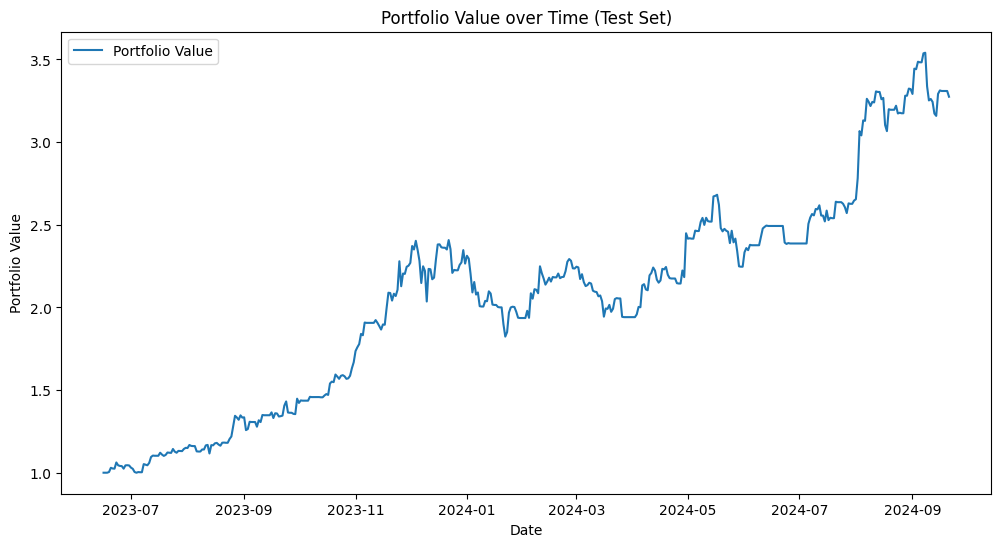

In [11]:
# Portfolio value over time

plt.figure(figsize=(12, 6))
plt.plot(
    test_df.index[: len(portfolio_values)], portfolio_values, label="Portfolio Value"
)
plt.title("Portfolio Value over Time (Test Set)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

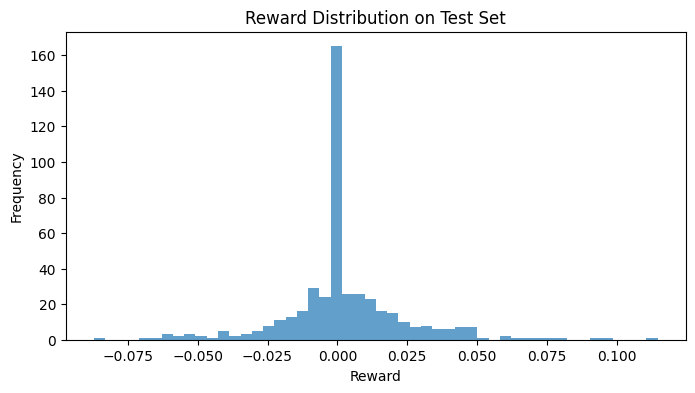

In [12]:
# reward distribution

plt.figure(figsize=(8, 4))
plt.hist(rewards, bins=50, alpha=0.7)
plt.title("Reward Distribution on Test Set")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.show()

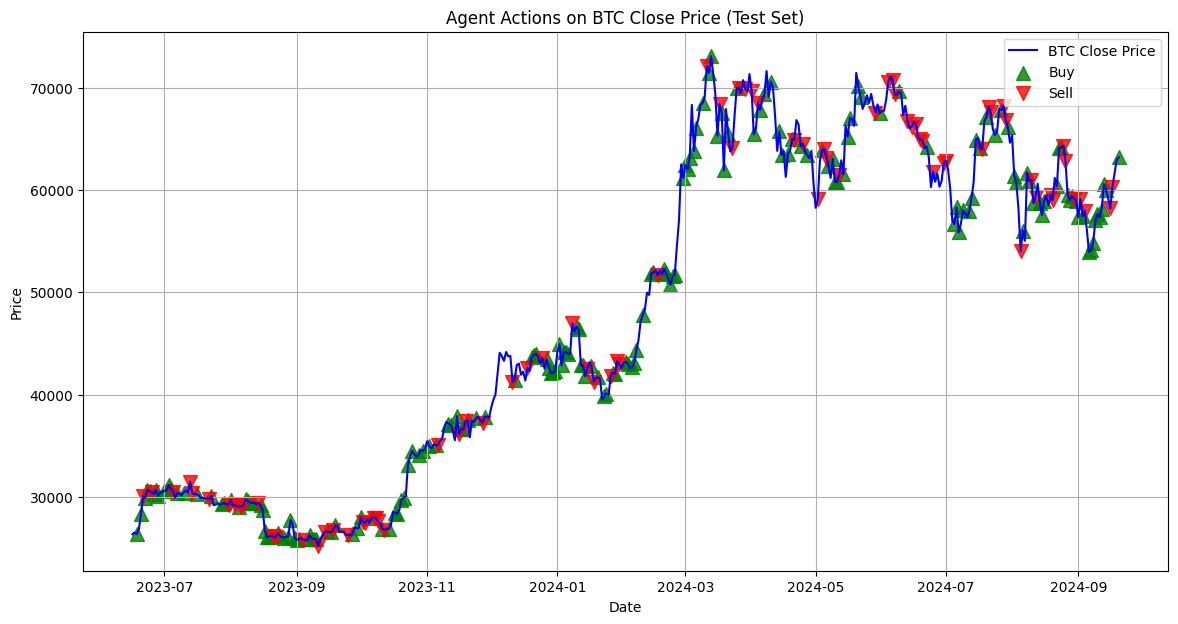

In [13]:
# Agent actions on BTC close price

# Extract closing prices for test period
prices = test_df["Close"].values[: len(actions_taken)]

# Identify buy and sell points
buy_points = np.where(actions_taken == 1)[0]
sell_points = np.where(actions_taken == 2)[0]

plt.figure(figsize=(14, 7))
plt.plot(test_df.index[: len(prices)], prices, label="BTC Close Price", color="blue")

# Plot buy markers
plt.scatter(
    test_df.index[buy_points],
    prices[buy_points],
    marker="^",
    color="green",
    label="Buy",
    alpha=0.8,
    s=100,
)

# Plot sell markers
plt.scatter(
    test_df.index[sell_points],
    prices[sell_points],
    marker="v",
    color="red",
    label="Sell",
    alpha=0.8,
    s=100,
)

plt.title("Agent Actions on BTC Close Price (Test Set)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

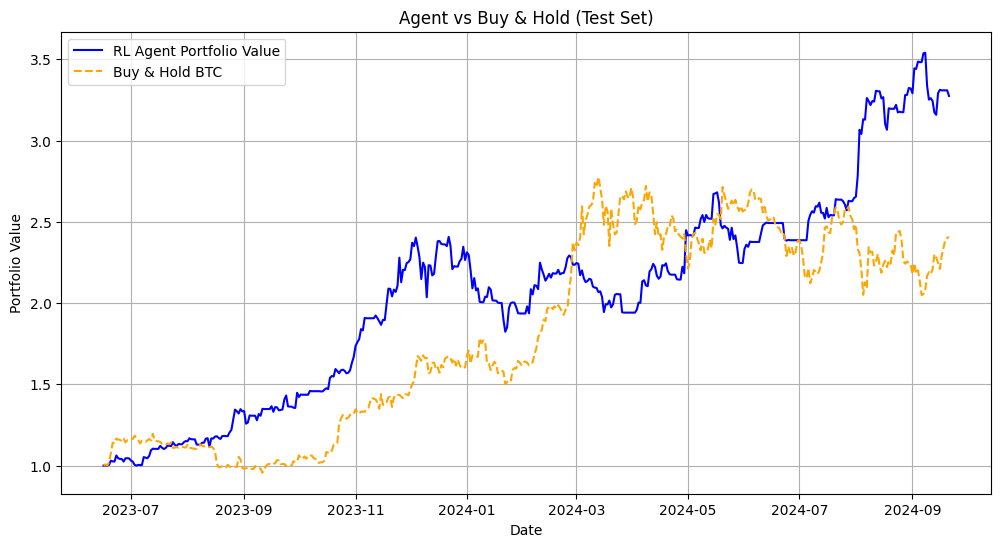

Agent Total Return: 227.44%
Buy & Hold Total Return: 140.79%


In [14]:
# Agent Equity Curve

agent_equity = portfolio_values

# Buy and Hold Equity Curve
initial_cash = agent_equity[0]
# Scale closing prices so that the first value equals initial cash
btc_prices = test_df["Close"].values[: len(agent_equity)]
buy_and_hold_equity = initial_cash * (btc_prices / btc_prices[0])

# Plot Both Curves
plt.figure(figsize=(12, 6))
plt.plot(
    test_df.index[: len(agent_equity)],
    agent_equity,
    label="RL Agent Portfolio Value",
    color="blue",
)
plt.plot(
    test_df.index[: len(agent_equity)],
    buy_and_hold_equity,
    label="Buy & Hold BTC",
    color="orange",
    linestyle="--",
)

plt.title("Agent vs Buy & Hold (Test Set)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()

# Compute Summary Metrics
agent_return = (agent_equity[-1] / agent_equity[0] - 1) * 100
bh_return = (buy_and_hold_equity[-1] / buy_and_hold_equity[0] - 1) * 100

print(f"Agent Total Return: {agent_return:.2f}%")
print(f"Buy & Hold Total Return: {bh_return:.2f}%")